### Import Libraries

In [1]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
import matplotlib.pyplot as plt
from pathlib import Path
from mne import channels
from shared.utilities import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES

### Load data

In [3]:
# Amount of cores to use in multiprocessing
cpus = 24

# Load complete SAT1 dataset
eeg_data = xr.load_dataset('data/sat1/data.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['channels'].values])

output_path = Path('data/sat1/')

### Prepare data

In [12]:
eeg_data = eeg_data.sel(participant=['0021', '0022', '0023', '0024', '0025'])

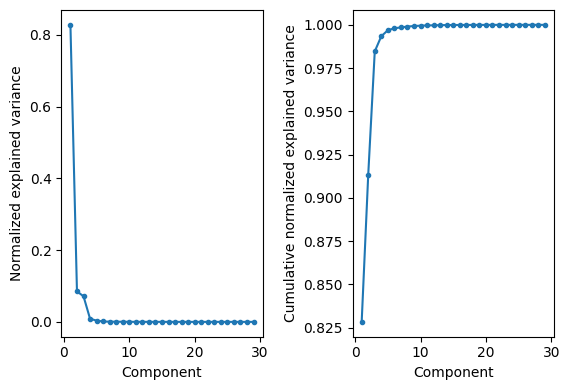

In [13]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize models

In [17]:
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC', variable='cue')
model_accuracy = hmp.models.hmp(hmp_accuracy_data, eeg_data, cpus=cpus,
                                 sfreq=eeg_data.sfreq,
                                 estimate_magnitudes=False
                                 )


hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'SP', variable='cue')
model_speed = hmp.models.hmp(hmp_speed_data, eeg_data, cpus=cpus,
                              sfreq=eeg_data.sfreq,
                              estimate_magnitudes=False
                              )

#### Regular fitting

In [18]:
fit_accuracy = model_accuracy.fit(step=1)
fit_speed = model_speed.fit(step=1)

  0%|          | 0/90 [00:00<?, ?it/s]

Transition event 1 found around sample 11
Transition event 2 found around sample 25
Transition event 3 found around sample 33
Transition event 4 found around sample 48
Transition event 5 found around sample 55
Estimating 5 events model
Parameters estimated for 5 events model


  0%|          | 0/54 [00:00<?, ?it/s]

Transition event 1 found around sample 11
Transition event 2 found around sample 24
Transition event 3 found around sample 32
Estimating 3 events model
Parameters estimated for 3 events model


In [153]:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
def process_model(model, eeg_data, labels):
    n_events = len(model.event)
    if len(labels) != n_events:
        raise ValueError('Amount of labels is not equal to amount of events, adjust labels parameter')
    
    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim='samples').astype(int)
    labels_array = np.empty(eeg_data.data.shape, dtype=int)
    participants = list(eeg_data.participant.values)
    # output_data = []
    # stage_data = []
    # stage_labels = []
    # participant_labels = []
    # epochs = []

    # For every known set of event locations, find the EEG data belonging to that trial (epoch) and participant
    for locations, data in zip(event_locations, model.trial_x_participant):
        data = data.item()
        locations = locations.values
        print(f'Processing participant {data[0]} and epoch {data[1]}')
        # t_x_p_data = int(eeg_data.sel(participant=data[0], epochs=data[1]).isnull().argmax('samples').data[0])
        # TODO Maybe not reliable enough, what if electrode 0 (Fp1) is working but others are not
        RT_sample = int(eeg_data.sel(participant=data[0], epochs=data[1]).isnull().argmax('samples').data[0])
        participant = participants.index(data[0])
        epoch = data[1]

        # Instead of all this, add dimension to dataarray with labels
        for j, location in enumerate(locations):
            # Slice from known event location n to known event location n + 1
            # unless it is the last event, then slice from known event location n to reaction time
            samples_slice = slice(location, locations[j + 1]) if j != n_events - 1 else slice(location, RT_sample - 1)
            print(samples_slice, labels[j])
            # TODO: Works right after, reset back to zero after this for loop
            labels_array[participant, epoch, :, samples_slice] = j
        print(labels_array[participant, epoch, :, :])
            
            # Do not record final stage if the last event bump is after the recorded reaction time
            # In this case, previous slices will have contained NaN values and have been skipped
            # if j == n_events - 1 and location > RT_sample:
            #     continue

            # eeg_slice = t_x_p_data.sel(samples=samples_slice)['data']

            # Disregard slices with NaN/None values
            # if eeg_slice.isnull().any():
            #     continue

            # Pad data to 'max' sample length
            # TODO: Look into max sample length
            # eeg_slice = eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0)
            # output_data.append((
            #     data[0], # participant
            #     data[1], # epoch
            #     eeg_slice
            # ))
            # stage_data.append(eeg_slice.pad(pad_width={'samples': (0, 199 - len(eeg_slice['samples']))}, mode='constant', constant_values=0))
            # stage_labels.append(labels[j])
            # participant_labels.append(data[0])
            # epochs.append(data[1])
            
    # stage_data = np.array(stage_data, dtype=np.float64)
    return labels_array


# Save data as .npz file containing both the data and belonging labels
def save_data(data, labels, participants, name):
    np.savez(output_path / name, data = data, labels = labels, participants=participants)

In [154]:
acc_data = process_model(fit_accuracy, eeg_data, SAT1_STAGES_ACCURACY + ['test'])
# save_data(acc_data, acc_labels, acc_part, 'stages_AC')

acc_data = process_model(fit_speed, eeg_data, SAT1_STAGES_SPEED)
# save_data(sp_data, sp_labels, sp_part, 'stages_SP')

Processing participant 0021 and epoch 0
slice(13, 20, None) encoding
slice(20, 25, None) decision
slice(25, 36, None) confirmation
slice(36, 61, None) response
slice(61, 138, None) test
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Processing participant 0021 and epoch 1
slice(5, 20, None) encoding
slice(20, 27, None) decision
slice(27, 54, None) confirmation
slice(54, 60, None) response
slice(60, 138, None) test
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Processing participant 0021 and epoch 4
slice(12, 25, None) encoding
slice(25, 31, None) decision
slice(31, 44, None) confirmation
slice(44, 58, None) response
slice(58, 166, None) test
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Processing participant 0021 and epoch 5
slice(7, 18, None) encoding
slice(18, 23, N

In [150]:
acc_data

array([[[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        ...,

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
    

In [52]:
# participant, epochs, channels, samples
acc_xds = xr.Dataset(
    data_vars=dict(
        data=(['participant', 'epochs', 'channels', 'segments'], acc_data)
        # labels=(['segments'], acc_labels),
        # participant=(['segments'], acc_part)
    ),
    # coords=dict(
    #     channels=eeg_data.coords['channels'],
    #     labels=(['segments'], acc_labels),
    #     participant=(['segments'], acc_part)
    # )
)

/home/rick/miniconda3/envs/thesis/lib/python3.11/site-packages/xarray/core/variable.py:293: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['participant', 'epochs', 'channels', 'segments'], [('0021', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.58655787,  -0.49848366,   1.53045905, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.59374905,  -2.8079946 ,   0.2248916 , ...,   0.        ,
          0.        ,   0.        ],
       [-11.42556381,  -4.9421854 ,  -2.83699656, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.53349543,   0.68418473,  -1.63581586, ...,   0.        ,
          0.        ,   0.        ],
       [  4.70735264,   1.63452578,  -2.18501639, ...,   0.        ,
          0.        ,   0.        ],
       [  6.31396484,   5.04234505,   2.66782355, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.2422266 , -15.17148399, -12.8327198 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.162323  , -16.45919609, -12.47939873, ...,   0.        ,
          0.        ,   0.        ],
       [-11.99831676, -15.4965868 , -11.88650417, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.4432795 ,   7.52377415,   8.76556492, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.4742288 ,   3.56566   ,   2.30336165, ...,   0.        ,
          0.        ,   0.        ],
       [  1.50011849,  -3.11888003,  -8.88191795, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-19.91923141, -16.45648384, -14.62493706, ...,   0.        ,
          0.        ,   0.        ],
       [-21.95925522, -19.72504616, -19.01441002, ...,   0.        ,
          0.        ,   0.        ],
       [-16.16983414, -15.93127155, -13.92115688, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 16.39837837,  14.572402  ,  13.0518446 , ...,   0.        ,
          0.        ,   0.        ],
       [ 15.42399216,  14.60312366,  12.87373924, ...,   0.        ,
          0.        ,   0.        ],
       [  3.29775906,   3.89855003,   1.74830341, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.34092951, 10.8065443 ,  8.26214886, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.95287275,  6.73483849,  6.30298281, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.57509947,  9.04448986,  7.52997828, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.4446454 , -9.10861301, -8.0355196 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.93064308, -7.71775055, -6.69427443, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.50022829, -3.10462403, -4.46994162, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.303
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.25836277, -5.41235733, -9.92290306, ...,  0.        ,
         0.        ,  0.        ],
       [-2.99110508, -1.20205569, -3.2871449 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.90308237, -4.21349955, -5.18582535, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.58409023, -3.36746025, -0.16598281, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11954367, -0.04344102,  1.8233552 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.27037239,  5.83317947,  6.41725588, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.303
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.97728825, -10.67322826,  -9.9069376 , ...,   0.        ,
          0.        ,   0.        ],
       [ -8.16160965,  -8.27191353,  -8.64747906, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.2375536 ,  -9.25657558,  -9.79799271, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.21222973,   7.3241787 ,   3.10355186, ...,   0.        ,
          0.        ,   0.        ],
       [  9.44560719,   5.53581381,   2.12909007, ...,   0.        ,
          0.        ,   0.        ],
       [  8.6642704 ,   6.94313765,   5.63888788, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 42.0 43.0 44.0 45.0 46.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.303
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.73102617,  8.69327831,  7.11010933, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.2627511 ,  4.521173  ,  0.84376144, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.81450796,  7.56796265,  6.28300381, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.62627363, -3.99511647, -0.83000714, ...,  0.        ,
         0.        ,  0.        ],
       [-6.30460596, -3.08492136, -1.58438599, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07798884, -2.44699764, -4.523386  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.542
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.29105377,  0.30524427,  0.13815463, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.70736742, -2.51971388,  2.18524599, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.6746707 ,  2.65331149,  3.47295594, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.54919195, -1.26912177, -2.82104158, ...,  0.        ,
         0.        ,  0.        ],
       [-4.13154268, -3.18120241, -4.14068508, ...,  0.        ,
         0.        ,  0.        ],
       [-8.82282925, -6.27762842, -6.23366213, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.542
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.80771589,  -7.04174519,  -7.01345491, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.91022635, -11.95250988, -10.57927227, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.40925646,  -6.86312437,  -6.11352825, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.25639677,   8.11005211,   7.04224443, ...,   0.        ,
          0.        ,   0.        ],
       [  4.73964262,   5.09366083,   4.81867695, ...,   0.        ,
          0.        ,   0.        ],
       [  0.3670575 ,   0.32952788,   0.05720729, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.542
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.5504458 , -0.10641393,  2.43292117, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.97334957, -0.2543847 ,  1.10518849, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.28554869, -0.73089439,  3.07856154, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.79059958, -0.42317796, -0.45527694, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45102888,  1.41763616, -0.65497178, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.27546525,  2.50949121, -3.01486468, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.17503047, -5.89917994, -6.14821529, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23923674, -4.04424286, -3.92277956, ...,  0.        ,
         0.        ,  0.        ],
       [-2.87881422, -8.12328339, -9.01124191, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.04271889, -5.14493322, -5.65771675, ...,  0.        ,
         0.        ,  0.        ],
       [-4.5637002 , -4.42644119, -3.63701653, ...,  0.        ,
         0.        ,  0.        ],
       [-2.61256647,  0.84409118,  3.66240263, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.24002409,  -5.15364218,  -3.97949791, ...,   0.        ,
          0.        ,   0.        ],
       [-10.17424107,  -6.04039288,  -3.08125615, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.15734673,  -5.6751647 ,  -4.22920561, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.54999828,   5.49375772,   6.01634455, ...,   0.        ,
          0.        ,   0.        ],
       [  3.387182  ,   2.80543375,   2.32056212, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.48632407,  -4.04052353,  -4.82831049, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.6945405 ,  0.8267259 , -2.7563405 , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.68172789,  1.90617907, -1.78600335, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.37214231,  1.34599483, -3.72389698, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.81934142,  2.22916937,  2.23669529, ...,  0.        ,
         0.        ,  0.        ],
       [-4.7570467 , -1.38863587,  0.93543077, ...,  0.        ,
         0.        ,  0.        ],
       [-6.23548555, -4.92544317, -1.9145987 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.23086761, -3.91507006, -2.3125453 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8267107 ,  0.53411484, -0.20974958, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08253481, -2.36679554, -2.57832646, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.51309788, -1.34616137, -5.38892651, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40140197, -0.37729263, -4.651968  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.68117452,  0.52404284, -2.50178647, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.79475904, -1.11881089, -1.92360353, ...,  0.        ,
         0.        ,  0.        ],
       [-3.24006534, -0.57875931,  2.61344457, ...,  0.        ,
         0.        ,  0.        ],
       [-1.3481009 ,  1.02986228,  2.13118005, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.83649111,  4.02478886,  3.63599205, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.68150091,  1.52631032,  1.91967738, ...,  0.        ,
         0.        ,  0.        ],
       [-3.41837859, -8.96594238, -9.3631897 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.5
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.63465536,  3.79312849,  6.34359264, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.21779633,  6.30351162,  6.38752508, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.40315938,  3.38496637,  4.7396183 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.67035651, -5.47127008, -9.5069313 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21948594, -4.95985889, -6.07673931, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.10153675,  3.85367012,  4.88378763, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.543
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.94971204, -4.07274532, -3.97065735, ...,  0.        ,
         0.        ,  0.        ],
       [-2.27691317, -6.50788736, -4.62565231, ...,  0.        ,
         0.        ,  0.        ],
       [-1.86253786, -3.2338388 , -4.15151119, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.08437347,  1.54798961,  1.23070776, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26328999,  0.93377155, -0.16768444, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.83956718,  2.24708056, -1.44703984, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.543
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.89913565,  2.45764446, -3.03553486, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70638323,  0.21459787, -6.27379608, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.6386857 ,  1.487409  , -3.49953389, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.17896152,  3.15073943,  5.96928692, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82861149, -1.08180749,  2.0049417 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68558526, -5.67803383, -4.9860611 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.543
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.73212814, -12.86763954,  -5.78727055, ...,   0.        ,
          0.        ,   0.        ],
       [-13.23117828,  -6.05211163,  -0.75361687, ...,   0.        ,
          0.        ,   0.        ],
       [-10.96124077,  -8.13665485,  -4.5460124 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.52512217,   4.964746  ,   0.69205415, ...,   0.        ,
          0.        ,   0.        ],
       [  9.12295151,   7.15611601,   2.30149555, ...,   0.        ,
          0.        ,   0.        ],
       [  9.93061066,   7.76360941,   3.28699851, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.745
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.46420574, -10.11450386, -12.77714062, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.78713131,  -8.67472172, -11.7296896 , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.41073799,  -9.43222141, -10.30743694, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.16445553,   2.08985758,   1.98763573, ...,   0.        ,
          0.        ,   0.        ],
       [  4.70914412,   3.28738761,   4.18949556, ...,   0.        ,
          0.        ,   0.        ],
       [  4.93299437,   1.92567265,   4.25888538, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.745
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.33963966, -14.97208309, -14.63416195, ...,   0.        ,
          0.        ,   0.        ],
       [-14.21971512, -16.73731613, -16.24783134, ...,   0.        ,
          0.        ,   0.        ],
       [-15.94333839, -15.84868336, -13.32261467, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.5170095 ,   5.50606918,   6.88462114, ...,   0.        ,
          0.        ,   0.        ],
       [  4.38173008,   6.16701555,   7.98591852, ...,   0.        ,
          0.        ,   0.        ],
       [  3.4484663 ,   2.77970982,   5.85594034, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.745
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.15931177, -6.15401173, -5.74586391, ...,  0.        ,
         0.        ,  0.        ],
       [-1.92940497, -4.52534103, -5.89225721, ...,  0.        ,
         0.        ,  0.        ],
       [-0.5300622 , -1.68766129, -4.12957764, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.53777945,  1.95500994,  1.45317245, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.6663084 ,  6.54428482,  6.17575502, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.4195013 ,  5.82293034,  6.18394375, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.608
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.05478001, -11.32727242,  -9.18964767, ...,   0.        ,
          0.        ,   0.        ],
       [-11.20408058, -14.94217777, -13.08300877, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.3951273 , -10.17886162,  -7.86102962, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.08968115,   4.49297667,   2.65560055, ...,   0.        ,
          0.        ,   0.        ],
       [  4.52074575,   4.72820616,   4.22337723, ...,   0.        ,
          0.        ,   0.        ],
       [  0.36369404,  -0.68452382,  -1.39579427, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.608
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.89874744,  -7.07602215, -10.611619  , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.0885005 , -10.48390007, -15.30915642, ...,   0.        ,
          0.        ,   0.        ],
       [  1.58387315,  -2.21266842,  -6.97097254, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.42146039,   5.78660631,   7.24588871, ...,   0.        ,
          0.        ,   0.        ],
       [  5.70961428,   6.72055149,   8.04571915, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.62082672,  -3.03248739,  -1.88933659, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.608
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.55897784,   0.04811475,  -2.15313625, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.04401541,  -3.56982803,  -7.74328375, ...,   0.        ,
          0.        ,   0.        ],
       [  6.52924156,   5.57556438,   2.1060462 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.44058323,   1.52897024,   7.06298971, ...,   0.        ,
          0.        ,   0.        ],
       [-10.00378132,  -4.23940134,   2.60069251, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.47317696,  -5.88899517,  -3.14278102, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.364
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.27116299, -12.32559013, -16.85121155, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.91058826,  -9.18960762, -14.63916206, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.46964645, -10.24130821, -12.95528221, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.57627344,   4.58566093,   4.69153118, ...,   0.        ,
          0.        ,   0.        ],
       [  4.2284379 ,   3.89431334,   5.53218174, ...,   0.        ,
          0.        ,   0.        ],
       [  2.69991183,   2.19604254,   3.88069487, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.364
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-18.19259262, -17.1532917 , -15.50481129, ...,   0.        ,
          0.        ,   0.        ],
       [-18.84004402, -19.66074371, -15.25057697, ...,   0.        ,
          0.        ,   0.        ],
       [-14.9360218 , -12.92026424,  -9.5134201 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.27620316,   6.48610687,   8.38802528, ...,   0.        ,
          0.        ,   0.        ],
       [  6.22825336,   6.55649042,   5.87258244, ...,   0.        ,
          0.        ,   0.        ],
       [  3.15549707,  -1.06664002,  -4.34095097, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.364
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.49378055,  7.81278181,  4.93946552, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.1069622 ,  8.72274113,  4.04377699, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.54342604,  7.03101778,  2.46280789, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.24298954, -8.79442024, -5.71585989, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2764352 , -6.84460354, -6.11679935, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.53925824, -1.3189224 , -2.8045404 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.488
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.82545662, -1.76156151, -1.23333752, ...,  0.        ,
         0.        ,  0.        ],
       [-7.91141558, -0.50998741, -0.54198122, ...,  0.        ,
         0.        ,  0.        ],
       [-4.84230757, -0.34786603,  2.28149652, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.16301394, -1.94058168, -3.21359849, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00441849, -3.07251763, -1.69116294, ...,  0.        ,
         0.        ,  0.        ],
       [-7.05690479, -6.03859663, -2.93121576, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.488
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.52107143, -7.27309942, -3.69169974, ...,  0.        ,
         0.        ,  0.        ],
       [-7.36142921, -9.03257465, -6.53085089, ...,  0.        ,
         0.        ,  0.        ],
       [-3.94316721, -6.03322268, -5.2104845 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.76418161,  4.12162971, -0.09638343, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.27626038,  4.40300274,  0.17804091, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.39148915, -1.52623916, -0.72481281, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.488
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 21, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.96035051, -0.30037642, -9.46880245, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.01893377,  1.69628036, -9.49632263, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.55880642,  1.20289683, -6.30144548, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.14008331, -0.67377734,  7.53866625, ...,  0.        ,
         0.        ,  0.        ],
       [-6.66503859, -1.72197902,  7.26087713, ...,  0.        ,
         0.        ,  0.        ],
       [-7.14257479, -6.32799482,  0.92335331, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 21
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 21, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.26667595,  2.05925584,  2.24748492, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.81579661, -0.95405412,  0.22180487, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.25638771,  5.68973875,  6.10601759, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.96999359, -4.44509983, -4.36456108, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5584383 , -1.34494042, -2.28800774, ...,  0.        ,
         0.        ,  0.        ],
       [-1.79614568, -3.93575907, -6.19221878, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 21
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 21, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.45001912e+00,  1.63477623e+00,  1.32810004e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.73527908e+00, -2.86770791e-01, -7.26983249e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.25832605e+00,  4.78864384e+00,  4.42855072e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.02732956e+00,  8.78954709e-01,  2.21503997e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.35215604e-01,  1.46887887e+00,  1.69516420e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.25167465e+00, -3.16717577e+00, -4.24501944e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 21
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 42.0 43.0 44.0 45.0 46.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.34811687, -10.2657547 , -12.61425114, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.76657104,  -7.28277683,  -9.2165041 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.83810234, -10.59946251, -13.94013214, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.59187603,  -4.70821476,  -0.67983806, ...,   0.        ,
          0.        ,   0.        ],
       [  1.31744635,   4.95339346,   7.75656986, ...,   0.        ,
          0.        ,   0.        ],
       [  5.50652075,  15.59838104,  16.93124199, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.57
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.27896976,  -9.61118984,  -8.37524986, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.58254528,  -9.7216959 ,  -9.76746368, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.86594772,  -4.0343194 ,  -1.22052443, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.74748802,  11.4249239 ,   9.28140354, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.38129711,  11.27271843,   7.64581776, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.70601273,  -3.88406229,  -7.1140666 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.57
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.62553024, -15.35543919,  -9.97269249, ...,   0.        ,
          0.        ,   0.        ],
       [-20.4095459 , -16.51948547,  -8.5168314 , ...,   0.        ,
          0.        ,   0.        ],
       [-17.63858604, -16.75264359, -10.83859825, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.98928261,   6.80181503,   0.55291873, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.19278908,  11.19713497,   7.87197018, ...,   0.        ,
          0.        ,   0.        ],
       [  3.64605427,   4.69306135,   6.83811092, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.57
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.23561954,  10.7081871 ,  12.23496628, ...,   0.        ,
          0.        ,   0.        ],
       [  7.44808245,  13.39195156,  13.08294678, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.68719101,  14.01975155,  13.52624416, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.77439046,  -5.96425867,  -8.54863644, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.77723789,  -6.0935688 ,  -7.45113993, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.42930984, -11.12813187,  -9.17548084, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.364
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.71517706,  3.0056119 ,  0.85393941, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.74216986, -0.79732949,  0.04192834, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.08327651,  0.61337841, -0.28796032, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.42624998, -0.88107228, -2.06862926, ...,  0.        ,
         0.        ,  0.        ],
       [-6.45143318, -3.70848107, -3.7982533 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.88404942, -4.8443327 , -2.06643772, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.684
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.48484612,  -9.40732956,  -7.18712568, ...,   0.        ,
          0.        ,   0.        ],
       [-12.10513592, -12.01259136,  -7.96966505, ...,   0.        ,
          0.        ,   0.        ],
       [-11.85450363, -10.57786655,  -4.90030575, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.34244546,  -0.09755202,  -0.19163588, ...,   0.        ,
          0.        ,   0.        ],
       [  1.82309031,   1.9340682 ,   1.83669853, ...,   0.        ,
          0.        ,   0.        ],
       [  3.14568377,   3.15611434,   1.52013743, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.684
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.12106419,  -3.29809666,  -8.0682354 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.46019244,  -4.57500792, -10.46737671, ...,   0.        ,
          0.        ,   0.        ],
       [  1.49900365,  -1.24406016,  -6.87455845, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.83056498,   0.5067845 ,   3.58251452, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.36483848,   0.46964186,   1.97658527, ...,   0.        ,
          0.        ,   0.        ],
       [  0.33452508,  -1.18997765,  -1.60964787, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.684
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.69681203, -0.65979987, -4.55874252, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54405999, -5.73519945, -4.21325588, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12209654, -1.42751729, -1.96544254, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.12207007,  0.49183375,  2.38144445, ...,  0.        ,
         0.        ,  0.        ],
       [-2.46285319,  0.99569547,  3.11389637, ...,  0.        ,
         0.        ,  0.        ],
       [-5.97909689, -2.98701406,  0.69055837, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.788
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.42382872, -1.75959265, -2.65323234, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.16128516, -1.77174139, -2.72730994, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.17604184, -0.50564718, -0.90096945, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.75011528, -0.63520068, -0.6553449 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.21389997,  1.48358214,  1.80275953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.35643265,  2.75089145,  5.54272032, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.788
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.39949036, -5.33016682, -6.80919695, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00209451, -2.7853055 , -2.62447977, ...,  0.        ,
         0.        ,  0.        ],
       [-2.55378962, -5.05210352, -6.42551994, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.3693223 , -5.19344997, -5.46147919, ...,  0.        ,
         0.        ,  0.        ],
       [-1.33067429, -2.22645187, -3.70084095, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.02215958,  7.50782728,  4.77732706, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.788
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.27691603, -1.93881297,  0.80460769, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26991391, -1.82907617, -3.20397472, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.98366255,  2.43484426,  4.21259975, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.69056988,  9.23697853,  7.53935671, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.44033146,  9.40444469,  6.31698704, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09506552, -3.05218911, -6.79616117, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.527
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.58939743, -6.37925911, -5.74176264, ...,  0.        ,
         0.        ,  0.        ],
       [-4.77657413, -9.78101921, -6.39136648, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36587739, -3.28014803, -3.46666908, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.24304962, 11.36029243,  9.87516785, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.67074919,  6.27076817,  4.47386312, ...,  0.        ,
         0.        ,  0.        ],
       [-3.59889317, -6.28878021, -5.8498292 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.527
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.320961  ,  -8.90919876,  -8.92700195, ...,   0.        ,
          0.        ,   0.        ],
       [-11.65846729, -13.32496166, -11.38594913, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.30152225,  -6.84484911,  -4.77071762, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 16.8901329 ,  18.42942619,  19.71765137, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.38714504,  11.30843258,  11.5018568 , ...,   0.        ,
          0.        ,   0.        ],
       [ -1.80030239,  -6.93799925,  -9.2478981 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.527
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.73473406, -1.71779954,  1.56438804, ...,  0.        ,
         0.        ,  0.        ],
       [-5.00305223, -1.14324594,  3.93707418, ...,  0.        ,
         0.        ,  0.        ],
       [-2.43618464, -0.45438999,  2.67934942, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.87973881,  2.36359334,  1.20141542, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.949471  ,  2.89068079,  3.0201149 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.02346778, -0.60164136, -0.42932215, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.539
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.34600067, -7.46123028, -7.25758743, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83481526, -5.45093489, -8.07713318, ...,  0.        ,
         0.        ,  0.        ],
       [-5.29896784, -7.51762104, -7.89881277, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.08732593,  1.01991832, -0.347415  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.40638173,  1.59204042,  0.52525675, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28861725,  4.76576471,  4.08786869, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.539
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.58013487, -6.78762388, -8.82877064, ...,  0.        ,
         0.        ,  0.        ],
       [-8.14630508, -6.70200586, -8.26032448, ...,  0.        ,
         0.        ,  0.        ],
       [-4.6671896 , -4.17521524, -6.40939569, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [16.2223053 , 13.03981113, 11.40788269, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.07345009,  6.64265203,  6.11823177, ...,  0.        ,
         0.        ,  0.        ],
       [-8.16429901, -9.90311337, -7.3794508 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.539
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.04121113,  3.90654945, -0.70731056, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.37115526,  3.70251751, -1.87928438, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.9715724 ,  2.12743163, -3.08868122, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.67187881, -3.85536623, -1.53106511, ...,  0.        ,
         0.        ,  0.        ],
       [-3.89603329, -2.91399431, -1.97098565, ...,  0.        ,
         0.        ,  0.        ],
       [-0.29500094,  3.28437376,  3.12546372, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.557
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.61901188, -8.99935818, -5.89999437, ...,  0.        ,
         0.        ,  0.        ],
       [-2.14260054, -6.77607679, -9.44565582, ...,  0.        ,
         0.        ,  0.        ],
       [-6.22445822, -8.91311264, -9.07867336, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.94684774,  2.70989585,  2.05688024, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.44069529,  4.1440258 ,  3.75755095, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.91440344,  8.87807655,  8.52643585, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.557
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.21473575, -2.5962317 , -1.29235649, ...,  0.        ,
         0.        ,  0.        ],
       [-3.09994555, -1.03985953, -1.51361978, ...,  0.        ,
         0.        ,  0.        ],
       [-4.20265007, -0.87290531, -1.3114059 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.47194031,  2.19178653,  0.47080779, ...,  0.        ,
         0.        ,  0.        ],
       [-2.79679465, -1.20135272, -1.18199599, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2804555 ,  0.16108932, -0.33944598, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.557
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 30, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.52464676,  11.27611542,   8.60718536, ...,   0.        ,
          0.        ,   0.        ],
       [  6.8389287 ,  12.30009842,   9.67517281, ...,   0.        ,
          0.        ,   0.        ],
       [  7.98046494,  12.13870049,   6.99468517, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.94552708,  -6.22411251,  -4.6131587 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.28357315,  -8.56912899,  -1.30491984, ...,   0.        ,
          0.        ,   0.        ],
       [-15.56764507, -10.53739071,   1.49317777, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 30
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.4
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 31, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-19.8972435 ,  -6.48310423,   1.19969118, ...,   0.        ,
          0.        ,   0.        ],
       [-20.621521  ,  -7.49300432,   1.69880867, ...,   0.        ,
          0.        ,   0.        ],
       [-18.36695671,  -5.95710468,   1.81771863, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.92841148,   3.71531034,  -1.49076784, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.87503338,   4.45192051,   0.17326523, ...,   0.        ,
          0.        ,   0.        ],
       [  0.11378536,  -4.89909458,  -3.34487271, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 31
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 31, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.27387238,  -1.95176446,   0.66829169, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.19276524,  -0.28695235,   1.61711419, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.82089186,  -0.8594631 ,   1.72716761, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.1303103 ,  -2.53782368,  -1.6157558 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.28101051,  -2.8412807 ,  -5.15912533, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.71185255, -10.87375832, -16.34266472, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 31
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 31, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.64475664e-01, -7.99146481e-03, -2.56960106e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.57144904e+00, -5.80376863e+00, -1.02585840e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.88549876e+00, -2.55139887e-01, -4.66876173e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.81103802e+00, -3.07628250e+00,  1.83506882e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.10253572e+00, -4.12785530e+00, -1.83657682e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.27195740e+00, -8.69178009e+00, -9.37607002e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 31
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.53829002,  4.08041525,  1.53884625, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.38155937,  2.97498274,  0.16421415, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.0008378 ,  2.54243731, -1.60252547, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.32091117, -1.08274353, -3.05749226, ...,  0.        ,
         0.        ,  0.        ],
       [-1.78141427, -0.74465513, -2.42049861, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.62111533, -1.45672011, -2.40067363, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.483
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.71282005, -0.29204786, -1.24201202, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8661027 ,  0.71160561, -0.59097028, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.97130013,  2.91228485,  1.28608263, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.41916379, -0.99889296, -4.19359493, ...,  0.        ,
         0.        ,  0.        ],
       [-3.75582457, -1.73329496, -3.03557706, ...,  0.        ,
         0.        ,  0.        ],
       [-9.45433331, -4.4447794 , -2.42627382, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.483
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.22701836, -0.56043631, -0.80442786, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25425625,  0.34094402,  0.73761863, ...,  0.        ,
         0.        ,  0.        ],
       [-0.15808599, -0.4518401 ,  0.76335645, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.27597284, -6.22921705, -5.69914722, ...,  0.        ,
         0.        ,  0.        ],
       [-3.06093287, -3.2525804 , -2.67400932, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25036559,  0.4434579 , -0.58227211, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.483
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.82288098,  6.80204487, 12.54924488, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.58388662,  8.14016056, 10.7853508 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.40382385,  6.20995331, 10.83900452, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.38373065, -0.87764382, -1.26065481, ...,  0.        ,
         0.        ,  0.        ],
       [-3.24944973, -2.70221162, -5.70030975, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.95398331,  3.79434752, -4.33803701, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.61521435, -10.66765213, -13.82589817, ...,   0.        ,
          0.        ,   0.        ],
       [-12.7110405 , -11.53670597, -13.59029484, ...,   0.        ,
          0.        ,   0.        ],
       [-14.4754591 , -13.21034527, -13.04409027, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.89009142,  -0.64495635,   3.29507613, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.07803079,  -0.04557956,   2.76432419, ...,   0.        ,
          0.        ,   0.        ],
       [  7.70548582,   3.89431357,   2.84338975, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.82589817, -19.68196106, -19.83603859, ...,   0.        ,
          0.        ,   0.        ],
       [-13.59029484, -18.09673309, -19.55117607, ...,   0.        ,
          0.        ,   0.        ],
       [-13.04409027, -16.3296299 , -17.35439491, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.29507613,   9.89916897,  13.30345535, ...,   0.        ,
          0.        ,   0.        ],
       [  2.76432419,   7.62612343,   9.41704655, ...,   0.        ,
          0.        ,   0.        ],
       [  2.84338975,   3.29143047,   1.85365248, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 9.71984673,  7.18300867,  6.30245733, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.24209023,  2.73449588,  5.77453709, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8689568 ,  4.64906597,  5.89483929, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.91979265, -6.65955687, -5.76170778, ...,  0.        ,
         0.        ,  0.        ],
       [-7.33851194, -7.6245389 , -8.61502361, ...,  0.        ,
         0.        ,  0.        ],
       [-2.18463397, -2.87606597, -4.3851757 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.704
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.32389593, -3.88542676, -2.44981623, ...,  0.        ,
         0.        ,  0.        ],
       [-3.43282604, -2.97455764, -0.10698567, ...,  0.        ,
         0.        ,  0.        ],
       [-4.75624371, -2.14333916,  0.64649719, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.65976346, -1.36438227, -2.62100863, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15448996, -2.26183057, -5.25826263, ...,  0.        ,
         0.        ,  0.        ],
       [-2.27359772, -5.71286392, -8.18600941, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.704
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.19931221, -5.55773354, -4.69160223, ...,  0.        ,
         0.        ,  0.        ],
       [-7.09187174, -1.92655706, -0.71223927, ...,  0.        ,
         0.        ,  0.        ],
       [-9.78856373, -7.3473587 , -5.1296916 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.13401628, -2.65406346, -4.460042  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.90584159, -2.74170136, -2.00388575, ...,  0.        ,
         0.        ,  0.        ],
       [-5.08346653, -2.80703473,  1.55373621, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.704
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.59386635, -3.20799136, -2.07415628, ...,  0.        ,
         0.        ,  0.        ],
       [-2.82364416, -0.73659885,  1.2275573 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.60081005, -5.87363958, -4.24055862, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.62711602, -3.26256824, -2.99991202, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85524672, -1.37163806, -0.86279571, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79297733,  0.57665372,  2.103513  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.513
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.33176112, -0.1645522 , -6.45984221, ...,  0.        ,
         0.        ,  0.        ],
       [-1.73743904, -2.25617528, -8.86249828, ...,  0.        ,
         0.        ,  0.        ],
       [-0.60775149, -1.15018332, -6.12378836, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.03029087, -1.82731915,  1.1519109 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.46872759, -3.66297793, -1.06422913, ...,  0.        ,
         0.        ,  0.        ],
       [-5.22228956, -6.42734337, -6.41360378, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.513
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.13494205, -12.42390537, -13.24115849, ...,   0.        ,
          0.        ,   0.        ],
       [-17.52130127, -19.552248  , -15.49474812, ...,   0.        ,
          0.        ,   0.        ],
       [-15.10499477, -15.92983818, -14.63370228, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.13983822,   9.53741932,  10.77849483, ...,   0.        ,
          0.        ,   0.        ],
       [  5.64684105,   5.66861916,   4.44507933, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.60854739,  -1.04719377,  -6.44590092, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.513
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.11599433, -3.00774264,  0.16660798, ...,  0.        ,
         0.        ,  0.        ],
       [-2.37325811, -5.32592964, -1.41216707, ...,  0.        ,
         0.        ,  0.        ],
       [-1.52704906, -6.26235056, -3.5630374 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.22013366,  0.83644629, -2.69958091, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56033695,  2.48948193, -0.26827469, ...,  0.        ,
         0.        ,  0.        ],
       [-0.123207  ,  5.61706448,  6.55082321, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.44529867,  -8.0078764 ,  -8.45089626, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.66921329, -12.69331837, -13.9501667 , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.13025093,  -6.68292856,  -8.03393745, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.57133055,   7.15661955,  10.79300308, ...,   0.        ,
          0.        ,   0.        ],
       [  5.54165268,   7.20844746,   8.93756962, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.13707711,  -0.25609544,  -0.23097712, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.43747139,  -9.36356449,  -8.41835499, ...,   0.        ,
          0.        ,   0.        ],
       [-13.73815727, -13.43407917, -11.41738892, ...,   0.        ,
          0.        ,   0.        ],
       [-11.96349335, -12.48069382, -10.84668636, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.26407528,   9.54385185,   9.80748749, ...,   0.        ,
          0.        ,   0.        ],
       [  8.65337563,   8.40260696,   9.89602852, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.66169053,   0.87633497,   3.99419403, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.70459414,  8.64898205, 15.19561863, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.59603643, 12.02142811, 17.07921791, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.3866868 , 10.89736843, 15.94976425, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.82741356, -3.68839765, -6.15731382, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.2335639 ,  0.97344553, -6.40011263, ...,  0.        ,
         0.        ,  0.        ],
       [11.18723679,  7.59349394, -1.37382638, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.97645569, -6.17585182, -3.74962139, ...,  0.        ,
         0.        ,  0.        ],
       [-9.2022562 , -6.88814545, -3.44356132, ...,  0.        ,
         0.        ,  0.        ],
       [-5.10140896, -3.25929022, -1.00985622, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.76080894,  7.91233873,  3.30541158, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.34471464,  5.13499117,  1.44641185, ...,  0.        ,
         0.        ,  0.        ],
       [-6.15731668, -1.63166225,  0.56901473, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.99493027, -6.7367835 , -4.91605854, ...,  0.        ,
         0.        ,  0.        ],
       [-7.30854464, -7.55458069, -5.62816811, ...,  0.        ,
         0.        ,  0.        ],
       [-1.81818795, -3.90704966, -2.20029163, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [11.05905819,  9.81581688,  7.95874357, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.05702114,  6.08375168,  5.55840588, ...,  0.        ,
         0.        ,  0.        ],
       [-3.00304008,  0.67590976, -0.34654516, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.71372116,  2.36032701, -0.12609413, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.74678779,  3.15610719,  0.2385056 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.14850736,  3.77256131,  1.02803755, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.5335784 , -5.88256407,  0.4778055 , ...,  0.        ,
         0.        ,  0.        ],
       [-7.00504637, -5.70684958,  0.92526084, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89887071, -1.72013283,  1.44948459, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.69849014, -10.27143478, -10.32930756, ...,   0.        ,
          0.        ,   0.        ],
       [-10.38381767,  -9.02971745, -10.84027958, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.77271366,  -6.23343325,  -8.11423206, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.41368908,  -1.75197434,   1.04049122, ...,   0.        ,
          0.        ,   0.        ],
       [  0.1936202 ,   0.36378708,   3.43794322, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.665223  ,   0.23800328,   2.68596172, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.44319916,  -8.37265205,  -6.37144184, ...,   0.        ,
          0.        ,   0.        ],
       [-15.27065277, -11.85379696, -10.00723553, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.50588703,  -5.07506418,  -4.55946207, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.05663157,   7.50716829,   7.03914499, ...,   0.        ,
          0.        ,   0.        ],
       [  5.65509987,   6.26502514,   4.72269154, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.58998966,  -5.25838089,  -5.1594882 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.05
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.77405477, -11.17883873,  -8.38705635, ...,   0.        ,
          0.        ,   0.        ],
       [  0.51008302,  -9.84340763, -11.79882145, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.92077982, -10.82962799, -10.61354828, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.4879168 ,   1.8756386 ,   1.846928  , ...,   0.        ,
          0.        ,   0.        ],
       [  3.00973153,   4.87268972,   4.61364889, ...,   0.        ,
          0.        ,   0.        ],
       [  3.36750579,   7.32307482,   7.84818602, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.4
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.63201666, -4.68949127, -6.61709642, ...,  0.        ,
         0.        ,  0.        ],
       [-1.93775344, -4.10945606, -3.53245163, ...,  0.        ,
         0.        ,  0.        ],
       [-2.84657478, -5.36548948, -4.42789698, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.51631641,  1.7430352 ,  0.72612423, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71783245,  1.91627669,  1.67002976, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20859504,  4.56337357,  4.11816454, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.4
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.30407286, -6.30291748, -8.2010231 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.05240345, -7.95135784, -7.41405201, ...,  0.        ,
         0.        ,  0.        ],
       [-6.18929291, -5.3985467 , -4.9059124 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.02145576,  4.37873745,  6.92746878, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.00625229,  5.03671217,  7.99340296, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.79255891,  2.24697948,  4.26300907, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.4
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 48, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.32084179,  11.10739708,   7.14863682, ...,   0.        ,
          0.        ,   0.        ],
       [  7.71194315,   9.47186279,   5.9454565 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.96612334,   7.60573196,   3.93246055, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.15825462, -14.23283005, -11.12735558, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.87349892, -13.58591461, -10.40448666, ...,   0.        ,
          0.        ,   0.        ],
       [  0.16245326,  -6.30560684,  -3.67588496, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 48
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.928
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 48, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.44447947,  0.26757714,  0.86671209, ...,  0.        ,
         0.        ,  0.        ],
       [-3.6613574 ,  1.3084172 ,  1.58151388, ...,  0.        ,
         0.        ,  0.        ],
       [-6.8325243 ,  0.478414  ,  0.75684094, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.09814072, -4.88943958, -1.29178989, ...,  0.        ,
         0.        ,  0.        ],
       [-4.26410913, -3.98090458, -1.12058663, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.49373984, -1.62063622, -0.65625399, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 48
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.928
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 48, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.30720711, -4.55020714, -7.69325972, ...,  0.        ,
         0.        ,  0.        ],
       [-2.17301416, -3.43857598, -7.34930277, ...,  0.        ,
         0.        ,  0.        ],
       [-5.94039679, -6.21937656, -8.74458504, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.55064011, -5.20380926, -2.90947509, ...,  0.        ,
         0.        ,  0.        ],
       [-2.26705813, -1.92170465, -0.41829538, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.98286057,  3.8893168 ,  3.24379325, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 48
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.928
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.08803797, -5.81167173, -4.5699749 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.34774065, -3.71880364,  0.49672213, ...,  0.        ,
         0.        ,  0.        ],
       [-3.45574546, -5.17981148, -1.02001619, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.59275866,  1.74220729,  0.3215704 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.30655384,  2.96683025,  4.27892256, ...,  0.        ,
         0.        ,  0.        ],
       [-3.66488099, -0.49904895,  1.45814526, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.419
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.53535414, -0.06324204,  2.09434199, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05886461,  0.14015426,  0.55905354, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.47854161,  2.40602946,  3.51343274, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.31636405,  1.39610779,  1.4807508 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.81099486,  1.94594455,  0.69784039, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91829038, -1.44921148, -2.16238666, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.419
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.68516731, -13.3053627 , -16.43092728, ...,   0.        ,
          0.        ,   0.        ],
       [-11.55506897, -13.09057331, -16.09992218, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.7911191 ,  -9.68872929, -13.64427757, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.81261158,   9.40873623,  10.66869354, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.37014198,  10.6546669 ,  12.00284386, ...,   0.        ,
          0.        ,   0.        ],
       [  3.20727849,   2.78008056,   5.66180468, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.419
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.6548388 ,  -6.39928722,  -9.02630615, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.28840193,  -7.31300879, -10.112607  , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.76494098, -10.36319065, -13.12791348, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.03752947,  -1.56200588,   0.77694666, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.67345881,  -0.66924667,   2.09035158, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.64302397,   0.16116077,   2.49983335, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.234
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.58223104, -2.12737656, -1.27515185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17569995,  1.61848581,  0.16625342, ...,  0.        ,
         0.        ,  0.        ],
       [-5.98211384, -1.80013227, -1.13708794, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.76908588, -5.74817848, -2.5479753 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.6258812 , -3.32040668,  0.28151214, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.51395893, -0.82463694,  0.71047956, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.234
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.985816  , -15.60678864, -15.75641441, ...,   0.        ,
          0.        ,   0.        ],
       [-14.72801304, -15.89818954, -15.92262936, ...,   0.        ,
          0.        ,   0.        ],
       [-13.82701683, -12.78613472, -14.82755947, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 13.73641205,  13.88977528,  14.29289818, ...,   0.        ,
          0.        ,   0.        ],
       [ 13.13660049,  13.08616066,  12.55873108, ...,   0.        ,
          0.        ,   0.        ],
       [  6.58290386,   3.70284939,   1.34514606, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.234
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.53030586,  -1.00829399,  -9.23739815, ...,   0.        ,
          0.        ,   0.        ],
       [  7.81304979,  -1.62666965, -10.54558468, ...,   0.        ,
          0.        ,   0.        ],
       [  6.55923414,  -2.2332108 , -10.10942364, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-15.08494949, -12.09243298,  -7.64911604, ...,   0.        ,
          0.        ,   0.        ],
       [-14.19026184,  -6.00654173,   2.92617416, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.91444564,   9.10459614,  13.17597198, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.063
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.69040251,  -8.44523335, -10.02936172, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.58474588,  -0.4580203 ,  -6.4910531 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.15736485,  -5.57621622,  -8.12181091, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.53464317,   4.65513849,   4.79730463, ...,   0.        ,
          0.        ,   0.        ],
       [  7.31034899,   6.92256308,   7.77644157, ...,   0.        ,
          0.        ,   0.        ],
       [  4.08219862,   4.96611261,   6.49877691, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.063
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.91348839, -7.11095524, -7.86854076, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74331379, -3.63895869, -9.27702522, ...,  0.        ,
         0.        ,  0.        ],
       [-5.88248253, -6.57423115, -8.75313282, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.95667005,  7.7560277 ,  7.46397972, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.34101295,  9.47695446, 11.07014084, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.41623592,  5.96580696,  5.9795351 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 48.0 49.0 50.0 51.0 52.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.063
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.41475725, -1.30439627,  0.94872689, ...,  0.        ,
         0.        ,  0.        ],
       [-2.38769698, -1.57542503, -0.73273051, ...,  0.        ,
         0.        ,  0.        ],
       [-1.95336235, -0.59053963, -1.60469592, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.15066433,  1.87085783, -3.77036738, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.37675667, -3.14949703, -4.84267998, ...,  0.        ,
         0.        ,  0.        ],
       [-1.78755414, -7.473001  , -4.57853317, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.717
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.05443954,  2.36038113, -2.27800202, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.33159304,  2.7709322 , -5.13621044, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.10414672,  1.58041453, -3.39769411, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.6529994 , -2.6316123 ,  1.95957327, ...,  0.        ,
         0.        ,  0.        ],
       [-8.74928951, -2.73475122,  2.31852531, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52618557,  0.57124436, -0.25329748, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.717
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.25516987,  -9.36791801, -10.83232498, ...,   0.        ,
          0.        ,   0.        ],
       [-13.90349102, -13.51732731, -14.61808014, ...,   0.        ,
          0.        ,   0.        ],
       [-10.44092083, -10.47239494, -12.20870972, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.16910172,   8.78303909,  12.77697277, ...,   0.        ,
          0.        ,   0.        ],
       [  6.65398026,   6.13980484,   7.65322638, ...,   0.        ,
          0.        ,   0.        ],
       [  0.85893136,  -2.29683423,  -5.22318697, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.717
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.80616188, -1.55296969, -2.5267961 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.43766165, -4.63060808, -3.45959449, ...,  0.        ,
         0.        ,  0.        ],
       [-3.51712799, -5.51929522, -6.05072355, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.10719429, -0.41827619, -0.18863115, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46426755,  2.78512049,  1.75208294, ...,  0.        ,
         0.        ,  0.        ],
       [-1.30579054,  4.14522171,  3.43121576, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.7405901 ,  -8.11127663,  -7.31378889, ...,   0.        ,
          0.        ,   0.        ],
       [-11.34214592, -10.55507755,  -4.02137375, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.00273609,  -9.95766258,  -8.68232441, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.04234934,  -0.33042923,   4.20293999, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.80558944,  -1.07938719,   2.3370502 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.821742  ,  -3.36848378,  -1.66374683, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.15388584, -11.35831547, -12.20532227, ...,   0.        ,
          0.        ,   0.        ],
       [-11.43904305, -10.13190746, -11.24357128, ...,   0.        ,
          0.        ,   0.        ],
       [-13.13579464, -11.30985355, -12.76419544, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.76268339,   3.35897851,   0.120116  , ...,   0.        ,
          0.        ,   0.        ],
       [  5.44607067,   1.30750048,  -0.78919995, ...,   0.        ,
          0.        ,   0.        ],
       [  0.21410063,  -1.56186652,   0.21900539, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.90283632, -5.41191912, -4.31645823, ...,  0.        ,
         0.        ,  0.        ],
       [-5.50479794, -6.78527975, -5.76170921, ...,  0.        ,
         0.        ,  0.        ],
       [-5.11498833, -5.70754719, -3.4052856 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.43666244,  1.30996859,  0.85731983, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4565379 ,  2.26401258,  1.29854667, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74343783,  1.69219005,  0.85541654, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.433
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.86405849,  -1.76492488,  -2.91894865, ...,   0.        ,
          0.        ,   0.        ],
       [-11.82948303,  -9.45775509,  -6.3769455 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.66914749,  -2.21551847,  -3.63303471, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.04586172,   1.88575923,   1.16587281, ...,   0.        ,
          0.        ,   0.        ],
       [  0.31298015,   0.01458062,   2.75744319, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.27547073,  -3.3417964 ,   4.76770973, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.433
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.76382256, -12.28717518, -13.86898232, ...,   0.        ,
          0.        ,   0.        ],
       [-21.3142662 , -16.22229385, -11.94207573, ...,   0.        ,
          0.        ,   0.        ],
       [-10.9271059 ,  -8.41213512,  -7.02588415, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 14.53393078,  13.61051178,  14.4749279 , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.58574867,  12.11716843,  14.22455883, ...,   0.        ,
          0.        ,   0.        ],
       [  0.33594817,  -0.09023375,   2.91209459, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.433
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.22066426,  8.67934513,  6.65345478, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.84883261,  7.10932159,  3.30049634, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.07835484,  8.70044136,  5.28527641, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.84855676, -5.66224909, -3.5325942 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.40898204, -5.23724079, -2.48401523, ...,  0.        ,
         0.        ,  0.        ],
       [-3.29481101, -6.64978313, -6.18379068, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.806
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.73487043, -5.28080034, -3.03102946, ...,  0.        ,
         0.        ,  0.        ],
       [-8.79943752, -7.16782427, -5.73075485, ...,  0.        ,
         0.        ,  0.        ],
       [-2.70607066, -2.75435472, -1.13341188, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.20966709,  0.98694772,  2.10547733, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.51311004,  1.77819121,  0.98989338, ...,  0.        ,
         0.        ,  0.        ],
       [-4.69682217, -2.77495623, -6.17207909, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.806
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.01239347, -6.75168705, -7.58711433, ...,  0.        ,
         0.        ,  0.        ],
       [-8.94539833, -7.31608343, -7.30217075, ...,  0.        ,
         0.        ,  0.        ],
       [-6.96875286, -7.19514179, -6.77805853, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.50892019,  6.53216553,  6.00494003, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.29167438,  3.13465548,  3.07861352, ...,  0.        ,
         0.        ,  0.        ],
       [-4.39577246, -3.14338088, -3.15227604, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.806
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.13452825,  4.25541162,  5.8608284 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29443908,  3.82849264,  6.67060661, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.01426888,  6.09642696,  8.2335062 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.39293051, -6.66992664, -7.37280369, ...,  0.        ,
         0.        ,  0.        ],
       [-3.6154089 , -6.21202612, -5.7967205 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1180664 , -1.91873431, -0.43188429, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.086
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.370309  , -1.53718531, -1.3965162 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.8261863 ,  1.37188721,  1.19337344, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.65659976, -0.19245507, -2.07662773, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.7701292 , -7.49868488, -7.7644453 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.96470731, -4.55794525, -3.93449044, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90344477,  2.90681386,  4.23884439, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.086
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.22830153,  -7.17120457, -11.06659317, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.37781858,  -3.88064361,  -5.15275717, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.37990761,  -4.95366287,  -5.49985409, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.11444037,   4.64802599,   9.92632008, ...,   0.        ,
          0.        ,   0.        ],
       [  1.46281052,   4.44267893,   6.95421982, ...,   0.        ,
          0.        ,   0.        ],
       [  0.85189402,   1.7822665 ,  -0.92440987, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.086
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.78062093,  2.39411926,  1.43609381, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.50269222,  5.69306517,  6.66316462, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.34213114,  3.76038098,  2.64231062, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.95699453, -5.80315161, -3.88760805, ...,  0.        ,
         0.        ,  0.        ],
       [-4.6589365 , -4.8326025 , -2.2440505 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.21948433,  1.89293051,  4.36634064, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.3
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.85480499, -10.5882082 ,  -4.54338169, ...,   0.        ,
          0.        ,   0.        ],
       [-12.12946987, -11.42818642,  -6.83883429, ...,   0.        ,
          0.        ,   0.        ],
       [-10.93026733, -10.04969692,  -5.04639816, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.87544203,   7.78227758,   6.18755007, ...,   0.        ,
          0.        ,   0.        ],
       [  8.64393997,   7.19373465,   4.28885937, ...,   0.        ,
          0.        ,   0.        ],
       [  2.98420715,   1.50410974,  -2.3546176 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.3
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.69413185, -15.3579874 , -13.19547272, ...,   0.        ,
          0.        ,   0.        ],
       [-15.4288187 , -14.07054901, -14.37731647, ...,   0.        ,
          0.        ,   0.        ],
       [-12.04901981, -11.56483555, -11.39826393, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.8010006 ,   6.45473766,   6.44471836, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.6958065 ,   8.41293812,   7.06479692, ...,   0.        ,
          0.        ,   0.        ],
       [  5.82087803,   6.88499069,   2.43655825, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.3
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 18.16786385,  17.17301559,  12.34850883, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.30643463,  16.14352036,  10.43011856, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.53505325,  15.48736095,  11.44746685, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.22499657, -10.62640667,  -5.86762047, ...,   0.        ,
          0.        ,   0.        ],
       [-14.47575092, -10.34740162,  -5.26507807, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.08457518,  -2.05891609,   0.58727813, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.644
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.95593977,  -8.58669853,  -4.8414135 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.86299944, -10.26827145,  -8.66041851, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.83809328,  -8.24946022,  -4.66296625, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.11407506,   5.57236242,   5.42723179, ...,   0.        ,
          0.        ,   0.        ],
       [  8.37074089,   9.93751907,   4.67200232, ...,   0.        ,
          0.        ,   0.        ],
       [ 17.8408165 ,  13.48840332,   0.27089962, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.644
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.4169035 , -10.47293186,  -7.43323135, ...,   0.        ,
          0.        ,   0.        ],
       [-13.17970371, -10.24595737,  -7.52707195, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.79474735,  -8.29973602,  -3.76007366, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.5984242 ,   1.47681487,   0.23273371, ...,   0.        ,
          0.        ,   0.        ],
       [  4.88124371,   3.92297769,   2.56024647, ...,   0.        ,
          0.        ,   0.        ],
       [  5.31451941,   3.90343547,   1.73323655, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.644
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 77, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.69938159, -0.4582015 ,  0.32411289, ...,  0.        ,
         0.        ,  0.        ],
       [-3.51622629, -1.84863698,  0.70519459, ...,  0.        ,
         0.        ,  0.        ],
       [-3.12709713, -3.5425961 , -2.90075898, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.18544412, -3.35229135, -3.15248775, ...,  0.        ,
         0.        ,  0.        ],
       [-1.74992859, -3.8873086 , -3.79746699, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.15742421,  2.94055247,  2.12725043, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 77
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.72
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 77, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.96727276, -10.3590374 ,  -9.90774536, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.70826721,  -6.2366066 ,  -7.61447001, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.38478947,  -8.14412689,  -7.08829737, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.34574476,  -0.04598215,  -1.98026717, ...,   0.        ,
          0.        ,   0.        ],
       [  0.48114029,   0.55515307,  -2.46677852, ...,   0.        ,
          0.        ,   0.        ],
       [  4.71641779,   4.2598443 ,   1.01609814, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 77
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.72
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 77, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.92247009, -11.65661049,  -9.98954868, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.69423628,  -8.0996666 ,  -9.31728554, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.24784946,  -8.26488972,  -7.49826097, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.56665969,   1.82506514,   3.97259474, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.80091691,   3.54452133,   6.85250711, ...,   0.        ,
          0.        ,   0.        ],
       [  0.80991149,   3.92553258,   4.38715553, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 77
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.72
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.95294666,  3.11447954,  1.857903  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.79099882, -1.17649865, -2.90350962, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13288094, -0.70794046, -3.00082564, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.54852152, -1.10533953,  0.34396884, ...,  0.        ,
         0.        ,  0.        ],
       [-4.82339716, -2.58765435,  0.06282674, ...,  0.        ,
         0.        ,  0.        ],
       [-4.61131763, -4.35133696,  0.74287874, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.461
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.20156002,  3.67694426,  4.34167337, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0867269 ,  4.24225855,  2.77276468, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.77066016,  2.15941739,  1.14867294, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.77816588, -1.59836316, -4.30452967, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48323801, -3.06268191, -4.02567673, ...,  0.        ,
         0.        ,  0.        ],
       [-2.89421248, -2.770051  , -0.29823327, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.461
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.59616947, -18.31368065, -18.5851059 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.68875122, -16.18422127, -16.67193413, ...,   0.        ,
          0.        ,   0.        ],
       [-13.94582939, -18.16998863, -20.57249451, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 16.92910957,  15.16954899,  10.08836079, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.67005253,  13.81854534,  11.78195953, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.79992968,   3.78342128,   8.15552235, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.461
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.56983852,  2.90336204, -3.02003956, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.96431196, -2.15365267, -3.73591566, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.46422434,  1.63677919, -2.54806948, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.02660465,  1.87182474,  5.23493004, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6017381 ,  2.08034253,  4.35750532, ...,  0.        ,
         0.        ,  0.        ],
       [-4.29314089, -1.16256571,  1.77971053, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.043
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.15190971, -0.25752041, -0.11238213, ...,  0.        ,
         0.        ,  0.        ],
       [-4.10336637, -4.92818832, -2.11879063, ...,  0.        ,
         0.        ,  0.        ],
       [-1.10548329, -0.81639218, -0.19198853, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.37326097,  2.01117754, -2.30605173, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.79829264, -0.48006532, -1.33414578, ...,  0.        ,
         0.        ,  0.        ],
       [-0.70899749, -5.4875865 , -3.02462935, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.043
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.94294024,  -5.35517979,  -4.86581993, ...,   0.        ,
          0.        ,   0.        ],
       [-10.5748148 , -10.5337429 , -10.6243763 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.35982561,  -4.54250002,  -5.19453287, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.58113766,   5.04504204,   4.99456024, ...,   0.        ,
          0.        ,   0.        ],
       [  1.12448168,   0.43461978,   2.76637721, ...,   0.        ,
          0.        ,   0.        ],
       [-13.0906086 ,  -9.39318943,  -4.38705873, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.043
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 86, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.30706167,  -8.16553402,  -6.64811993, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.70220089, -13.33459854, -13.92959309, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.79042864, -10.07434559, -10.82310867, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.03635073,   6.65478706,   4.36506081, ...,   0.        ,
          0.        ,   0.        ],
       [  4.22017241,   4.50099421,   2.88193607, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.05631483,  -1.09007335,   0.37252265, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 86
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.066
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 86, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.31544209, -10.925107  , -12.49570179, ...,   0.        ,
          0.        ,   0.        ],
       [-13.36612415, -15.1339817 , -16.61855125, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.57449436, -11.5720911 , -14.89064503, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.2468462 ,  10.31944275,   9.45559788, ...,   0.        ,
          0.        ,   0.        ],
       [  7.12533045,   7.45288181,   6.12491274, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.24715519,  -2.42461491,  -2.68966603, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 86
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.066
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 86, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.75644779, -11.43317509, -10.64407158, ...,   0.        ,
          0.        ,   0.        ],
       [-14.61455631, -11.32123661, -11.41750622, ...,   0.        ,
          0.        ,   0.        ],
       [-15.46148109, -12.40058136, -11.05348206, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.41840076,   6.1136961 ,   4.91441059, ...,   0.        ,
          0.        ,   0.        ],
       [  8.24757671,   7.04963064,   7.77539492, ...,   0.        ,
          0.        ,   0.        ],
       [  3.114712  ,   5.32797098,   5.16828203, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 86
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.066
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.13163328,  5.06487656,  3.08413887, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.6499567 ,  7.37758684,  6.17281437, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.88952923,  5.27190542,  3.27465153, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.59738588, -6.22688484, -6.54398394, ...,  0.        ,
         0.        ,  0.        ],
       [-7.61058331, -5.83618593, -4.59757853, ...,  0.        ,
         0.        ,  0.        ],
       [-3.59791613, -1.31019294, -0.62834299, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.935
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.14718927,  1.03661573,  1.98865759, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82521057,  1.35341609,  3.44393969, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.58203936,  4.37814331,  6.01606512, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.28185046, -1.27220595, -4.24704552, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49658084, -2.18512774, -5.45744419, ...,  0.        ,
         0.        ,  0.        ],
       [-4.2300415 , -7.55476189, -8.76239204, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.935
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.57859731,  2.30782127,  2.26573682, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.14595985,  4.19119501,  3.87452102, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.77527285,  7.11322594,  5.02771235, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.9277395 ,  1.40276062,  3.07563925, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78577518,  0.5547449 ,  3.61908531, ...,  0.        ,
         0.        ,  0.        ],
       [-5.97367382, -5.24740648, -1.24895322, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.935
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.31871569, -4.64760876, -5.68146658, ...,  0.        ,
         0.        ,  0.        ],
       [-2.4674561 , -6.04960108, -4.92651606, ...,  0.        ,
         0.        ,  0.        ],
       [-3.11422777, -6.24753571, -6.12639189, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.85219681,  1.21818078,  3.19834328, ...,  0.        ,
         0.        ,  0.        ],
       [-1.06279504,  1.36108005,  3.71638203, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41766882, -1.48220801,  0.20543572, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.142
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.04558695,  2.34349203, -0.49996817, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.45184278,  3.5757091 ,  1.43987882, ...,  0.        ,
         0.        ,  0.        ],
       [-2.52648425, -0.03829405, -0.35452715, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.63637328, -5.63624907, -6.90331745, ...,  0.        ,
         0.        ,  0.        ],
       [-2.89232278, -3.39667726, -2.40243769, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.58310652,  4.23135853,  5.31376028, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.142
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.63775158, -5.43223333, -4.83934069, ...,  0.        ,
         0.        ,  0.        ],
       [-6.50324106, -7.89776468, -7.50789595, ...,  0.        ,
         0.        ,  0.        ],
       [-7.52519798, -5.47112894, -5.59489489, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.2350111 ,  4.26301479,  3.17737222, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.79716539,  5.14663744,  3.6352706 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.13893604,  2.37297726,  1.88953197, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.142
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.32106471,  0.51147056,  3.00800014, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.12370646,  1.42334378,  1.92891169, ...,  0.        ,
         0.        ,  0.        ],
       [-2.48374104, -2.91454387, -0.41648704, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.66589427, -3.15462828, -5.25963306, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.00347996,  0.86339563, -1.73386335, ...,  0.        ,
         0.        ,  0.        ],
       [10.10499382,  9.31567669,  6.43791342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.16311407,  -9.79694748,  -9.04553413, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.0912571 ,  -9.60333824,  -5.46501875, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.15029478, -10.45168877,  -7.57994747, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.01524616,   3.24556518,   3.37235928, ...,   0.        ,
          0.        ,   0.        ],
       [  1.81604075,   5.63530922,   6.18474293, ...,   0.        ,
          0.        ,   0.        ],
       [  5.96922064,   7.9303484 ,   9.30524063, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.82062054,  -9.32633972, -10.48489952, ...,   0.        ,
          0.        ,   0.        ],
       [-10.00331211,  -9.39008141, -11.20747566, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.61094618,  -6.13536692,  -7.71370363, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 12.88037872,  13.89315033,  15.33961964, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.52105904,  11.91939449,  13.62186146, ...,   0.        ,
          0.        ,   0.        ],
       [  1.59981322,  -0.03923165,   0.90904772, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.52360106, -2.32111073,  0.53832883, ...,  0.        ,
         0.        ,  0.        ],
       [-4.32930422,  0.11105157,  3.05487514, ...,  0.        ,
         0.        ,  0.        ],
       [-6.7585206 , -2.29224372,  1.64833045, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.51956534, -0.8636415 , -5.45212936, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8070159 , -0.73117638, -3.92268562, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.57151699,  4.68681097,  4.58303738, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.403
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.51311588, -5.33080149, -8.02019405, ...,  0.        ,
         0.        ,  0.        ],
       [-4.88296175, -4.32136202, -5.13750553, ...,  0.        ,
         0.        ,  0.        ],
       [-5.9173727 , -6.04146481, -7.82028008, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.29638833,  4.05887222,  6.27582169, ...,  0.        ,
         0.        ,  0.        ],
       [-1.71268916,  2.18148065,  6.67075682, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.71674454,  2.75348091,  7.34914494, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.403
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.11619759, -13.90356731, -17.88755417, ...,   0.        ,
          0.        ,   0.        ],
       [-17.36307335, -15.47131348, -21.6530323 , ...,   0.        ,
          0.        ,   0.        ],
       [-15.33147144, -13.78320408, -18.46342659, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 17.06829453,  14.54682827,  15.90075684, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.47328568,   8.76172161,  12.19797802, ...,   0.        ,
          0.        ,   0.        ],
       [  1.77751517,   1.25583875,   2.69980049, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.403
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.02983713,  2.73291469, -0.58685267, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.28566408,  8.07735157,  6.22400999, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.05238748,  0.37174222, -0.91736305, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.60148144, -8.24508667, -5.39413357, ...,  0.        ,
         0.        ,  0.        ],
       [-3.04655623, -4.23620462, -2.57752919, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.63164568,  5.63894081,  3.87166834, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.436
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.85467243, -12.19486427, -11.99798679, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.50752592,  -7.4934411 , -10.76620579, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.46799946, -10.50859928, -10.85999012, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.35694778,   5.48087597,   6.55186129, ...,   0.        ,
          0.        ,   0.        ],
       [  6.28792953,   7.56009293,   7.924613  , ...,   0.        ,
          0.        ,   0.        ],
       [  9.82731628,   7.54054451,   5.3946023 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.436
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.59143162,  -8.12623405,  -7.10155249, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.45762062, -10.7057457 ,  -8.73758507, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.77447701,  -7.69721842,  -6.74632215, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.04740334,  10.23781013,   6.80756044, ...,   0.        ,
          0.        ,   0.        ],
       [  8.47309208,   8.39835453,   7.00772429, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.34202886,  -1.71290791,   0.85823971, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.436
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.86200571,  2.07970929,  1.65362668, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.41770983,  2.84708285,  0.52671725, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.89909399,  1.20766509,  0.84028602, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.96792775, -0.1163939 ,  2.05667186, ...,  0.        ,
         0.        ,  0.        ],
       [-2.17619252, -2.15001369, -1.66902959, ...,  0.        ,
         0.        ,  0.        ],
       [-1.53188467, -1.80564511, -3.73538136, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.544
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.42537284, -3.15428638, -3.23832154, ...,  0.        ,
         0.        ,  0.        ],
       [-2.91503739,  0.18670037, -0.27974075, ...,  0.        ,
         0.        ,  0.        ],
       [-3.60718465, -1.86482692, -0.25829458, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.23894787,  0.3909502 ,  4.65658379, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.16044116,  0.90130782,  1.33706236, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.65026045,  3.0849998 , -2.8544693 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.544
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.31913874, -2.98495579, -3.07815719, ...,  0.        ,
         0.        ,  0.        ],
       [-3.26114106, -5.75368214, -3.48692751, ...,  0.        ,
         0.        ,  0.        ],
       [-2.08812523, -4.38244629, -3.59908199, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.78083783,  5.86287594,  6.29984522, ...,  0.        ,
         0.        ,  0.        ],
       [-1.71911585,  3.41524673,  3.64182734, ...,  0.        ,
         0.        ,  0.        ],
       [-4.74058294, -1.62406874, -0.25414193, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.544
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.53873932, -1.21897912, -3.61359596, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.04225278, -1.51076305, -1.29341531, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.09511447, -0.81276083, -2.8192184 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.60641193,  3.22369528,  3.32851458, ...,  0.        ,
         0.        ,  0.        ],
       [-4.61304331,  0.68198442,  2.43338752, ...,  0.        ,
         0.        ,  0.        ],
       [-7.26552725, -2.31913018, -1.84223068, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.24
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.36385441, -4.67902994, -4.3100028 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22676614,  0.16283192, -3.53247976, ...,  0.        ,
         0.        ,  0.        ],
       [-2.29503226, -3.59582376, -5.12012625, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.17796995,  1.50998759,  2.84868813, ...,  0.        ,
         0.        ,  0.        ],
       [-3.46010494, -2.42472434, -0.82384372, ...,  0.        ,
         0.        ,  0.        ],
       [-3.9775672 , -4.4151206 , -3.95922422, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.24
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.27614021, -12.13120747, -12.22403431, ...,   0.        ,
          0.        ,   0.        ],
       [-12.4470911 , -11.51850224, -10.41163635, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.96917248,  -7.92304611,  -7.15428638, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.73674297,  11.7376194 ,  12.8731041 , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.14362621,  12.20885944,  11.4773035 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.83151007,   6.50473213,   3.61514568, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 44.0 45.0 46.0 47.0 48.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.24
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.66189766,   2.62304854,   1.05560267, ...,   0.        ,
          0.        ,   0.        ],
       [  3.47378159,   2.07044625,   7.10671806, ...,   0.        ,
          0.        ,   0.        ],
       [  9.13431931,   4.53521442,   3.83064437, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.59060526,  -6.93998671, -11.90470791, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.22676325,  -1.76095819,  -4.55551243, ...,   0.        ,
          0.        ,   0.        ],
       [  0.01287429,   8.65636158,  11.74145508, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.864
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.8378005 , -2.68604016, -4.75923347, ...,  0.        ,
         0.        ,  0.        ],
       [-5.15829706, -2.46716905, -3.64777184, ...,  0.        ,
         0.        ,  0.        ],
       [-2.08169293,  0.05598924, -2.21111703, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.45969415, -1.51037037, -4.89837313, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13912752, -1.85627782, -2.25141907, ...,  0.        ,
         0.        ,  0.        ],
       [-2.33780193, -0.99235851,  4.74318647, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.864
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.35616779, -14.75710106, -13.70405197, ...,   0.        ,
          0.        ,   0.        ],
       [-11.73760414, -11.65423298, -12.37700844, ...,   0.        ,
          0.        ,   0.        ],
       [-13.67048264, -14.03553104, -12.38534546, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.25369644,   2.42480278,   0.67044562, ...,   0.        ,
          0.        ,   0.        ],
       [  4.74477768,   6.61453962,   4.55352259, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.89764309,  12.99304867,  10.90087128, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.864
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.97423649, -10.65559196,  -7.6190238 , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.97425842,  -9.03272629, -10.08147049, ...,   0.        ,
          0.        ,   0.        ],
       [-15.63970566, -14.28363895, -12.03165245, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.83625078,  -6.23782969,  -6.251966  , ...,   0.        ,
          0.        ,   0.        ],
       [  0.52597362,  -2.87757158,  -4.71917915, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.09561539,   7.6336689 ,   2.19808173, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.493
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.73266888,  -9.07043076,  -8.84225655, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.11845016,  -5.81740761,  -5.08297396, ...,   0.        ,
          0.        ,   0.        ],
       [-12.53288364,  -8.82583332,  -6.5392642 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.07729828,   0.28814366,   1.92753553, ...,   0.        ,
          0.        ,   0.        ],
       [  3.79509425,   2.74683928,   2.58106923, ...,   0.        ,
          0.        ,   0.        ],
       [  8.8708868 ,   7.81226492,   1.66419184, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.493
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.07708549, -13.75852871, -16.25311279, ...,   0.        ,
          0.        ,   0.        ],
       [-16.50429916, -16.45309639, -20.41983414, ...,   0.        ,
          0.        ,   0.        ],
       [-13.17899418, -12.56415844, -17.66966629, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.05740166,  11.20315361,  12.41034031, ...,   0.        ,
          0.        ,   0.        ],
       [  9.09505939,   8.57002258,  10.53509521, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.86552417,  -4.64800453,  -2.07659149, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.493
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 111, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.14102173,  9.1152668 ,  5.74923897, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.31494617,  4.79740858,  3.01578665, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.72034192,  6.16841412,  2.76323819, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.81302881, -7.45396662, -6.63905716, ...,  0.        ,
         0.        ,  0.        ],
       [-3.94255304, -6.8274374 , -6.35552502, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43649971, -3.44049978, -1.67029095, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 111
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 111, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.97587585,  -9.11451054,  -9.74073315, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.13681269,  -7.80420256,  -6.67121267, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.44696045,  -7.64606524, -10.30368328, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.98714924,   7.48114204,   6.02122307, ...,   0.        ,
          0.        ,   0.        ],
       [  8.27812195,   7.78388977,   5.7885437 , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.32576227,  -2.83522892,   0.37524956, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 111
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 111, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.63536978, -2.17953348, -4.36007071, ...,  0.        ,
         0.        ,  0.        ],
       [-2.3445549 , -0.92672896, -4.573452  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.36668026, -0.31614542, -3.69446826, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.83616924, 11.08765411, 14.39618969, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.1847887 ,  5.34301329,  7.64924955, ...,  0.        ,
         0.        ,  0.        ],
       [-3.24335337, -7.01155138, -6.66093731, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 111
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.32440436, -2.31562996,  0.98005575, ...,  0.        ,
         0.        ,  0.        ],
       [-2.92624331, -2.49452853,  0.78464931, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1332753 , -0.77939695,  1.14974093, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.73807359,  0.65152907, -2.24822283, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.29291344,  0.56472772, -1.47301316, ...,  0.        ,
         0.        ,  0.        ],
       [-2.44653249, -4.13523006, -2.62830329, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.679
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.34734893,  0.50063044,  1.21764517, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54656518, -0.62343878,  0.53599918, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29717025, -0.73889416,  0.64238054, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66605037,  0.61190838, -2.30863833, ...,  0.        ,
         0.        ,  0.        ],
       [-0.56403226, -0.83918875, -2.87482882, ...,  0.        ,
         0.        ,  0.        ],
       [-2.73389101, -4.47949028, -4.07811403, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.679
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.89172077, -6.86820507, -4.09398556, ...,  0.        ,
         0.        ,  0.        ],
       [-4.53192472, -8.13550091, -5.76672697, ...,  0.        ,
         0.        ,  0.        ],
       [-5.14586544, -7.20271063, -4.2170887 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.67195177,  4.94706345,  6.17667484, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.2901516 ,  7.57260132,  6.3009429 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.66369152,  6.96385527,  3.9171648 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.679
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.02661991, -9.29033852, -0.10619766, ...,  0.        ,
         0.        ,  0.        ],
       [-8.21986103, -3.80130434,  2.81635666, ...,  0.        ,
         0.        ,  0.        ],
       [-4.84989738, -5.53975725,  2.57561564, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06251488, -2.38847733, -3.28840327, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.20027113,  4.78900385,  1.16965485, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.42564964, 10.26119709,  4.45323753, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.905
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.97704291,  -9.98072052, -12.94641209, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.03415871, -10.76456928,  -9.61636639, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.03130269,  -5.62364674,  -9.57033825, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.89408422,   5.9357686 ,   6.56301403, ...,   0.        ,
          0.        ,   0.        ],
       [  3.32524848,   7.76367378,   9.82710171, ...,   0.        ,
          0.        ,   0.        ],
       [  0.68216091,   4.06690931,   6.27421141, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.905
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.2337122 , -12.78505135, -16.54426003, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.15603924, -12.81074905, -13.35139942, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.68000364, -11.98959351, -13.79181576, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.12284565,   6.93674374,   8.51254272, ...,   0.        ,
          0.        ,   0.        ],
       [  5.51786375,   8.31087589,   9.81037045, ...,   0.        ,
          0.        ,   0.        ],
       [  7.45591927,   8.50388432,  10.91877079, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.905
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.59643269,  -4.93225765,  -0.88983512, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.18975735,  -6.7344203 ,   0.11552671, ...,   0.        ,
          0.        ,   0.        ],
       [-10.55199337,  -8.36676502,  -2.86817169, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.96014011,  -1.0596137 ,  -3.11838579, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.06069565,  -4.00126219,  -2.80789542, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.33560371,  -2.38466811,  -0.22291763, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.00322199, -4.8672719 , -5.97244453, ...,  0.        ,
         0.        ,  0.        ],
       [-9.59138107, -8.27481651, -8.25176811, ...,  0.        ,
         0.        ,  0.        ],
       [-7.71422338, -6.96314955, -8.00238609, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.48010135, -0.92822671, -0.45595071, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.27567673,  3.2245698 ,  2.27547431, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.53430521,  2.95049119,  3.84521651, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.65363169,  -9.33158875,  -8.79418468, ...,   0.        ,
          0.        ,   0.        ],
       [-12.07866669, -14.23079205, -13.0305624 , ...,   0.        ,
          0.        ,   0.        ],
       [ -7.80841494,  -8.87161636, -11.50668907, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 16.04144669,  15.21132088,  10.89957333, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.92126656,  11.91184044,  10.35061359, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.12596512,  -1.75636053,   2.39828992, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.58778536,  1.57502651,  0.92234802, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28701067,  2.73458028,  0.83852768, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.43088603,  3.24808478,  2.46789026, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.3112669 , -1.28900301,  1.2554493 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03444599, -0.30296838,  2.68714237, ...,  0.        ,
         0.        ,  0.        ],
       [-0.96222192, -2.32775235,  0.01778993, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.569
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.68405998,  0.885355  ,  0.21147694, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.45188332,  0.48791969,  1.3855747 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.50209856,  5.80671692,  5.44276142, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.40028143, -0.3739979 ,  1.01270878, ...,  0.        ,
         0.        ,  0.        ],
       [-0.53728044,  1.75584805,  1.62652719, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.74820852,  0.14768982, -0.485935  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.569
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.80496383, -2.07118559, -4.45997906, ...,  0.        ,
         0.        ,  0.        ],
       [-3.03941894,  0.85246074, -0.84302509, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91388977,  2.24562383,  1.06865919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.8609817 ,  1.01286769,  1.83727753, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.53750563,  3.90753675,  2.25916958, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.1339283 ,  3.48151183, -0.97924995, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.569
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.75908899, -0.62729943, -8.20046234, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.60603952, -0.79537666, -8.97925282, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.41983604,  0.94809735, -6.88700867, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.78315389,  3.0502553 ,  5.62753677, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.62662435,  4.43633413,  7.49708843, ...,  0.        ,
         0.        ,  0.        ],
       [-6.44847918, -2.85396457,  2.69652152, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.804
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.11355495, -7.11328125, -9.24932861, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2144192 , -2.0966785 , -3.65067506, ...,  0.        ,
         0.        ,  0.        ],
       [-2.1610353 , -4.95781755, -5.28218985, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.1440897 ,  3.06905246,  2.61490536, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.09373593,  3.04588532,  3.13358831, ...,  0.        ,
         0.        ,  0.        ],
       [-2.38630223, -1.55185592, -1.08999515, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.804
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.99950886, -11.96220303, -10.3598032 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.44827843, -11.96786499,  -9.52280903, ...,   0.        ,
          0.        ,   0.        ],
       [-12.03109455, -11.272892  ,  -9.21025658, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.37210846,  12.08641911,  12.75776196, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.17145348,  11.23695374,  11.73295498, ...,   0.        ,
          0.        ,   0.        ],
       [  3.77599335,   4.17853689,   3.25999188, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.804
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.96543837,  8.60781002,  8.79508972, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.47426033,  7.21569252,  7.73997068, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.8964138 ,  7.33117294,  8.43247509, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.57148552, -5.28216314, -6.47764635, ...,  0.        ,
         0.        ,  0.        ],
       [-1.82455754, -5.33409405, -7.45046806, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08639334, -6.68238211, -6.63193607, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.70324248, -3.97174573, -6.92794132, ...,  0.        ,
         0.        ,  0.        ],
       [-1.30891371, -5.18917751, -6.80805922, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11691049, -1.44153559, -1.77434349, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.72185862, -1.58679652, -2.10876775, ...,  0.        ,
         0.        ,  0.        ],
       [-2.18892908, -1.31198454, -1.05249858, ...,  0.        ,
         0.        ,  0.        ],
       [-2.26568103, -1.36428487, -1.80315435, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.19871211,  -0.18311746,  -1.80017889, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.8018117 ,  -6.27564716,  -8.85430431, ...,   0.        ,
          0.        ,   0.        ],
       [  3.61254621,   2.84429288,   1.17873359, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.64200902,   5.70426035,   7.28466463, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.05119014,   0.93590099,   2.47013831, ...,   0.        ,
          0.        ,   0.        ],
       [-10.58146   ,  -9.4128027 ,  -8.49078655, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.99454045,  6.58194256,  3.67265534, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.69933033,  8.77832127,  4.56461   , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.63285828,  8.6427393 ,  6.71106291, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.82098818, -2.82169914, -3.5378437 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.08934689, -2.58705401, -3.46363521, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29528752, -1.89115644, -1.96553516, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.54
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.65212333, -5.26717854, -7.42418957, ...,  0.        ,
         0.        ,  0.        ],
       [-1.4750843 , -3.30796123, -5.92021751, ...,  0.        ,
         0.        ,  0.        ],
       [-2.54592061, -6.24733019, -9.35972691, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.60047054, -2.1942451 ,  0.86054707, ...,  0.        ,
         0.        ,  0.        ],
       [-4.10935259, -2.02955842,  0.14999197, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05792499,  1.44662261,  0.11560015, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.54
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.1459651 , -3.94586706, -5.04282188, ...,  0.        ,
         0.        ,  0.        ],
       [-1.47622228,  1.29009116, -1.62519419, ...,  0.        ,
         0.        ,  0.        ],
       [-3.05230546, -4.61120701, -6.17256498, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.3750515 ,  2.63789344,  0.12948878, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.21385574,  3.84840846,  2.80122066, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84842575,  4.88666344,  7.67150402, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.54
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.54464388,  1.83414054, -0.18226619, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55719399,  0.76670384, -2.92568183, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.57240295,  4.14785099, -0.28841558, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.61985588, 10.20761013, 13.75708961, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.5126524 ,  6.64137268,  7.70282364, ...,  0.        ,
         0.        ,  0.        ],
       [-7.27493382, -4.32401752, -2.37579727, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.799
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.12004066, -5.36482191, -4.18748236, ...,  0.        ,
         0.        ,  0.        ],
       [-2.01021242, -4.90465021, -3.05464959, ...,  0.        ,
         0.        ,  0.        ],
       [-2.47667575, -4.97728729, -6.11949587, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [10.2272501 ,  5.17117453, -0.64407378, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35319209,  1.46936619, -1.58941579, ...,  0.        ,
         0.        ,  0.        ],
       [-5.36766768,  0.07128872,  3.6032021 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.799
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.91338396, -3.24774098, -6.40854359, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1764133 , -0.91848075, -7.72566652, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25275356,  0.30173925, -1.72642648, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.07576942,  5.7976613 , 13.01619148, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26281846,  4.33056593,  8.64075565, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.77314216, -2.14409518, -4.16862679, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.799
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.68897772,  3.44686532, -2.71531487, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.0565958 ,  3.44796181, -4.01656532, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.94875002,  2.75819898, -3.10409594, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.45160341,  3.21207952,  0.55999708, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95579803,  2.31241965,  2.3252759 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.13230038,  1.86827147,  6.39502716, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.97094631, -18.61295128, -20.31671143, ...,   0.        ,
          0.        ,   0.        ],
       [-17.79421043, -19.11713219, -19.20890617, ...,   0.        ,
          0.        ,   0.        ],
       [-13.31470203, -16.44574928, -18.24834442, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.98369598,   6.33484983,   8.78020954, ...,   0.        ,
          0.        ,   0.        ],
       [  5.38618565,   8.71181583,  12.37012577, ...,   0.        ,
          0.        ,   0.        ],
       [  2.31892586,   2.69148374,   6.86888266, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-21.77393913, -22.47376251, -22.20483398, ...,   0.        ,
          0.        ,   0.        ],
       [-22.84561157, -26.42746735, -26.91807938, ...,   0.        ,
          0.        ,   0.        ],
       [-18.07273483, -20.36392593, -22.46374512, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 17.98731232,  20.18632889,  21.96844292, ...,   0.        ,
          0.        ,   0.        ],
       [ 17.35269547,  19.69343376,  21.26759911, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.42172432,   0.72509718,   1.8171066 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.7869854 ,  -3.38973522,   1.08697438, ...,   0.        ,
          0.        ,   0.        ],
       [-11.3985014 ,  -6.23385429,  -1.41373813, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.10862637,  -4.4419322 ,   1.59391356, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.05290079,   1.19402874,  -2.83286452, ...,   0.        ,
          0.        ,   0.        ],
       [  5.57926226,   4.28669119,  -0.58360529, ...,   0.        ,
          0.        ,   0.        ],
       [  5.7110858 ,   6.32123756,   1.91506553, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.87140226,  8.05253601, 10.19767761, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.81787777,  6.03210783,  6.49289894, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.77265882,  8.59195518, 12.14982128, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.95362282, -4.3576622 , -4.51449299, ...,  0.        ,
         0.        ,  0.        ],
       [-7.86713409, -5.62850189, -7.79300451, ...,  0.        ,
         0.        ,  0.        ],
       [-3.87773228, -5.95284796, -9.44583416, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.44382   , -3.13950324, -4.31858301, ...,  0.        ,
         0.        ,  0.        ],
       [-7.13105536, -5.55942631, -9.19413185, ...,  0.        ,
         0.        ,  0.        ],
       [-4.99825907, -3.83555865, -4.66036701, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.53182018, -1.16082299,  0.76739341, ...,  0.        ,
         0.        ,  0.        ],
       [-1.77833331, -3.16570306, -0.85073799, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.69207013,  1.52512479,  1.57238221, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.66370285,  2.94279385,  2.38464737, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.22000527,  2.51237035,  2.27351689, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.56084991,  1.86997223,  2.19075298, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.90027332, -5.00780249, -2.77549052, ...,  0.        ,
         0.        ,  0.        ],
       [-0.82794213, -2.26268291, -0.99280137, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.5352931 ,  0.72610545, -0.60847765, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.52666104,  3.63855433,  1.00789928, ...,  0.        ,
         0.        ,  0.        ],
       [-2.91481233,  0.35008937, -3.31599045, ...,  0.        ,
         0.        ,  0.        ],
       [-1.29210567,  3.3640728 ,  1.3030833 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.20565295, -5.46462345, -3.39053345, ...,  0.        ,
         0.        ,  0.        ],
       [-3.83979082, -7.60396194, -6.33428955, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.15860546, -5.85280657, -7.41340256, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.78403473,  -9.64077377, -12.61841774, ...,   0.        ,
          0.        ,   0.        ],
       [-16.82508469, -17.3510952 , -17.5141201 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.30287743, -13.10102081, -14.42067814, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.92399263,   3.81628823,   4.65860462, ...,   0.        ,
          0.        ,   0.        ],
       [  0.74709314,   1.72585702,   2.38408828, ...,   0.        ,
          0.        ,   0.        ],
       [  1.93386495,   4.96452188,   4.17403316, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.74528694,  4.09681797, -3.30788922, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.5526154 ,  5.34468365, -0.71648288, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.32888842,  5.78764153, -1.06760299, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.2982831 ,  2.94124198,  6.59892225, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.49748874,  0.12834948,  3.8893373 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.60425657, -3.24048662, -0.35649109, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.014
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.18035126,  -4.22525883,  -2.5330174 , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.67890024,  -6.38455868,  -2.24206519, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.89198154,   0.27268538,   1.9584794 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.6654315 ,   3.88721013,   0.77182019, ...,   0.        ,
          0.        ,   0.        ],
       [  2.68241763,   1.45740783,   1.02635622, ...,   0.        ,
          0.        ,   0.        ],
       [-10.15326595,  -7.84700537,  -5.14896536, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.014
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.5478487 , -10.14439964, -10.77795219, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.15852451, -11.17758465, -13.77784252, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.98409557,  -9.37234688,  -8.73604298, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.55491161,   9.66427898,  11.07824421, ...,   0.        ,
          0.        ,   0.        ],
       [  6.29327917,   6.53162146,   7.88424253, ...,   0.        ,
          0.        ,   0.        ],
       [  0.71057224,  -2.1533215 ,  -6.14004993, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.014
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.3015604 ,  4.91052151, -1.06201148, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.1834631 ,  2.68355489, -1.34444165, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.00446129,  5.35561323, -0.55358213, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.55527902,  0.73775363, -0.7501632 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.04883862, -2.34793496, -4.08910513, ...,  0.        ,
         0.        ,  0.        ],
       [-3.39517856, -6.24695206, -5.080266  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.514
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.90071034, -7.15888834, -3.43154979, ...,  0.        ,
         0.        ,  0.        ],
       [-7.55380535, -7.07845163, -4.11957788, ...,  0.        ,
         0.        ,  0.        ],
       [-5.14083481, -7.50857115, -4.30395365, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.41260591,  2.73092341,  2.0725553 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.79755735,  7.20284128,  5.11651802, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.48396873, 13.07850361,  8.8769722 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.514
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.1376847 , -1.12282813, -3.70474696, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.93629646,  5.41567373, -1.71512866, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.64869881,  3.97568417,  1.47447848, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.86102343, -5.81223917, -1.20272994, ...,  0.        ,
         0.        ,  0.        ],
       [-7.22437286, -5.87673092, -0.97068965, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23040581, -0.93367082,  0.24543127, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.514
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.15281439,  -7.04584122,  -0.74806845, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.34223199,  -0.78020173,   4.25408411, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.84787607,  -6.13988781,  -0.83051461, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.15832138,  -4.89538336,  -4.21267414, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.19083309,  -1.71736813,  -2.1997292 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.14068222,   6.00930071,   1.78943765, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.484
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.51749253,  -3.42445421,  -2.22432184, ...,   0.        ,
          0.        ,   0.        ],
       [  1.35977352,  -0.8197788 ,   1.97912657, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.83980513,  -6.77685213,  -4.9087224 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.81879425, -12.4891119 , -11.57557869, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.26904583,  -5.76881361,  -9.74829388, ...,   0.        ,
          0.        ,   0.        ],
       [  8.91994095,   9.72849941,   6.36899471, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.484
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.55577183, -10.69603157, -11.73719311, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.30477142,  -7.98643351,  -6.60541725, ...,   0.        ,
          0.        ,   0.        ],
       [-13.84900379, -14.40187931, -15.14849854, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.936975  ,   5.85750151,   5.89245415, ...,   0.        ,
          0.        ,   0.        ],
       [  7.19400501,   8.34149647,   7.80433559, ...,   0.        ,
          0.        ,   0.        ],
       [  5.26893711,   8.16145325,  10.91420269, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 41.0 42.0 43.0 44.0 45.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.484
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[14.94024467,  6.25973225, -5.11537838, ...,  0.        ,
         0.        ,  0.        ],
       [18.48328209, 11.12617683,  2.15821791, ...,  0.        ,
         0.        ,  0.        ],
       [18.0630188 , 11.02577305, -0.02112006, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.72671223, -2.51297927, -1.19068849, ...,  0.        ,
         0.        ,  0.        ],
       [-8.75648785, -4.14902449,  1.3695302 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.98480606, -4.07957458,  6.11925077, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.39
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.08681297, -7.81276464, -8.69591141, ...,  0.        ,
         0.        ,  0.        ],
       [-4.42264509, -5.4435482 , -4.85738087, ...,  0.        ,
         0.        ,  0.        ],
       [-6.13216591, -5.79136324, -6.1634798 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0750051 , -0.90768105, -0.86554879, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.32252932,  4.56743288,  3.21954417, ...,  0.        ,
         0.        ,  0.        ],
       [11.9313879 , 12.11774063,  8.65815926, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.39
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.49667263, -11.84153271, -13.83939838, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.97239971,  -9.18260288, -13.54427528, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.83107471, -10.91658497, -13.34325504, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.13985871,   3.39839315,   8.09657955, ...,   0.        ,
          0.        ,   0.        ],
       [  2.95510912,   4.49593544,   5.94924164, ...,   0.        ,
          0.        ,   0.        ],
       [  5.79861689,   3.6081531 ,   1.89212513, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.39
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.12303376,  3.62893987,  7.75491333, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.87439525,  0.54241496,  3.51765633, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37591991,  0.87262076,  4.2559123 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.66464758, -2.68085384, -3.47788644, ...,  0.        ,
         0.        ,  0.        ],
       [-1.57000268, -2.57317495, -3.60681033, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46376514, -2.50323129, -3.77909517, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.068
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.82698298,  1.64737511,  1.88341844, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.66254735, -1.88076961, -2.66996193, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.68923855,  2.55272961,  2.04491758, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.21135616, -5.56651783, -5.56077576, ...,  0.        ,
         0.        ,  0.        ],
       [-4.58393717, -4.26540613, -2.27111745, ...,  0.        ,
         0.        ,  0.        ],
       [-5.73478556, -5.3738246 , -1.68635273, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.068
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.38691235, -5.32153463, -3.58705926, ...,  0.        ,
         0.        ,  0.        ],
       [-6.64980555, -7.1139307 , -3.8851521 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.6340394 , -4.8548069 , -2.6078229 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.30159187,  6.9778347 ,  5.46510601, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.41573095,  5.77945328,  6.43603277, ...,  0.        ,
         0.        ,  0.        ],
       [-3.08230233, -1.59544241,  1.03911066, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.068
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 162, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.01159453,  1.92124248, -5.5015955 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.6800611 ,  3.9049778 , -4.57055473, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.8459239 ,  3.26328921, -5.60670424, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.63509011, -2.77003026,  1.31973219, ...,  0.        ,
         0.        ,  0.        ],
       [-3.51733398, -2.83748293,  1.28554404, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.64681029,  3.57306051,  7.11324692, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 162
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 162, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.15239716, -13.51824856, -16.24521065, ...,   0.        ,
          0.        ,   0.        ],
       [-11.40484619, -11.97927952, -13.68973255, ...,   0.        ,
          0.        ,   0.        ],
       [-12.63171768, -13.53712368, -15.85262871, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.89978313,   9.62223816,  11.69297314, ...,   0.        ,
          0.        ,   0.        ],
       [  6.20297575,   5.847435  ,   7.43653011, ...,   0.        ,
          0.        ,   0.        ],
       [  2.7660768 ,  -0.99770075,  -0.19622383, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 162
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 162, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-22.43875122, -23.15556145, -19.08365631, ...,   0.        ,
          0.        ,   0.        ],
       [-21.12844849, -22.26302719, -19.19011497, ...,   0.        ,
          0.        ,   0.        ],
       [-19.122612  , -23.98200798, -20.00456429, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 14.04192162,  15.80487251,  14.55199242, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.52774048,  10.89617729,   9.35565948, ...,   0.        ,
          0.        ,   0.        ],
       [  2.79493451,   5.08786726,   3.57176566, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 162
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0021'), ('0021', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.92793262,  0.91879612,  3.41256571, ...,  0.        ,
         0.        ,  0.        ],
       [-7.41498756, -2.27587485,  1.59690773, ...,  0.        ,
         0.        ,  0.        ],
       [-2.25671482, -1.09636557,  2.2559948 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.06554151,  0.62573099, -3.06160283, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54276574,  0.70347637, -1.73017764, ...,  0.        ,
         0.        ,  0.        ],
       [-4.35302019, -2.8595202 , -2.84485602, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.29359579, -1.83654523, -5.96395159, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86342436, -2.14535618, -4.87605143, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.89098454,  0.86509258, -2.37606454, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.77245587, -0.18086424,  2.91237998, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56335926, -0.31723025,  2.78952169, ...,  0.        ,
         0.        ,  0.        ],
       [-5.64944696, -6.30674791, -4.75801277, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.80221224, -8.2304697 , -6.47373056, ...,  0.        ,
         0.        ,  0.        ],
       [-5.58337784, -5.37526226, -4.79279947, ...,  0.        ,
         0.        ,  0.        ],
       [-2.27361751, -2.88609648, -2.98535538, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.37804714,  3.35740566,  4.82845163, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82750291,  3.96669436,  5.01504183, ...,  0.        ,
         0.        ,  0.        ],
       [-3.4667995 , -3.15159011, -2.4128077 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.31548357, -5.94662952, -3.26911139, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44868746, -1.18585742,  0.90126336, ...,  0.        ,
         0.        ,  0.        ],
       [-3.39026427, -6.85479927, -2.70471668, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.12825441, -6.70846367, -6.1624074 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.33430099, -2.78494406, -2.75782681, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.13907051, 12.24641895,  7.77222633, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.504
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.03643417, -13.14233398,  -7.80856323, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.88137531, -10.040411  ,  -5.64876747, ...,   0.        ,
          0.        ,   0.        ],
       [-12.38495922, -12.37051487,  -5.68772268, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.89000452,   0.88840562,  -1.56416941, ...,   0.        ,
          0.        ,   0.        ],
       [  4.14875746,   3.33710909,  -0.20811665, ...,   0.        ,
          0.        ,   0.        ],
       [  7.87445974,   7.88433552,   1.62135494, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.504
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.20805597e+00, -6.77926445e+00, -7.30229759e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.33697367e+00, -4.71578169e+00, -7.06745100e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.46642733e+00, -4.16464949e+00, -5.74628305e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.15448999e+00, -4.58058977e+00, -1.97468686e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.80795491e-01,  5.29211879e-01,  1.55515170e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.19966504e-03,  2.00368905e+00,  2.72622561e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.504
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 172, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.76102817, -1.81732261,  0.10118964, ...,  0.        ,
         0.        ,  0.        ],
       [-1.45366406, -1.56124711, -1.54333162, ...,  0.        ,
         0.        ,  0.        ],
       [-2.60077906, -0.27819705,  2.15302873, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.60696077, -2.97401452, -3.78206968, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46608067,  0.3439436 , -0.38974932, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78264707,  0.35575646, -2.12797523, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 172
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.644
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 172, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.09076405, -3.19194484, -4.55108023, ...,  0.        ,
         0.        ,  0.        ],
       [-4.39384556, -4.2937808 , -3.86395788, ...,  0.        ,
         0.        ,  0.        ],
       [-2.97090864, -2.1908412 , -2.41629314, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.56853175, -4.76152706, -4.66127157, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9729321 , -1.65719879, -1.05910528, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.68563795,  2.90089726,  3.21486568, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 172
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.644
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 172, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.67778587, -9.39611435, -6.64951086, ...,  0.        ,
         0.        ,  0.        ],
       [-4.25853157, -5.81251574, -7.0806942 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.26117373, -8.96543503, -9.43313217, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.26631236,  1.38885343,  2.63547111, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.89274967,  3.92244482,  5.19242573, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17497969,  1.26967657,  5.00735998, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 172
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.644
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0021'), ('0021', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.85518479, -1.33422148, -1.94765544, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.55901253,  1.83580947, -0.70793575, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.41795278,  2.55489659,  1.31721497, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.52379578, -2.39888263, -3.97423148, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70241964,  0.22698858,  0.63949949, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2971884 , -0.39778754,  1.34961033, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.354
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.3896246 , -8.48705864, -6.90947199, ...,  0.        ,
         0.        ,  0.        ],
       [-2.35165   , -8.52325344, -7.84039116, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83593249, -7.42288923, -6.38920832, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.71891308, -0.55644357, -2.18048286, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.19039726,  2.99902558,  1.85803211, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.60856819,  3.22128439,  2.94492698, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.354
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.63329506, -11.64049816, -12.75237083, ...,   0.        ,
          0.        ,   0.        ],
       [-15.44067001, -16.24438286, -16.98007011, ...,   0.        ,
          0.        ,   0.        ],
       [-15.33813572, -15.60036564, -16.8970623 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.62413025,   7.70166016,   8.05128193, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.02697086,   9.56690025,  10.41825294, ...,   0.        ,
          0.        ,   0.        ],
       [  5.86313438,   3.93356729,   6.23193741, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.354
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.28612757,  0.94076663,  4.05585051, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81008971, -0.01278305,  3.3285203 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.79302514,  1.18041706,  5.23199701, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.10199833, -3.50916672, -2.92231274, ...,  0.        ,
         0.        ,  0.        ],
       [-5.76076984, -5.21698141, -4.21486139, ...,  0.        ,
         0.        ,  0.        ],
       [-1.75955451, -1.62531173,  0.10112507, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.637
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.45880842, -3.05830979, -1.02976835, ...,  0.        ,
         0.        ,  0.        ],
       [-9.33951473, -6.63506365, -5.95724773, ...,  0.        ,
         0.        ,  0.        ],
       [-4.99601984, -1.2714628 ,  0.08241079, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.76156044, -1.47179282, -0.42580548, ...,  0.        ,
         0.        ,  0.        ],
       [-2.27211118, -2.44458413, -0.9496426 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.24902761, -1.51243341, -4.13361979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.637
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.01679516, -12.52791405,  -9.33340645, ...,   0.        ,
          0.        ,   0.        ],
       [-14.20342827, -13.92351818, -11.81044483, ...,   0.        ,
          0.        ,   0.        ],
       [-11.71123123, -11.96761894,  -7.07447338, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.21342945,   2.71273303,   3.91719675, ...,   0.        ,
          0.        ,   0.        ],
       [  4.83174849,   2.21476746,   2.05941319, ...,   0.        ,
          0.        ,   0.        ],
       [  0.14835499,  -2.22784066,  -6.94751024, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.637
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0021'), ('0021', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[10.02479649,  9.2595377 ,  7.97122145, ...,  0.        ,
         0.        ,  0.        ],
       [10.9470768 , 10.76369572,  7.60589981, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.12541962,  5.36843061,  2.6537199 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.9351387 , -5.72856283, -2.14765096, ...,  0.        ,
         0.        ,  0.        ],
       [-6.1510253 , -6.85883188, -6.03189611, ...,  0.        ,
         0.        ,  0.        ],
       [-0.35840401, -0.54913634, -2.57336783, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.41
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.20970702,  -4.85862112,  -7.07822752, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.56051171,  -4.02629852,  -5.914958  , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.9922719 ,  -7.60252523, -10.38378239, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.20797205,   1.55370319,  -0.22401871, ...,   0.        ,
          0.        ,   0.        ],
       [  3.75699186,   3.25982547,   2.00798845, ...,   0.        ,
          0.        ,   0.        ],
       [  5.53815269,   5.01153803,   3.67865324, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.41
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0021', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.95994377, -13.60895729, -16.09642792, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.33125305, -11.29126358,  -9.72141838, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.98804188, -10.65120983, -11.66802788, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.96965408,  10.73609352,  14.71516705, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.04139805,   9.41067314,  11.22153282, ...,   0.        ,
          0.        ,   0.        ],
       [  4.43457699,   3.1331749 ,   2.04120517, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.41
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0021'), ('0022', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.38869214e+00,  9.16018844e-01,  1.18966174e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.25279140e-01,  5.25871372e+00,  3.96183586e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.77035853e-01, -2.67191534e-03,  1.55960023e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.64385629e-01,  3.05103391e-01, -1.38510838e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.01330656e-01, -2.61828923e+00, -2.05047226e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.65129697e+00, -5.83662093e-01, -2.81158829e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.815
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.29256248,  -1.49609303,  -1.26442802, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.41350222,  -5.70173597, -11.22286415, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.74956179,   0.52209765,  -1.86426449, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.10607052,   4.9448061 ,   5.74598885, ...,   0.        ,
          0.        ,   0.        ],
       [  0.79786748,   0.69984215,   0.38664973, ...,   0.        ,
          0.        ,   0.        ],
       [  0.73920661,  -0.81162876,   1.18183768, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.815
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.75310898, -10.86581516,  -7.09556246, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.1244936 ,  -8.41683006,  -8.28766632, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.70707655, -11.24479103,  -8.09418869, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.55390596,   7.85509205,   5.16004848, ...,   0.        ,
          0.        ,   0.        ],
       [  5.39543486,   6.48612928,   4.31536579, ...,   0.        ,
          0.        ,   0.        ],
       [  6.0509429 ,   6.79438019,   7.14123821, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.815
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.08912027,  1.38532639,  0.27080896, ...,  0.        ,
         0.        ,  0.        ],
       [-1.22367394,  2.07075453, -2.72091246, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37842238,  3.03735209, -0.52771306, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.95867443, -1.85406816, -1.12004578, ...,  0.        ,
         0.        ,  0.        ],
       [-2.17077065, -1.18786466, -1.15872633, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83249658,  0.3622815 ,  0.61215788, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.978
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.51396132,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.80046797,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-5.84809256,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.72730255,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3228029 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18203834,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 nan nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.978
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.51396132, -9.29907894, -9.14642334, ...,  0.        ,
         0.        ,  0.        ],
       [-2.80046797, -9.7769165 , -9.26912975, ...,  0.        ,
         0.        ,  0.        ],
       [-5.84809256, -7.90869713, -7.78037643, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.72730255,  4.10110903,  3.67786312, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3228029 ,  3.26356673,  2.61936474, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18203834,  2.34544158,  1.92748046, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.978
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.73807573,  0.91379511,  3.67812514, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.52362251,  7.63726044,  6.92052078, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.92213583,  4.20737362,  6.58625841, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.52484584, -2.00292945, -1.91277695, ...,  0.        ,
         0.        ,  0.        ],
       [-1.71229136, -3.31180143, -2.39145684, ...,  0.        ,
         0.        ,  0.        ],
       [-3.58764625, -5.54497004, -5.15908861, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.88947105, -7.60182905, -7.36961269, ...,  0.        ,
         0.        ,  0.        ],
       [-0.9781763 , -1.67535472, -0.59787333, ...,  0.        ,
         0.        ,  0.        ],
       [-5.96588659, -8.61769485, -7.37468052, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.30792105,  0.63844752, -1.02139246, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42131102,  3.39914417,  2.03606153, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.03065896,  7.13062477,  6.2604413 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.28762627, -10.52666187, -12.67262936, ...,   0.        ,
          0.        ,   0.        ],
       [-14.11652565, -10.68951035,  -7.65912962, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.33995247,  -9.90349388, -11.1662159 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.9980135 ,   7.98002481,   8.5890274 , ...,   0.        ,
          0.        ,   0.        ],
       [  6.49831343,   5.63810635,   6.18037176, ...,   0.        ,
          0.        ,   0.        ],
       [  5.93332672,   5.82742834,   6.15126038, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.36710978, 10.07475471, 11.50137138, ...,  0.        ,
         0.        ,  0.        ],
       [-2.9996686 , -2.43698001,  5.87761593, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1427777 ,  4.84380341,  6.89907169, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.7815221 , -0.79226243, -2.02865171, ...,  0.        ,
         0.        ,  0.        ],
       [-2.21516657, -3.29405212, -4.28920555, ...,  0.        ,
         0.        ,  0.        ],
       [-3.90456557, -5.80448341, -6.31101418, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.7407518 ,  4.59780884,  4.39375544, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24835759, -3.46361256, -4.5599618 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09579255, -0.66203421, -0.53407747, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.85193908, -4.86246729, -1.83645988, ...,  0.        ,
         0.        ,  0.        ],
       [-3.48433995, -4.64400816, -2.88149142, ...,  0.        ,
         0.        ,  0.        ],
       [-1.54261875, -0.84293717, -2.32486486, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.60866714,  -5.14798403,  -6.35540962, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.39747143,  -5.53295898,  -6.20621538, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.21415901,  -9.28085899, -11.00185013, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.07666731,   5.34112263,   3.2123189 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.45137954,   2.90770745,   2.85244083, ...,   0.        ,
          0.        ,   0.        ],
       [  2.8570261 ,   1.65187442,   4.4618721 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.454
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.67793322, -3.79283547, -4.51546812, ...,  0.        ,
         0.        ,  0.        ],
       [-0.90599495, -0.22315919,  1.18479323, ...,  0.        ,
         0.        ,  0.        ],
       [-2.8763659 , -2.12657309, -2.29054809, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.21123838,  2.16026568,  2.65568304, ...,  0.        ,
         0.        ,  0.        ],
       [-0.68486929,  0.06687906,  1.30304825, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69700754, -2.70713067, -2.68456697, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.091
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.61984205, -5.98771191, -4.41327381, ...,  0.        ,
         0.        ,  0.        ],
       [-5.08622503, -7.86714792, -7.74418783, ...,  0.        ,
         0.        ,  0.        ],
       [-3.93935013, -5.41421509, -5.13807964, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.15209889,  1.92609441,  3.09247422, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.45799613,  0.80079484,  1.38033736, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54079056, -1.29661918, -2.00578952, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.091
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.7507627 , -5.2056179 , -1.45900071, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.61109304,  1.76183522, -2.448385  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.02326691, -2.34945297, -1.02614617, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.41534507, -0.44056964, -0.07737287, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.451442  ,  3.80262947,  2.75015998, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.82173347,  9.86822605,  6.68821192, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.091
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.03342819,  2.79222631,  2.89160419, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.55814075, 11.53413773,  7.54213095, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.54395819,  4.67886686,  3.28668904, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.70603395, -1.42711246, -1.06091774, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27054191, -1.51594913, -1.83205116, ...,  0.        ,
         0.        ,  0.        ],
       [-2.16843224, -2.18602633, -0.03018006, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.719
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.26349175,  -2.25090766,  -6.42109823, ...,   0.        ,
          0.        ,   0.        ],
       [  2.25100589,  -9.67672634, -11.26427269, ...,   0.        ,
          0.        ,   0.        ],
       [  3.10930967,  -0.1063804 ,  -2.43065047, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.51669025,   9.55260468,  10.27753735, ...,   0.        ,
          0.        ,   0.        ],
       [  4.44881964,   5.75189352,   6.51988554, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.79877996,   0.71504229,   0.81972933, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.719
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.90262628, -1.62276113,  2.11766744, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07815509,  4.02318621,  2.6612885 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.95561457, -1.34020507,  0.79255831, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.46353889,  1.67709613,  0.35575315, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.72109699,  1.37247825, -0.45267168, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.51733589,  4.84354305,  4.29677677, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.719
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.80695939,  7.22800589,  6.02767038, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27662104,  3.46900916,  5.77579784, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.25307858,  5.21633434,  5.27351952, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.32772955, -3.12828994, -3.6669085 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77415735, -1.89571857, -3.48262978, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.4105978 , 11.42149925,  9.23735046, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.936
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.84321046, -1.69933987, -0.8829276 , ...,  0.        ,
         0.        ,  0.        ],
       [-8.53617287, -7.35743093, -4.66851997, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69586349, -1.76972198, -1.72434938, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0498452 ,  1.46004999,  0.11756524, ...,  0.        ,
         0.        ,  0.        ],
       [-2.33110571,  0.22625604,  0.72695649, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.85228634, 12.12676716, 14.63642406, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.936
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.35902882, -2.11084437,  1.21498132, ...,  0.        ,
         0.        ,  0.        ],
       [-9.1522522 , -6.76510286,  1.09148526, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55336928, -5.09573507, -2.56944346, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.36864984, -0.29582143, -1.36674297, ...,  0.        ,
         0.        ,  0.        ],
       [-1.88291216, -1.56524253, -2.41073751, ...,  0.        ,
         0.        ,  0.        ],
       [10.9284687 , 13.01629066, 12.10588646, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.936
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.36864948, -0.59320432,  1.67085469, ...,  0.        ,
         0.        ,  0.        ],
       [-2.14013338,  0.1467028 ,  3.36809349, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05617889,  4.90992451,  6.61087799, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.5294385 ,  7.7377243 ,  6.54982376, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.90136003,  6.42397642,  4.93171644, ...,  0.        ,
         0.        ,  0.        ],
       [-1.44353449, -5.32277441, -5.67317295, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.708
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.08189344, -1.31018925, -0.56128091, ...,  0.        ,
         0.        ,  0.        ],
       [-3.62706137,  1.78279269, -2.22214603, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.67671967,  1.85765123, -0.10203311, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.46925876, -3.01065779, -2.21944284, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05973094, -1.65926647, -1.02541637, ...,  0.        ,
         0.        ,  0.        ],
       [-3.07285881, -2.53802133, -1.72112095, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.708
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.37194061, -5.64311504, -3.46828127, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97810638, -1.66494942, -8.44043922, ...,  0.        ,
         0.        ,  0.        ],
       [-3.47110224, -3.1113503 , -2.75383472, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.00513077,  5.13969946,  8.67873383, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.83602047,  5.05062151,  8.0113306 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.63433695,  4.58414745,  6.84298754, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.708
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.62617588,  3.78107285,  4.80532026, ...,  0.        ,
         0.        ,  0.        ],
       [-3.32936406,  1.67664492,  8.08075333, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.197721  ,  2.81782365,  5.80314541, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.72238731,  1.52006018,  0.24307993, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.14306903,  0.66424763,  0.46067372, ...,  0.        ,
         0.        ,  0.        ],
       [-1.77865243, -2.10596156, -2.41225815, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.614
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.36115646, -5.98855829, -5.37936687, ...,  0.        ,
         0.        ,  0.        ],
       [-2.18452644, -2.31199694, -5.2272768 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16865611, -1.00277543, -0.94602978, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.3952049 ,  1.51568043,  5.28066111, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.26714492,  3.30107307,  3.81077719, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.02660513,  3.4644959 , -0.15390815, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.614
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 17, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.74809265, -3.58534884, -1.27664506, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3742533 ,  1.05616379, -3.39160585, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.00340891,  2.8160646 ,  1.10338259, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.70573425,  3.6342504 ,  3.76326251, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.91642189,  4.14685774,  2.53699946, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03365913,  0.22363515, -1.6773386 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 17
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.614
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.39197779,  6.11464167,  4.77674675, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.90257168,  3.76190209,  9.55542088, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33543727,  3.52214026,  6.40313244, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.87006474, -5.05338764, -3.68601966, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01101184, -1.68133748, -2.5634706 , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.76555824,  6.19286776,  4.71314669, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.093
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.0339613 ,  -5.33837461, -13.05376244, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.19373572, -10.15542412, -12.02306366, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.73413992,  -7.12361431, -11.52360249, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.21549153,   3.18650603,   7.38918066, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.95620561,   0.90921003,   6.13522387, ...,   0.        ,
          0.        ,   0.        ],
       [  2.94840622,   2.18222499,   7.05376244, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.093
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.88341331, -11.39055634,  -7.03483772, ...,   0.        ,
          0.        ,   0.        ],
       [-14.54239464,  -9.905303  ,  -7.85730076, ...,   0.        ,
          0.        ,   0.        ],
       [-10.96158028, -10.04501152,  -8.05534458, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.7484169 ,   8.29915333,   8.22173977, ...,   0.        ,
          0.        ,   0.        ],
       [  8.9106102 ,   6.72306156,   4.83295012, ...,   0.        ,
          0.        ,   0.        ],
       [  8.81033802,   6.92512417,   4.14317513, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.093
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.39859816,  0.27976561,  3.65949512, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.90494072,  3.32866383,  2.84178424, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.53404045,  6.15703344,  7.69572449, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.47349352,  1.42368662,  0.33424473, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79649925,  0.59956968, -1.5426333 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.60195899, -4.48349047, -5.98485184, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.1
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.4364872 , -0.28988931, -3.41342115, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54999763, -3.83909059, -2.0951035 , ...,  0.        ,
         0.        ,  0.        ],
       [10.63172817,  4.41670084,  1.02529418, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.43422985, -2.6230917 , -2.73773146, ...,  0.        ,
         0.        ,  0.        ],
       [-2.20099354, -0.91773027, -0.13739628, ...,  0.        ,
         0.        ,  0.        ],
       [-7.65096283, -4.1145792 , -1.10946321, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.1
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.23563242e+00, -7.10063267e+00, -7.17145109e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.51167893e+00, -1.75298250e+00, -9.12736225e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.09962100e-03, -8.31733704e-01, -3.39600515e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.42731237e+00, -2.09580231e+00, -4.07235056e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.25628006e-01,  1.95631906e-01,  1.82871103e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.47120033e-02, -3.20775241e-01,  1.66015685e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.1
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 25, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.79964042,  0.25730106,  0.83193117, ...,  0.        ,
         0.        ,  0.        ],
       [-4.14576674, -0.50857019,  8.9615593 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68839896,  0.14292708,  2.06398368, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.18016386,  0.27716634, -4.24004889, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5263288 , -0.54839236, -3.49909973, ...,  0.        ,
         0.        ,  0.        ],
       [-3.24835014, -1.44995177, -0.28811175, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 25
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.121
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 25, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.80509329,  1.00268221,  0.09666921, ...,  0.        ,
         0.        ,  0.        ],
       [-6.29241657, -6.75539827, -1.17645252, ...,  0.        ,
         0.        ,  0.        ],
       [-5.07060432, -2.16594601, -1.7374208 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.72047091,  0.52353638,  0.03497668, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.9883734 ,  0.57946336, -1.34650767, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.41263866, -1.53852379, -3.46242213, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 25
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.121
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 25, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.75787687,  4.04846191, -1.63305187, ...,  0.        ,
         0.        ,  0.        ],
       [-4.51698017, -9.25193977, -3.02272153, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08743738, -5.10423279, -6.54710007, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.94491267, -1.99955821, -1.35112786, ...,  0.        ,
         0.        ,  0.        ],
       [-4.12559891, -2.64497805, -2.03477716, ...,  0.        ,
         0.        ,  0.        ],
       [-2.03522921,  2.20864224,  1.74935544, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 25
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.121
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.02525926, -0.97514153, -0.18609639, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.45305061, -2.19569635, -5.4499526 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.29146075,  0.02795244,  2.05209374, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.75249791,  0.15580925,  0.93666631, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0639677 ,  0.6320793 , -0.33600762, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33175436, -2.26618004, -6.22584915, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.813
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.26039886, -6.06172037, -3.69768286, ...,  0.        ,
         0.        ,  0.        ],
       [-3.22974586, -4.65512419, -4.36461163, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43078113, -4.14321899, -5.39609861, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.62290049, -3.61733222, -3.72830176, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.39018035, -0.32053068, -0.49384254, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07349757,  1.79928255,  2.78336501, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.813
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.62398428, -3.22141957, -1.51086009, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.02294874, -3.07996392, -3.26636267, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42315435, -4.1045599 , -4.66009665, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.18299079, -1.89638424, -2.16024685, ...,  0.        ,
         0.        ,  0.        ],
       [-1.61844051,  1.95115709,  2.25892544, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86743504,  4.19359064,  5.60863256, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.813
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.04162502,  -6.26240492,  -6.25496149, ...,   0.        ,
          0.        ,   0.        ],
       [-10.17354774,  -7.91845417,  -2.68465018, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.42589474,  -6.94025946,  -9.45766735, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.67194891,   6.39162302,   5.93469715, ...,   0.        ,
          0.        ,   0.        ],
       [  7.26308393,   6.10928345,   5.84876728, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.45871264,   2.85426784,   6.19513035, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.836
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.18589568, -1.65132356, -2.69074774, ...,  0.        ,
         0.        ,  0.        ],
       [-7.51313877, -8.10146713, -4.44596004, ...,  0.        ,
         0.        ,  0.        ],
       [-8.012146  , -5.40506506, -6.71918726, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.86630917, -8.5344696 , -4.54155779, ...,  0.        ,
         0.        ,  0.        ],
       [-3.62533212, -4.2683816 , -0.06541556, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26982632, -0.04529539,  3.80456066, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.836
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.68965816,  -8.17950344,  -7.33318281, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.90080547,  -6.48875809,  -5.75779724, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.93465424,  -4.35818338,  -1.24712193, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.17275715,   6.16321373,   7.44859028, ...,   0.        ,
          0.        ,   0.        ],
       [  6.75752115,   5.94705296,   6.29593706, ...,   0.        ,
          0.        ,   0.        ],
       [  4.74227715,   3.91554832,   3.2428472 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 45.0 46.0 47.0 48.0 49.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.836
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.82534432,  6.65096569,  4.43899488, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.98783898,  3.27778983,  0.65738976, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.13443804,  6.26655483,  4.46836519, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.61897576, -1.86574137, -0.90236259, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03943143, -4.46839237, -3.54071879, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78779912, -5.14533472, -3.10532165, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.696
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.71951675, -13.72135925, -13.6761713 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.33261204, -14.49738216, -19.50432014, ...,   0.        ,
          0.        ,   0.        ],
       [-11.76621628, -14.25780678, -14.56905556, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.15768909,   3.99218535,   6.75650501, ...,   0.        ,
          0.        ,   0.        ],
       [  4.68722105,   3.97315264,   4.91677046, ...,   0.        ,
          0.        ,   0.        ],
       [  3.56572223,   4.99022245,   4.29230452, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.696
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 34, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.30106211, -10.30483532, -11.52744579, ...,   0.        ,
          0.        ,   0.        ],
       [-15.1307478 ,  -9.97072506, -11.39577293, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.13090897,  -8.62593079,  -9.39266491, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.89567566,   9.06134892,   9.45066166, ...,   0.        ,
          0.        ,   0.        ],
       [  4.90116405,   6.96154451,   7.62760925, ...,   0.        ,
          0.        ,   0.        ],
       [  0.37071306,  -0.97144055,   0.89671141, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 34
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.696
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.52972054,  2.82488322,  4.76238012, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.01921463,  1.65902734,  1.14988649, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05794694,  0.22495911,  3.65727258, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.34701419, -1.90684092,  0.64615035, ...,  0.        ,
         0.        ,  0.        ],
       [-3.13597441, -2.34829831, -1.39919865, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03032887, -2.64086103, -7.93710947, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.604
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.49451581, -0.08610465, -0.12320315, ...,  0.        ,
         0.        ,  0.        ],
       [-2.9382844 , -2.46628356, -6.1921773 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.15893126, -2.22158575, -3.83749199, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.89035767,  0.84755486, -0.12182736, ...,  0.        ,
         0.        ,  0.        ],
       [-1.597229  , -0.23807375, -0.78096491, ...,  0.        ,
         0.        ,  0.        ],
       [-3.6771903 , -3.77681184, -1.1824137 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.604
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 35, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.3889502 , -1.66962504, -2.46061802, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18678164,  1.28590798, -2.38443947, ...,  0.        ,
         0.        ,  0.        ],
       [-1.98737097, -1.46696162, -0.9694519 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.26789212, -1.21736097,  0.99686301, ...,  0.        ,
         0.        ,  0.        ],
       [-3.03913784, -0.59553427,  1.91716206, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.50528264,  3.88281989,  3.18622208, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 35
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.604
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.07167419, -2.52076888, -0.71907741, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72265553,  0.60067105, -1.72315323, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.52763671, -1.41434813, -1.54519761, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.2235471 ,  4.23763514,  4.05447102, ...,  0.        ,
         0.        ,  0.        ],
       [-2.37721395,  1.41564214,  1.28826225, ...,  0.        ,
         0.        ,  0.        ],
       [-1.53037322, -1.33277202, -0.82617188, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.024
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.11473644,  -8.99427986, -11.92453766, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.61261058,  -3.80540848,  -5.87394571, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.32704926,  -8.2055254 ,  -8.01852989, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.31724072,   3.78587365,   6.47506571, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.15063047,   2.41129017,   6.76303339, ...,   0.        ,
          0.        ,   0.        ],
       [  2.97249317,   4.97089434,   7.03669834, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.024
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.42958069,  -2.67558646,  -7.36700201, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.58032632,  -8.78709507, -12.22829628, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.72104239,  -2.63256073,  -5.67043447, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.31848431,   6.34039497,   7.83959818, ...,   0.        ,
          0.        ,   0.        ],
       [  4.5875001 ,   4.75353765,   7.04563093, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.22794931,   0.6742512 ,   3.38448715, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.024
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.343225  ,  6.55963707, 10.9564867 , ...,  0.        ,
         0.        ,  0.        ],
       [11.13139534, 16.79354477, 13.3849411 , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.83830452, 12.01167679, 11.54821682, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.54482412, -6.01347494, -7.04638577, ...,  0.        ,
         0.        ,  0.        ],
       [-6.93929291, -4.20788813, -7.05672932, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13320889, -1.09468901, -1.08034217, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.763
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.59508848, -4.77880239,  0.18108886, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.49089384,  6.59540796, -2.82242656, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43551528,  0.42958796, -1.58382702, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.27969742,  1.64259589,  0.87204188, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.24305904, -1.00321102, -1.02108765, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.35656989,  1.76865447,  1.97310889, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.763
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.50841618, -6.58365345, -6.44785213, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18458056,  2.192909  , -1.25210547, ...,  0.        ,
         0.        ,  0.        ],
       [-2.44012976, -4.11886024, -5.8501482 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.07230544,  2.03832269,  4.36716938, ...,  0.        ,
         0.        ,  0.        ],
       [-0.58910406, -0.05249585,  2.80948615, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.71382332,  4.8300519 ,  6.3604188 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.763
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.25873107,  2.27814269,  5.48802185, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87455201,  3.90907526,  6.54726505, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16406012,  2.59354591,  3.92964339, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.41064465, -0.62265402, -0.80121732, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58107823, -2.54916835, -1.42628098, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.1918726 , -0.26921391, -0.30924779, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.559
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.4546051 , -9.14118958, -4.34620428, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00418425, -1.56406331, -1.77452719, ...,  0.        ,
         0.        ,  0.        ],
       [-5.65197849, -6.51670599, -3.97314739, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.92074323,  3.80953526,  1.72846627, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.59707785,  6.13204575,  2.54603052, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.54154015,  8.56611443,  5.25402355, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.559
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.12917328,  -9.70893192, -10.77235889, ...,   0.        ,
          0.        ,   0.        ],
       [-13.39571953,  -8.888484  ,  -5.99366331, ...,   0.        ,
          0.        ,   0.        ],
       [-14.55542564,  -9.53224754,  -8.06532383, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.24836922,   6.89672852,   4.74660444, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.49246597,   7.52289534,   5.3821764 , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.89881516,  12.80767632,  10.34361076, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.559
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.94367814,  1.68888605,  1.77868199, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17700446,  1.54893887,  0.66696143, ...,  0.        ,
         0.        ,  0.        ],
       [-1.62933922,  0.34962898,  1.1295898 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.50186563,  1.57614017,  1.11743677, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24351448,  0.55711204,  0.48635912, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42474705, -0.57260972, -0.67674273, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.21249247, -0.04583163,  0.76959288, ...,  0.        ,
         0.        ,  0.        ],
       [-1.51377487, -0.47692764, -4.28363371, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.80442905,  3.4153707 ,  0.47144529, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.66028368, -1.39693177, -2.43903995, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94268996,  0.83985645, -0.23484553, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.19866204,  4.53319645,  5.00913191, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.89621925, -7.62216473, -0.43370426, ...,  0.        ,
         0.        ,  0.        ],
       [-5.10997486, -4.14508486, -5.30792904, ...,  0.        ,
         0.        ,  0.        ],
       [-8.44936371, -6.89114571, -1.65211916, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.31561708,  2.09975433,  1.27560389, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.00940847,  4.70834255,  4.05118752, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.02526379,  8.32535362,  4.72389984, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.41189384, -0.98718989, -0.9194476 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.62230206, -2.26614118, -2.8673656 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.73669112,  2.54356432,  1.01714694, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.65856457,  5.34476757,  5.39175367, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.44580793,  4.15812683,  3.52281308, ...,  0.        ,
         0.        ,  0.        ],
       [-1.99821508, -5.87943554, -4.31776857, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.561
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.03223753, -5.11260796, -6.77091312, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10032284, -6.43889952, -8.18577671, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35473102, -2.74870682, -5.27038813, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.05471826,  3.56363177,  2.57446504, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.596632  ,  5.70040894,  5.39305496, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.00456524,  5.93965054,  5.27875471, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.561
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.68641376,  -8.01486111,  -8.30751514, ...,   0.        ,
          0.        ,   0.        ],
       [-16.23928642, -15.88673401, -12.29335213, ...,   0.        ,
          0.        ,   0.        ],
       [-12.65110874,  -9.94517612,  -8.18297577, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.68447304,   7.9732132 ,   5.71884727, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.79225445,   9.27608776,   7.12826824, ...,   0.        ,
          0.        ,   0.        ],
       [  8.2235651 ,   5.00018501,   5.25786781, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.561
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.15118408,  2.22624826,  3.82610774, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.49796224, -1.83417964, -1.94106269, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.18262863,  3.19496083,  3.41141343, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.75037241,  2.87613869,  4.67560673, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.87727261,  1.213099  ,  4.24950647, ...,  0.        ,
         0.        ,  0.        ],
       [-3.82916999, -6.22390461, -4.75653744, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.468
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.16574526, -4.2213707 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-3.54448795, -7.61932898,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.64338458, -3.59602046,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.50886631,  2.04588962,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.38307691,  3.33852577,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.87700915, -0.33325213,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.468
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.2213707 ,  -5.41049194,  -5.70899725, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.61932898, -10.67840004, -10.28529549, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.59602046,  -7.00089312,  -6.80429363, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.04588962,  -1.03516316,  -1.3110894 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.33852577,   1.55593801,   1.05674148, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.33325213,   2.27417731,   3.02273107, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.468
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.0158204 ,  1.20635331,  1.73480654, ...,  0.        ,
         0.        ,  0.        ],
       [-3.87914515,  0.61198455, -1.26660132, ...,  0.        ,
         0.        ,  0.        ],
       [-0.60803294,  1.67790806,  1.77249539, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.7900095 ,  1.63196325,  2.24488163, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11102533, -0.68566531, -1.82854855, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36664927, -5.74016666, -7.77517796, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.919
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.94037652,  0.29706118, -4.45206642, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.21395493,  2.09860706,  1.08028483, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.36717176,  1.83798289, -1.13038456, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.13502192,  0.11824952,  0.80396456, ...,  0.        ,
         0.        ,  0.        ],
       [-0.21238546, -0.62565088, -0.61485606, ...,  0.        ,
         0.        ,  0.        ],
       [-4.95549011, -3.07962108, -2.50745559, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.919
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.53240585,  -9.81220818,  -2.6300478 , ...,   0.        ,
          0.        ,   0.        ],
       [ -0.52852017,  -2.86427355,  -7.96497822, ...,   0.        ,
          0.        ,   0.        ],
       [-10.60014534, -11.41494465,  -8.11166763, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.86185414,   2.09267116,   1.69347799, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.0869272 ,   0.81763899,   0.19540693, ...,   0.        ,
          0.        ,   0.        ],
       [  5.40283203,   5.02130604,   3.62263846, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.919
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 53, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.61309576, -5.75049067, -4.61394024, ...,  0.        ,
         0.        ,  0.        ],
       [-6.03855181, -4.57010078, -6.74780083, ...,  0.        ,
         0.        ,  0.        ],
       [-4.23070145, -4.07769775, -2.90897799, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.93471265,  3.51716447,  3.05685663, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.5252037 ,  2.10543513,  2.84060383, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2437823 , -2.95675564, -0.66550112, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 53
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.77
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 53, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.35942531, -5.35559893, -1.54738259, ...,  0.        ,
         0.        ,  0.        ],
       [-6.19093895, -2.1794796 , -4.72080755, ...,  0.        ,
         0.        ,  0.        ],
       [-0.32195449, -2.86750746, -0.9186216 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.36904025, -3.09618735, -3.15194941, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72816032, -2.57311773, -3.72906899, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18483067, -3.14745712, -2.69272304, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 53
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.77
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 53, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.72898102,  -2.65929103,   1.07361841, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.35477352,  -8.66860008, -10.13989162, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.00698376,  -4.80349064,  -2.39593506, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.58206511,   3.34504342,   2.07610345, ...,   0.        ,
          0.        ,   0.        ],
       [  5.0191617 ,   3.59240198,   0.76934677, ...,   0.        ,
          0.        ,   0.        ],
       [  1.44647801,   1.16139412,  -0.68372619, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 53
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.77
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.27673674,  3.32108188,  1.01613772, ...,  0.        ,
         0.        ,  0.        ],
       [-4.66017437, -2.86428118, -2.79609656, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29504561,  3.0856514 ,  0.5720771 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.51101887,  0.01090299,  1.08330131, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.71515191,  0.93202454,  2.63317323, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72730541, -0.86699569,  3.62042189, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.713
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.61668897, -4.20188713, -5.8361001 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.56453323, -7.72085047, -4.74969339, ...,  0.        ,
         0.        ,  0.        ],
       [-3.90074539, -4.16367388, -3.4229815 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.27749598, -0.13813543,  1.26607919, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95773333,  3.26003265,  3.58542919, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.80647624,  4.49642992,  3.33943176, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.713
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 54, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.10126305, -5.55696583, -3.43557715, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.75597858,  3.8061657 , -0.58340806, ...,  0.        ,
         0.        ,  0.        ],
       [-4.03250265, -0.87325668, -1.01391113, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.4987396 ,  1.94916713,  2.76760173, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.06403923,  3.96045589,  3.65526748, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.04649067,  4.95511389,  5.35681343, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 54
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.713
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.71739745,  1.39319348, -1.6155709 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.405267  , -0.53200483, -3.69350362, ...,  0.        ,
         0.        ,  0.        ],
       [-4.12629843, -0.81457376, -3.27618194, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.95432806,  3.05007029,  2.4009645 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.53547311,  0.1799379 ,  0.69156897, ...,  0.        ,
         0.        ,  0.        ],
       [-3.41837835, -4.43355656, -1.32990479, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.681
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.667202  ,  -7.66589594,  -9.31430721, ...,   0.        ,
          0.        ,   0.        ],
       [-12.09939003,  -8.68053055, -10.81921577, ...,   0.        ,
          0.        ,   0.        ],
       [-10.17068005,  -6.77252865,  -9.52639103, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.5429523 ,   0.76185292,   3.37601638, ...,   0.        ,
          0.        ,   0.        ],
       [  3.48431134,   1.59122491,   4.19522858, ...,   0.        ,
          0.        ,   0.        ],
       [  3.82670927,   1.57099175,   4.52907038, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.681
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.64928722, -16.83476067, -13.89871788, ...,   0.        ,
          0.        ,   0.        ],
       [-16.1107254 , -13.99007797, -19.94369888, ...,   0.        ,
          0.        ,   0.        ],
       [-19.50370026, -18.98884773, -18.02711868, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.80049324,   7.49933338,   7.16981745, ...,   0.        ,
          0.        ,   0.        ],
       [  6.97919655,   7.36064577,   7.00999975, ...,   0.        ,
          0.        ,   0.        ],
       [  9.49763203,  11.19359112,   8.84778881, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.681
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.64535433,  1.38568079,  2.34658003, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0144247 , -0.62791717,  2.47086954, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.75310135,  2.24987507,  2.95520329, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.11358976, -3.44412684, -2.26014376, ...,  0.        ,
         0.        ,  0.        ],
       [-7.08681345, -6.51010656, -3.3350451 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.84619868, -0.87619752, -0.961218  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.57203716, -1.35966969, -3.8140099 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04631169, -1.94846451, -1.48450172, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17478292, -2.60065341, -4.00440884, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.64899111,  2.2084415 ,  1.71506822, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.20853925,  3.83644509,  2.18356442, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79961252,  1.74344361,  2.98539519, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.18656693,  0.03272503, -0.71573776, ...,  0.        ,
         0.        ,  0.        ],
       [-4.83588171, -1.71230149,  0.85279924, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20592129,  2.09793878,  0.75531918, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.00653911, -1.24260783, -1.39400232, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.03102684, -2.45731592, -2.58366179, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54446876, -0.25282961,  1.03614652, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 70, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.83866739, -0.7295258 ,  2.10594773, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27881593,  1.18896329, -0.24140504, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51046193,  0.84380043,  2.66677022, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25117183,  0.14146975,  1.06825197, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.16701746,  0.6139071 , -0.3389982 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86535037,  0.080332  , -1.12876225, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 70
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.871
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 70, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.15300536, -2.68085623, -5.33347178, ...,  0.        ,
         0.        ,  0.        ],
       [-4.76157236, -4.02306366, -4.12906456, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.34230566,  2.02643943, -0.13272282, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.68746042,  1.19374919,  2.74827361, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.11901212,  1.66358042,  3.6861577 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.85115135, -0.09985343,  2.6068716 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 70
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.871
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 70, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.66114813, -3.55641317, -5.63941622, ...,  0.        ,
         0.        ,  0.        ],
       [-3.54212475,  1.9733578 , -4.65530157, ...,  0.        ,
         0.        ,  0.        ],
       [-1.89473784, -2.36370826, -6.21790409, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.30434465,  1.56993568,  2.24971223, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28327858,  1.18672323,  4.06152916, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3675251 ,  1.29728699,  5.89787769, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 70
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.871
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 72, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.75521278, -4.69775486, -1.62721348, ...,  0.        ,
         0.        ,  0.        ],
       [-3.36740422, -2.72817969, -0.61217862, ...,  0.        ,
         0.        ,  0.        ],
       [-4.28115225, -3.85106397, -1.40762055, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.51529384,  3.36041951,  2.207932  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93381608,  1.92931974,  0.76261294, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08871571, -0.79308814, -3.57611895, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 72
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.91
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 72, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.11641368, -3.69305086, -5.54779291, ...,  0.        ,
         0.        ,  0.        ],
       [-1.69384372, -2.53108644,  0.41443205, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.551741  , -2.33619857, -2.79820967, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.58489311,  1.71461427,  1.54983306, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95067501,  0.9546172 ,  1.05200255, ...,  0.        ,
         0.        ,  0.        ],
       [-6.92187834, -3.63555408, -1.19775653, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 72
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.91
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 72, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.17930365e+00, -2.42436099e+00, -2.12464952e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.70726061e+00,  4.77419287e-01, -1.08418107e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.52093649e+00, -3.33731985e+00, -3.79665160e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 8.22351456e-01,  8.65429163e-01,  1.13449228e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.41371919e-03, -5.68879068e-01, -6.29985571e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.49026760e-01, -6.09631360e-01, -2.62099814e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 72
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.91
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 73, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.75324726,  2.96106911,  0.78782231, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.20100117,  6.51381445,  1.41675472, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93099093,  2.71067429,  2.76669073, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.1659255 , -4.83136988, -3.62293911, ...,  0.        ,
         0.        ,  0.        ],
       [-3.42739606, -3.90201569, -2.41173959, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61658305,  0.98083532,  2.50273561, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 73
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.384
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 73, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.62382925, -1.45666075, -2.18360543, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.09373283,  4.82074785,  2.48084497, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8146596 ,  3.93347836,  2.20367455, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.61011851, -2.80388093, -2.16651964, ...,  0.        ,
         0.        ,  0.        ],
       [-0.19854558, -2.48739386, -0.92339391, ...,  0.        ,
         0.        ,  0.        ],
       [-1.13224661, -0.96064192,  0.62010354, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 73
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.384
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 73, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.71404648, -7.68613672, -5.6603117 , ...,  0.        ,
         0.        ,  0.        ],
       [-7.04720497, -7.24865484, -1.07045102, ...,  0.        ,
         0.        ,  0.        ],
       [-4.90600634, -7.03588676, -6.06360722, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.4134922 ,  1.62756813,  0.21604523, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.26940799,  2.7293129 ,  3.47411823, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18425037,  4.48416901,  7.09635162, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 73
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.384
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.33105445,  0.21764348, -1.06592095, ...,  0.        ,
         0.        ,  0.        ],
       [-7.50895929, -6.0533905 , -3.92733073, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97722793,  1.10619652,  0.46317446, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.58074284,  4.35513592,  5.29861593, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70978594,  2.01426673,  4.47369719, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.41980636, -0.34891689,  1.84650159, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.196
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.11868906,  -6.23597479,  -4.8470397 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.37051582,  -8.46681499, -11.2699213 , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.45706606,  -5.50072527,  -4.28864336, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.53799486,   1.49715805,   2.79956865, ...,   0.        ,
          0.        ,   0.        ],
       [  3.55664492,   2.64282703,   2.6721499 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.42395878,   6.6941433 ,   2.15444493, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.196
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.26626396,  -5.76070738,  -9.36022377, ...,   0.        ,
          0.        ,   0.        ],
       [-13.92371941,  -9.54794216, -12.06250477, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.72186375,  -2.59804702,  -5.89694071, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.30859041,   0.25641328,   2.31526136, ...,   0.        ,
          0.        ,   0.        ],
       [  4.51196718,   1.80376375,   3.07432747, ...,   0.        ,
          0.        ,   0.        ],
       [  3.72018576,   4.09377575,   3.89279127, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.196
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.18539   , -6.50862789, -4.93109608, ...,  0.        ,
         0.        ,  0.        ],
       [-3.15308666,  2.0027194 ,  2.57878542, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97545993, -2.36124516, -2.25014877, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.69234705,  4.42494583,  3.98922944, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.65260077,  4.64680672,  4.79497766, ...,  0.        ,
         0.        ,  0.        ],
       [-2.72823071, -0.63707948, -0.36928111, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.53556252, -9.7282095 , -6.28236485, ...,  0.        ,
         0.        ,  0.        ],
       [-5.06730747, -4.14359617, -1.63661885, ...,  0.        ,
         0.        ,  0.        ],
       [-7.22934198, -6.78456831, -6.01408625, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.4003253 ,  4.33360529, -1.59173334, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.91847515,  5.51948833,  0.26568604, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.85140228,  4.43714428,  4.91759443, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.621876  , -9.48369026, -7.36706734, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.81820321, -2.06792498,  1.27302933, ...,  0.        ,
         0.        ,  0.        ],
       [-2.02902222, -6.82010651, -4.42035151, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.94234276,  5.4926796 ,  4.55278111, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.37858415,  6.04868889,  3.98145318, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42414761,  7.84764242,  3.3507297 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.71248621, -0.94141424,  2.94284844, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.63716841,  2.67539048,  6.4393487 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.45035005,  1.99032867,  5.66378593, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.85838056,  3.147475  ,  0.97632271, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91383314,  2.23226309,  2.3909893 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4932096 , -0.22138548,  0.89863235, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.52107179,  1.45633662,  1.24069178, ...,  0.        ,
         0.        ,  0.        ],
       [-2.51898599,  0.61760449,  1.77753162, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.07991195, -0.39637268, -1.77913487, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.40010267, -1.50374722, -3.71926761, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6560756 , -2.10284567, -4.73697901, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.71118093,  0.33845025,  0.02380625, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.89112401, -1.51428914,  0.32747051, ...,  0.        ,
         0.        ,  0.        ],
       [-2.34872937, -3.51456356, -2.39786839, ...,  0.        ,
         0.        ,  0.        ],
       [-4.11414957, -4.44274092, -3.42404008, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.42676485,  0.63716853,  1.99882817, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17968178,  0.3853673 ,  0.66300553, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.03353858,  0.96369302, -1.16874039, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 81, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.57351685,  4.52322721,  7.09801817, ...,  0.        ,
         0.        ,  0.        ],
       [-4.05509949, -3.85557294,  2.68517923, ...,  0.        ,
         0.        ,  0.        ],
       [-0.08743273,  3.17758203,  6.05285883, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.18141723, -4.21703386, -6.99601316, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79199845, -5.78766108, -8.06284714, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.80388856, -3.25241637, -6.83102512, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 81
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.856
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 81, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.14316559, -6.11002016, -6.90282774, ...,  0.        ,
         0.        ,  0.        ],
       [-6.57893181, -5.07313728, -2.85560513, ...,  0.        ,
         0.        ,  0.        ],
       [-3.9637413 , -3.69946814, -4.76047659, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.52779913,  3.14114833,  2.12751174, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.02048731,  6.01720524,  3.35486388, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.67042542,  7.97684956,  6.42664433, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 81
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.856
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 81, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.00321567, -5.47152376, -7.03246975, ...,  0.        ,
         0.        ,  0.        ],
       [-4.47006702, -9.04706192, -7.49054766, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83243006, -3.81613255, -7.1783247 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.62192708,  2.57872796,  3.27669668, ...,  0.        ,
         0.        ,  0.        ],
       [-0.29394579,  1.3684088 ,  2.15199161, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.46034658, -1.41488779,  1.88528538, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 81
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.856
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.27788115,  6.6601758 ,  6.46868944, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.26766777,  4.80246401,  7.21069479, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37607482,  3.45027709,  4.38491201, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.97019005, -3.49385333, -3.54300046, ...,  0.        ,
         0.        ,  0.        ],
       [-0.38822228, -2.54827023, -3.22408891, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.44782019,  1.62222815, -1.20416224, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.14958072,  0.88672084,  0.44357529, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.32102966,  1.1546222 ,  2.73581266, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94382644, -1.4945724 , -2.57807636, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.80948281, -3.32738113, -2.4855485 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.3806994 , -0.03611292,  0.77676487, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.14277172,  6.45885992,  8.60783005, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.44357529, -1.39538002, -4.78896809, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.73581266,  2.13528752, -3.52861309, ...,  0.        ,
         0.        ,  0.        ],
       [-2.57807636, -2.17290974, -3.35404038, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.4855485 , -0.26985052,  1.48655653, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.77676487,  2.30955243,  1.05136073, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.60783005,  7.63955593,  2.0597055 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.56489611, -3.12818336, -0.88480181, ...,  0.        ,
         0.        ,  0.        ],
       [-6.67846537, -2.21797609,  0.02631356, ...,  0.        ,
         0.        ,  0.        ],
       [-3.11862373, -1.50014734, -0.97541887, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.9556427 ,  3.80486655,  1.83070314, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.94909024,  2.9798913 ,  1.34301674, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03799021,  1.05902374, -1.23576653, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.259
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.41268492,  -6.77889204, -10.36059761, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.07970095,  -4.76314163,  -6.94416761, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.14752197,  -5.64480257,  -8.55507469, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.72932112,   3.57087731,   4.22434807, ...,   0.        ,
          0.        ,   0.        ],
       [  3.50771403,   5.36506701,   6.32394314, ...,   0.        ,
          0.        ,   0.        ],
       [  1.94524777,   5.11791277,   7.73979759, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.259
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.51734877, -4.08541155, -5.90235043, ...,  0.        ,
         0.        ,  0.        ],
       [-0.67686653,  1.08682179, -0.73216099, ...,  0.        ,
         0.        ,  0.        ],
       [-1.37052786, -0.25140184, -1.7682029 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.35128689,  3.41357613,  2.59182096, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.32673717,  2.70604587,  3.0158639 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47857249,  4.50329494,  6.47904539, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.259
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.02835321, -7.63561392, -1.88885796, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.41794109,  5.17880249,  9.22101212, ...,  0.        ,
         0.        ,  0.        ],
       [-1.07745087, -1.99523246,  2.50092483, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.54652667,  2.78442073,  0.71539813, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.21490502,  3.09528017,  0.70584029, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35428473, -0.11241798, -2.51211166, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.424
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.92443752, -10.94856548, -11.57847691, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.42636299, -12.17427826, -11.04053497, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.70587158, -10.07114029, -10.44656754, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.50601196,   6.7170949 ,   7.14458609, ...,   0.        ,
          0.        ,   0.        ],
       [  6.21076775,   8.20042896,   7.14573908, ...,   0.        ,
          0.        ,   0.        ],
       [  4.86692047,   6.02905178,   5.72978592, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.424
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.15157795, -11.61690617,  -6.99864006, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.70785713, -12.59837532,  -9.92598438, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.05615807,  -8.7082653 ,  -5.6093626 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.65618992,   7.1595211 ,   4.45878363, ...,   0.        ,
          0.        ,   0.        ],
       [  7.89378309,   8.49273586,   6.75468874, ...,   0.        ,
          0.        ,   0.        ],
       [  2.74255133,   4.97073221,   6.09559488, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.424
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.89721549,  0.44742188,  1.23820674, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.56657481,  1.54955661,  2.54077935, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42832804,  3.86588073,  3.02500319, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.40671897,  1.06561303, -0.1560047 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.67550194, -1.30032301, -1.64061654, ...,  0.        ,
         0.        ,  0.        ],
       [-6.21764088, -7.00965118, -3.79261303, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.536
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.84156179, -7.75783539, -5.37327909, ...,  0.        ,
         0.        ,  0.        ],
       [-6.3813343 , -9.4916172 , -4.82846498, ...,  0.        ,
         0.        ,  0.        ],
       [-6.40787125, -6.77992344, -4.53894615, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.04322457,  2.82745838,  0.65457952, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.07083392,  1.02116847,  0.47450107, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.61341739,  0.34219608, -0.38274917, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.536
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.15383625, -8.70298862, -7.53592157, ...,  0.        ,
         0.        ,  0.        ],
       [-3.41249561, -6.06263161, -2.04060793, ...,  0.        ,
         0.        ,  0.        ],
       [-5.83425331, -9.49024773, -6.01537657, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.94087267,  4.14446688,  4.63136721, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53683263,  2.0088768 ,  5.332551  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.47298896, -1.46059191,  2.31065059, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.536
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 90, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.76247483,  2.57230067,  6.34193516, ...,  0.        ,
         0.        ,  0.        ],
       [-1.8790561 , -0.27204591, -0.47092605, ...,  0.        ,
         0.        ,  0.        ],
       [-1.92035711, -1.03361142,  2.362113  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.9642415 , -4.06256819, -4.85030556, ...,  0.        ,
         0.        ,  0.        ],
       [-1.99498439, -4.26525784, -5.34854746, ...,  0.        ,
         0.        ,  0.        ],
       [-2.63143349, -4.08241129, -6.72523451, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 90
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.51
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 90, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.60750258, -5.07716465, -7.42432451, ...,  0.        ,
         0.        ,  0.        ],
       [-3.16868138, -7.5052948 , -9.38761425, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48489511, -5.58431673, -5.73062611, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.40976787, -1.83175671, -1.57137561, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17523113,  0.21471545,  1.2704587 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16122293,  3.27437687,  7.00023127, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 90
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.51
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 90, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.62448776,  1.31628013,  0.54370445, ...,  0.        ,
         0.        ,  0.        ],
       [-1.08463573, -0.05897105, -2.66294336, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20972078,  2.2712388 ,  2.7606554 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.4003236 , -1.30559313,  0.30183297, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37857348, -1.67749465,  0.02555608, ...,  0.        ,
         0.        ,  0.        ],
       [-1.11118281, -2.12700963, -0.67919034, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 90
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.51
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.57506108, -1.64586997, -0.14331485, ...,  0.        ,
         0.        ,  0.        ],
       [-2.8525598 , -1.15979385,  0.97661841, ...,  0.        ,
         0.        ,  0.        ],
       [-1.11220849, -0.38943389,  1.97586417, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.3201265 , -1.28655171, -2.5479598 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83110213, -1.08379316, -1.36548114, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.19555712, -0.28178644, -0.85578668, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.37302732,  4.1938467 , -2.15957284, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.8047514 , -0.22392748, -3.72719622, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.21057558,  6.00013399,  1.66415346, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.69316292, -3.49822354, -0.72798508, ...,  0.        ,
         0.        ,  0.        ],
       [-3.3727994 , -2.87218833,  0.51767164, ...,  0.        ,
         0.        ,  0.        ],
       [-4.4317956 , -7.29860926, -4.66598606, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.57593393, -4.6345892 , -2.21362758, ...,  0.        ,
         0.        ,  0.        ],
       [-5.69890404, -0.29270333,  2.11071348, ...,  0.        ,
         0.        ,  0.        ],
       [-7.24688196, -4.80133152, -3.055825  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.8019377 , -1.32360876, -0.2730794 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57368773,  1.49086988,  2.43015194, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.39100838,  5.47922087,  7.3791151 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.00948143, -3.17735648, -2.30982423, ...,  0.        ,
         0.        ,  0.        ],
       [-3.20972013, -2.00193906, -0.02298272, ...,  0.        ,
         0.        ,  0.        ],
       [-5.21391773, -2.72629809, -0.94588107, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.46417832,  3.70474172,  5.77887201, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.43538046,  3.63637114,  2.33761382, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.92343378,  2.48038459,  1.49550676, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.35516357, -8.21952915, -9.23781776, ...,  0.        ,
         0.        ,  0.        ],
       [-4.72575712, -4.52298307, -7.03372288, ...,  0.        ,
         0.        ,  0.        ],
       [-4.37339878, -7.14478207, -7.72808075, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.54306483,  3.73150873,  4.01856422, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.0114193 ,  5.37856913,  5.74280357, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.28052616,  8.51110935,  8.42155838, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.06473827,  -5.32891655,  -7.04281092, ...,   0.        ,
          0.        ,   0.        ],
       [-16.05846405, -13.42730713, -10.91445827, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.26129007,  -1.96447086,  -3.69785309, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.07842016,   6.78548813,   8.69539547, ...,   0.        ,
          0.        ,   0.        ],
       [  6.73445272,   5.72996902,   6.44862127, ...,   0.        ,
          0.        ,   0.        ],
       [  8.14893341,   1.30550373,   0.61632967, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.243
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 94, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.44697952,  7.06482935,  3.07482028, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.21923733,  7.31490707,  4.37841034, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.74218273,  8.67063618,  5.73999786, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.57645726, -3.27956891, -2.0091536 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.57261205, -3.52426243, -1.98444164, ...,  0.        ,
         0.        ,  0.        ],
       [-5.30369186, -4.752563  , -4.72796631, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 94
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.225
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 94, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.17609479, -4.45663691, -5.66105843, ...,  0.        ,
         0.        ,  0.        ],
       [-1.42996013, -0.53772449, -0.48357305, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.75952816, -0.08280765, -2.0951004 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.82103848, -1.02517045, -0.12040728, ...,  0.        ,
         0.        ,  0.        ],
       [-1.59509957, -1.1659379 , -0.33098364, ...,  0.        ,
         0.        ,  0.        ],
       [-2.55087662, -2.17976832, -0.50110453, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 94
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.225
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 94, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.48286438, -1.17217147,  1.00315571, ...,  0.        ,
         0.        ,  0.        ],
       [-2.94587636,  0.55514002, -2.94462967, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44213378,  2.19421458,  0.99698097, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.07975128, -0.48611668, -0.77063239, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40084684, -2.27185917, -1.86934435, ...,  0.        ,
         0.        ,  0.        ],
       [-2.92180967, -5.21284962, -3.70362616, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 94
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.225
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 95, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.89361072, -4.25430918, -0.90859461, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.63636112,  2.50006986,  5.35423708, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.44635248,  2.4842937 ,  2.638731  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.68722105,  5.05889797,  3.82422781, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.74243593,  3.88983583,  2.2932632 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.05800819, -4.57523251, -3.61597323, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 95
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.598
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 95, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.01743412, -4.3402667 , -4.81321335, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.50146723,  2.23226142, -1.64798403, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52295309, -3.19851756, -5.49356461, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.9079318 ,  2.42189837,  1.00313163, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.4898231 ,  1.928792  ,  2.54487967, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18526323,  4.43724728,  8.43238258, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 95
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.598
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 95, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.93898964, -7.18436861, -4.23245668, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.88242239, -2.81421566, -4.84943771, ...,  0.        ,
         0.        ,  0.        ],
       [-6.12964678, -5.75745296, -3.0654223 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.92714846,  3.58290768,  6.0765543 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.06474948,  3.51222897,  3.63926339, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.73597813,  5.56971407,  2.51490402, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 95
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.598
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.09996557,  5.09426117,  9.76270962, ...,  0.        ,
         0.        ,  0.        ],
       [10.11234379, 14.04046059, 14.60616207, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.73536921,  7.91531038, 11.35289669, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.00656748, -2.40205741, -3.41229844, ...,  0.        ,
         0.        ,  0.        ],
       [-1.4954375 , -2.46831656, -4.40864038, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.58438301, -0.82318389, -3.19952774, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.36
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.86675262,  6.11672497,  4.18816471, ...,  0.        ,
         0.        ,  0.        ],
       [12.92685413, 13.19322014, 12.02429676, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.27634907,  7.03788996,  6.91057396, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.67703915, -4.13478708, -2.1414628 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.60203958, -4.29429626, -2.69915652, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10228387,  0.11723495, -0.72596872, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.36
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.72039831,  0.02359661,  0.46364737, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.90118074,  6.49907064,  7.46376085, ...,  0.        ,
         0.        ,  0.        ],
       [-0.38175067,  1.77073824,  2.62115955, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.36541975, -0.35742423,  0.11561776, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25808629,  0.68903816,  1.83418059, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34828243,  2.64656377,  5.59918118, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.36
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.26421285, -2.24291277, -3.73601604, ...,  0.        ,
         0.        ,  0.        ],
       [-3.81655645, -2.28539944, -2.46292853, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41254905, -0.07689874, -2.01513982, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.236238  ,  3.0354352 ,  3.57436776, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42441273,  4.34425163,  4.6928997 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.01600599,  4.42953968,  3.12441063, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.357
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.50152183e+00, -4.42795467e+00, -3.32726836e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.24648495e+01, -1.42553835e+01, -1.11451588e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.92459106e+00, -9.28922844e+00, -8.92997742e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.88566422e+00, -1.60200858e+00, -1.70308650e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.25598860e+00, -9.38277543e-01,  3.49261463e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.74747503e+00, -1.24233942e-02,  5.07298279e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.357
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.4433403 , -10.05936813, -10.7306118 , ...,   0.        ,
          0.        ,   0.        ],
       [-14.94776726, -12.38555622, -11.3523531 , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.83889294, -10.46633053, -11.562953  , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.4020319 ,   5.7275672 ,   5.63917351, ...,   0.        ,
          0.        ,   0.        ],
       [  7.588449  ,   8.17462444,   5.86038017, ...,   0.        ,
          0.        ,   0.        ],
       [  3.01757193,   6.93926334,   2.86099672, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.357
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 100, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.41205931,  2.97865987,  1.49467957, ...,  0.        ,
         0.        ,  0.        ],
       [-2.34266448, -0.73126656,  2.68947196, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.20646667,  0.84023404,  1.10924661, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.39960194,  4.88072395,  4.68231678, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.43856525,  1.15397871,  2.63126063, ...,  0.        ,
         0.        ,  0.        ],
       [-3.05850911, -1.39819682, -0.41471183, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 100
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.338
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 100, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.34066868,  -9.53898048,  -7.60965967, ...,   0.        ,
          0.        ,   0.        ],
       [-15.60765743, -14.21129227, -12.5467205 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.56415272, -11.50947762, -11.10866356, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.95941162,   9.88404179,   9.03822803, ...,   0.        ,
          0.        ,   0.        ],
       [  6.94928741,   5.78543139,   4.2216363 , ...,   0.        ,
          0.        ,   0.        ],
       [  2.13476682,   3.40797925,   2.72386432, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 100
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.338
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 100, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.60965967,  -8.61457062,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-12.5467205 , -16.34086609,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-11.10866356, -11.78938293,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.03822803,   9.71362782,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  4.2216363 ,   5.27385855,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  2.72386432,   4.042243  ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 100
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 nan nan nan ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.338
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.52358764, -0.11381295,  2.09493566, ...,  0.        ,
         0.        ,  0.        ],
       [-3.42421246, -2.76799273, -0.21401152, ...,  0.        ,
         0.        ,  0.        ],
       [-1.54908228, -0.99952334,  2.95419312, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.61728907,  5.2101965 ,  4.05535984, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2088697 ,  2.10847044,  2.0624423 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.63095391, -0.5045113 , -0.24483599, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.52518022, -2.13315964, -0.79907179, ...,  0.        ,
         0.        ,  0.        ],
       [-4.38488817, -5.86656523, -5.98765469, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47743255,  0.39434683,  0.00682045, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.49621901,  2.23120642,  1.54035068, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36015117,  3.29017329,  1.25958037, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.7514801 ,  4.30551767,  1.19453979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.67154789, -2.58100247, -1.92408526, ...,  0.        ,
         0.        ,  0.        ],
       [-5.91607952, -4.8559227 , -3.3725431 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.57415414, -3.26129818, -0.84707075, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.62437725,  4.45159054,  3.35318422, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.10362244,  2.11851215,  2.04573345, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.65294194,  3.3454237 ,  2.6973207 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.79128003, -4.01830673, -4.09147835, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.19161248,  1.06780779, -2.85318351, ...,  0.        ,
         0.        ,  0.        ],
       [-2.23635769, -4.20097303, -6.7985096 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.10303402, -5.25263357, -4.13033247, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13656801, -1.26722848, -2.2273674 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.92742324,  2.36981726,  2.61521316, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.624
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.06525755,  0.9628312 ,  0.63473451, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.11143541,  1.96196318,  1.33373463, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.54436398,  2.49987936,  1.74232984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.76783609,  0.58151037, -0.16332465, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12667955,  1.44024408,  0.62059885, ...,  0.        ,
         0.        ,  0.        ],
       [-2.31120253, -1.06752813, -0.10967214, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.624
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.68908221, -2.92768717, -0.76838958, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.68688798,  3.17039895,  3.37603426, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.59226012, -1.30015492, -0.83888489, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.39071059, -1.54538405, -2.42078567, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.14216352,  4.84438658,  3.18542695, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.32991219,  7.47121143,  5.40251827, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.624
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.53959465, -4.00882101, -2.4112947 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.16885698, -1.76107287, -1.22352135, ...,  0.        ,
         0.        ,  0.        ],
       [-3.33095264, -2.70017958,  0.83929962, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.51532698,  5.39301157,  2.82437491, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.53514957,  6.91303968,  4.05759954, ...,  0.        ,
         0.        ,  0.        ],
       [10.625     ,  9.03842926,  4.64272642, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.709
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.2846272 , -2.02991962, -0.71272123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45571309, -1.80211568, -0.34209439, ...,  0.        ,
         0.        ,  0.        ],
       [-3.46554136, -2.19825506, -1.25371492, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.99525309,  5.14480925,  2.43583512, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.82826996,  3.46913719,  1.0833832 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.49901578, -2.01017785, -1.30207872, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.709
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.08209443, -1.70209682, -1.87699163, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.40703124, -1.42002451, -4.68147516, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41034451, -4.75071669, -5.53979492, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.71732318,  2.22508955,  2.91681695, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57940429,  1.89015734,  1.80469632, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24774054,  4.27872181,  5.86325979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.709
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.75588989, -7.91042948, -4.93943834, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56104183, -2.97945619, -0.5252322 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.08291626,  0.78027844, -0.4006305 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.10005029, -0.04841122, -0.69980758, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86345726,  1.05509984,  1.45438159, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.11697149,  3.97259402,  4.50422668, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.358
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.88372469, -4.8092103 , -5.89977837, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.86096513, -4.0156846 , -7.46675062, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97477806, -2.04304194, -3.401824  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.22043824, -1.70560873, -1.51760554, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03076534,  0.63152164,  1.23593664, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.86915088,  3.5388732 ,  3.41673374, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.358
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.53015471, -3.17161012, -5.71408415, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31077892, -2.59801483, -7.12224627, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76731002, -0.4634797 , -2.99012947, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.11292548,  0.7932027 ,  1.04273975, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.71012402,  2.52908325,  1.8329705 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.02339315,  4.75282001,  5.80944395, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.358
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.9337883 ,  1.10516441, -1.59199464, ...,  0.        ,
         0.        ,  0.        ],
       [-0.61903733, -0.6008637 ,  1.5671432 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10227796, -1.47185266, -1.6466881 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.22427845, -1.86737227, -0.64881551, ...,  0.        ,
         0.        ,  0.        ],
       [-1.87481713, -0.6866712 ,  1.22984469, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.27228618,  4.61523438,  2.35835981, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.353
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.65220463, -6.66811991, -7.23484278, ...,  0.        ,
         0.        ,  0.        ],
       [-3.32222176, -5.35073996, -4.83024931, ...,  0.        ,
         0.        ,  0.        ],
       [-4.76654387, -8.47703552, -8.65902519, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.40438724, -2.85685778, -4.23441029, ...,  0.        ,
         0.        ,  0.        ],
       [-2.47384787, -0.54948884, -0.16786785, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55234623,  4.69746113,  8.43829346, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.353
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.34830093, -2.56787992, -2.8140111 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.35780954, -3.44663   , -2.94811583, ...,  0.        ,
         0.        ,  0.        ],
       [-5.18789434, -7.13553905, -6.67456532, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.77397382,  0.70668197, -0.01112844, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5189563 ,  1.5696342 ,  0.82104999, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.12384987,  2.68163562,  1.0023483 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.353
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.90487564, -2.60675311,  0.86113679, ...,  0.        ,
         0.        ,  0.        ],
       [-4.86940336, -2.54083371,  4.1464963 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16582298,  0.93930274,  5.24891186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.47380733,  4.56935263,  3.07878232, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.2765348 ,  4.07239628,  2.61340618, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44869938, -0.12894145, -1.93173623, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.19
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.55477095, -7.25004101, -5.24951601, ...,  0.        ,
         0.        ,  0.        ],
       [-5.20772123, -5.02430534, -4.05958939, ...,  0.        ,
         0.        ,  0.        ],
       [-1.65711641, -4.853549  , -3.91587496, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.54836595,  2.09551692, -0.02698707, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.4993608 ,  2.37969804,  0.69493216, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30054438,  2.0275588 ,  2.21801615, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.19
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.81607008, -6.33217049, -4.11032915, ...,  0.        ,
         0.        ,  0.        ],
       [-2.9623127 , -0.63152897, -3.47117352, ...,  0.        ,
         0.        ,  0.        ],
       [-2.40467811, -1.62987006, -0.17175889, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.77752912,  2.17249918,  0.88967812, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.61870611,  3.00854421,  1.08225548, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.08459353,  2.52482247,  0.4953537 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.19
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.58659601, -2.92743492,  2.18988109, ...,  0.        ,
         0.        ,  0.        ],
       [-1.6510613 ,  2.824404  ,  6.16507721, ...,  0.        ,
         0.        ,  0.        ],
       [-1.94356525,  1.39676857,  4.39389133, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.46606445,  2.78777981, -2.62624431, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.48915029,  1.42453861, -3.60399103, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.25476909,  0.51011527, -4.22822523, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.4
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.64179993, -11.59429741, -13.79951954, ...,   0.        ,
          0.        ,   0.        ],
       [  2.86621237,  -5.81698275,  -7.49628401, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.57408345,  -5.07581186,  -6.26161861, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.35026625,   5.18989325,   7.05081177, ...,   0.        ,
          0.        ,   0.        ],
       [  1.97242904,   6.64861679,   8.59253979, ...,   0.        ,
          0.        ,   0.        ],
       [  5.61143017,   7.06624508,   8.66563988, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.4
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.82841688,  1.0567838 , -0.94802558, ...,  0.        ,
         0.        ,  0.        ],
       [-3.6317184 , -4.29450083, -5.96598101, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27649301, -0.66641581, -4.65459585, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.98286355, -0.54140043,  2.06662059, ...,  0.        ,
         0.        ,  0.        ],
       [-3.72964954, -3.46292543, -1.01280367, ...,  0.        ,
         0.        ,  0.        ],
       [-3.2016511 , -4.70048046, -2.05413342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.4
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.14722073,  2.64278054,  3.16662574, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.16281796,  5.1894989 ,  5.6550765 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.66115999,  5.10708523,  4.30795479, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.01922917,  0.12544817, -1.35705829, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01679568, -1.73006439, -2.53477478, ...,  0.        ,
         0.        ,  0.        ],
       [-1.96930838, -3.41721249, -2.53170204, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.361
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.07400036,  3.02029657,  0.38307023, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.24322653,  4.83004522,  0.35514289, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.26575613,  3.13965988, -0.40328783, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.39022493, -3.77916312, -3.0096879 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.72385645, -2.52686238, -1.2881707 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.17180872,  0.5886209 ,  1.36548603, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.361
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.38307023,  1.07982755, -4.0620718 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35514289,  3.42617011, -0.30631119, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40328783, -0.15408805, -3.83103967, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.0096879 , -1.46756136,  2.33882737, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2881707 ,  0.22436319,  2.53936815, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36548603,  2.6729219 ,  3.91369677, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.361
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 124, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.14282608, -6.34573555, -5.79481363, ...,  0.        ,
         0.        ,  0.        ],
       [-7.31060123, -7.25354242, -5.2357688 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.78756142, -2.66099   , -0.91698915, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.07254923,  0.135676  ,  1.24894273, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.59139609,  1.91789091,  2.9982245 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.37960291,  3.83453965,  3.61214209, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 124
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 124, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.6680994 , -9.21876431, -9.43286133, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60871571, -2.53029919, -3.71157026, ...,  0.        ,
         0.        ,  0.        ],
       [-2.69415855, -5.76213264, -6.04129744, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.30653858, -3.47744226, -3.49126005, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25107822,  0.14929464,  0.40763605, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.99019909,  6.12482548,  6.0679822 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 124
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 124, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.61794126, -5.54441309, -7.09812689, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.82617593,  1.6871233 , -0.93979031, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5208903 , -1.62322819, -4.32882977, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.86007214,  2.47097301,  1.55309308, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.70670795,  4.25019455,  3.61184907, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.24950814,  2.88616419,  2.88727427, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 124
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.457
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 125, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.62416935, -7.23663712, -3.5995183 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.9083252 , -3.92779636, -3.90752125, ...,  0.        ,
         0.        ,  0.        ],
       [-4.35866785, -4.44279432, -1.68245375, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.90764189,  5.39817333,  5.10002708, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.52665186,  4.97233105,  4.22567511, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.380476  ,  3.78018737,  1.04648697, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 125
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.552
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 125, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.52452087, -0.14892855,  0.57825172, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81071186, -0.9484998 , -2.45580888, ...,  0.        ,
         0.        ,  0.        ],
       [-4.03195953, -1.43686426, -0.96982992, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.31734765, -0.34649858, -1.6988548 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.56991971,  0.31002468, -0.3720144 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.25899744,  2.02466297,  2.28247428, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 125
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.552
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 125, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.20743775, -3.85986042, -3.9843843 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.11048889, -5.50976419, -6.56645441, ...,  0.        ,
         0.        ,  0.        ],
       [-4.35169697, -4.60713768, -4.25237465, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.14275992,  1.74700737,  3.18366766, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31212476,  1.20861936,  2.38216043, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.10282993,  1.64462376,  3.26982331, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 125
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.552
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 126, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.02173327,  1.7926532 , -1.78405619, ...,  0.        ,
         0.        ,  0.        ],
       [-3.56702518, -4.29195118, -5.04859924, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30579102,  0.74817759, -0.65195018, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.967646  , -1.25881922,  1.31170881, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43587482, -2.52482963,  0.57842261, ...,  0.        ,
         0.        ,  0.        ],
       [-1.98089027, -3.91559911, -2.93926001, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 126
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 126, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.13730216, -2.97805429, -4.47574186, ...,  0.        ,
         0.        ,  0.        ],
       [-2.09994102, -0.18688166, -5.96172762, ...,  0.        ,
         0.        ,  0.        ],
       [-3.27884245, -2.54492044, -5.72396469, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.43972397, -1.70313251, -0.66761118, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1539418 , -0.38059118,  0.38359058, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.1219697 ,  2.83316946,  2.90689683, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 126
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 126, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.9227891 , -4.9539938 , -4.71532726, ...,  0.        ,
         0.        ,  0.        ],
       [-9.66746426, -6.91723013, -9.19602585, ...,  0.        ,
         0.        ,  0.        ],
       [-7.46264601, -5.04488039, -6.04871416, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.1252501 ,  2.54668617,  2.30862713, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.00104094,  3.18777251,  3.27050066, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.77053094,  0.38254192,  0.41546279, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 126
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 41.0 42.0 43.0 44.0 45.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.9235512 , -1.12649417, -0.22673951, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.67979205,  0.39685577,  3.50260448, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0530324 , -0.50948286,  0.30426398, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.34140104, -1.44566572, -2.79978514, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16731715,  0.64089966, -1.15747094, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.16110039,  2.01009703,  0.37003392, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.103
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.55529881, -7.41305017, -9.06208897, ...,  0.        ,
         0.        ,  0.        ],
       [-4.06025505, -5.5998354 , -5.97155666, ...,  0.        ,
         0.        ,  0.        ],
       [-5.50199509, -5.86616611, -6.79920912, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.03112054,  1.54463589,  0.56331015, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.69169903,  2.72027755,  2.89995933, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93833661,  2.73224521,  5.15928984, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.103
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.88009214, -3.81974363, -6.96691942, ...,  0.        ,
         0.        ,  0.        ],
       [-3.42135286, -4.288064  , -5.13759041, ...,  0.        ,
         0.        ,  0.        ],
       [-2.17536616, -2.25368309, -4.94464064, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.65622687,  0.57003808,  2.74282765, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09734107, -0.35102281,  2.49631643, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00160432, -2.62744379, -0.12974726, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.103
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.85969925, -0.06906993, -3.02140117, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58881247, -0.19339468, -1.31604576, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69191808,  0.84232217, -1.27698052, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25778115,  2.76575184,  2.52458882, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.02237558,  2.1853168 ,  2.23150897, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0703458 , -0.50713003,  0.9605484 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.445
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.04576397,  -8.17715073,  -9.83727551, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.04835033,  -7.19360256,  -8.00625229, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.78509045,  -9.64911366, -12.67185974, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.15290678,   0.95364869,   3.17320824, ...,   0.        ,
          0.        ,   0.        ],
       [  2.31022596,   1.91536081,   4.14756966, ...,   0.        ,
          0.        ,   0.        ],
       [  2.84319305,   1.18063748,   2.87229204, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.445
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.96989059,  -7.9437356 ,  -5.36939144, ...,   0.        ,
          0.        ,   0.        ],
       [-11.03328228,  -7.98727512,  -6.04735947, ...,   0.        ,
          0.        ,   0.        ],
       [-10.08905697,  -7.66621351,  -4.37930965, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.45373821,   7.10981226,   6.33461428, ...,   0.        ,
          0.        ,   0.        ],
       [  7.01359367,   6.35143423,   5.37006521, ...,   0.        ,
          0.        ,   0.        ],
       [  3.90103245,   2.48001385,   1.97227168, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.445
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 132, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.92698288, -2.49724674, -0.9179306 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.30054867, -1.93096554, -2.16990495, ...,  0.        ,
         0.        ,  0.        ],
       [-3.15494061, -3.066257  , -1.83273435, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.73009491,  1.56974828,  1.08192706, ...,  0.        ,
         0.        ,  0.        ],
       [-2.17394972, -1.80372214, -0.9048512 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.52359247, -2.79930902,  0.31003845, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 132
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.156
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 132, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.69185257, -12.94323444, -14.03213215, ...,   0.        ,
          0.        ,   0.        ],
       [-11.34406281, -14.09760189, -13.39668941, ...,   0.        ,
          0.        ,   0.        ],
       [-13.31646633, -14.05745697, -13.7731657 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.97787189,   5.1325841 ,   6.43756151, ...,   0.        ,
          0.        ,   0.        ],
       [  5.1046114 ,   4.39957905,   4.60471773, ...,   0.        ,
          0.        ,   0.        ],
       [  2.61185098,   4.68135166,   4.08836317, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 132
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.156
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 132, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.05509281, -11.12149048,  -9.76853561, ...,   0.        ,
          0.        ,   0.        ],
       [-12.64508438, -10.98349953,  -6.15037584, ...,   0.        ,
          0.        ,   0.        ],
       [-13.6636858 , -11.9236927 ,  -9.24026299, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.40318155,   4.17970324,   5.1205945 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.29766464,   3.6351788 ,   3.38027549, ...,   0.        ,
          0.        ,   0.        ],
       [  3.62962413,   3.1638608 ,   2.88831663, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 132
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.156
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.53371382, -7.96376991, -6.01532841, ...,  0.        ,
         0.        ,  0.        ],
       [-7.09848356, -3.70095873,  2.55586219, ...,  0.        ,
         0.        ,  0.        ],
       [-4.6694808 , -3.85332489, -2.73007011, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.88850141,  4.70362091,  4.11653376, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.85899591,  5.61316919,  2.82134676, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.42907286,  3.79551125, -0.53895813, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.365
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.90595555,  4.41438484,  2.06172347, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.22399044,  7.32140207,  2.73443222, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82874465,  3.03503561,  1.39025652, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.45345879, -3.03111815, -0.67780715, ...,  0.        ,
         0.        ,  0.        ],
       [-2.85397172, -3.13832593, -0.54158825, ...,  0.        ,
         0.        ,  0.        ],
       [-1.44262683, -3.50220919, -2.46174979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.306
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.31585884, -14.3276844 , -17.7435112 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.71659851, -14.12423515, -18.22623253, ...,   0.        ,
          0.        ,   0.        ],
       [-11.95101833, -13.43484116, -15.95628738, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.35138702,  10.31649494,  11.93689156, ...,   0.        ,
          0.        ,   0.        ],
       [  6.33801603,   7.86752367,  10.24736595, ...,   0.        ,
          0.        ,   0.        ],
       [  1.21083021,   2.00657439,   3.78575635, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.306
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.7435112 , -17.14987946,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-18.22623253, -18.93472099,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-15.95628738, -15.9232235 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.93689156,  10.65121078,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.24736595,   9.9690876 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.78575635,   4.96563101,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.306
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 140, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.0462265 ,  7.24151039, -1.46158457, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.77177668,  4.76674366, -2.75880122, ...,  0.        ,
         0.        ,  0.        ],
       [-2.84466219, -0.33654001, -2.9525702 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.03916144, -2.36616254,  1.0469079 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.70156848, -0.41710824,  3.3426578 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.7072072 ,  6.61402655,  8.11869431, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 140
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.147
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 140, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.27683496, -4.68394613,  2.32528067, ...,  0.        ,
         0.        ,  0.        ],
       [-9.40949059, -7.78843021,  1.99304116, ...,  0.        ,
         0.        ,  0.        ],
       [-3.54894805,  0.45112607,  6.05052662, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.30341053,  1.68719673, -4.80244064, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.49878931,  1.14234889, -4.47663069, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.27681029, -1.34807229, -1.34685493, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 140
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.147
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 140, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.47142982, -7.76209688, -4.51666927, ...,  0.        ,
         0.        ,  0.        ],
       [-6.51408577, -3.9730742 , -0.48023748, ...,  0.        ,
         0.        ,  0.        ],
       [-6.59362555, -5.32858229, -2.84998775, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.34987926,  4.3503027 ,  1.89376783, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.20338535,  5.43875504,  5.77541685, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.2736001 ,  4.5830884 ,  5.51228476, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 140
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.147
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.00401151, -7.78229523, -6.7724371 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.2180438 , -1.33912909, -0.59700894, ...,  0.        ,
         0.        ,  0.        ],
       [-2.65482664, -6.00880718, -4.64848089, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.63292384,  3.95313501,  5.43409109, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.08966637,  7.5835743 ,  9.36151123, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.17444777,  2.90113449,  5.23386288, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.36681652,   3.00782919,   2.85268402, ...,   0.        ,
          0.        ,   0.        ],
       [  3.180825  ,   3.13536787,   1.36113632, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.35250196,  -0.85066998,  -0.52701586, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -9.19987679, -12.4694643 , -12.30114651, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.9424448 ,  -9.09708977,  -8.58605003, ...,   0.        ,
          0.        ,   0.        ],
       [  8.1346941 ,   4.62731934,   5.37610626, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 141, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.67218876, -9.90473938, -6.48742771, ...,  0.        ,
         0.        ,  0.        ],
       [-8.56389332, -4.6083622 ,  3.13493991, ...,  0.        ,
         0.        ,  0.        ],
       [-9.01370144, -7.39760399, -2.16612649, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.68336129,  6.05688047,  3.65368843, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.50311184, 10.10237026,  7.62183523, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.33577156,  5.92377853,  4.28411531, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 141
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.49554127,  1.81302822,  0.27759925, ...,  0.        ,
         0.        ,  0.        ],
       [-4.99184561, -2.04797459,  3.04471278, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.23490953,  5.19309235,  2.74326944, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.30069351,  2.65342784, -0.99737686, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.74528849,  1.3114264 , -1.27233112, ...,  0.        ,
         0.        ,  0.        ],
       [-4.17832422, -4.77258682, -2.04146791, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.252
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.92470574, -0.36077568,  0.11422396, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.0326097 ,  8.21492386,  2.30793595, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.7185173 ,  1.58868933, -0.09402111, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.62386179, -2.82903075, -0.58588016, ...,  0.        ,
         0.        ,  0.        ],
       [-4.16515732, -2.01926494, -1.70411658, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7755093 ,  1.98880327, -3.09730744, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.252
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 142, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.13875151,  5.68942595,  2.57797146, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.63646317,  7.27804708,  8.42935848, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.91873217,  5.13537979,  3.13185501, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.42462325, -2.95564461, -0.80983466, ...,  0.        ,
         0.        ,  0.        ],
       [-2.2980721 , -1.17900765,  2.2307775 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.98034447, -0.38994578,  4.10866022, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 142
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.252
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.5093962 , -0.47460014,  1.83270383, ...,  0.        ,
         0.        ,  0.        ],
       [-2.41269016, -3.01344585, -0.60612619, ...,  0.        ,
         0.        ,  0.        ],
       [-3.18358302, -3.05477238, -0.250972  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.07194948, -1.56368375, -2.22696209, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55267835, -2.10454869, -2.20841837, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81589419, -1.32614219, -2.11932254, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.239
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.4556365 ,  -8.0469389 , -12.03624344, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.99323177,  -8.98423672,  -7.06726599, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.79647684,  -8.16565132,  -9.08893108, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.31246156,  -0.11820102,   2.76037502, ...,   0.        ,
          0.        ,   0.        ],
       [  0.26001561,   1.57489502,   4.42018318, ...,   0.        ,
          0.        ,   0.        ],
       [  3.3955133 ,   6.22311974,   7.77104712, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.239
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.18430901, -11.10559654, -11.836092  , ...,   0.        ,
          0.        ,   0.        ],
       [-12.59030342, -16.61189842, -17.07685471, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.11513615, -10.06813908, -14.04305077, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.32871151,   9.32097816,   6.71825314, ...,   0.        ,
          0.        ,   0.        ],
       [  8.7462368 ,   8.39080906,   7.14454651, ...,   0.        ,
          0.        ,   0.        ],
       [  6.50517797,   5.72798872,   8.53326893, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.239
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.5188036 ,  1.67771029, -1.68953133, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.41445732,  1.63152683, -3.3025341 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.18589544,  4.663311  ,  1.31362844, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.33707988,  1.38386953,  2.09508777, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63409966,  0.63089085,  2.75630283, ...,  0.        ,
         0.        ,  0.        ],
       [-0.10743253, -1.13858759, -2.16697741, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.377
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.07644749,  -3.4879868 ,  -3.8696692 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.61236119,  -4.80085611, -10.19140816, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.50407887,  -7.70288372,  -8.95790577, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.03223046,  -1.84642029,  -3.13546062, ...,   0.        ,
          0.        ,   0.        ],
       [  2.80310774,   1.07797527,  -0.51689488, ...,   0.        ,
          0.        ,   0.        ],
       [  6.4603858 ,   6.68378067,   5.32146168, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.377
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 147, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.97125435,  -8.28705406,  -8.94371414, ...,   0.        ,
          0.        ,   0.        ],
       [-11.51978683, -11.76628304, -14.93161678, ...,   0.        ,
          0.        ,   0.        ],
       [-11.57823467, -12.49215126, -12.84316921, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.21097323,   1.15382051,   4.85862255, ...,   0.        ,
          0.        ,   0.        ],
       [  2.06241274,   4.02938938,   7.24600935, ...,   0.        ,
          0.        ,   0.        ],
       [  6.72878933,   8.12039661,   7.77814245, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 147
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.377
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.23769927, -3.46522808,  1.60477436, ...,  0.        ,
         0.        ,  0.        ],
       [-1.51515532, -1.72162116,  4.15323973, ...,  0.        ,
         0.        ,  0.        ],
       [-0.60603523, -0.20968845,  3.40576553, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.51737088,  1.50642085, -0.17878455, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32098982,  0.14629599, -1.83846986, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8652072 ,  1.75540054, -0.31149581, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.53559542, -7.28398752, -5.22438765, ...,  0.        ,
         0.        ,  0.        ],
       [-2.01730204, -5.87023067, -5.22053814, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37958241, -4.28655148, -2.66298246, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.38684702,  4.86576319,  2.83041167, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.70118546,  4.43158484,  0.01304213, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.99921703,  6.17714643,  0.91833866, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.55109674, -1.22578609, -4.01490784, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05381608,  3.57440853,  2.37581778, ...,  0.        ,
         0.        ,  0.        ],
       [-0.50829864, -2.06683326, -4.27672768, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2621772 , -0.54199094,  0.33822098, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19002937,  0.5106281 ,  2.90821195, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.25270224,  7.86271858, 11.43870735, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.494
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 151, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.62273598, -6.53190994, -5.5927701 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76859683,  2.04914021, -0.48641229, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03735984, -1.77994728, -0.86179751, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.55232978,  4.49288559,  4.73540449, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.24825382,  5.8085537 ,  5.3079567 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.5649395 ,  3.37640548,  2.35290194, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 151
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.456
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 151, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.20899212, -3.78108263, -2.91806722, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.03348327, -0.8422209 ,  1.91821921, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.58957529,  0.56372154,  1.53836739, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.75933164, -1.47600019, -1.83472455, ...,  0.        ,
         0.        ,  0.        ],
       [-1.47174704, -0.07941566,  0.69596559, ...,  0.        ,
         0.        ,  0.        ],
       [-2.2607379 ,  3.3033061 ,  2.29648829, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 151
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.456
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 151, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.99118328, -2.82786441, -3.46902037, ...,  0.        ,
         0.        ,  0.        ],
       [-2.35626173, -0.71170342, -2.50464368, ...,  0.        ,
         0.        ,  0.        ],
       [-3.82316685, -5.33263111, -8.60204506, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.79298735,  3.61491561,  2.7764051 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.84140015,  4.23701859,  3.87408137, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.54799795,  2.66605115,  4.4861846 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 151
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.456
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.74863815, -9.25678253, -7.4281435 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.82707882, -2.30627894, -3.77674222, ...,  0.        ,
         0.        ,  0.        ],
       [-6.31816244, -8.31705952, -8.29722309, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.50098419,  5.8055563 ,  4.71014595, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.67326403,  3.22666717,  2.71894693, ...,  0.        ,
         0.        ,  0.        ],
       [-1.19908369, -0.86112005, -0.3893815 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.82
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.64134836, -8.28388119, -7.82993031, ...,  0.        ,
         0.        ,  0.        ],
       [-5.63749933, -1.26044691, -4.32338142, ...,  0.        ,
         0.        ,  0.        ],
       [-6.32821226, -7.66903782, -8.1291914 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.95709515,  4.0657711 ,  2.27504849, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.94516659,  4.89946127,  3.07146382, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.30736685,  5.05423975,  9.09998417, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.82
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.25628614,  -9.06125259, -10.30859852, ...,   0.        ,
          0.        ,   0.        ],
       [  3.22732973,  -0.80880427,  -1.80944133, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.77512473,  -7.47000551,  -8.31990242, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.23873508,   3.83952546,   2.65010166, ...,   0.        ,
          0.        ,   0.        ],
       [  0.75604594,   4.93363476,   4.56818771, ...,   0.        ,
          0.        ,   0.        ],
       [  2.52306294,   6.18664265,   6.45137978, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.82
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.31621504,  1.06717658, -5.34297323, ...,  0.        ,
         0.        ,  0.        ],
       [-3.78692675, -6.47680092, -4.57573843, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67629719, -0.40242511, -3.33375072, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.68076134, -0.38052037,  2.38362956, ...,  0.        ,
         0.        ,  0.        ],
       [-5.09249544, -1.18099248,  2.95257497, ...,  0.        ,
         0.        ,  0.        ],
       [-6.38980532, -2.60945821,  3.36936617, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.435
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.32245088,  -3.17221332, -10.46620178, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.50418806,  -8.52412128, -10.28475666, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.17506123,  -5.69400024, -10.13846779, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.82934701,   5.19961405,   9.41472626, ...,   0.        ,
          0.        ,   0.        ],
       [  0.45128277,   4.2481637 ,   9.60847855, ...,   0.        ,
          0.        ,   0.        ],
       [  0.23465078,   3.5921762 ,   9.56968784, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.435
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.34873533,  -6.69408655,  -7.44786692, ...,   0.        ,
          0.        ,   0.        ],
       [-11.1416378 ,  -8.90242004,  -9.77462006, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.74509382,  -3.49378848,  -3.04259968, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.68690062,   5.59993553,   5.59251642, ...,   0.        ,
          0.        ,   0.        ],
       [  4.84643507,   4.91690063,   5.37006426, ...,   0.        ,
          0.        ,   0.        ],
       [  2.90542793,   3.19618917,   4.1033473 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.435
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.35312891, -2.08815312, -0.66892964, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93391037, -0.25651443,  1.91391218, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.83084512, -0.64089245, -0.28445354, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.65375119,  0.29746279,  0.62620902, ...,  0.        ,
         0.        ,  0.        ],
       [-2.03839135,  0.0620997 ,  1.86475611, ...,  0.        ,
         0.        ,  0.        ],
       [-8.92475986, -2.74934959,  0.32279998, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.486
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.92813683,  3.06114626, -0.95575476, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.64292049,  4.38500881, -2.36094856, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.18246317,  1.64197969, -3.83873153, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.43844116,  1.63002563,  1.6445694 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.96967971,  1.82587445,  3.53694177, ...,  0.        ,
         0.        ,  0.        ],
       [-7.33592701, -2.37995744,  0.94181699, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.486
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.95575476, -4.74223089, -4.64659739, ...,  0.        ,
         0.        ,  0.        ],
       [-2.36094856, -6.574368  , -4.25750256, ...,  0.        ,
         0.        ,  0.        ],
       [-3.83873153, -6.72328854, -5.42804193, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.6445694 ,  2.1745913 ,  0.40721193, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.53694177,  4.28749609,  1.74492419, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94181699,  4.67510414,  5.30618715, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.486
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.90345979,  0.65827358, -1.6515336 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17657107,  0.8396073 , -0.68233341, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44673264, -1.65922987, -4.71903038, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.85892946,  0.97873282,  0.39318961, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56108916, -0.38965744, -0.10031549, ...,  0.        ,
         0.        ,  0.        ],
       [-2.85745454,  0.64576238,  3.61123323, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.329
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.53849602, -11.53284073, -10.68789101, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.39849901,  -9.6716938 , -11.10128498, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.36338997,  -9.20679188,  -8.95349216, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.7178272 ,   3.58257365,   5.14433765, ...,   0.        ,
          0.        ,   0.        ],
       [  0.0607886 ,   3.5054667 ,   4.86141348, ...,   0.        ,
          0.        ,   0.        ],
       [  1.92399108,   6.98919821,   6.34891367, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.329
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.21194696, -6.29390287, -8.37097836, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8541975 , -1.93959463, -1.548666  , ...,  0.        ,
         0.        ,  0.        ],
       [-3.21532393, -4.2328043 , -3.70472598, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.22250617,  1.14466333,  3.15035152, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.85556197,  2.54708719,  4.17966747, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.71910191,  9.05881214,  9.07728767, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.329
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 171, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.72520268, -0.63600695, -0.30917883, ...,  0.        ,
         0.        ,  0.        ],
       [-2.25857258, -1.58935916,  1.24189866, ...,  0.        ,
         0.        ,  0.        ],
       [-4.59367132, -2.83117867, -0.24248584, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.3796519 ,  0.25145146,  0.30847952, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62796688,  0.69783247,  0.91656142, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.43761349,  2.9833405 ,  0.56255388, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 171
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.333
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.40790081, -0.89349765, -2.91697454, ...,  0.        ,
         0.        ,  0.        ],
       [-4.98360443, -2.45337725, -7.86544991, ...,  0.        ,
         0.        ,  0.        ],
       [-2.97505236, -1.02107704, -2.93213463, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.38045192, -0.71209782, -0.32700807, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74231607, -1.53921461,  0.99139297, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1852279 , -1.60506511, -0.11120917, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.433
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.22600645, -3.33619213, -7.44358969, ...,  0.        ,
         0.        ,  0.        ],
       [-3.66992378, -1.8065325 , -2.68301082, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82227963, -1.31775045, -3.30859327, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.23720907, -1.82079387,  0.53920394, ...,  0.        ,
         0.        ,  0.        ],
       [-0.71735567, -1.57082748,  1.31400442, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41236341, -3.05813766,  0.83745831, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.433
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 173, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.76174259, -7.86478186, -9.7381525 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.17398167, -6.10948658, -4.94309139, ...,  0.        ,
         0.        ,  0.        ],
       [-4.019207  , -4.12905264, -5.35872221, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.95736027,  7.35162783,  5.86446238, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.73713756,  4.77272558,  3.27384901, ...,  0.        ,
         0.        ,  0.        ],
       [-1.58184397,  0.01378172,  0.23254503, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 173
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.433
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 9.32563019,  8.89935112,  2.93189692, ...,  0.        ,
         0.        ,  0.        ],
       [10.34540462,  7.53023815,  2.43883276, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.17589331,  5.20865011,  0.82318789, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.24084234, -5.67601871, -2.53559589, ...,  0.        ,
         0.        ,  0.        ],
       [-7.90209103, -5.46020889, -1.45610607, ...,  0.        ,
         0.        ,  0.        ],
       [-7.10395479, -5.10496235, -1.49949682, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.973
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.63312173,  3.18720508,  1.54401982, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61219662, -1.38513005, -4.44373989, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7773    ,  1.64700472, -0.24898116, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.77288938, -2.87941074, -2.38348317, ...,  0.        ,
         0.        ,  0.        ],
       [-3.29837584, -4.31572247, -4.11092901, ...,  0.        ,
         0.        ,  0.        ],
       [-4.04531479, -4.76683378, -1.34593225, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.973
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.07631159, -5.10071278, -1.87928236, ...,  0.        ,
         0.        ,  0.        ],
       [-7.69521856, -8.52035522, -6.7145648 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.42342973, -4.3348465 , -3.07656789, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.61508107, -0.57028639, -2.97664571, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41123322, -2.93281817, -6.11187124, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68998533,  1.08339953, -0.86362714, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.973
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 177, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.37088597, -0.70074135, -3.03095722, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23416531,  1.34452105, -2.87042403, ...,  0.        ,
         0.        ,  0.        ],
       [-1.62712133, -1.17710626, -1.82130158, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.23028022,  1.06250989,  0.95007378, ...,  0.        ,
         0.        ,  0.        ],
       [-1.45236814, -1.33369732,  0.01179535, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51394773,  0.65087122,  2.32615209, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 177
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.795
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 177, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.26846147, -2.09268689, -3.07166934, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.23506832, -2.71692419, -6.39811897, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94278753, -1.4585222 , -1.57355058, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.1932807 ,  3.22334123,  4.93377256, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.46615133,  1.46286976,  1.93552268, ...,  0.        ,
         0.        ,  0.        ],
       [-1.66988599, -3.17742181, -3.23962116, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 177
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.795
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 177, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.30602691, -2.42183352, -4.12253952, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83457088, -1.28143311, -3.99638867, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52765048, -3.97928238, -5.54338217, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.10367823,  0.75330371,  1.59405529, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13767652,  0.01095252,  2.09083438, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.53939867,  2.25389957,  2.2320044 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 177
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 63.0 64.0 65.0 66.0 67.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.795
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.38519406,  1.54847658,  1.40894592, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26943302, -2.99760294,  0.35917175, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98596799,  0.96982467,  1.1976577 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.4561913 ,  1.44489348,  0.4144316 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4203701 , -0.00946044, -0.91909426, ...,  0.        ,
         0.        ,  0.        ],
       [-3.29110098, -3.26718354, -4.24722242, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.17
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.1618918 ,  0.67762274,  2.91907334, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.94658518,  6.03649139,  6.73800993, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44512224,  1.74560368,  2.97058702, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.58219957, -3.39677858, -5.71848631, ...,  0.        ,
         0.        ,  0.        ],
       [-3.36827636, -3.1383276 , -3.56797647, ...,  0.        ,
         0.        ,  0.        ],
       [-3.56441879, -5.26729441, -0.71043098, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.17
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.22730756, -5.01006699, -5.23175621, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.70332336,  2.33047462, -0.52532023, ...,  0.        ,
         0.        ,  0.        ],
       [-2.23727417, -5.30166721, -6.89919138, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.63874769, -1.82280219, -1.38584054, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37520143, -0.10449042,  0.57596385, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.47936344,  2.99670458,  4.89325619, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.17
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.60624313, -3.02087069, -7.19033957, ...,  0.        ,
         0.        ,  0.        ],
       [-5.21271276,  1.28660572, -0.24775642, ...,  0.        ,
         0.        ,  0.        ],
       [-2.476228  ,  0.7196334 , -3.06562257, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.87316489,  3.90314245,  5.15270567, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.31241512,  3.69408298,  4.65197182, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.34324622,  1.26023233,  1.72175407, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.91849518,  -9.2442131 , -11.09507275, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.50209117,  -7.13625193,  -8.4099617 , ...,   0.        ,
          0.        ,   0.        ],
       [ -1.15875387,  -4.18603563,  -6.35354328, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.90955603,   2.0033474 ,   2.58417702, ...,   0.        ,
          0.        ,   0.        ],
       [  3.25627375,   4.13676882,   4.04682732, ...,   0.        ,
          0.        ,   0.        ],
       [  1.35128438,   3.52199006,   1.98198915, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.11199951, -14.61611462, -13.6536274 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.79436016,  -5.25709677,  -4.80958033, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.89746857,  -7.82611942,  -7.00242519, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.14213943,   7.59380627,   5.61287928, ...,   0.        ,
          0.        ,   0.        ],
       [  7.65250635,   8.25687695,   7.25061417, ...,   0.        ,
          0.        ,   0.        ],
       [  2.73534942,   5.22350216,   4.28524399, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0022'), ('0022', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.36685467,  -6.41964626,  -6.3421526 , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.01954532,  -5.77335835,  -8.66581726, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.35819364,  -2.83271646,  -4.42425203, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.81906796,   5.1922121 ,   5.04563284, ...,   0.        ,
          0.        ,   0.        ],
       [  7.58487701,   4.79907608,   3.83850741, ...,   0.        ,
          0.        ,   0.        ],
       [  3.74670863,   1.5416615 ,   1.059443  , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.305
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.20342541, -5.37065792, -3.99517488, ...,  0.        ,
         0.        ,  0.        ],
       [-5.46549702, -3.60035777, -2.75888419, ...,  0.        ,
         0.        ,  0.        ],
       [-5.36347866, -3.91326547, -1.47493958, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.75079012,  4.05113316,  1.92779374, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.75974917,  2.55186629,  1.37726212, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93520892, -0.79855144, -0.03494971, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.305
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 183, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.34523773, -10.82579708,  -9.20629597, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.91836929, -12.00028992, -11.36305618, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.99352217,  -8.92560959,  -7.2415123 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.58928108,   7.8944602 ,   8.50130367, ...,   0.        ,
          0.        ,   0.        ],
       [  4.02704048,   5.39851665,   7.2214303 , ...,   0.        ,
          0.        ,   0.        ],
       [  2.43906832,   0.95531982,   2.08626509, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 183
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.305
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0022'), ('0022', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.41502714,  4.81835747,  4.03121233, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.36584902,  5.85685349,  9.69502258, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.37572622,  4.24700594,  4.08211422, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.01885414, -3.96148157, -4.84117317, ...,  0.        ,
         0.        ,  0.        ],
       [-2.64390874, -2.94567108, -3.77521229, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.54749298, -0.13158555, -1.72754812, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.377
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.83949137,  0.42829546, -1.86776161, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.86329222,  3.82894278,  4.17345715, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.37466645,  1.55243802, -0.52596205, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.10186696, -1.15226042, -1.78432202, ...,  0.        ,
         0.        ,  0.        ],
       [-1.23229229,  1.50563359,  1.81622374, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82213807,  6.08683777,  9.78147888, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.377
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.59441710e+00,  1.19175279e+00,  1.18374324e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.54568958e+00, -8.55356216e+00, -3.83753848e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.16298640e-01, -2.88743997e+00, -1.22046220e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 6.52193964e-01,  6.56438887e-01,  4.17903334e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.14617276e+00, -3.48480791e-01,  2.18948305e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.92863750e+00,  1.80801558e+00,  2.92926431e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.377
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0022'), ('0022', 187, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.20748591, -4.17879963, -0.92469507, ...,  0.        ,
         0.        ,  0.        ],
       [-4.37999249, -5.03254128, -1.95556903, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.2948463 , -1.6086899 , -0.78126287, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.96404433,  5.07313299,  3.9054997 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.61471903,  2.23622012,  1.03430951, ...,  0.        ,
         0.        ,  0.        ],
       [-5.2129488 , -5.26396132, -7.59983778, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 187
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.582
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 187, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.93584287, -3.83212948, -2.6960454 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.36103201, -4.12343693, -2.08399773, ...,  0.        ,
         0.        ,  0.        ],
       [-4.45641661, -6.15416956, -4.35405731, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.70534742, -0.79686171, -0.10793281, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84944296,  2.41465044,  1.82932365, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.10304499,  8.99738312,  6.36695385, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 187
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.582
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0022', 187, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.19889688, -8.16382694, -5.34348726, ...,  0.        ,
         0.        ,  0.        ],
       [-4.9372611 , -5.97826099, -3.32298255, ...,  0.        ,
         0.        ,  0.        ],
       [-7.47228527, -8.98160172, -7.59443045, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.72447169,  1.14167035,  1.16458356, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.93114328,  2.75336695,  2.68933773, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.90818167,  5.32842112,  7.09865379, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 187
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.582
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0022'), ('0023', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.43156707, -4.11920643,  1.62388527, ...,  0.        ,
         0.        ,  0.        ],
       [-3.33126092,  3.91299534,  5.62407446, ...,  0.        ,
         0.        ,  0.        ],
       [-2.64289427, -2.3716023 ,  0.83705938, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.25465265,  0.5195815 , -0.63780153, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.08075047,  2.28634024,  0.13210899, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.15672135,  1.33376145, -0.47962481, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.596
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.70886517,  3.67802858, -0.63697433, ...,  0.        ,
         0.        ,  0.        ],
       [-2.09639549, -5.27545786,  1.55198479, ...,  0.        ,
         0.        ,  0.        ],
       [-1.80112517, -1.27183557,  1.92918622, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.25266409, -5.96997929, -4.70667028, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.0023694 ,  3.3963685 ,  3.56136227, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.97973084,  4.45146656,  2.90318179, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.596
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 1, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.36200476, -14.30785275, -12.67095089, ...,   0.        ,
          0.        ,   0.        ],
       [-13.33812714, -13.31998348,  -6.6665411 , ...,   0.        ,
          0.        ,   0.        ],
       [ -7.47014666, -12.3008461 , -11.12952137, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.52566409,   7.1720314 ,   4.95624828, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.29596806,  12.93834305,   9.7880106 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.84473896,  10.70384312,   7.65235901, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 1
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.596
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.98204637,  10.92834949,  16.88758278, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.86806965,  14.1407938 ,   5.26043081, ...,   0.        ,
          0.        ,   0.        ],
       [  4.23791218,  10.72158718,   8.9102726 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -8.21790504, -11.75950241, -10.76589108, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.14333725, -13.35565567, -14.46664429, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.02573812,  -6.34810352,  -7.52855015, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.02407837, -10.63720608, -12.90764141, ...,   0.        ,
          0.        ,   0.        ],
       [-13.17861462,  -8.35634613,  -9.1831255 , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.83195543,  -6.72384405,  -8.76061058, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.69445443,   1.56232822,   2.57369256, ...,   0.        ,
          0.        ,   0.        ],
       [  7.06563807,   4.98236942,   5.66425276, ...,   0.        ,
          0.        ,   0.        ],
       [  6.60748625,   4.38541222,   6.60640955, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.86954236,  -7.52872038, -14.57983398, ...,   0.        ,
          0.        ,   0.        ],
       [-12.09811401, -17.26737022, -10.49432468, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.0245409 , -10.11988926, -13.22079849, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.84578669,   4.79584455,   7.1510725 , ...,   0.        ,
          0.        ,   0.        ],
       [  1.13208544,   2.55921769,   4.70937967, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.66365707,   2.79057717,   3.84713578, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.45654345,  11.48529625,   9.12614536, ...,   0.        ,
          0.        ,   0.        ],
       [  1.22291481,  12.24292755,  13.95878601, ...,   0.        ,
          0.        ,   0.        ],
       [  8.95891094,  13.02720642,   9.05960464, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.18004429,  -4.42336512,  -3.56511736, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.25493836,  -8.74633694, -10.19580841, ...,   0.        ,
          0.        ,   0.        ],
       [  0.36827266,  -5.90043974,  -7.01167488, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.55772096, -3.84787297, -4.48500681, ...,  0.        ,
         0.        ,  0.        ],
       [-4.53639841,  2.06724715, -3.95444274, ...,  0.        ,
         0.        ,  0.        ],
       [-3.0066545 , -5.15877104, -9.31671333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.9236263 , -0.15545997,  0.37722769, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12701249, -0.02439962,  1.54151881, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.06231821,  1.05675375,  4.03742981, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.22249603, -10.18898678, -13.58248234, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.71392727,  -4.11216211, -11.56751156, ...,   0.        ,
          0.        ,   0.        ],
       [-11.77733135, -12.37341118, -13.04642391, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.66899014,   9.34460735,  11.75683594, ...,   0.        ,
          0.        ,   0.        ],
       [  5.11492395,   4.19264746,   7.9876914 , ...,   0.        ,
          0.        ,   0.        ],
       [  1.02895916,  -0.60582227,   1.53002048, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.587
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.24708319, -1.17919493,  4.51672268, ...,  0.        ,
         0.        ,  0.        ],
       [16.14351082, 17.2043457 ,  6.63031721, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.72112322,  7.67758799,  8.61408424, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.92890787, -3.7866745 , -3.16610861, ...,  0.        ,
         0.        ,  0.        ],
       [-3.69262171, -1.98530567, -2.74501014, ...,  0.        ,
         0.        ,  0.        ],
       [-0.50639153,  3.16701794,  3.1635313 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.477
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.43295085, -1.52241862, -0.02136928, ...,  0.        ,
         0.        ,  0.        ],
       [11.52084827,  9.07610416,  4.15715981, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95325851, -1.12790728, -1.16179192, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.989254  , -7.82751846, -7.01279449, ...,  0.        ,
         0.        ,  0.        ],
       [-6.24891376, -6.56249046, -6.06331539, ...,  0.        ,
         0.        ,  0.        ],
       [-3.36655927, -3.8644743 , -0.85957873, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.477
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.2462883 , -12.58731937, -13.77983284, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.77574253,  -9.11917114,  -7.74977207, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.19100332,  -7.59613895, -10.58710575, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.83917463,   3.25999689,   4.76665545, ...,   0.        ,
          0.        ,   0.        ],
       [  1.7959801 ,   0.1113819 ,   1.20922983, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.69073319,  -6.11528921,  -6.43602562, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.477
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.97493833,  3.73377252,  4.99426317, ...,  0.        ,
         0.        ,  0.        ],
       [-2.21466184, -2.37634516,  1.83671474, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.14863896,  4.15113831,  5.44690466, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.55358481, -0.92525285, -3.79315042, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85609156, -5.89798546, -8.59771156, ...,  0.        ,
         0.        ,  0.        ],
       [-5.34307194, -8.99467373, -7.97724342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.431
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.25037050e+00, -4.53714466e+00, -1.03031464e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.45595503e+00, -3.39640927e+00, -8.44546986e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.81477785e+00, -2.30732703e+00, -6.49256420e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.22560632e-01,  8.69492721e-03,  5.29764366e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.01733649e-01, -7.15717196e-01,  4.72653532e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.24836206e+00, -2.18082070e+00,  4.67331886e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.431
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.30314636, -13.83415222, -12.79967022, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.44546986, -12.39276218,  -7.09504366, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.4925642 ,  -9.10225105,  -8.26931763, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.29764366,   8.60696602,   8.30077362, ...,   0.        ,
          0.        ,   0.        ],
       [  4.72653532,   7.98020315,   6.25967789, ...,   0.        ,
          0.        ,   0.        ],
       [  4.67331886,   5.07502317,  -0.07280032, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.431
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 7, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.20404601,   3.55113602,   8.10381222, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.45379925,  -3.7693541 ,   3.10485435, ...,   0.        ,
          0.        ,   0.        ],
       [  4.82711697,   5.69842052,   5.63739872, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.59073377,   1.91601431,  -0.15862426, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.07079875,  -4.67449379,  -5.38017654, ...,   0.        ,
          0.        ,   0.        ],
       [-12.49372196, -11.75355244,  -7.05659676, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 7
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.724
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 7, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.58345413, -12.05743885,  -8.80335045, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.50066638,   0.75985175,   5.89400244, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.26699257,  -3.60065365,   0.96328247, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.72793102,  -2.51543188,  -4.90731144, ...,   0.        ,
          0.        ,   0.        ],
       [  2.96465588,   0.93143564,  -3.12486696, ...,   0.        ,
          0.        ,   0.        ],
       [  8.23416615,   7.71960974,   2.93173814, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 7
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.724
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 7, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.04346943, -18.36663818, -18.41940308, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.94316578,  -7.44397354, -15.52543736, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.484725  , -12.65795231, -17.88743401, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.98311186,  10.06014919,  13.64539909, ...,   0.        ,
          0.        ,   0.        ],
       [  4.62914085,   6.59198475,   8.96567535, ...,   0.        ,
          0.        ,   0.        ],
       [  2.25156236,   3.1206944 ,   3.28506947, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 7
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.724
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.5182023 ,  0.6787281 , -2.99795771, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39029408,  2.0679636 ,  4.49478865, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.34810185,  4.02777719,  2.41211104, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.46242142, -4.43382072, -1.04579437, ...,  0.        ,
         0.        ,  0.        ],
       [-1.69280851, -1.83214998,  0.42368418, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1636188 , -2.60192966, -0.63696557, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.541
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.07528925e+00,  2.05507088e+00,  7.02007151e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.58039284e+00,  1.38114989e+00,  5.92982721e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.53611314e+00, -1.37245107e+00,  5.21748245e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.67129195e+00, -2.38006854e+00, -5.18044090e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.98813111e-03, -3.48362803e+00, -8.23876286e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.30049133e+00, -1.69906271e+00, -4.23591709e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.541
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.13716888,  -9.13179874,  -7.4937911 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.86527944,  -4.96912766, -11.74297142, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.76749825,  -4.21223736,  -9.24654102, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.18595219,   5.98633909,   9.28163338, ...,   0.        ,
          0.        ,   0.        ],
       [  0.30866203,   1.61860859,   3.05587769, ...,   0.        ,
          0.        ,   0.        ],
       [  0.16638   ,  -1.13961184,  -4.45712614, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 45.0 46.0 47.0 48.0 49.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.541
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.99238348, -10.97110367, -12.37599182, ...,   0.        ,
          0.        ,   0.        ],
       [-14.3094244 ,  -9.64932632,  -4.26943541, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.64174891,  -8.53023148,  -7.08739328, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.36592925,   7.14316034,   6.81166983, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.92595696,   4.60228539,   4.10546064, ...,   0.        ,
          0.        ,   0.        ],
       [-11.63188457, -11.17054558,  -6.5800004 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.245
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.14264768, -3.98532629, -5.15029621, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.7444489 ,  0.50699121, -8.3776989 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.39714146,  4.07704639,  2.9752984 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.35575771, -3.35474873, -0.05079887, ...,  0.        ,
         0.        ,  0.        ],
       [-2.72672415,  0.99937415,  4.59804869, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.83314323,  5.67918682,  7.34565449, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.245
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.17104472, -4.49582767, -4.59975958, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9075976 ,  0.50222617, -8.83674431, ...,  0.        ,
         0.        ,  0.        ],
       [11.40507412,  8.73213291,  7.41621733, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.14461863, -2.78850269, -2.17294788, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18673408,  0.76988083,  1.89121079, ...,  0.        ,
         0.        ,  0.        ],
       [-3.64263821, -1.30620742, -1.18861294, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.245
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.48720026, -4.70534611, -2.06933117, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.03140616,  1.30204988,  2.91244078, ...,  0.        ,
         0.        ,  0.        ],
       [-7.21176434, -5.44903374,  0.36368251, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.99557352,  3.0587616 ,  3.46803188, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.51308727,  7.58664942,  2.79107904, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.49415016, 11.09938049,  3.91544342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.915
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.52657354, -4.71809053, -3.78826261, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.87406731,  6.35232973,  2.00984216, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5779503 ,  2.69230461,  2.53764725, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.34562111, -2.15977192, -1.25805354, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.57228684,  3.05964398,  2.41060209, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.92188406,  4.92019606,  6.92144585, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.915
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.74851227, -11.42943668,  -8.43222141, ...,   0.        ,
          0.        ,   0.        ],
       [-11.24973965,  -8.39712048,   0.83232611, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.19889927,  -7.9336338 ,  -4.6938529 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.28373528,   8.86069202,   5.99220562, ...,   0.        ,
          0.        ,   0.        ],
       [  6.47641993,   6.03145599,   3.22935724, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.93440282,  -0.39693677,  -2.15731573, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.915
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.99343014,  3.82748079,  3.03972721, ...,  0.        ,
         0.        ,  0.        ],
       [10.85138416, 11.88415432,  2.84456468, ...,  0.        ,
         0.        ,  0.        ],
       [12.40580177,  9.81106949,  3.71651959, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.01426888, -6.12903786, -4.8293767 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.20568848, -4.47160578, -3.52516627, ...,  0.        ,
         0.        ,  0.        ],
       [-6.06586647, -1.79006028, -0.10679122, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.512
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.3435936 ,  3.19649625,  0.8268702 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84119177, -0.99425733, -4.03100538, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.96754789,  2.94609308,  1.36138415, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-9.40708923, -8.42982006, -5.30749512, ...,  0.        ,
         0.        ,  0.        ],
       [-9.01510811, -7.1509738 , -4.69741154, ...,  0.        ,
         0.        ,  0.        ],
       [-6.72298765, -4.17250204, -2.25333118, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.512
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 13, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.28445816, -11.00819969, -12.8988266 , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.45489883, -11.79974747, -15.22554302, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.3731451 ,  -5.47937775,  -7.93277025, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.00017118,   8.89231586,   9.52568626, ...,   0.        ,
          0.        ,   0.        ],
       [  1.80135977,   5.57395554,   7.76277542, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.93316841,  -1.99770653,   0.12212612, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 13
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.512
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.18807173, -10.73683929,  -8.03455257, ...,   0.        ,
          0.        ,   0.        ],
       [-13.49758339,  -6.41550446,  -5.53437805, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.0937891 ,  -9.54861927,  -7.15776014, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 15.66501045,  16.90308189,  13.09174156, ...,   0.        ,
          0.        ,   0.        ],
       [  6.59787369,   7.12016678,   4.36555338, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.30824351,  -2.42218328,  -2.49093604, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.452
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.4743309 , -13.65433216, -13.51144981, ...,   0.        ,
          0.        ,   0.        ],
       [-16.43747711, -19.52365303, -17.66441154, ...,   0.        ,
          0.        ,   0.        ],
       [-16.47600174, -15.99065685, -15.02526569, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.95470619,  11.64575481,  11.62232876, ...,   0.        ,
          0.        ,   0.        ],
       [  8.63745213,   9.16875362,   9.45010281, ...,   0.        ,
          0.        ,   0.        ],
       [  2.19236326,   3.37280607,   3.42557716, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.452
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.61903763, -18.22267532, -20.0503273 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.40832615, -15.38560295, -10.78710938, ...,   0.        ,
          0.        ,   0.        ],
       [-15.21344948, -15.33394146, -17.38610077, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.15193367,  13.09418774,  13.84555149, ...,   0.        ,
          0.        ,   0.        ],
       [  9.9506588 ,  11.07279587,  10.79931259, ...,   0.        ,
          0.        ,   0.        ],
       [  9.62104034,   9.39228249,   9.17993069, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.452
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.93268681, -15.63534832, -16.90833855, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.13286591, -14.01020432, -12.85523319, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.99812555,  -9.50491333, -10.61117458, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 17.19327354,  17.55726814,  15.15450764, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.20534706,  12.04842663,  11.05799675, ...,   0.        ,
          0.        ,   0.        ],
       [  0.68649501,   0.30047682,   0.59930277, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.756
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.57946777,  -8.97115898,  -2.73146772, ...,   0.        ,
          0.        ,   0.        ],
       [-10.0083456 , -13.26293945, -12.00251675, ...,   0.        ,
          0.        ,   0.        ],
       [-10.47439194,  -9.06795597,  -7.20836878, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.70129013,   7.43071175,   4.11454678, ...,   0.        ,
          0.        ,   0.        ],
       [  7.0885334 ,   6.07578373,   0.30702308, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.07701083,  -0.5300101 ,  -6.59427547, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.756
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 15, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.18539381,  -5.6297245 ,  -3.6389091 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.85637045,  -7.32227659, -11.11726379, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.66530371,  -2.96602249,  -4.34230995, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.42369986,   5.24427891,   6.05020428, ...,   0.        ,
          0.        ,   0.        ],
       [  6.40466404,   6.72384119,   7.52091122, ...,   0.        ,
          0.        ,   0.        ],
       [  4.21863365,   2.95367885,   2.60095525, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 15
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.756
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.80547071,  1.24535131, -0.36709234, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.03587627,  3.73878002,  0.46206662, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.86153078,  3.57685447,  4.42168808, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.51461411, -9.66952419, -8.40123367, ...,  0.        ,
         0.        ,  0.        ],
       [-4.4008503 , -3.48886275, -2.74262381, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.70852518,  6.26155281,  6.14352417, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.60760593,   4.65351248,  -1.38058758, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.46782708,  -8.50627995,  -2.75387454, ...,   0.        ,
          0.        ,   0.        ],
       [  8.17419243,   6.21963978,   1.24815118, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.23777761,   3.42848659,   4.02222204, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.72974873,   0.77060968,   6.46892738, ...,   0.        ,
          0.        ,   0.        ],
       [-15.82285213,  -8.72906876,   2.99733257, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 16, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.95582294,   2.79829955,   2.34050179, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.02848649,   3.25980854,   1.59744513, ...,   0.        ,
          0.        ,   0.        ],
       [  2.57338786,   4.77908468,   4.97551823, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.81838703,  -7.83244228,  -3.64603519, ...,   0.        ,
          0.        ,   0.        ],
       [-12.33601189, -13.23073101, -12.53801346, ...,   0.        ,
          0.        ,   0.        ],
       [-11.2671032 , -12.54999924, -15.23367214, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 16
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.71187091, -0.70348257, -2.15903354, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.81351805, -0.23280849, -4.32832336, ...,  0.        ,
         0.        ,  0.        ],
       [-8.23857117, -8.59985924, -8.8476553 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.30836105, -1.9320457 ,  1.28397548, ...,  0.        ,
         0.        ,  0.        ],
       [-5.45112514,  0.77361405,  3.97477031, ...,  0.        ,
         0.        ,  0.        ],
       [-4.52545214, -1.55888832, -0.49768677, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.93
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.17783165, -0.40359858, -0.47284484, ...,  0.        ,
         0.        ,  0.        ],
       [-2.37766242,  0.68742126, -1.31728721, ...,  0.        ,
         0.        ,  0.        ],
       [-1.92965794, -2.32483864, -4.80414724, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.18984079, -6.32046366, -4.12678528, ...,  0.        ,
         0.        ,  0.        ],
       [-4.6322484 , -6.74156094, -4.44875956, ...,  0.        ,
         0.        ,  0.        ],
       [-0.65465081,  0.64786977,  3.04888964, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.93
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.78057241, -8.50821495, -9.95162773, ...,  0.        ,
         0.        ,  0.        ],
       [-7.8465085 , -8.88332462, -7.35942554, ...,  0.        ,
         0.        ,  0.        ],
       [-7.28662968, -7.0711112 , -5.56882954, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.10239577,  2.77363324,  2.66225171, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.58564234,  2.48500657,  2.01158643, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64079773, -2.03643274, -2.65566444, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.93
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.99324167,  2.76664782,  1.41954541, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.85147595,  5.773139  ,  3.3635571 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.8519659 ,  1.22998917, -1.73967743, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.79771882, -3.14250541, -1.42549241, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0386026 , -1.66403854, -0.6031186 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94249892,  4.16123533,  5.71081877, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.405
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.00158024,  -1.70294869,   3.47543979, ...,   0.        ,
          0.        ,   0.        ],
       [  6.96146441,   9.1374712 ,  -3.11776519, ...,   0.        ,
          0.        ,   0.        ],
       [-12.93945599,  -8.45247173, -10.28669453, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -8.8241806 , -11.61353874, -11.12171364, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.93178082,  -8.94977474, -10.29788685, ...,   0.        ,
          0.        ,   0.        ],
       [  7.57606506,   4.87568617,   4.0054307 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.405
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.24482155, -5.88166571, -4.70040321, ...,  0.        ,
         0.        ,  0.        ],
       [-4.23174858, -8.51080608, -8.5515728 , ...,  0.        ,
         0.        ,  0.        ],
       [-8.75710106, -7.32743979, -5.5378952 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69967568,  2.32460546,  3.68721366, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12493286,  1.38271475,  0.47684821, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.32339287,  4.18846655,  1.14475584, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.405
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.24104357, -7.0606637 , -7.91948891, ...,  0.        ,
         0.        ,  0.        ],
       [-7.35820961, -5.79511023, -3.75153852, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27744758,  0.9485575 , -0.53303045, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.68957424,  6.64505386,  8.93860149, ...,  0.        ,
         0.        ,  0.        ],
       [10.59818745, 11.08967972, 12.31146336, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.97243118,  7.26845217,  9.74849606, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.061
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.57120991, -10.30796623, -16.75774765, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.98018551,  -5.99738741,  -7.47177982, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.50012207,  -7.17614126, -12.52334499, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.18158269,   3.38109303,   5.48303556, ...,   0.        ,
          0.        ,   0.        ],
       [  6.6844697 ,   7.67187357,  10.09488297, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.55757046,  14.06005859,  15.07238293, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.061
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 22, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.98368645, -8.6190052 , -8.04378319, ...,  0.        ,
         0.        ,  0.        ],
       [-5.73521328, -4.54192448, -5.45547628, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03202064,  0.8051523 , -0.65998858, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.65573382,  2.50476766,  1.63234019, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30685639,  0.31598306,  1.2066803 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.6745553 , -7.52429867, -3.22346973, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 22
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.061
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.38801718, -0.74982774, -4.51789236, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.21182871, -7.50597334,  3.56204939, ...,  0.        ,
         0.        ,  0.        ],
       [-1.95377052, -7.21315861, -1.21335304, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.67762887,  4.07889748,  4.15849686, ...,  0.        ,
         0.        ,  0.        ],
       [-9.05951595, -0.50393379,  5.58930492, ...,  0.        ,
         0.        ,  0.        ],
       [-6.23548412, -0.75611538,  2.3560822 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.906
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.36222816,  -6.18688917, -13.28546238, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.01845384,  -4.40602636,  -5.41933966, ...,   0.        ,
          0.        ,   0.        ],
       [  2.94460535,  -5.14143515, -11.56734753, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.30406046,  -0.13869864,   2.10711884, ...,   0.        ,
          0.        ,   0.        ],
       [  0.16588573,   2.3872509 ,   3.57327437, ...,   0.        ,
          0.        ,   0.        ],
       [  5.93380356,   7.43746233,   9.85656834, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.906
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.39493895, -12.26325703, -16.10137177, ...,   0.        ,
          0.        ,   0.        ],
       [-11.68285656,  -4.84219885,  -9.18728065, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.22995186, -11.10127831, -11.9511261 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.63193929,   3.07113767,   4.0232439 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.49354124,   3.47010422,   4.78060198, ...,   0.        ,
          0.        ,   0.        ],
       [  4.4004612 ,   5.01012611,   7.62971115, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.906
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 11.04549026,   9.14558887,   9.0749836 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.3828063 ,   2.49344754,   4.75194073, ...,   0.        ,
          0.        ,   0.        ],
       [  9.61277103,   6.26205444,   7.43157434, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.85100079,  -8.05231476,  -6.71726894, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.97346592,  -7.93410873,  -6.03864002, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.29069281,  -3.23802924,  -1.02030277, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.865
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.17381597,  1.00277257,  2.61624694, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.53953886, 11.73231506,  6.48867273, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.41484284, -0.32478109, -1.67229545, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-9.95846367, -7.3673358 , -5.86573935, ...,  0.        ,
         0.        ,  0.        ],
       [-5.34773302, -5.54444599, -5.33765364, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44634846,  1.91174126,  1.93215609, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.865
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.8168025 , -7.26088858, -0.55146188, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40519023,  7.55224562,  2.41059089, ...,  0.        ,
         0.        ,  0.        ],
       [-6.36013412, -6.42456818, -6.01808167, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.56527436, -1.91604209, -2.50295877, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14137225, -1.73790658, -2.54000545, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.59636545,  2.7562685 ,  1.239272  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.865
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.14907455,   5.08517599,   5.93747854, ...,   0.        ,
          0.        ,   0.        ],
       [  0.59819669,   1.99611986,   4.3143115 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.77351141,   3.89133358,   3.91309547, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.88813734, -10.24200439, -13.10450554, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.2758708 , -10.90458012, -12.20608139, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.38672662,  -2.98830581,  -4.57442188, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.774
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.23237109,  4.46786833,  2.91407681, ...,  0.        ,
         0.        ,  0.        ],
       [-3.77421594, -1.54195452,  5.30782986, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.93133068,  8.38677406,  5.70160484, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.87762976,  1.87243879, -3.31071663, ...,  0.        ,
         0.        ,  0.        ],
       [-0.68727893, -3.91177106, -7.5801363 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.09122086, -6.37625933, -6.63900328, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.774
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.38899302, -0.5959428 ,  3.06419802, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.94404292, -0.98509997, -0.83239233, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.63231444,  6.55551624,  8.964077  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.56816769, -3.40706229, -2.53160119, ...,  0.        ,
         0.        ,  0.        ],
       [-2.58008528,  0.75742865, -0.19747727, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.65109873,  0.71889681, -0.83088166, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.774
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 37, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.51370096, -8.41728115, -7.23215961, ...,  0.        ,
         0.        ,  0.        ],
       [-4.74758434,  0.17306757,  1.9926374 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25373513,  0.45060697,  2.42245483, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.30483103,  4.87293577,  3.73640943, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.21827221,  6.54179955,  5.71419144, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.08996439,  6.16812468,  6.98152733, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 37
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 37, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.89303303, -1.11682761, -1.24092937, ...,  0.        ,
         0.        ,  0.        ],
       [-2.38138795, -0.21778646, -0.52769786, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.81312895, -0.18313985, -2.22056842, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.94778371, -1.03305078,  0.16962738, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15082251,  0.11224518,  0.11550503, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.12940407,  2.36782956,  2.34955502, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 37
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 37, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.60139132, -3.8808639 , -7.49909353, ...,  0.        ,
         0.        ,  0.        ],
       [-0.71700478, -2.03085661, -4.48442268, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54321116, -1.28759599, -2.95975232, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-9.86692619, -6.94989014, -0.02784516, ...,  0.        ,
         0.        ,  0.        ],
       [-6.52759981, -4.4606204 , -0.70366508, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79952717, -2.38284612, -3.98201132, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 37
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.35505724, 12.64061069, 11.41599083, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40465224,  5.86172295,  5.49054432, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.66815567,  5.81243134,  4.56967068, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.63933253, -2.03756595, -0.59465599, ...,  0.        ,
         0.        ,  0.        ],
       [-4.41806078, -3.32318521, -2.01169872, ...,  0.        ,
         0.        ,  0.        ],
       [-3.14856935, -3.69328427, -3.33551478, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.427
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.92009258,   5.24030113,   5.86866856, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.96815377,  -5.23484039,  -0.52700192, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.4671402 ,   8.09376049,   3.6735549 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.94092941,  -9.6254034 ,  -9.23665142, ...,   0.        ,
          0.        ,   0.        ],
       [-12.55728912,  -9.76621532,  -9.93477631, ...,   0.        ,
          0.        ,   0.        ],
       [-12.05578041,  -8.48390388,  -6.40293455, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.427
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 38, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.86866856,   9.63943005,   9.22924614, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.52700192,   1.95537889,  -0.87001997, ...,   0.        ,
          0.        ,   0.        ],
       [  3.6735549 ,   1.8643254 ,   2.88129139, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -9.23665142,  -8.26435661,  -5.70201254, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.93477631, -11.94085979, -10.44589424, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.40293455, -11.69121742, -15.37428951, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 38
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.427
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[11.14513302,  8.32365894,  9.46169281, ...,  0.        ,
         0.        ,  0.        ],
       [11.77048874,  9.07213593, -4.96539974, ...,  0.        ,
         0.        ,  0.        ],
       [13.71578789, 10.71328831,  9.71551132, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.24116373, -3.07191586, -1.33708608, ...,  0.        ,
         0.        ,  0.        ],
       [-9.35279465, -3.06977677,  0.74149907, ...,  0.        ,
         0.        ,  0.        ],
       [-7.89320183, -0.65460479,  1.84597504, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.42433381, -4.33346987, -4.29531145, ...,  0.        ,
         0.        ,  0.        ],
       [-7.02961302,  0.83629727, -0.66249669, ...,  0.        ,
         0.        ,  0.        ],
       [-2.33918643, -9.14788246, -6.70221615, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.2644473 ,  0.9955492 ,  1.86142778, ...,  0.        ,
         0.        ,  0.        ],
       [-2.15105128,  1.21132147,  3.33094883, ...,  0.        ,
         0.        ,  0.        ],
       [-2.1800034 ,  2.00352812,  3.86992049, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.2981143 ,  6.32778263,  3.74478984, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.80902326, -4.8838563 , -1.84252298, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.48375416, 11.77351856, 10.23865604, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.95216465,  0.11093809, -0.22255306, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79394269, -0.87265116,  1.63122284, ...,  0.        ,
         0.        ,  0.        ],
       [-4.45329523, -4.47557259, -1.29179895, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 40.0 41.0 42.0 43.0 44.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.5469265 ,  7.34796715,  7.7664361 , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.83975315,  6.51250362,  0.92819834, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.43735671,  1.9928273 ,  0.85671008, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.87911224, -6.17338562, -5.15617085, ...,  0.        ,
         0.        ,  0.        ],
       [-4.89999866, -5.83699417, -5.84056568, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.26106739,  4.02802324,  3.92799854, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.716
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.61705196, -3.4563458 ,  0.29402974, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.83216429,  6.19654083, -2.15374708, ...,  0.        ,
         0.        ,  0.        ],
       [-1.61558163, -4.07474184, -4.41143417, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.55376196, -3.54943299, -3.22941542, ...,  0.        ,
         0.        ,  0.        ],
       [-1.88501477, -3.4798553 , -3.11982536, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.68064499,  2.38789177, -0.72708201, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.716
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.86826372, -13.86520672, -11.12650681, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.55315208, -11.46955585, -15.56866074, ...,   0.        ,
          0.        ,   0.        ],
       [-14.82982063, -23.96218681, -26.09471321, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.57548857,   6.18890238,   7.29614592, ...,   0.        ,
          0.        ,   0.        ],
       [  5.24647188,   6.36378336,   3.38918376, ...,   0.        ,
          0.        ,   0.        ],
       [  7.01123381,  10.00279903,   8.2114172 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.716
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.57534486,  2.76541829,  0.16487665, ...,  0.        ,
         0.        ,  0.        ],
       [-1.16377044,  1.53556561, 12.74877357, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.16512918,  5.2586751 ,  7.42128325, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.02968216, -6.28240108, -6.47333813, ...,  0.        ,
         0.        ,  0.        ],
       [-0.36055413, -2.52484226, -3.81133509, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.2338264 ,  2.27116942,  1.46665478, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.654
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.20369577,  1.66764688, -3.22975373, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.41158628,  8.97444439,  5.33433819, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.82048941,  8.03350067,  1.79886174, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.29682428,  2.07873797,  1.79158473, ...,  0.        ,
         0.        ,  0.        ],
       [-1.92017496, -1.61030042,  1.31852674, ...,  0.        ,
         0.        ,  0.        ],
       [-5.68296957, -6.72883844, -1.95271158, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.654
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 44, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.23373556,  1.11254871,  4.34006453, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.92979622,  4.96096039,  3.58586049, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42881382,  5.09795141,  8.17081738, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.87130547,  0.0503738 , -2.09493089, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.59259367,  1.51923859, -0.43190962, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.92251372,  3.10791779,  1.30701542, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 44
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.654
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 45, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.71532273, -3.26354671,  2.28377247, ...,  0.        ,
         0.        ,  0.        ],
       [-6.85575151, -6.86897612, -6.24828625, ...,  0.        ,
         0.        ,  0.        ],
       [-5.00915766, -4.4072628 ,  0.80455959, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.46001267,  3.71302366,  2.70702386, ...,  0.        ,
         0.        ,  0.        ],
       [-1.01739132, -1.8869977 , -1.85222316, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07078604, -3.78021288, -3.29677987, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 45
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.441
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 45, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.02873945,  0.24384075, -2.25786042, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54750007,  0.78290403, -3.35315013, ...,  0.        ,
         0.        ,  0.        ],
       [-2.73887014, -2.8053453 , -2.55942106, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.45299721, -4.3237772 , -1.62001204, ...,  0.        ,
         0.        ,  0.        ],
       [-4.25428677, -3.44880915, -0.88981372, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28681755,  0.64874619, -1.69486511, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 45
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.441
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 45, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.16430473,  -3.68061566,  -5.32104635, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.38606787, -13.5660429 , -16.551548  , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.80981159,  -8.72510242, -12.50736904, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.60560083,   6.07387781,   6.77563429, ...,   0.        ,
          0.        ,   0.        ],
       [  2.03669643,   3.72463536,   6.12184191, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.43272781,   1.08051264,   4.97024393, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 45
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.441
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.01562166,  2.58105087,  1.69807196, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32810855,  6.66129208, -0.8993842 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.9456315 ,  6.60983181,  1.20975542, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.31878698, -0.52046186,  2.59408712, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.24196446, -0.36850458,  2.28683639, ...,  0.        ,
         0.        ,  0.        ],
       [-2.34379363, -1.31344533,  1.89685059, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.43
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.31332779, -16.6414299 , -15.53535461, ...,   0.        ,
          0.        ,   0.        ],
       [-13.35385799, -11.50576878, -14.36694241, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.40365124,  -7.60903549,  -8.34329319, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.20351362,   4.20933008,   6.37189198, ...,   0.        ,
          0.        ,   0.        ],
       [  5.38602448,   2.59039044,   5.66326904, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.29051757,  -5.2512126 ,  -3.92685461, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.43
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.03615046, -3.35647297, -1.99345124, ...,  0.        ,
         0.        ,  0.        ],
       [-8.37076283, -8.35750961, -1.55441737, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82058644,  0.19805093,  2.00095987, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.38197351,  2.2020185 , -0.39247978, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.46688628,  0.98904532, -0.92841429, ...,  0.        ,
         0.        ,  0.        ],
       [-7.47882414, -4.48751259, -4.6081934 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.43
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.05768728, -3.85245562, -1.00531042, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.40102148, 11.42605019, -3.23819327, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.24118757,  1.69708586, -0.70129806, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.0350399 ,  0.25330499,  2.61100888, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.74774426,  1.59805584,  5.31310606, ...,  0.        ,
         0.        ,  0.        ],
       [-7.16532421, -4.96202278,  0.43032956, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.3878088 , -3.13385987, -7.53340816, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19800705,  3.67324853,  9.92880726, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22545488,  1.45049512,  0.08322301, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.51341367, -3.67268252, -1.48600292, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.33091545,  7.10939789,  8.1306715 , ...,  0.        ,
         0.        ,  0.        ],
       [13.90504932, 11.76746655, 12.08958817, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 49, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.8008461 , -6.83446789, -6.16886759, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.97357845,  1.33516097,  2.72652626, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.3225956 ,  3.95908332,  2.12157464, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.05573273, -0.37308046, -1.70991468, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.05642462,  4.88065863,  5.19813633, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.29803705,  6.13323879,  8.25416279, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 49
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.657
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.21601844, -1.81931257,  4.74755001, ...,  0.        ,
         0.        ,  0.        ],
       [-8.65050125, -4.99003887, -5.43083286, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30128133,  0.44153249,  5.09728003, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.11024165,  1.58824146,  0.4629142 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77226728, -1.68809712, -3.76341867, ...,  0.        ,
         0.        ,  0.        ],
       [-4.00755358, -2.76840568, -4.76369143, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.03849904,   1.47139144,  -2.52489352, ...,   0.        ,
          0.        ,   0.        ],
       [  2.40720153,  -2.35322356, -11.07296085, ...,   0.        ,
          0.        ,   0.        ],
       [  4.00777769,   1.99995637,  -4.35390568, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.18214679,  -0.42102036,   2.74335599, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.21130943,  -4.48542833,  -1.24378157, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.51480532,  -3.10351539,  -0.39034423, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.66931629,  0.11044583,  2.80442357, ...,  0.        ,
         0.        ,  0.        ],
       [-4.58535433, -0.81536978,  3.96211052, ...,  0.        ,
         0.        ,  0.        ],
       [-7.90847969, -1.41891992,  1.71096611, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.46197903, -4.1301136 , -6.79434252, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37058294, -4.01766872, -6.81378317, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.03930807,  0.34195939, -5.27063179, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.782
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.98394728, -12.48522663, -10.81443024, ...,   0.        ,
          0.        ,   0.        ],
       [-12.0163393 ,  -9.09991074,  -5.1733408 , ...,   0.        ,
          0.        ,   0.        ],
       [ -8.40464211, -10.99686718,  -6.9379797 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.86298323,   0.8635357 ,   3.29596877, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.86272264,   2.19346309,   2.44931531, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.27159691,   0.27971122,   0.30631396, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.636
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-9.91179943, -7.2550106 , -7.44509506, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.53301406, -3.26274204, -2.67571759, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.62970436,  0.42147186,  0.44970116, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.80105114, -1.89915228, -2.22860432, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.24643624,  2.19908953,  2.72618246, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42966363,  1.02208066,  1.24328697, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.636
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.09770143, -3.12883115, -4.12163067, ...,  0.        ,
         0.        ,  0.        ],
       [-4.40588713, -0.1770529 ,  0.18378422, ...,  0.        ,
         0.        ,  0.        ],
       [-1.83753824, -2.93171048, -1.71329987, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.49984908,  0.84000778, -1.54688883, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.04721069,  1.14610291,  0.70269632, ...,  0.        ,
         0.        ,  0.        ],
       [-3.57339787, -0.43414515,  0.54338014, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 41.0 42.0 43.0 44.0 45.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.636
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.10801935,  -6.27910805,  -7.21779919, ...,   0.        ,
          0.        ,   0.        ],
       [-13.34865189,  -9.12884903,  -4.25279188, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.18077087,  -5.13922501,  -4.6959219 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.41754723,   9.901618  ,   8.80529022, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.06285667,  11.45183086,   8.87502098, ...,   0.        ,
          0.        ,   0.        ],
       [  5.30159998,   4.99396896,   3.85432506, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.668
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.22475243, -15.22437382,  -9.26237488, ...,   0.        ,
          0.        ,   0.        ],
       [-17.05349731, -12.73145008,  -6.4855876 , ...,   0.        ,
          0.        ,   0.        ],
       [-15.20706463, -13.93950176,  -8.5424633 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.87125969,   9.94997692,   5.34180641, ...,   0.        ,
          0.        ,   0.        ],
       [  9.62989426,  13.01236629,  10.79547119, ...,   0.        ,
          0.        ,   0.        ],
       [  7.83397388,   8.88308239,   6.31598854, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.668
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.44319344, -11.04249001, -11.8948555 , ...,   0.        ,
          0.        ,   0.        ],
       [-14.28538609, -11.50516701,  -1.63677812, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.46324205, -13.47530365, -17.12737846, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.5772531 ,   3.14983416,   2.10053468, ...,   0.        ,
          0.        ,   0.        ],
       [  8.97259808,  10.20589256,   8.6611166 , ...,   0.        ,
          0.        ,   0.        ],
       [  8.78787041,  13.789464  ,  13.04964638, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.668
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.18763649, -0.24808043, -3.37623787, ...,  0.        ,
         0.        ,  0.        ],
       [-6.55351067, -1.26603329,  0.13265753, ...,  0.        ,
         0.        ,  0.        ],
       [-0.58445305,  1.38063431,  0.78486633, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [12.02489376, 10.33587742,  5.80103827, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.94367361,  2.90556908,  0.49483806, ...,  0.        ,
         0.        ,  0.        ],
       [-1.79937053, -0.96953309, -1.50423503, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.724
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.92556953,  -8.80622005, -11.95253468, ...,   0.        ,
          0.        ,   0.        ],
       [-12.74822617,  -9.75637436,  -6.65030146, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.83369726,  -2.55986857,  -6.17995453, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.81332493,   6.69196081,   7.38691759, ...,   0.        ,
          0.        ,   0.        ],
       [  7.39423895,   5.82319641,   5.10754538, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.32852936,  -3.8639698 ,  -2.08512521, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.724
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.03966236, -11.71840096, -13.4953537 , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.92549372, -16.0543232 , -18.05357742, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.75956774,  -9.61426163, -12.91302013, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.81552601,  12.39152241,  14.01957417, ...,   0.        ,
          0.        ,   0.        ],
       [  3.69137597,   3.54311466,   4.4239068 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.38477373,  -6.47914028,  -4.62334871, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.724
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 57, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.2075696 ,  5.37590361,  7.18655109, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68495345,  6.0647049 ,  8.17760372, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.67375946,  8.54711056,  9.55980587, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.26192355, -2.22606039, -4.32531738, ...,  0.        ,
         0.        ,  0.        ],
       [-1.82122135, -2.85384178, -5.11595726, ...,  0.        ,
         0.        ,  0.        ],
       [-3.26936865, -3.96230912, -7.91096544, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 57
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.568
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 57, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.7074672 ,  13.23893642,  13.75468445, ...,   0.        ,
          0.        ,   0.        ],
       [  1.59515893,  -4.27965736,   0.59176052, ...,   0.        ,
          0.        ,   0.        ],
       [  4.0044179 ,   9.10756111,  11.67794704, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.9435463 , -12.98209858, -16.65773582, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.45359564,  -9.20694256, -12.9447937 , ...,   0.        ,
          0.        ,   0.        ],
       [ -6.20330048,  -4.16019726,  -6.92468023, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 57
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.568
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 57, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.51383543,  -3.43737459,  -4.60408878, ...,   0.        ,
          0.        ,   0.        ],
       [-15.20140076,  -8.68963146, -11.32275772, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.46788514,  -0.28523415,  -2.8895185 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.92582595,  -0.2065974 ,  -0.73790449, ...,   0.        ,
          0.        ,   0.        ],
       [  2.73736572,   0.1407409 ,   1.06722844, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.84902716,  -8.68589115,  -4.30828333, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 57
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.568
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.68893576,  9.26277256,  6.1850791 , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.47585011,  7.980268  ,  6.48317671, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.14738941, 10.77516937,  8.22721004, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.15758181, -4.31707287, -4.53909588, ...,  0.        ,
         0.        ,  0.        ],
       [-7.11926556, -7.77035952, -5.84993315, ...,  0.        ,
         0.        ,  0.        ],
       [-4.40214252, -5.10034037, -4.21706963, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.99108618,  1.92865503, -3.06622338, ...,  0.        ,
         0.        ,  0.        ],
       [14.9971962 ,  1.8268162 ,  2.85544753, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.14353538,  2.72173691,  2.68967462, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.83788395,  2.01322722,  0.75347465, ...,  0.        ,
         0.        ,  0.        ],
       [-1.37202942,  4.16451454,  3.59355593, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43241501,  1.87458885,  2.4512167 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.94439816,  9.56672668,  6.60270262, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.82596874,  0.80638468,  6.74837303, ...,  0.        ,
         0.        ,  0.        ],
       [10.64082432, 11.02645874, 11.75712776, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.8268137 , -8.08829498, -7.58061457, ...,  0.        ,
         0.        ,  0.        ],
       [-4.60779047, -5.40346432, -7.22088099, ...,  0.        ,
         0.        ,  0.        ],
       [-5.56638384, -5.10494423, -7.42750072, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.842
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.78129101,  8.62361717,  5.8827343 , ...,  0.        ,
         0.        ,  0.        ],
       [-7.89691019, -0.26556376, 11.77746868, ...,  0.        ,
         0.        ,  0.        ],
       [-2.76298738,  1.56970167,  4.75179529, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.28891683,  1.75441206, -2.44443297, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.76691723, -0.82340944, -5.66056728, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.95285237, -1.45792079, -4.3277235 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.548
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.78162718,   6.26097155,   0.15715595, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.10781145,  -8.61845207,  -2.34336519, ...,   0.        ,
          0.        ,   0.        ],
       [  0.60015655,   1.26283205,  -1.1425308 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.11698055,   2.00810957,   1.12891793, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.6783886 ,  -0.56562525,   2.53035116, ...,   0.        ,
          0.        ,   0.        ],
       [-10.73587322,  -5.16423273,  -0.48493704, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.548
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.42667961,  2.99257779,  7.32629347, ...,  0.        ,
         0.        ,  0.        ],
       [-3.73075509, -1.11397779, -0.84968138, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.08386707,  2.09696937,  6.74690056, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.01687527,  1.21379316, -2.28277898, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.13142681,  2.15435839, -3.58708262, ...,  0.        ,
         0.        ,  0.        ],
       [-3.57923007, -2.13590837, -6.38920832, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.548
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.78116369,  3.84464765,  2.73076153, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.72333241,  5.56138945,  2.23659158, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.83603001,  4.7167964 ,  2.56017232, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.81079721, -5.97202969, -4.90917587, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03191389,  0.09779482, -1.13101923, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.8842926 ,  4.32363892,  2.50060678, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.193
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.35197592, -3.47404313, -4.1777339 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.30669689, -0.69526684,  3.3832407 , ...,  0.        ,
         0.        ,  0.        ],
       [-7.79456091, -4.77074862, -1.48082912, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.97170877, -4.77746105, -3.97862935, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72137648,  1.06262934,  1.03200305, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.04156017,  6.20582008,  2.98270321, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.193
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.98925233, -4.25734806, -6.8173337 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.20519733,  1.01601076,  1.0745579 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.25749695, -1.72639906, -6.47717571, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.65565419, -3.04190826, -3.22965312, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.11956692,  3.10613179,  3.51667786, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.4380722 ,  7.66635513, 13.12461758, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.193
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.0880065 ,  4.4311924 ,  6.1737709 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.42683959, 12.27075481, 13.56390858, ...,  0.        ,
         0.        ,  0.        ],
       [-5.73007488,  3.13401484,  4.46904469, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.32141522, -6.75164795, -7.41186762, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47965044, -5.93138123, -6.62584352, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.80334163,  0.93726403,  2.09068418, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.53517628,  -9.67403603, -10.78004646, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.80831623,  -5.12020254,  -4.04422569, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.48352623,  -9.69582748, -11.07299709, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.58207023,   4.60503006,   5.4300828 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.39608335,   7.14064455,   8.3459444 , ...,   0.        ,
          0.        ,   0.        ],
       [  8.21187401,   8.83683968,   8.03373337, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.10036373,  -9.48514938, -10.42700291, ...,   0.        ,
          0.        ,   0.        ],
       [-10.38918591,  -5.59566069,  -0.87125874, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.34388113,  -2.98940563,  -5.22856855, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.00579739,   3.93458176,   4.12063313, ...,   0.        ,
          0.        ,   0.        ],
       [  6.90295506,   5.50834036,   4.41535187, ...,   0.        ,
          0.        ,   0.        ],
       [  2.35448599,   0.3535631 ,  -0.12651627, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.658
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.68364596, -2.37900424, -1.67542958, ...,  0.        ,
         0.        ,  0.        ],
       [-3.4806726 , -6.24990654, -5.17199659, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27330863,  0.65532655, -0.24064927, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.26808357,  7.70155478,  9.88148594, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.98322481,  3.30414104,  6.5081172 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.27643681, -9.63781071, -5.93273258, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.829
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.71427536, -5.63957357, -3.0056119 , ...,  0.        ,
         0.        ,  0.        ],
       [-7.57208204, -1.78475428, -2.74220657, ...,  0.        ,
         0.        ,  0.        ],
       [-4.44649506,  0.25447366,  4.38322544, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.72851181,  1.97871077, -2.38064218, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.72787213,  2.03051281,  0.63069743, ...,  0.        ,
         0.        ,  0.        ],
       [-0.56115651, -1.43598425, -1.78508496, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.829
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.47196531, -5.819767  , -2.28575802, ...,  0.        ,
         0.        ,  0.        ],
       [-5.3380971 , -4.02288866, -2.61960459, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90122068, -1.51730299, -0.02600014, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.71784878,  3.04161644, -0.67755872, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.57000566,  3.35380387,  1.63847136, ...,  0.        ,
         0.        ,  0.        ],
       [-4.55950737, -2.13781452, -0.25711828, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.829
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 68, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.13218451,  6.8689642 ,  6.16201019, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93700409,  2.46443176,  1.77658606, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.23348045,  9.28007221,  4.90008593, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.65504849, -3.01201677, -1.74528539, ...,  0.        ,
         0.        ,  0.        ],
       [-1.80066025, -3.11600494, -3.60729265, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12941158, -0.99214232, -1.09548414, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 68
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.7
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 68, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.00167859,  -2.30615759,  -2.55727983, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.43201065, -12.45730495,  -9.9386301 , ...,   0.        ,
          0.        ,   0.        ],
       [ -0.67303324,  -4.10717583,  -3.77580619, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.80503523,   1.42425179,   1.43009913, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.23914146,   1.28534412,   2.48978376, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.05872059,  -1.11809349,   0.53841543, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 68
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.7
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 68, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.11854672,  -3.1357913 ,  -4.97085762, ...,   0.        ,
          0.        ,   0.        ],
       [-10.80766678,  -8.300704  ,  -3.74499583, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.82873547,  -5.34572697,  -6.78635311, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.12760496,   0.26777479,  -0.53822058, ...,   0.        ,
          0.        ,   0.        ],
       [  0.15563969,  -1.02049005,   0.24011756, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.25844407,  -0.3691836 ,   2.07616925, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 68
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.7
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.51819611,  5.26368141, -1.19545352, ...,  0.        ,
         0.        ,  0.        ],
       [-3.43413568,  0.8590669 ,  6.13451004, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.23362637,  3.82461929, -0.02912615, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.11697841, -3.00743532, -1.40896308, ...,  0.        ,
         0.        ,  0.        ],
       [-4.50852919, -4.6802907 , -3.15866351, ...,  0.        ,
         0.        ,  0.        ],
       [-4.03042078, -3.87208271, -3.55486846, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.406
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.21430574, -1.88066685, -0.3125529 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.27282429,  4.30774355, -1.47078741, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.6226151 ,  2.04721427, -1.44453633, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.71168518, -8.13165092, -8.12500477, ...,  0.        ,
         0.        ,  0.        ],
       [-6.46287966, -6.99367189, -6.13694429, ...,  0.        ,
         0.        ,  0.        ],
       [-2.70984745, -3.27896667, -1.77017784, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.406
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.50485229, -1.22087777, -7.01978827, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.84979701, -3.17230821, -4.56830835, ...,  0.        ,
         0.        ,  0.        ],
       [-2.28340745, -2.64975476, -5.04222775, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.48674345, -2.24476886,  1.34827054, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76820481, -0.1160958 ,  2.20004392, ...,  0.        ,
         0.        ,  0.        ],
       [-1.81355166,  2.22801638,  2.02490807, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.406
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.08464015, -2.55252457, -6.654181  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.18431187, -6.43990993, -2.3616221 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.1790204 , -4.05733585, -6.05164671, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.83080596,  4.9382    ,  6.81371212, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42138124,  6.45302534,  8.89886665, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62107223,  2.27242541,  5.91298294, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.75
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.84772897, -1.86012471,  1.3358525 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.01216078,  0.95135641, -6.21433163, ...,  0.        ,
         0.        ,  0.        ],
       [-6.54044056, -5.36410236, -3.99532485, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.02334261, -2.88286328, -4.75267839, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42337871, -1.28111601, -2.17071748, ...,  0.        ,
         0.        ,  0.        ],
       [-1.6350075 , -5.15775681, -5.5568862 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.75
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.68293819e+01, -1.39349327e+01, -1.57773638e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.53014994e+01, -1.74032860e+01, -1.18401794e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.91613350e+01, -1.55286732e+01, -1.40762234e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.30342884e+01,  1.22461596e+01,  1.11684141e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.11252108e+01,  8.76506805e+00,  6.86462498e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.13620138e+00,  3.28682113e+00, -5.58532728e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.75
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.85071182, -7.50751066, -3.38174295, ...,  0.        ,
         0.        ,  0.        ],
       [-5.81444502, -4.88144636, -6.4822998 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.88559151, -9.38478565, -5.51162767, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.26519656,  6.21862602,  4.9321661 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.35521293,  7.3459487 ,  6.28336334, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12307283, -0.09282272, -2.24997902, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.682
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.69888258, -3.92638063,  2.33001161, ...,  0.        ,
         0.        ,  0.        ],
       [-7.4577899 , -5.04120684, -7.58704376, ...,  0.        ,
         0.        ,  0.        ],
       [-9.6665144 , -9.47622681, -4.14401579, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.5013063 ,  1.12975121, -2.42362618, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.7513237 ,  2.77431393,  0.32537752, ...,  0.        ,
         0.        ,  0.        ],
       [-1.59257591, -1.49860144,  0.78264004, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.682
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.02971482, -10.70053864, -14.02004051, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.67015171,  -6.8492384 , -11.85439587, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.96012974,  -9.66018581, -10.42533302, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.23021686,   6.85211229,  10.35569572, ...,   0.        ,
          0.        ,   0.        ],
       [  1.66653931,   5.71306562,   8.82612038, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.75544417,  -2.90562534,  -1.84954453, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.682
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.2325027 ,  1.94321442,  4.5731945 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.12482977,  6.17318583,  4.03567123, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.95514083,  3.69395685,  7.99275923, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.00489759,  1.15145886, -0.25456995, ...,  0.        ,
         0.        ,  0.        ],
       [-2.12759805, -2.37998366, -1.69878685, ...,  0.        ,
         0.        ,  0.        ],
       [-6.36025429, -5.87351322, -3.95054293, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.99970531, -4.77815008, -7.28024673, ...,  0.        ,
         0.        ,  0.        ],
       [-3.02959681, -8.70855427, -9.53385544, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.77369082, -0.08712987, -3.31802106, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.81288886,  5.11834192,  7.50193357, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.6210773 ,  5.23209572,  5.69017696, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55479836,  1.27949286, -1.66544175, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 76, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.24530315, -4.8390274 , -1.07615352, ...,  0.        ,
         0.        ,  0.        ],
       [-4.13076639, -2.35914993, -4.41011   , ...,  0.        ,
         0.        ,  0.        ],
       [-3.06628084,  0.47689894,  4.19172859, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.23567629,  3.65298104,  1.60172486, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.21534157,  1.98047745, -0.21651481, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5798322 , -2.27387524, -2.41146636, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 76
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.47
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 9.59580517,  6.62261248,  8.45484447, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.08599067,  5.5642643 ,  5.07589054, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.30428696,  8.00670719, 11.41104507, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.39483309, -5.0502162 , -5.82603264, ...,  0.        ,
         0.        ,  0.        ],
       [-8.18591595, -6.44862318, -4.6711607 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.85053253, -0.61875033,  1.27163494, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.963
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.20548618, -3.94315481, -2.91308022, ...,  0.        ,
         0.        ,  0.        ],
       [-3.60460114,  4.40052509,  2.43096852, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.52933455,  4.75745726,  3.61444497, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.89897019, -2.31760001, -1.90656269, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09417104,  0.88653356,  1.53932095, ...,  0.        ,
         0.        ,  0.        ],
       [-2.39981437, -0.20733516,  1.78907895, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.963
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.58364069, -0.8451758 , -4.73578978, ...,  0.        ,
         0.        ,  0.        ],
       [-3.55747128, -5.5351367 , -3.87812686, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86774719, -1.2994988 , -2.33232498, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.81581306,  1.08735824,  0.20723152, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86554915,  0.89867091,  2.88102484, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.43121767,  1.82504773,  4.83991957, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.963
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.94178391,  9.51055431, 11.55482006, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.28510809,  4.55812502,  5.38249731, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18270111,  2.22688985,  3.41285849, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.06169939, -5.11588144, -2.90673018, ...,  0.        ,
         0.        ,  0.        ],
       [-4.0891242 , -5.25918436, -4.05740643, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04118738,  0.70101738, -0.94729179, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.899
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.61754441,  -5.7963438 , -13.34317493, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.43970013,  -8.69073582,  -6.59422827, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.93204939,  -4.8465519 ,  -8.62551117, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.34859276,  -0.18594132,   4.74182367, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.38605618,   4.42718124,   8.4056406 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.98180199,   9.39310932,  11.66386032, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.899
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.11301422, -16.96251869, -12.97480202, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.57456589,  -4.26510429,  -6.80514431, ...,   0.        ,
          0.        ,   0.        ],
       [-15.01455021, -14.89369488,  -9.0340929 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.37863255,   8.60998631,   7.06195736, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.1058054 ,  11.42586422,   8.86928272, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.26618671,  10.06812191,   4.40484571, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 39.0 40.0 41.0 42.0 43.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.899
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.03392744,  -1.93754184,  -4.84817314, ...,   0.        ,
          0.        ,   0.        ],
       [  4.14429331,   1.852718  , -12.07837677, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.83447921,  -3.83236575,  -9.58132839, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.03828073,  -0.50836748,   8.16089916, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.12230249,   1.04791081,   6.63180208, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.621629  ,  -0.78644794,   0.31924009, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.818
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.30749416,  6.44139433,  3.89193273, ...,  0.        ,
         0.        ,  0.        ],
       [10.55907822,  8.09312344,  0.86627895, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.70323086,  6.37285376, -1.23753405, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.251122  , -9.12579918, -8.40395451, ...,  0.        ,
         0.        ,  0.        ],
       [-2.04232597, -4.11099958, -5.41574478, ...,  0.        ,
         0.        ,  0.        ],
       [-2.47159863, -1.06600249, -3.64081192, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.818
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.89193273,  2.23211336, -1.24714708, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86627895, -2.11777616, -3.05185103, ...,  0.        ,
         0.        ,  0.        ],
       [-1.23753405, -4.20012856, -5.77809477, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.40395451, -8.47237682, -8.52531242, ...,  0.        ,
         0.        ,  0.        ],
       [-5.41574478, -8.17646122, -6.50501537, ...,  0.        ,
         0.        ,  0.        ],
       [-3.64081192, -6.13728857, -3.38347459, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.818
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 9.06713009, 13.23349857,  4.71722078, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.07719326, -4.50407934,  7.07511139, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.43775129,  6.66559982, -0.32862112, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.28062391, -3.85813046, -5.23280048, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44060767,  1.68772435,  0.22073038, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.38977098,  6.42072296,  6.894526  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.241
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.04879649,   8.19086456,  12.2682457 , ...,   0.        ,
          0.        ,   0.        ],
       [ 12.63794327,   7.57353687,  13.26634979, ...,   0.        ,
          0.        ,   0.        ],
       [  2.39511538,   8.3990345 ,  13.52631378, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.17620134, -10.8239336 , -16.11452484, ...,   0.        ,
          0.        ,   0.        ],
       [  1.61420488,  -3.34238529,  -9.43551636, ...,   0.        ,
          0.        ,   0.        ],
       [  8.83906364,   3.04645133,  -0.0914933 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.241
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 12.64153862,  12.04304409,  10.59692955, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.82194138,  12.15086937,  18.35205841, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.43693924,  10.37009525,  11.51134586, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-15.60040092, -13.72919559, -13.94997215, ...,   0.        ,
          0.        ,   0.        ],
       [-11.79108238, -11.19106865, -11.17910004, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.74959457,  -3.89045787,  -4.12325478, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.241
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.57448936,  1.75714624,  5.91861629, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.60950375, 10.34472847,  2.43448853, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.34376955,  1.71754968,  2.51875949, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.11455441, -2.84572458, -1.12308264, ...,  0.        ,
         0.        ,  0.        ],
       [-3.51677227, -5.81460047, -5.63680983, ...,  0.        ,
         0.        ,  0.        ],
       [-2.07465601, -3.41749501, -6.06776142, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.031
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.53684449,  -5.99352503, -10.42912579, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.44214594,   3.85162473,  -3.27772355, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.37326431,  -1.80181313,  -6.00522327, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.67183971,   2.97927237,   7.18276262, ...,   0.        ,
          0.        ,   0.        ],
       [  5.50283289,   2.22406316,   5.04940462, ...,   0.        ,
          0.        ,   0.        ],
       [  1.36061847,  -2.04383922,  -1.34677196, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.031
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.3510685 , -12.07797718, -11.08007908, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.39851332,  -8.14011383, -15.15216637, ...,   0.        ,
          0.        ,   0.        ],
       [-12.85560894,  -9.04065514, -11.20881367, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.10033321,   9.05656052,  10.63688374, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.33390903,   7.79494572,   9.64986229, ...,   0.        ,
          0.        ,   0.        ],
       [  4.82674313,   1.86203957,   3.61236835, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.031
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  7.59096575,   4.7599721 ,   0.86773944, ...,   0.        ,
          0.        ,   0.        ],
       [  0.48696661,  -6.9211092 ,   2.96545362, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.50136757,   5.06883192,   1.47338021, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.98598439,   1.35115278,   2.68225098, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.35135651,  -7.89144135,  -1.78119075, ...,   0.        ,
          0.        ,   0.        ],
       [-11.39688683, -11.27504349,  -2.29447031, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.48
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.49124044, -2.47044373, -1.61256838, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61479479,  2.16584778,  4.86496544, ...,  0.        ,
         0.        ,  0.        ],
       [-1.06535923, -1.4417721 ,  0.98443514, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.26943159,  3.97097373,  5.5865531 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0817655 ,  1.08153975,  4.12307215, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.27420092,  3.23080778,  4.78917503, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.48
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 96, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.10785484, -2.16597605, -3.54546595, ...,  0.        ,
         0.        ,  0.        ],
       [-1.96792972, -0.64985865,  2.36815238, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.91138291, -0.07784145,  0.73549616, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.61211395,  1.33437645,  1.14526165, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.39625263,  2.51905322,  0.68085957, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.22491741,  2.62964344, -0.90685505, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 96
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.48
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.2319293 ,  0.44039059,  1.04124475, ...,  0.        ,
         0.        ,  0.        ],
       [-9.73914909,  7.35010386,  7.9420867 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.45583582,  1.70888281, -2.19698429, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.4571414 , -0.03085987,  0.44209462, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.70253134,  1.82805741,  2.49515748, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26843596,  2.53768444,  5.61926413, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.792
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.76911473, -5.34124708, -6.37674999, ...,  0.        ,
         0.        ,  0.        ],
       [-7.34910536,  2.61262012, -4.30139637, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55924666, -5.07614994, -9.82332706, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.43752903,  0.15197623,  2.46252418, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.56948519,  1.45109951,  0.61182654, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.61197853,  3.67622256,  2.59533978, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.792
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.45025921,  -9.84850788,  -3.64264607, ...,   0.        ,
          0.        ,   0.        ],
       [-12.04883289,   2.21655607,   0.4278675 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.66380787,  -9.39726734,  -3.59790063, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.15785933,  -1.07815576,  -3.1071918 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.56935883,   4.59525681,   1.94668102, ...,   0.        ,
          0.        ,   0.        ],
       [  8.69010067,   6.6231041 ,   6.24808264, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.792
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.5186733 ,  0.64600283, -7.76113939, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.52084351, -7.11504507, -5.96159124, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.31948781,  0.73862898, -3.44080186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.21321654, -1.16352332,  2.94566369, ...,  0.        ,
         0.        ,  0.        ],
       [-3.11607623, -3.36777759,  1.34402621, ...,  0.        ,
         0.        ,  0.        ],
       [-5.42069817, -5.8537035 , -2.60949683, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.49574018, -2.15487003,  0.57180458, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.19312859,  6.17066526, -2.42963004, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.45660734,  3.61712885,  4.54251528, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.4306159 , -3.11866164, -1.4345206 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58921564,  4.65221119,  5.08730316, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.01594806,  4.5272193 ,  4.35151243, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 98, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.4373312 , -4.24985266, -4.23649645, ...,  0.        ,
         0.        ,  0.        ],
       [-8.34554291, -3.63757825, -7.5625248 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.48438287, -7.39957666, -5.95759392, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.41743279,  3.8084414 ,  3.77004027, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.11215639,  4.03147125,  4.76231289, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22346032, -1.53622961, -2.02351618, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 98
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.02385998, -4.92276812, -0.22916679, ...,  0.        ,
         0.        ,  0.        ],
       [-2.21185231, -7.74053574, -7.94223738, ...,  0.        ,
         0.        ,  0.        ],
       [-5.88236523, -4.39367914, -1.19371116, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.4930476 ,  2.71520305,  3.31347823, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.5079987 ,  3.89212418,  3.30405283, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.19745255,  8.30184364,  4.78749943, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.006814  ,  -7.03177261,  -0.87243062, ...,   0.        ,
          0.        ,   0.        ],
       [  2.51807594,   0.13770437,  -1.5220629 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.96392822,  -7.40676165,  -6.54566479, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.89794731,   2.19700122,  -1.99112201, ...,   0.        ,
          0.        ,   0.        ],
       [  4.86919069,   0.52327907,  -4.5254364 , ...,   0.        ,
          0.        ,   0.        ],
       [  6.11931801,   3.48953938,   2.85392332, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.87243062,  3.19992924,  2.83702922, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5220629 ,  0.89335001, -5.19544506, ...,  0.        ,
         0.        ,  0.        ],
       [-6.54566479, -5.41742039, -3.06470776, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.99112201, -4.52186012, -3.74655271, ...,  0.        ,
         0.        ,  0.        ],
       [-4.5254364 , -6.0342865 , -4.07740259, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.85392332,  3.1323297 ,  3.18046808, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.24886894,  -4.18673277,  -2.34265113, ...,   0.        ,
          0.        ,   0.        ],
       [  0.21752664,  -1.13555253,  -4.83628559, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.70417404,  -5.78744078,  -5.32287312, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.80932546,   1.13001168,   0.31540349, ...,   0.        ,
          0.        ,   0.        ],
       [  4.04889202,   0.74196023,   1.14188719, ...,   0.        ,
          0.        ,   0.        ],
       [  3.48815393,   1.98646915,   3.17352557, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.949
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.42272806,  -6.58989668,  -6.90512085, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.40375543,  -8.16585732, -10.1001339 , ...,   0.        ,
          0.        ,   0.        ],
       [ -8.49839306,  -8.6020565 , -12.00968266, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.82897663,  -4.82152176,  -4.05126762, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.35422051,  -0.52358001,  -0.52697957, ...,   0.        ,
          0.        ,   0.        ],
       [  0.72951972,  -0.2712031 ,  -1.88247871, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.949
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.90512085, -11.76412582, -12.83834076, ...,   0.        ,
          0.        ,   0.        ],
       [-10.1001339 ,  -6.32492304,  -9.02201366, ...,   0.        ,
          0.        ,   0.        ],
       [-12.00968266, -15.01821804, -15.62940216, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.05126762,  -3.7874794 ,  -2.64312863, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.52697957,  -0.6037817 ,  -0.04122941, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.88247871,  -2.74571133,  -0.68420231, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.949
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.43328762,   5.26698923,   4.19163179, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.85970592,   7.75737762,  -2.23712111, ...,   0.        ,
          0.        ,   0.        ],
       [  7.72294521,   7.0089488 ,   2.76151657, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.23473263,  -7.28669691,  -5.5696969 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.54379654, -15.57733154, -10.01887131, ...,   0.        ,
          0.        ,   0.        ],
       [-15.32394791, -15.78531456,  -9.79005909, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.81032181,  0.70955968,  4.88056135, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5856787 ,  6.91801548,  0.71566665, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.04376078,  3.0601263 ,  1.66627336, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.52318764, -3.39610648, -6.03072643, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.69879341,  0.24379779, -1.26000381, ...,  0.        ,
         0.        ,  0.        ],
       [-3.34975147,  0.62444669,  2.16508126, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 108, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.17032695,   1.42285872,   3.10229349, ...,   0.        ,
          0.        ,   0.        ],
       [  0.36332807,   2.96489263,   0.79027522, ...,   0.        ,
          0.        ,   0.        ],
       [  0.57367933,  -1.90141916,  -0.4973194 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.19439507, -11.26100731,  -8.71409702, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.27257776,  -5.33473492,  -5.59099674, ...,   0.        ,
          0.        ,   0.        ],
       [  3.5294311 ,   1.10844672,  -3.46075273, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 108
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.675
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 114, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.20583534,  3.71583176, -0.01858707, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.15516376,  2.47980642, -4.38469839, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.01641464,  0.2293397 , -5.76447582, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.14851952, -4.61180067, -2.87958598, ...,  0.        ,
         0.        ,  0.        ],
       [-4.30745459, -2.35752773,  0.89496017, ...,  0.        ,
         0.        ,  0.        ],
       [-1.87434363,  1.48810041,  5.41828299, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 114
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.511
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 114, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.06912041,  4.63382435,  0.99153489, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.12464476,  7.09196806,  4.0806489 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.69107723,  7.3228879 ,  3.01864862, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.60658097, -4.69623899, -4.71028662, ...,  0.        ,
         0.        ,  0.        ],
       [-4.11417675, -2.68977618,  0.63248861, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.46673727,  5.67580128,  9.91514969, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 114
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.511
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 114, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.87235034, -2.74099469, -2.98552728, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.18233156,  0.52793384, -4.55077982, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.31236529,  4.34277964,  2.62275314, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.14632559, -2.03283501,  2.17873693, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.40434766,  1.65712702,  3.38724184, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.73740196,  3.66997886,  0.44140184, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 114
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.511
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.48302221, -1.42342544, -2.2323513 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.24792838, -0.51334345,  1.60285008, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.81416178,  2.31884456,  2.90683436, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.46503115,  3.50693822,  2.05432177, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.74084091,  6.13086271,  4.34008884, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.85617256,  9.22368717,  7.84669828, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.53214645, -11.78052044, -12.93261147, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.31309748,  -7.97721338,  -9.08743477, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.4585247 ,  -8.28052902,  -9.70701122, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.03491545,   2.83874106,   1.92663348, ...,   0.        ,
          0.        ,   0.        ],
       [  5.27843857,   6.45270395,   7.58837318, ...,   0.        ,
          0.        ,   0.        ],
       [  7.61599779,   7.32793951,   8.49077702, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-22.03185463, -22.96276665, -21.8426075 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.03636456, -12.57450485,  -8.99279881, ...,   0.        ,
          0.        ,   0.        ],
       [-12.89537716, -13.29380989, -13.75590515, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.19822359,   7.1232996 ,   6.09266663, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.52833748,  12.68027496,  11.06121826, ...,   0.        ,
          0.        ,   0.        ],
       [ 16.21867752,  15.3278923 ,  13.2495451 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.35
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.90026879,   1.64546275,   6.97616673, ...,   0.        ,
          0.        ,   0.        ],
       [  9.45679569,   8.25896358,   2.9529562 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.00654697,   3.08718109,   5.25472879, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.68339634,  -7.83901596,  -9.72090912, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.07792544,  -7.64874697, -12.22991467, ...,   0.        ,
          0.        ,   0.        ],
       [  0.09624784,  -2.21219635,  -4.79669523, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.645
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.47183657,  -7.52972269,  -2.34239793, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.58781338,   1.02863073,  -1.29829812, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.37567139,  -8.64496517,  -6.2841835 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.81067276,  -7.53097868, -10.75019741, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.96732855,  -3.88651943,  -4.58148956, ...,   0.        ,
          0.        ,   0.        ],
       [  1.13910234,   2.50499058,   4.09957075, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.645
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 117, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.52519512,  -6.41819382,  -7.40586472, ...,   0.        ,
          0.        ,   0.        ],
       [  1.05468595,  -3.81054807,  -9.72562599, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.78979874,  -6.07717371,  -7.55558205, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-11.21172619,  -6.35462856,  -1.00823522, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.12024903,   1.89862895,   4.52738428, ...,   0.        ,
          0.        ,   0.        ],
       [  8.94894886,  10.40692616,  10.05398846, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 117
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.645
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 118, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.34363556,  5.3532424 ,  7.79632473, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64037013,  6.81493568,  6.49942875, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81782556,  5.29495859,  6.35641479, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.15503263, -8.18435669, -9.11588764, ...,  0.        ,
         0.        ,  0.        ],
       [-1.60367262, -6.58519983, -7.91411734, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47380704, -1.19684803,  1.21269786, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 118
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 118, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.89415789,  -0.3106131 ,  -3.14520884, ...,   0.        ,
          0.        ,   0.        ],
       [  0.34961835,   5.75855255,   6.0365181 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.30020955,  -1.09737003,  -0.70634347, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.66700268,  -6.42627668,  -3.20889068, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.87000513,  -4.18259144,  -0.83063722, ...,   0.        ,
          0.        ,   0.        ],
       [  0.44253623,   2.4663806 ,   3.07957983, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 118
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 118, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.67167032,  2.33496189, -2.38055587, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.73432612,  2.96726036,  1.96002555, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.61452425,  4.48570824, -0.22497629, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.8210752 , -3.87683153, -1.91525412, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60319883,  2.4598968 ,  4.27169371, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.29335976,  4.54302931,  4.51796722, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 118
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.54993773,  5.82823229,  2.08714986, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29082978, -1.80391514,  3.44305253, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.5015049 ,  5.45213366,  4.78486538, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.84660876,  0.58053619,  1.54408705, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.56739664,  1.59540164,  0.71864015, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.57636976,  3.56588745,  1.02514613, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.529
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.86738706,  0.05077521,  0.48260689, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36237049,  1.42762303,  2.82767105, ...,  0.        ,
         0.        ,  0.        ],
       [-3.06335092, -1.17960978, -2.8823092 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.59870148, -8.91805553, -8.89019394, ...,  0.        ,
         0.        ,  0.        ],
       [-2.12983108, -6.56809568, -6.93056583, ...,  0.        ,
         0.        ,  0.        ],
       [-3.06568122, -3.76298714, -1.62791014, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.529
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.95461893,  -5.70118141,   1.28131926, ...,   0.        ,
          0.        ,   0.        ],
       [-10.82424164, -11.56470871, -10.16215324, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.70725107,  -5.53908873,   0.10348992, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.06549025,   4.71627808,   1.71409464, ...,   0.        ,
          0.        ,   0.        ],
       [  3.81575799,   2.91014433,  -1.41324687, ...,   0.        ,
          0.        ,   0.        ],
       [  2.86688733,   2.17826343,  -1.75108707, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.529
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.09862566,  2.24268579,  2.67006898, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.66132617,  4.73648548,  5.12592983, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.16784286,  3.25713396,  1.07460916, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.14308167, -5.39862776, -5.47989559, ...,  0.        ,
         0.        ,  0.        ],
       [-3.4321456 , -2.26523137, -0.47839618, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94208896,  1.97468662,  3.45082116, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.638
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.46268654,  0.38271287, -4.32581186, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1350631 ,  2.3378346 ,  4.2998867 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.95007563, -2.72067642, -2.36755037, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.88026619, -7.62629509, -6.79094028, ...,  0.        ,
         0.        ,  0.        ],
       [-2.97103119, -1.19083774, -0.34321508, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.90364647,  6.84002972,  5.70552206, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.638
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 121, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.74178219,  -4.81155777,  -6.98513699, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.00186205,  -5.31842136,  -5.11582518, ...,   0.        ,
          0.        ,   0.        ],
       [-10.09244633,  -6.95556545,  -5.61047888, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.00831246,  -2.082407  ,  -0.21217528, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.19341469,  -2.43004227,  -0.62922484, ...,   0.        ,
          0.        ,   0.        ],
       [  1.78745759,  -1.73248398,  -4.69360733, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 121
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.638
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.86589265, -4.46797419,  2.16956186, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.06021214,  3.62648797, -1.96072054, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.43545079,  1.17340839,  4.30989265, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.09972882, -0.55987048,  0.02710095, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44717219,  0.7307052 , -2.73603535, ...,  0.        ,
         0.        ,  0.        ],
       [-0.47091731, -1.8152442 , -5.33790731, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.819
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.20083141,   4.23672104,   1.25635302, ...,   0.        ,
          0.        ,   0.        ],
       [  1.48703074,   3.95756078,   0.74007988, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.31284714,  10.07307243,   6.6900506 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.67093849,  -9.61243534,  -3.18479466, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.40539837,  -4.53401232,  -2.24930334, ...,   0.        ,
          0.        ,   0.        ],
       [  0.33819288,  -1.11006761,  -0.94731784, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.819
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.36825037, -0.56127757, -3.45343852, ...,  0.        ,
         0.        ,  0.        ],
       [-6.07669592, -0.58176821, -3.66449714, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.68696928,  2.8143332 , -2.30551362, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.61475849, -2.61009073, -1.62847447, ...,  0.        ,
         0.        ,  0.        ],
       [-8.95477772, -5.54647493, -0.53639394, ...,  0.        ,
         0.        ,  0.        ],
       [-7.68998146, -4.13483524,  1.866027  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.819
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 9.27945995, 12.90172863, 12.24312401, ...,  0.        ,
         0.        ,  0.        ],
       [11.38107109,  3.37754226,  8.33467865, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.2370491 , 11.63799858, 12.72329426, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.57396555, -3.02592611, -2.88801599, ...,  0.        ,
         0.        ,  0.        ],
       [-2.61944985, -2.56568885, -3.79339957, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.1744523 ,  4.97399282,  2.5088377 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.34173775,  6.39395618,  3.19449139, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.5868659 ,  2.74796462, -0.93959546, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.46350408,  5.12537622,  1.4031533 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.5422821 , -3.83856487, -0.21971659, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55099535, -0.30401793,  1.50027704, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.1600399 ,  9.10081577,  9.86949253, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.81567121,  3.22146749,  0.72429234, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.89505196,  8.64727974,  2.01927328, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.03771067,  5.33789873,  4.44014549, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.42765862,  0.57167679,  1.91687   , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.95225644,  2.14180207,  4.69009304, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.61184549,  2.98014688,  6.67458248, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 129, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.94245934,  2.53315282,  5.97467804, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2278887 ,  9.59710121,  5.08655453, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.27290225,  4.47339582,  7.32459307, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.20989108, -3.56967211, -5.8598423 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.25687695, -3.74461603, -5.33439922, ...,  0.        ,
         0.        ,  0.        ],
       [-7.89776278, -6.11239767, -5.97957611, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 129
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 129, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.77453661,  -8.06512356, -12.25910568, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.59248102,  -8.80735493, -13.85255527, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.28083181,  -5.33991575,  -9.65083313, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.82495999,   4.81192589,   7.9335227 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.79624248,   6.67414808,   8.97214985, ...,   0.        ,
          0.        ,   0.        ],
       [  1.75845253,   3.83164978,   5.89083242, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 129
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 129, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.54353428,  -7.77983809,  -3.93310738, ...,   0.        ,
          0.        ,   0.        ],
       [-12.10524845,  -8.27622414,  -6.83060455, ...,   0.        ,
          0.        ,   0.        ],
       [-13.71951675, -12.0761919 ,  -9.35861683, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.45946693,  -1.38682413,  -3.38185048, ...,   0.        ,
          0.        ,   0.        ],
       [  4.24603176,   2.96608138,  -0.07670768, ...,   0.        ,
          0.        ,   0.        ],
       [  3.23446345,   4.71584845,   3.11670232, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 129
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.387
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 131, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.7935977 ,  6.42868567,  2.0737555 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07871526, -2.65495062,  2.1064086 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45306465,  2.61436605,  2.66919327, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17027241,  1.7798214 ,  3.66566849, ...,  0.        ,
         0.        ,  0.        ],
       [-2.48308849, -1.742962  ,  1.18072903, ...,  0.        ,
         0.        ,  0.        ],
       [-0.11550009, -2.96033239, -0.85857242, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 131
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 131, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.29552937,  -8.96252823,  -7.59158754, ...,   0.        ,
          0.        ,   0.        ],
       [-11.78899097, -11.28527451, -12.18911552, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.11074829,  -4.32994509,  -0.86950165, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.21348286,   7.33905458,   8.14939976, ...,   0.        ,
          0.        ,   0.        ],
       [  9.68549347,   9.11969185,   7.66528845, ...,   0.        ,
          0.        ,   0.        ],
       [  9.85446453,   6.26035547,   0.46654269, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 131
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 131, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.79008389,  -7.96089125,  -7.47916555, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.442729  , -13.3568182 , -13.273242  , ...,   0.        ,
          0.        ,   0.        ],
       [ -1.05321431,  -3.48596048,  -3.94951177, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.52206326,   9.13774395,   8.46078491, ...,   0.        ,
          0.        ,   0.        ],
       [  8.59508514,   9.63773441,   9.2153635 , ...,   0.        ,
          0.        ,   0.        ],
       [  1.56926775,   3.38527226,   4.57113886, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 131
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.426
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[11.12013721,  5.47610855,  2.22754812, ...,  0.        ,
         0.        ,  0.        ],
       [11.71533775,  5.16972971,  1.56963098, ...,  0.        ,
         0.        ,  0.        ],
       [10.58007717,  6.50892544,  3.05795264, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.39841056,  2.18967175,  4.37198544, ...,  0.        ,
         0.        ,  0.        ],
       [-6.30601025,  0.14329903,  4.23702383, ...,  0.        ,
         0.        ,  0.        ],
       [-8.88468838, -6.53484488, -2.03130388, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.9
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.18156624, -6.23599625, -4.6837883 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.81477934,  1.75572872,  0.11819138, ...,  0.        ,
         0.        ,  0.        ],
       [-5.79234886, -2.29592752,  0.48305205, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.97545934, -1.79729128, -0.59427327, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.39380601,  2.39536071,  4.24730062, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.34582806,  8.60430241,  6.78058434, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.9
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-14.70729351, -14.48230076, -16.71866989, ...,   0.        ,
          0.        ,   0.        ],
       [-12.19433212, -13.56567097, -13.55379486, ...,   0.        ,
          0.        ,   0.        ],
       [-14.82997704, -14.17078495, -14.53037834, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.49389458,  15.76846886,  15.95218086, ...,   0.        ,
          0.        ,   0.        ],
       [  8.37750721,  11.25917149,  12.68078327, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.17247152,  -4.11280918,   0.05308506, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 52.0 53.0 54.0 55.0 56.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.9
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 135, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.90635824,  4.36012745,  8.3660717 , ...,  0.        ,
         0.        ,  0.        ],
       [ 8.95604134, 13.04324913, 12.15033245, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.11825991,  6.86825752, 11.69689369, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.66326714, -6.93520594, -8.95707798, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57670432, -1.87594974, -3.50928259, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.29848671,  5.61839056,  4.90648222, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 135
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.69
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 135, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.54263401,  12.50611591,   4.88323927, ...,   0.        ,
          0.        ,   0.        ],
       [  1.95168817,   2.0555532 ,   8.47851944, ...,   0.        ,
          0.        ,   0.        ],
       [  4.5333972 ,   9.05665207,   4.81921721, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.50274754, -11.29618645,  -9.17618942, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.99215776,  -3.90192604,  -2.82644296, ...,   0.        ,
          0.        ,   0.        ],
       [  4.06383085,   3.40278578,   4.32461405, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 135
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.69
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 135, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.5724237 ,  6.31465387,  7.23410702, ...,  0.        ,
         0.        ,  0.        ],
       [-6.20109606, -5.12267637,  5.58568811, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72855455,  3.76696539,  8.49852467, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.21383666, -3.73318815, -6.91787243, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.06927347,  1.75885785, -1.29387891, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.32161641,  1.05849004, -0.12769327, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 135
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.69
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.1224308 ,  4.06337357, -1.1075542 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.74183941, -6.33487511,  0.90900719, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.16727924,  3.60403585,  2.74940085, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.17977285, -2.41220379,  1.23513913, ...,  0.        ,
         0.        ,  0.        ],
       [-4.67113066,  0.72497576,  3.09205294, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6564768 ,  6.75877666,  6.20100832, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.983
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.77960443,  6.04494953,  5.17464924, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.87519026, -1.80247021,  2.68421245, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09773273,  0.6489532 ,  0.06073148, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.13767815, -8.42298126, -9.91990376, ...,  0.        ,
         0.        ,  0.        ],
       [-3.2085669 , -6.41815948, -9.05975151, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.91162348,  4.48926401, -0.49784026, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.983
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.33243322,  -7.58503866,  -8.28625488, ...,   0.        ,
          0.        ,   0.        ],
       [  0.94638211,  -8.93485832,  -2.55186534, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.49661016, -12.98942089, -10.3499794 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.0362271 ,   2.97380209,   2.5312407 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.0594506 ,   3.54423571,   1.801175  , ...,   0.        ,
          0.        ,   0.        ],
       [  4.04203892,   7.37384033,   5.36390543, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.983
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 138, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.1481123 , -11.779562  ,  -5.31273699, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.99139071,   2.58096957,  -7.26313639, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.31582069,  -7.85979891,  -5.58896017, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.07468605,   6.8145175 ,   4.21048975, ...,   0.        ,
          0.        ,   0.        ],
       [  8.15184212,   5.81249857,   2.58748436, ...,   0.        ,
          0.        ,   0.        ],
       [  2.5025177 ,   1.41528916,  -1.69645166, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 138
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.42
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 138, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.16397667, -12.30733013, -19.16763306, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.76655293, -10.59187126,  -7.44690371, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.02637196,  -9.69173717, -12.94009781, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.44234467,  10.77021599,  10.48041058, ...,   0.        ,
          0.        ,   0.        ],
       [  9.44641113,  12.6164217 ,  13.25020218, ...,   0.        ,
          0.        ,   0.        ],
       [  3.29962277,   5.51918077,   6.68077087, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 138
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.42
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 138, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-23.80200005, -23.33965302, -20.89279366, ...,   0.        ,
          0.        ,   0.        ],
       [-11.43366051, -16.76485062, -18.14985466, ...,   0.        ,
          0.        ,   0.        ],
       [-10.88771534, -13.8237915 , -15.00977135, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 15.72960472,  17.54043388,  15.71137905, ...,   0.        ,
          0.        ,   0.        ],
       [ 18.05735016,  19.17622566,  17.72676086, ...,   0.        ,
          0.        ,   0.        ],
       [  3.88441944,   4.61555052,   4.75913095, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 138
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.42
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.07814908,  4.21263742,  4.51118612, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.70474386,  4.58647633,  5.02504349, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.16946483,  2.75540566,  1.97358871, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.49109173, -8.27012253, -7.59101963, ...,  0.        ,
         0.        ,  0.        ],
       [-6.76545382, -8.8308382 , -8.8938036 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.91628838, -1.25145972, -2.22708011, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.69
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.48718476,   7.16599464,   4.40833569, ...,   0.        ,
          0.        ,   0.        ],
       [  5.50678396,   9.03034496,   7.0335741 , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.10760021,  15.219697  ,  11.29728222, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.54181671, -10.91234684,  -9.20173264, ...,   0.        ,
          0.        ,   0.        ],
       [-16.21143532, -15.08938408, -10.17433357, ...,   0.        ,
          0.        ,   0.        ],
       [-15.3384676 , -16.06579018, -12.28907299, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.69
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 143, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.37224627, -8.45651245, -9.01196003, ...,  0.        ,
         0.        ,  0.        ],
       [-3.60076356, -3.59201789, -6.74025965, ...,  0.        ,
         0.        ,  0.        ],
       [-3.01155043,  1.62468421,  1.40836883, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.96148217,  1.2254405 ,  2.07208633, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.79556513,  0.5723809 , -2.27615952, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.54504824, -0.74541599, -3.89128995, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 143
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.69
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.53823781,  5.29447842, -4.2451458 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57882309, -8.25520802, -6.51408863, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55601764,  0.56635338, -5.03257847, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.4461627 ,  1.26737881,  5.09003496, ...,  0.        ,
         0.        ,  0.        ],
       [-3.66255713, -0.35597646,  2.84263682, ...,  0.        ,
         0.        ,  0.        ],
       [-4.46511602, -2.91312385, -0.37696916, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.317
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.08830833, -16.40213394, -10.72776413, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.01687837,  -5.53166485,  -9.40079594, ...,   0.        ,
          0.        ,   0.        ],
       [-18.13990974, -13.3090601 , -10.63411236, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.13163757,   9.613451  ,   7.65369987, ...,   0.        ,
          0.        ,   0.        ],
       [  6.48015738,   6.90680218,   6.90724611, ...,   0.        ,
          0.        ,   0.        ],
       [  4.56473923,   3.14636278,   4.88873577, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.317
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.18851185, -16.69092178, -18.43184853, ...,   0.        ,
          0.        ,   0.        ],
       [-12.09555817,  -5.37258625,  -1.92249966, ...,   0.        ,
          0.        ,   0.        ],
       [-10.38017845,  -9.69609451,  -9.08743572, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.48485088,  10.38335896,  13.33550262, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.97177887,  13.60360527,  15.84692192, ...,   0.        ,
          0.        ,   0.        ],
       [  7.93138266,  10.36867905,  13.05460358, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.317
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 145, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.85945177,   1.21122444,   3.20511675, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.0709846 ,  -1.70011485,   8.49602509, ...,   0.        ,
          0.        ,   0.        ],
       [  6.11399221,   2.39480495,   8.80551434, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.31443751,  -1.95068562,  -5.60841846, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.67964792,  -5.2718215 , -12.34388638, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.41696835,  -9.35221004, -17.95839882, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 145
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.586
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 145, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.04021562,  2.83564091,  2.41576695, ...,  0.        ,
         0.        ,  0.        ],
       [11.94145393,  4.33281946,  8.26273727, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.41140532,  4.86553526,  4.33729219, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.66977882, -3.83267498, -7.19398737, ...,  0.        ,
         0.        ,  0.        ],
       [-4.48966503, -3.31966352, -3.37491298, ...,  0.        ,
         0.        ,  0.        ],
       [-2.6673584 , -2.09290123,  1.04586136, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 145
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.586
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 145, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.26489043, -0.24143021, -2.42302346, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.30024958, -3.18357062,  3.56452727, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.31585741, -1.64624119, -0.39176255, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.23665142, -5.84905577, -5.78033018, ...,  0.        ,
         0.        ,  0.        ],
       [-4.04084206, -3.88165641, -3.86157036, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.97714782,  2.09104681, -1.40784729, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 145
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.586
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.40883994,  0.89288068, -3.43953252, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.24560928,  1.6537478 ,  2.98466873, ...,  0.        ,
         0.        ,  0.        ],
       [-4.009408  , -5.40380096, -3.41770458, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.55212021,  4.97544146,  1.53321874, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.38610888,  8.96770573,  5.71741152, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.31356955,  9.87370014,  9.13961601, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.67958426,  5.14865351, 11.2691555 , ...,  0.        ,
         0.        ,  0.        ],
       [11.212883  ,  0.42462909, -2.98652267, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.17980433,  6.68606138,  5.95192909, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.61960554, -5.51508427, -4.329     , ...,  0.        ,
         0.        ,  0.        ],
       [-6.5762701 , -4.24354172, -2.24586296, ...,  0.        ,
         0.        ,  0.        ],
       [-3.28226066, -3.64496446,  0.21322212, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.66770697,  2.80509782,  4.74220562, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.92100769,  2.78966999, -4.30765104, ...,  0.        ,
         0.        ,  0.        ],
       [-2.9366231 , -6.81615114, -8.88306427, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.75086927,  0.94984382,  0.27024791, ...,  0.        ,
         0.        ,  0.        ],
       [-0.88844812, -0.33389246, -0.33843189, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56340122,  1.21057808,  5.47459793, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.31591797,  -8.1908493 , -12.72748852, ...,   0.        ,
          0.        ,   0.        ],
       [-16.42159653, -10.47233105,   5.51127863, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.65401745,  -6.40031433,  -6.04467773, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.25891018,   9.78165531,   7.76992035, ...,   0.        ,
          0.        ,   0.        ],
       [  4.17403507,   1.92739117,   4.12052011, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.92865658,  -7.30496311,  -1.67971754, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.946
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.29352140e+00, -1.06881704e+01, -5.32519007e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.34670877e+00,  4.92632055e+00, -3.85098004e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.22276497e+00, -1.08243523e+01, -7.91255808e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.73376691e-01, -1.49718857e+00, -6.46784127e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.39123225e+00,  2.92658154e-03, -6.69155061e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.51576304e+00,  2.80501986e+00,  1.29662946e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.946
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 149, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.95622921, -13.34465313, -14.28512478, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.80213547, -12.57438755,  -9.36435604, ...,   0.        ,
          0.        ,   0.        ],
       [-19.51325035, -19.64059067, -17.43087006, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.47790051,   5.5290761 ,   6.04365444, ...,   0.        ,
          0.        ,   0.        ],
       [  5.9353137 ,   8.10001183,   8.34439373, ...,   0.        ,
          0.        ,   0.        ],
       [  4.94485426,   4.59852266,   5.71576357, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 149
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.946
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.11930084,  2.65077734,  2.56354976, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.80894089,  0.56085557,  2.10118294, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.79518366,  7.40970516,  5.07756567, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17002416, -0.13472533, -2.77587986, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.92736995, -0.88428295, -3.63039064, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03352086, -0.29541934, -0.16770074, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.2047677 , -4.49427176, -4.03861666, ...,  0.        ,
         0.        ,  0.        ],
       [-8.97903919, -4.89143038, -1.16090143, ...,  0.        ,
         0.        ,  0.        ],
       [-5.4272933 , -5.84978342, -5.19673347, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.89003181,  3.90436625,  2.18956375, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.19107056,  7.92832994,  6.35793257, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95944959,  5.84158802,  5.41350889, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 150, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.69419289,  3.04012728, -1.45288742, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.34916902, -0.46712235, -4.62016726, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.68954802,  6.70244646,  2.93840456, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.47706759,  3.09316421,  3.70154119, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.49477458,  5.53245211,  6.81957245, ...,  0.        ,
         0.        ,  0.        ],
       [-2.87555385, -2.68547487, -0.1291067 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 150
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 41.0 42.0 43.0 44.0 45.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.26134121, -0.98730683,  0.83183599, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8931675 ,  0.92957246,  2.87144732, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95200789,  0.22039159,  4.41082478, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.20393133, -5.12279129, -6.67914295, ...,  0.        ,
         0.        ,  0.        ],
       [-2.7203958 , -4.48646307, -5.52982473, ...,  0.        ,
         0.        ,  0.        ],
       [-1.77248931, -3.55613828, -4.13064384, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.661
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.95551324e+00, -6.18062067e+00, -7.74806452e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.34852445e+00,  3.20976186e+00,  3.94136405e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.79297280e+00, -2.63485670e+00, -2.88156295e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-7.23194885e+00, -5.08594990e+00, -3.85265517e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.54858303e+00, -2.72071743e+00, -2.31798744e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.87487763e-01, -6.78796181e-03, -9.97490764e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.661
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 152, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.81995249, -3.18335342, -0.77493674, ...,  0.        ,
         0.        ,  0.        ],
       [-1.66352057,  4.66875315, 10.8479414 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.55968076, -0.64133656,  1.26255786, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.96091139, -3.85028291, -6.17357779, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81523448, -4.04998207, -5.77059126, ...,  0.        ,
         0.        ,  0.        ],
       [-7.80499077, -6.0101161 , -3.4355979 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 152
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.661
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.21874452, -0.69233471,  3.06482744, ...,  0.        ,
         0.        ,  0.        ],
       [-2.76077127,  1.40833104,  6.76533318, ...,  0.        ,
         0.        ,  0.        ],
       [-2.39597845, -0.50584131,  4.66311026, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.75679803,  2.79188156, -0.73268598, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.88826418,  4.32950878,  1.18904984, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12129641,  4.34929943,  3.90300131, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.324
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.16974115,  4.05002022,  2.72694707, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.66790152,  3.01817369,  0.89714897, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.63230538,  0.77813476, -0.65351993, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.78396058, -1.29665792, -1.95622468, ...,  0.        ,
         0.        ,  0.        ],
       [-3.09832549, -1.86235201, -2.42224574, ...,  0.        ,
         0.        ,  0.        ],
       [-2.42001295, -3.05587745, -2.77263784, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.324
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.711483  , -17.14011192,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-15.25001335, -16.87875175,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-14.81559658, -14.85233307,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.72471809,  12.48536777,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.8798542 ,  14.91266727,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  7.05994034,   8.07659817,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.324
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.5618943 ,  3.16869044,  2.1539824 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.63991117,  0.79421842,  1.48407948, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35149217, -0.34689242, -1.92387307, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.58138609, -4.56420088, -4.55023813, ...,  0.        ,
         0.        ,  0.        ],
       [-3.99818659, -5.53893995, -4.65611982, ...,  0.        ,
         0.        ,  0.        ],
       [-6.61159801, -6.41809464, -3.0146234 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.309
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.81873244,  4.31396484,  7.18513918, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.7429142 ,  3.56387305,  6.05243492, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.82456303,  6.52902985, 10.53886318, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.97116745, -1.21147537, -6.29424477, ...,  0.        ,
         0.        ,  0.        ],
       [-2.3685813 , -2.16047168, -2.75944138, ...,  0.        ,
         0.        ,  0.        ],
       [-5.23441505, -5.98259687, -2.58712125, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.653
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.39964008,   6.13315487,   6.17854452, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.32867467,   1.94873917,   7.34566545, ...,   0.        ,
          0.        ,   0.        ],
       [  6.08075428,   6.87358046,   9.30170536, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.81804943, -10.43863583, -13.88433552, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.44820213,  -6.78636456,  -6.49914265, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.64743733,  -2.71461058,  -1.13668942, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.653
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 156, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.95458895,   4.8170352 ,   2.08416605, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.11586741,  -3.56148267,  -6.22003222, ...,   0.        ,
          0.        ,   0.        ],
       [  4.5471015 ,   5.09258509,   1.33102405, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.4882822 , -11.39855385,  -7.64730167, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.43198395, -10.14644432,  -6.75429773, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.58324623,  -9.20924854,  -8.81823158, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 156
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.653
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  7.2423172 ,   5.94773531,   8.9833498 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.86799097,  14.03042793,  10.92012405, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.03611755,  10.0194416 ,   9.59164715, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.32236576,  -7.21496773,  -4.81064987, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.47051954,  -5.0146122 ,  -6.70031786, ...,   0.        ,
          0.        ,   0.        ],
       [  8.48248863,   5.85882282,   3.84319139, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.22652364,   3.29003739,   8.23003864, ...,   0.        ,
          0.        ,   0.        ],
       [  1.1823318 ,   6.1951251 ,  11.50346851, ...,   0.        ,
          0.        ,   0.        ],
       [  5.57858849,  12.60556698,  17.16261673, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.92637157,  -5.83448601,  -8.8741684 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.09616351,  -5.09155321, -11.49138069, ...,   0.        ,
          0.        ,   0.        ],
       [  4.0155158 ,  -1.62669361,  -5.62282133, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.59366596,  -2.53171372,  -1.58029032, ...,   0.        ,
          0.        ,   0.        ],
       [  7.92801094,   6.99591494,   7.25678921, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.29022479,   0.46316203,   3.46186066, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.3326807 , -10.07221222, -12.48481464, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.56986058,  -2.9230442 ,  -6.06614494, ...,   0.        ,
          0.        ,   0.        ],
       [  9.64930439,  10.10237026,   8.86017513, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.8911984 , -2.24980974, -1.51103318, ...,  0.        ,
         0.        ,  0.        ],
       [-9.29268074, -2.69885397, -3.85380697, ...,  0.        ,
         0.        ,  0.        ],
       [-2.2279861 ,  1.37135124,  0.28018793, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.87993884,  3.43328023,  5.95157433, ...,  0.        ,
         0.        ,  0.        ],
       [-1.13881958, -0.31026962,  1.32057667, ...,  0.        ,
         0.        ,  0.        ],
       [-3.08299017, -4.70233202, -6.37195396, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.398
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.78415203, -3.9841609 , -6.0517683 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.92576909, -0.51999116, -2.06405115, ...,  0.        ,
         0.        ,  0.        ],
       [-3.53906441, -5.20004416, -7.0876298 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.68990219, -2.1175735 , -0.65980327, ...,  0.        ,
         0.        ,  0.        ],
       [-6.55351067, -6.30622911, -1.52230835, ...,  0.        ,
         0.        ,  0.        ],
       [-7.2185998 , -8.19035244, -5.1148119 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.398
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-22.59472275, -21.57218552, -21.46983337, ...,   0.        ,
          0.        ,   0.        ],
       [-12.91365051, -15.80825138, -21.93478966, ...,   0.        ,
          0.        ,   0.        ],
       [-20.06962776, -17.62547684, -16.2450161 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 12.14853287,  12.91568756,  14.50459194, ...,   0.        ,
          0.        ,   0.        ],
       [  9.91357899,  11.36505508,  13.5589838 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.11572695,   3.5616715 ,   4.58578253, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.398
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.1208539 , -1.7639972 , -3.56127262, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.3164463 ,  4.71918058,  4.70110178, ...,  0.        ,
         0.        ,  0.        ],
       [-1.23536873, -7.09782076, -9.94012451, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17934716,  4.23923111,  3.94938731, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71411365,  5.57281923,  7.03479528, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.7693634 ,  9.4489193 , 12.08578587, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.15938091, -7.23257017, -6.07633257, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29855144,  4.59512424,  7.59937048, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.0118227 ,  2.22781634,  2.09514284, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.90918291, -0.74885654, -1.52958238, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.57616091,  4.49153614,  2.21741986, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.97174072,  8.79916191,  7.23704529, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.2717557 , -4.89693546, -7.28578377, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.45416236, -4.77254581, -5.14975214, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.13580561, -0.42510653, -3.73510289, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.40262097,  2.518399  ,  4.38441324, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.48245573,  6.39618301,  7.80659151, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.75386333,  8.47164822, 10.7220974 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.463
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.90453815, -0.45117757,  1.87069893, ...,  0.        ,
         0.        ,  0.        ],
       [-9.58044338, -3.57260799, -4.34825611, ...,  0.        ,
         0.        ,  0.        ],
       [-5.61185598, -3.1344707 , -1.09085011, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.33788991,  2.20017123, -0.6406756 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.68763685,  4.74250364,  1.61413074, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.28980684,  3.86112833,  2.99146342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.84297228,   2.15175772,  -7.21024227, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.97091198, -12.62597752,  -8.00694847, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.64470655,  -4.65990877,  -6.89263821, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.40544558,  -0.42706138,   3.99611831, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.22910333,  -0.2198561 ,   5.34252644, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.7205112 ,   2.45352769,   2.93325663, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.9881584 ,  1.008919  ,  2.54643345, ...,  0.        ,
         0.        ,  0.        ],
       [-6.78894472, -4.81040478, -7.24729919, ...,  0.        ,
         0.        ,  0.        ],
       [-4.67062807, -3.67261863, -3.07123137, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0447539 , -2.65775228, -0.88972551, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20896654, -2.71334338, -1.16847563, ...,  0.        ,
         0.        ,  0.        ],
       [-0.36214906, -1.32165229,  0.93890911, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.55434227e+00,  3.52977657e+00,  9.06267166e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.43781090e+00,  1.56068525e+01,  3.19620943e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.57955408e+00,  7.37446404e+00,  9.08146763e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.03337469e-03, -2.87595367e+00, -3.53637886e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.26125455e+00, -4.77681828e+00, -9.36511517e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.64141178e+00, -4.64352560e+00, -8.56774426e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.94674492, -11.75090599, -14.97073364, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.79710382,  -4.55598354,  -0.18722598, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.6791029 , -10.20744419,  -8.05877972, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.25424051,   0.74484605,   0.17687583, ...,   0.        ,
          0.        ,   0.        ],
       [  5.32740736,   3.9491086 ,   2.49381447, ...,   0.        ,
          0.        ,   0.        ],
       [  7.93506575,   4.59838963,   2.89630246, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 163, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.79755592, -10.53045464, -10.81238461, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.15525627,  -0.34433284,  -7.06143904, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.79189706,  -2.62923336,  -2.33148456, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.29324484,   0.23026101,   2.77553296, ...,   0.        ,
          0.        ,   0.        ],
       [  3.43578219,   3.8650558 ,   5.92055035, ...,   0.        ,
          0.        ,   0.        ],
       [  2.36462641,   1.80055332,   2.38466024, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 163
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.826
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.84180069, -5.29178524, -3.46402812, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09954756,  1.65836453, -1.70385277, ...,  0.        ,
         0.        ,  0.        ],
       [-1.62341189, -4.8461442 , -9.6807127 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.52107394,  4.74070358,  4.69671917, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18521559,  2.85709405,  2.52396464, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87242407,  1.02075922,  1.10152996, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.95964003,  -5.26330185,  -7.99233532, ...,   0.        ,
          0.        ,   0.        ],
       [-11.00353241, -13.18244171, -10.08090496, ...,   0.        ,
          0.        ,   0.        ],
       [-10.53775311,  -6.22583818,  -5.31267118, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.71327305,   9.13466454,   8.13085651, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.4953022 ,   9.97108841,   9.27694035, ...,   0.        ,
          0.        ,   0.        ],
       [  8.52771664,   5.60459328,   4.4806385 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.29816246, -14.2538538 , -11.41160297, ...,   0.        ,
          0.        ,   0.        ],
       [-14.49859715, -10.14528275,  -9.70904827, ...,   0.        ,
          0.        ,   0.        ],
       [-11.2970562 , -11.59587097, -12.66101646, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.26495075,  10.56862926,  10.61096287, ...,   0.        ,
          0.        ,   0.        ],
       [  9.46927357,   8.24956322,   7.20142365, ...,   0.        ,
          0.        ,   0.        ],
       [  3.0134058 ,   2.72820759,   2.27175546, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.415
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0023'), ('0023', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.5752809 ,  7.34285021, 10.31855106, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.16848612, -2.09376311, -2.40137696, ...,  0.        ,
         0.        ,  0.        ],
       [10.88913536, 10.1670723 ,  9.6868124 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.0598923 , -3.00545025, -6.10958052, ...,  0.        ,
         0.        ,  0.        ],
       [-2.32226467,  0.18773681, -0.48585719, ...,  0.        ,
         0.        ,  0.        ],
       [-6.36756802, -2.06934166,  2.98925018, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.88
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.97661686, -0.03312702,  0.76116186, ...,  0.        ,
         0.        ,  0.        ],
       [-8.24449348, -6.31313276, -6.84263945, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.78055096,  4.22515345,  4.90488815, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.57001019, -3.24271035, -2.33221865, ...,  0.        ,
         0.        ,  0.        ],
       [-2.34457111, -4.08208179, -4.47923946, ...,  0.        ,
         0.        ,  0.        ],
       [-1.72906363, -6.42117071, -8.45196724, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.88
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 174, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.94510984,  2.64878178,  3.23290277, ...,  0.        ,
         0.        ,  0.        ],
       [-1.06265914, -2.58599925, -5.00839806, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.35493851,  6.11166239,  8.86335564, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.02175331, -7.3922534 , -6.28583384, ...,  0.        ,
         0.        ,  0.        ],
       [-1.34589446, -2.20102644, -3.72301149, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.55241776,  1.30302131, -3.11150408, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 174
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.88
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 180, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.07425813,   5.25242519,   8.30184746, ...,   0.        ,
          0.        ,   0.        ],
       [ 16.64606857,   0.22569068, -13.00146389, ...,   0.        ,
          0.        ,   0.        ],
       [  6.12617636,   1.49317992,   0.36901832, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.68971896,  -1.92157364,  -0.27663141, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.79654408,  -1.07930517,   0.47533506, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.04346466,  -3.27416706,  -3.34247017, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 180
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.028
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 180, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.8921575 ,   8.27234554,   7.80258274, ...,   0.        ,
          0.        ,   0.        ],
       [  4.0095911 ,  -5.79447556,  -3.080405  , ...,   0.        ,
          0.        ,   0.        ],
       [  4.87985897,   5.71778917,   5.24902058, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.1289812 ,  -5.89499903, -10.91855049, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.78904963,  -9.94943333, -13.13408947, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.87573338,  -8.3989296 ,  -6.01279259, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 180
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.028
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 180, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.90313578,   3.91790271,   0.40020731, ...,   0.        ,
          0.        ,   0.        ],
       [  7.4671936 ,   2.58863187,   1.47006452, ...,   0.        ,
          0.        ,   0.        ],
       [  3.16517425,  -2.85053992,  -4.23877048, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.47106552, -10.30338383,  -7.81088591, ...,   0.        ,
          0.        ,   0.        ],
       [-13.78998089,  -8.14539719,  -3.34783554, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.437325  ,   1.18138969,   4.15325403, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 180
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.028
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 181, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.84522569,  0.94602364, -3.06918979, ...,  0.        ,
         0.        ,  0.        ],
       [-5.67173958, -3.12797856,  0.18305804, ...,  0.        ,
         0.        ,  0.        ],
       [-7.26025677, -1.8971833 , -2.55930161, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.39255023,  4.95405817,  4.94973183, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12340677, -1.11719954,  0.05880472, ...,  0.        ,
         0.        ,  0.        ],
       [-4.78496408, -6.98804903, -4.06299162, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 181
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.814
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 181, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.43186426,  5.87379217,  2.50628018, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.36046982,  6.33463049,  0.60626519, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.04703283, -0.78412485, -3.18020916, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.75245476, -7.96449566, -8.16243649, ...,  0.        ,
         0.        ,  0.        ],
       [-8.06088352, -6.94088507, -4.44354057, ...,  0.        ,
         0.        ,  0.        ],
       [-8.30110073, -3.5790143 , -1.17059517, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 181
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.814
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 181, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.65191627, -6.50464249, -9.31543159, ...,  0.        ,
         0.        ,  0.        ],
       [-3.30063415, -6.74591255, -5.62418652, ...,  0.        ,
         0.        ,  0.        ],
       [-8.88527966, -7.91373014, -6.80934143, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.87044001, -3.64663482, -3.27994728, ...,  0.        ,
         0.        ,  0.        ],
       [-4.70613718, -2.77473807, -0.89412814, ...,  0.        ,
         0.        ,  0.        ],
       [-2.37696195, -0.12974976,  1.41910756, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 181
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.814
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.33913231, -12.23716927,  -3.46916318, ...,   0.        ,
          0.        ,   0.        ],
       [-10.84837818,   8.86156845,   5.27345371, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.43007803,  -2.53139687,   0.66753763, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.52365112,  -1.82701874,  -1.10840583, ...,   0.        ,
          0.        ,   0.        ],
       [  3.02129507,   2.03864503,  -1.60994399, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.48272395,  -0.44011128,  -5.74295521, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.79
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.18966317, -7.91739082, -4.61434555, ...,  0.        ,
         0.        ,  0.        ],
       [-5.13354111,  2.29329276, -1.76567066, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29105806, -3.93447638, -4.91282225, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.12494946,  1.74569917,  0.38701573, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27376807,  0.48338914,  0.07992139, ...,  0.        ,
         0.        ,  0.        ],
       [-7.51176214, -4.35589361, -4.152596  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.79
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.46916676,   1.44482136,  -2.30515385, ...,   0.        ,
          0.        ,   0.        ],
       [  8.55835533,  -4.5181365 ,  -4.22296095, ...,   0.        ,
          0.        ,   0.        ],
       [  9.43907547,   1.81344879,   0.73125589, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.19670105,  -7.16572905,  -3.36364603, ...,   0.        ,
          0.        ,   0.        ],
       [-15.48695087, -10.98671532,  -5.75335312, ...,   0.        ,
          0.        ,   0.        ],
       [-17.57593346, -11.04092598,  -6.77536678, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.79
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0023'), ('0023', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.08045244, -1.80208099, -2.61168504, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.00439262, -1.51415431,  9.16792011, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.57707858, -0.17189999,  4.46069002, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.12145901,  3.75197339,  1.12136543, ...,  0.        ,
         0.        ,  0.        ],
       [-1.21249163,  5.265872  ,  4.88991928, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.70671844,  9.82982254,  9.11529636, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.327
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.20197582, -7.0293889 , -6.06834078, ...,  0.        ,
         0.        ,  0.        ],
       [-9.22568703, -3.96580362,  1.429353  , ...,  0.        ,
         0.        ,  0.        ],
       [-7.20223618, -5.15101194, -1.76115096, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.81020236,  2.58846092,  1.90383625, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.37748957,  6.50425673,  5.27882004, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.78846502,  5.63450336,  4.5628438 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.327
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.96119213,  -8.32322407,  -8.28241444, ...,   0.        ,
          0.        ,   0.        ],
       [-10.77323914, -14.85210037,  -9.08725166, ...,   0.        ,
          0.        ,   0.        ],
       [-11.12364292,  -7.21964979,  -3.86592603, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.0384264 ,   6.99804974,   6.97914076, ...,   0.        ,
          0.        ,   0.        ],
       [  6.37889051,   6.90451956,   6.44093657, ...,   0.        ,
          0.        ,   0.        ],
       [  0.36181518,   0.23242989,  -0.30374393, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.327
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0023'), ('0023', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.08151853, -4.51894808, -3.22554255, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98188484, -3.49340105, -2.17841148, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31884888, -2.19890571, -0.18582663, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.21585321,  8.79473686,  6.74161816, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.76451254,  6.64312792,  5.94326115, ...,  0.        ,
         0.        ,  0.        ],
       [-2.63279343,  1.28100646,  4.47165012, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.723
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.85131764,  -7.4784255 ,  -6.83811426, ...,   0.        ,
          0.        ,   0.        ],
       [  2.04605222,  -3.14468789,  -3.35668707, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.41677475, -12.34346581,  -8.25140667, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.83698547,   2.80167699,   4.93525505, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.57317495,   2.08586574,   5.66539621, ...,   0.        ,
          0.        ,   0.        ],
       [  4.81268167,   8.09741592,   8.82320023, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.723
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0023', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.56720161, -5.71343327, -5.14059448, ...,  0.        ,
         0.        ,  0.        ],
       [-4.14312887, -4.42810869, -0.79754418, ...,  0.        ,
         0.        ,  0.        ],
       [-4.54055166, -6.49657297, -5.28672981, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.88556349,  0.2870945 , -1.1193682 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.65697479,  3.85317636, -1.19295657, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.07704401,  7.05013227,  3.74575067, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.723
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0023'), ('0024', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.73819911, -0.99844062,  0.22635555, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1624351 , -1.63999569, -1.20278955, ...,  0.        ,
         0.        ,  0.        ],
       [-0.10023405,  0.13817397,  0.82089126, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.71624649, -1.54699051, -1.44686627, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6712727 , -1.02664423, -0.89654261, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91819203,  1.83965039,  1.2605598 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.525
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.42945504,  5.2901969 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.12370753,  5.66747379,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.29616022, -0.1834541 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.40082932, -6.53218126,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-3.24877882, -4.21420765,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75809741,  1.03014302,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.525
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 2, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.2901969 ,  4.1803565 ,  1.46610236, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.66747379,  5.70010662,  5.54101229, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1834541 , -1.41671371, -2.58164716, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.53218126, -6.54792452, -6.14297104, ...,  0.        ,
         0.        ,  0.        ],
       [-4.21420765, -3.74174905, -3.66749001, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03014302,  1.53256273,  2.85912251, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 2
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.525
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.10658836,  2.67057347,  2.48920369, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.75686121,  3.69843435,  1.96711183, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.92656422,  3.03080368,  3.86091709, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.82347798, -3.82251334, -3.90597725, ...,  0.        ,
         0.        ,  0.        ],
       [-3.36535954, -2.38062143, -2.50130534, ...,  0.        ,
         0.        ,  0.        ],
       [-0.96042752,  0.8999179 ,  0.37279961, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.06052063,  2.21031904, -1.41885877, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04347456,  1.7354331 ,  0.82991141, ...,  0.        ,
         0.        ,  0.        ],
       [-0.67960155,  1.51447499, -0.92225826, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.43710861, -2.10856724, -2.04443431, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37827417, -1.28686821,  0.30192551, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43868756, -2.47695351,  1.68260586, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 3, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.56299543, -7.47317553, -6.61859131, ...,  0.        ,
         0.        ,  0.        ],
       [-2.41307855, -8.46970558, -7.63956022, ...,  0.        ,
         0.        ,  0.        ],
       [-4.79078579, -5.01832247, -5.27883863, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.57117212,  3.8405807 ,  3.14199662, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.44982958,  5.79985571,  5.0461936 , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.37195969,  7.49683857,  6.72414637, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 3
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.37187481,  3.43609929,  6.30576086, ...,  0.        ,
         0.        ,  0.        ],
       [-2.47309709, -1.26177227,  2.59726882, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.59669566,  4.53846502,  6.47384357, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.09405351,  0.2173146 , -4.08811998, ...,  0.        ,
         0.        ,  0.        ],
       [-0.51338893, -0.47532713, -3.8929112 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.72403765, -4.55467939, -4.39050388, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.59766555, -0.05478606,  1.45798814, ...,  0.        ,
         0.        ,  0.        ],
       [-0.77558416, -2.25903511, -1.68367016, ...,  0.        ,
         0.        ,  0.        ],
       [-2.0188911 , -4.12315273, -2.15016866, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.6573112 , -1.07069147, -0.09652945, ...,  0.        ,
         0.        ,  0.        ],
       [-2.62135911, -1.1614449 , -1.17954886, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04434074,  1.57265031,  0.1394788 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 6, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.95815277, -6.87687254, -4.4310379 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.96699905, -5.85834932, -2.50180387, ...,  0.        ,
         0.        ,  0.        ],
       [-4.30305862, -4.64145708, -4.25145578, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.52980971,  4.461236  ,  3.29675174, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.83864975,  3.89985728,  3.48712158, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.83349013,  4.50734854,  3.18884277, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 6
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.93732333,  1.39796233,  0.60110676, ...,  0.        ,
         0.        ,  0.        ],
       [-2.07972884,  0.57848823,  0.05414138, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35843945,  3.75715804,  4.19044113, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.35631871, -0.72590446, -1.26831293, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0116607 , -0.99495816, -2.43856382, ...,  0.        ,
         0.        ,  0.        ],
       [-1.0983355 , -2.31024098, -3.89140916, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.448
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.53052521, -0.11813634,  1.04137993, ...,  0.        ,
         0.        ,  0.        ],
       [-2.93385792, -1.76645529, -1.09427702, ...,  0.        ,
         0.        ,  0.        ],
       [-3.89276409, -3.93659282, -3.17294717, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.51391673, -0.77285796, -3.37683368, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.68765259,  0.63255   , -2.12784433, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.99957502,  0.90926582, -1.15243757, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.448
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 8, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.08584309, -5.00525618, -7.42392397, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.56599283,  0.61339056, -0.65518755, ...,  0.        ,
         0.        ,  0.        ],
       [-2.40313315, -4.83302212, -5.25485754, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.69613147,  1.92816508,  1.68290675, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59062147,  3.28718853,  3.10210395, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7501961 ,  4.47357702,  5.97729874, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 8
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.448
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.24211702,  0.57065398,  4.0092063 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.02024436, -2.20389915,  0.09912536, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.71854997,  3.44396019,  3.91769361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2606943 , -1.38258386, -3.34190321, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36162424, -1.68978024, -3.74343157, ...,  0.        ,
         0.        ,  0.        ],
       [-4.57745218, -3.42756987, -3.297189  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.602
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.34623337,  6.54377174,  4.89835072, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.26697636,  7.10087681,  6.3079915 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93584758,  0.7778365 , -0.99665719, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.85628986, -7.51917028, -6.91382504, ...,  0.        ,
         0.        ,  0.        ],
       [-3.9247992 , -4.60087395, -3.97833729, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.04530656,  1.48954654,  1.71866047, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.602
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.91980481, -4.34068537, -5.57428217, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04430866, -1.63160491, -2.59475517, ...,  0.        ,
         0.        ,  0.        ],
       [-4.58247519, -5.77208519, -6.52936935, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.44601017,  0.67667717,  1.87943614, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.64964867,  2.94891548,  4.0976553 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.71016455,  6.25907564,  6.26039743, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 45.0 46.0 47.0 48.0 49.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.602
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.14587164,  0.36042935,  1.73843777, ...,  0.        ,
         0.        ,  0.        ],
       [-2.14125299, -2.43880272, -0.94837034, ...,  0.        ,
         0.        ,  0.        ],
       [-3.55989742, -2.54360199, -0.36320257, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.79220605,  2.15872407,  0.02439783, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.48480606,  2.59213519, -0.49214187, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.43715692, -0.13693406, -2.83145189, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.16723347,  -7.93349838,  -8.73142433, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.23038054,  -9.44315338, -11.91791725, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.01942825,  -5.79256868,  -7.41712284, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.25376773,   4.6847043 ,   6.52577305, ...,   0.        ,
          0.        ,   0.        ],
       [  5.14055872,   7.09372425,   8.42051697, ...,   0.        ,
          0.        ,   0.        ],
       [  6.54570866,   8.66390133,  10.61741447, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 10, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.26351452,  -8.35212803,  -7.82841349, ...,   0.        ,
          0.        ,   0.        ],
       [-11.17469883, -10.49269772,  -8.88192463, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.43186474,  -8.78018093,  -8.36142731, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.40390682,   8.82682896,   7.17649364, ...,   0.        ,
          0.        ,   0.        ],
       [  9.68596649,   9.56211567,   8.31901455, ...,   0.        ,
          0.        ,   0.        ],
       [  6.4439826 ,   8.18030834,   9.21697044, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 10
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.759
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.44395304, -2.25482082,  0.54849917, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05856598, -0.24271342,  3.01176071, ...,  0.        ,
         0.        ,  0.        ],
       [-4.17699003, -4.31798029, -1.66286993, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.61557341,  2.51911736, -0.87780094, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28427821,  1.56196713, -0.41340998, ...,  0.        ,
         0.        ,  0.        ],
       [-2.3565464 ,  0.73809338,  0.35905686, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.519
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.32034314, -3.30116224, -2.00162125, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.84055519,  1.32959461,  3.98984241, ...,  0.        ,
         0.        ,  0.        ],
       [-1.09266794, -4.90213537, -5.12264872, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.07669449,  5.36571264,  3.65683389, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91515958,  3.23332357,  2.65624332, ...,  0.        ,
         0.        ,  0.        ],
       [-3.64216113, -0.27096349, -0.30730453, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.519
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.19626534, -1.67774737, -3.09424996, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94983321, -0.95069271, -0.53763336, ...,  0.        ,
         0.        ,  0.        ],
       [-2.83846712, -2.45394182, -3.02784753, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.30735779,  2.34234333,  3.75879192, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44177377,  1.15851414,  2.22076988, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.90405321,  0.3623758 ,  0.28998974, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 44.0 45.0 46.0 47.0 48.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.519
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.83891475,  1.23708665,  1.89890993, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3874526 ,  0.17304827,  0.65482789, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.270329  ,  6.12023544,  7.36941767, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.65110826, -0.03441333,  0.35974994, ...,  0.        ,
         0.        ,  0.        ],
       [-1.26789832, -0.67047977, -1.24915326, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37572879, -2.63662434, -5.43242979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.43998492,  0.23700598, -0.47030163, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84568536, -0.993487  , -1.54397547, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.46827698,  4.83227301,  2.63671589, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.69047785, -1.8122915 ,  0.53966802, ...,  0.        ,
         0.        ,  0.        ],
       [-2.89286232, -0.8380425 ,  2.00355363, ...,  0.        ,
         0.        ,  0.        ],
       [-4.04188871, -1.65545201, -0.13130967, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.76677847, -3.33420014, -2.36850905, ...,  0.        ,
         0.        ,  0.        ],
       [-3.65603638, -4.87715244, -4.74615335, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07953979, -1.4052732 , -2.35430026, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.2083602 ,  2.55451107,  3.07846999, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.88582993,  4.66620827,  4.0287385 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.05735874,  6.09958935,  6.95605993, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.524
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.74379265, -1.81402528, -0.86392587, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01950222, -1.24903715, -0.32180181, ...,  0.        ,
         0.        ,  0.        ],
       [-1.15343201, -0.82935989,  0.28651461, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.41511202,  0.28608209,  1.73962641, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6458056 ,  1.92315912,  2.00643802, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.1914674 ,  0.25902566, -1.25394416, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.97184992, -4.86332893, -5.03931808, ...,  0.        ,
         0.        ,  0.        ],
       [-5.4212079 , -5.14801168, -5.78013992, ...,  0.        ,
         0.        ,  0.        ],
       [-4.54743338, -4.74569416, -6.21743774, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.25935745,  4.22414541,  4.05381966, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.65605974,  5.19168234,  4.18224669, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.32167065,  1.08708775,  0.57908589, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 18, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.84663582,  -7.81234074,  -6.38678646, ...,   0.        ,
          0.        ,   0.        ],
       [-11.11429977, -11.21888351,  -8.65947914, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.86023617,  -6.73283005,  -6.64026976, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.80372524,   8.51204491,   7.12294006, ...,   0.        ,
          0.        ,   0.        ],
       [  8.27133179,   6.8032217 ,   5.5649991 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.23328829,   1.29085672,   0.88363779, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 18
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 41.0 42.0 43.0 44.0 45.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.54394364, -0.73239005, -1.11523497, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75083917,  3.56932592,  4.02999401, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4827418 ,  2.29969954,  1.85391974, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.46883023, -0.74567425, -0.22325709, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.77150953,  1.60774708,  1.81029928, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.67395401,  4.7687335 ,  4.06513691, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.778
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.72831345, -7.89375162, -8.47619247, ...,  0.        ,
         0.        ,  0.        ],
       [-1.50294542, -3.08389807, -3.65487361, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.32149386,  0.10835935,  0.13759638, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.79945731,  3.76560926,  4.4250493 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.43714523,  6.50494623,  7.99112988, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.52204561,  6.09178257,  7.29114723, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.778
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 20, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.53468418, -11.28445244, -10.0690012 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.70827913,  -6.68102217,  -6.80494499, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.9906944 ,  -2.87039518,  -1.68261397, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.03145313,   6.11569881,   5.69077969, ...,   0.        ,
          0.        ,   0.        ],
       [  7.46043539,   9.05673313,   7.32253218, ...,   0.        ,
          0.        ,   0.        ],
       [  9.38943672,  10.4396143 ,   6.60581541, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 20
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.778
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.66883004,  0.32382426,  1.6238873 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.56158042, -3.33769822, -3.1181016 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.51902342, -3.12178493, -2.58817339, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.07241544,  1.83961093,  2.14072061, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44385713,  0.44572839,  0.08003922, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.25640368,  0.44698209, -2.56052685, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.652
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.96634674,  3.41112018,  1.19048142, ...,  0.        ,
         0.        ,  0.        ],
       [-0.50508493, -2.32237792, -5.13934183, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.72260165,  2.2068429 , -0.78925127, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.00943255, -1.79368901, -0.85255504, ...,  0.        ,
         0.        ,  0.        ],
       [-1.4367336 , -2.09117317, -0.56659871, ...,  0.        ,
         0.        ,  0.        ],
       [-2.19368362, -0.90089226,  2.65458322, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.652
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.45939553, -0.47585016,  0.84223127, ...,  0.        ,
         0.        ,  0.        ],
       [-3.84411168, -3.98753905, -1.6398114 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.99853611, -3.66065073, -2.2446301 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.97566587,  0.42695358, -0.47523811, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2491318 ,  0.51102585,  0.53346413, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.92616153,  3.06774068,  2.97610044, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.652
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.02752639,  2.17953324,  0.11436825, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.99282038,  1.17410553,  1.91227198, ...,  0.        ,
         0.        ,  0.        ],
       [-0.80466545, -1.10863698, -1.03877914, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.63417625, -0.74677229, -0.27567139, ...,  0.        ,
         0.        ,  0.        ],
       [-2.44304752, -1.2971971 ,  0.60080475, ...,  0.        ,
         0.        ,  0.        ],
       [-3.3183198 , -3.55779481, -0.28611979, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.318
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 nan nan nan nan nan ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.318
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.01095724, -0.96572214, -0.33318514, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78294277, -3.1396451 , -3.44669294, ...,  0.        ,
         0.        ,  0.        ],
       [-1.88423729, -2.22684717, -1.09251571, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.4788115 ,  4.38018703,  4.43376255, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05211055,  1.34101319,  1.74941063, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55441165, -0.99316281, -1.05633605, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.478
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.42805994, -0.51384032,  0.3530288 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.43734121, -3.42792964, -4.24690294, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35457778,  3.43245745,  2.08790874, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.31753635,  1.7373215 ,  1.18005443, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1128267 , -1.45877469, -1.85622084, ...,  0.        ,
         0.        ,  0.        ],
       [-6.73948288, -8.36232662, -4.96863508, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.478
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 28, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.71129680e+00, -4.26260614e+00, -6.78019428e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.54448080e+00, -9.76145935e+00, -1.13886089e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.53128219e+00, -5.39199162e+00, -7.48496723e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.51129768e-03,  4.17523950e-01,  4.47980690e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73858598e-01,  2.06667185e+00,  4.59880781e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.43231225e+00,  2.49346256e+00,  2.85626340e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 28
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.478
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 30, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.09333873,  3.93271685,  3.6906662 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.03306627, -2.23373246, -1.45099068, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.6634717 ,  3.14655709,  2.94066978, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.98788059, -1.49698818, -2.26417756, ...,  0.        ,
         0.        ,  0.        ],
       [-0.58575755, -0.44928145, -1.1033864 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3969692 ,  0.6860081 ,  0.66115665, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 30
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.547
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 30, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.81549406, -2.45921683,  0.40143475, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36336946, -0.49257213,  0.66067147, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02691881, -0.24737433,  0.65406919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66755527,  1.58227837, -0.12006997, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9171316 ,  1.83792448,  0.28214076, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.74093366,  1.29741693,  0.75728613, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 30
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.547
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 30, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.47818211,  1.6875999 ,  0.25074279, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91235662,  2.10127115,  2.71246195, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20229079,  1.43005311,  1.39031076, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00431972,  0.28871286, -0.06258466, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79391468, -0.26122198,  0.09926055, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.80232084, -0.69021833, -1.26318991, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 30
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.547
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.23955354, -2.16585255, -1.22975397, ...,  0.        ,
         0.        ,  0.        ],
       [-6.46894264, -8.91576099, -6.29529333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32442117, -1.43829012, -0.90184683, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.09739876,  4.57108879,  4.17313862, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.05151534,  2.86836529,  2.82440996, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.75367177,  1.2332325 , -0.07160713, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.44
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.13459837, -0.65413767,  1.06646395, ...,  0.        ,
         0.        ,  0.        ],
       [-8.14770603, -7.70539665, -6.05305815, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72368872,  2.10279536,  1.48543119, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.54527235,  3.31158304,  2.19394827, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.26681662,  4.38993025,  3.90449405, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.51265144,  3.04958892,  3.59663272, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.44
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 32, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.06646395,  1.40672112,  1.71680522, ...,  0.        ,
         0.        ,  0.        ],
       [-6.05305815, -6.41868734, -6.22892761, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48543119, -0.69333601, -1.21720099, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.19394827,  0.9918164 ,  1.49190462, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.90449405,  3.14246678,  3.00339818, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.59663272,  4.71951723,  3.48170376, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 32
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.44
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.20579605,  3.51012802,  1.52607751, ...,  0.        ,
         0.        ,  0.        ],
       [-1.58590484,  0.43761763,  0.02263329, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.06482506,  4.16938782,  4.50099182, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.05140734,  0.5039441 ,  0.85841668, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7423805 ,  0.23842323, -1.30508447, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.77387047, -2.26018715, -5.08330202, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.794
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.02075768,  -8.93290997,  -4.7341466 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.70782661, -10.51253796,  -8.4910183 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.45339036,  -2.94498324,  -2.70070887, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.85149765,   5.23826742,   5.54280329, ...,   0.        ,
          0.        ,   0.        ],
       [  4.32277775,   4.62084484,   2.49222922, ...,   0.        ,
          0.        ,   0.        ],
       [  4.7845602 ,   3.87927532,   1.55129075, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.794
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 33, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.7341466 ,  -7.1013031 ,  -7.75689554, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.4910183 , -10.40394115, -11.06813526, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.70070887,  -3.97805834,  -3.07595515, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.54280329,   5.24290657,   4.68538046, ...,   0.        ,
          0.        ,   0.        ],
       [  2.49222922,   2.98350239,   3.56724548, ...,   0.        ,
          0.        ,   0.        ],
       [  1.55129075,   2.31134057,   1.38860869, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 33
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.794
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.66823244,  5.04217339,  3.59627485, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.69674015,  8.12696838,  9.51189899, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.18270636,  4.06888437,  2.92961121, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.54854155, -7.2452836 , -6.03763723, ...,  0.        ,
         0.        ,  0.        ],
       [-7.13801003, -5.25508928, -5.10194826, ...,  0.        ,
         0.        ,  0.        ],
       [-4.71647692, -2.77848983, -1.8576045 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.665
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.71298254, -0.6774888 , -0.42961013, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.46998978,  0.79225099,  0.9673807 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.5613637 , -3.18767571, -4.45757055, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.79127502,  3.52670407,  3.72123551, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78899795,  1.82373965,  1.33549321, ...,  0.        ,
         0.        ,  0.        ],
       [-1.72145832, -0.99960327, -2.23304152, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.665
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.99464369,  2.01199746,  0.81614071, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.97899008,  4.37423182,  3.26956272, ...,  0.        ,
         0.        ,  0.        ],
       [-1.25176859,  0.65526211, -0.20579964, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28478089, -0.74828553, -0.99317694, ...,  0.        ,
         0.        ,  0.        ],
       [-1.70623875, -2.58529067, -1.77149832, ...,  0.        ,
         0.        ,  0.        ],
       [-1.78520572, -2.66089392, -2.12131405, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 46.0 47.0 48.0 49.0 50.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.665
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.27019751, -0.85329884, -1.2164501 , ...,  0.        ,
         0.        ,  0.        ],
       [-8.02216721, -9.70335197, -8.99057674, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.49832773,  4.22942543,  3.8619473 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.68922019,  4.71582079,  4.05805635, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53372675,  1.75709784,  1.06057084, ...,  0.        ,
         0.        ,  0.        ],
       [-4.89182472, -4.89387751, -4.85680246, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.482
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.24210727,  0.38367629,  0.85582066, ...,  0.        ,
         0.        ,  0.        ],
       [-4.07668447, -4.0260253 , -3.73468351, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.56392431,  3.22275758,  3.84363055, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.95253861, -2.64689994, -1.25817549, ...,  0.        ,
         0.        ,  0.        ],
       [-1.63862264, -2.02930045, -0.74470073, ...,  0.        ,
         0.        ,  0.        ],
       [-1.79379058, -1.77407837, -1.74772048, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.482
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 40, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.22031069, -1.13263524, -4.37719297, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10582805,  2.67393827, -0.83286381, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.46073627,  2.76193929,  0.14693946, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.40426502,  0.04007113,  1.77225041, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24143328, -0.45244306,  0.49750006, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78807807, -3.7639997 , -2.54169059, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 40
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 42.0 43.0 44.0 45.0 46.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.482
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.01356746,  0.01717694,  1.05180538, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.70450115,  5.83962154,  7.04159546, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.14777565,  5.32646799,  6.55149412, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.25250578, -0.41663948, -0.13103645, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1559673 ,  0.73869956,  0.97071499, ...,  0.        ,
         0.        ,  0.        ],
       [-0.35962448, -0.12598743, -1.57264757, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.572
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.24528146,  1.78518271,  3.2434566 , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.90010357,  8.89191055,  6.48890257, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.34243107,  3.25859571,  1.75686026, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.2150631 , -0.40006581, -0.82776642, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17432642,  0.57193208, -0.50950027, ...,  0.        ,
         0.        ,  0.        ],
       [-2.00587916, -0.99457127, -2.42959595, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.572
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.74839187,  5.55117273,  6.2493124 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.65744925,  8.11768627,  8.13390064, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59343874,  2.13386917,  3.8370688 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.19395781, -7.14880037, -7.18961716, ...,  0.        ,
         0.        ,  0.        ],
       [-3.31151652, -5.09920216, -5.34941578, ...,  0.        ,
         0.        ,  0.        ],
       [-2.18995285, -1.66790795, -1.43450463, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.572
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.14462614, -3.74414563, -4.14459181, ...,  0.        ,
         0.        ,  0.        ],
       [-3.59015775, -5.09671736, -5.11656904, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89974099,  1.83754075,  1.24450326, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.8865099 ,  2.56635332,  2.1501236 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.12909198,  3.76622462,  3.68780637, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.65927267,  2.19304276,  3.05330014, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.693
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.34753036, -2.82093716, -2.07513285, ...,  0.        ,
         0.        ,  0.        ],
       [-7.09350681, -2.58148026, -1.5315764 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.96296042,  0.78361487,  1.46797729, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.50453067, -2.47862911, -3.16384721, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9283371 , -0.34007862, -1.09804869, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.211363  ,  0.15476766,  0.61375272, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.693
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 47, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.19330168,  0.90676194,  0.82890183, ...,  0.        ,
         0.        ,  0.        ],
       [-1.53649759, -1.6397121 , -1.40684485, ...,  0.        ,
         0.        ,  0.        ],
       [-5.86937523, -5.13744593, -5.37339497, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.24884543,  0.58949411,  0.62300277, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31221002, -0.29548162,  0.50618368, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.87048829, -1.03955698, -0.60808671, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 47
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 62.0 63.0 64.0 65.0 66.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.693
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.94679928,  1.48730183, -1.10345685, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94946384,  3.12217522,  1.37286937, ...,  0.        ,
         0.        ,  0.        ],
       [-5.74727488, -6.18765974, -6.39602757, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.43971896, -1.01755345, -0.91624802, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48537827, -1.1367414 , -1.3053    , ...,  0.        ,
         0.        ,  0.        ],
       [-4.91266203, -3.24188805, -3.70178318, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.667
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.9784441 , -2.51180387, -1.17158043, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04836481, -1.24649334,  0.09751787, ...,  0.        ,
         0.        ,  0.        ],
       [-6.81778383, -6.26701403, -5.73837662, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.18458104, -3.34510136, -4.31735277, ...,  0.        ,
         0.        ,  0.        ],
       [-1.38472104, -2.22631431, -4.3924017 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.36820865, -3.47461081, -3.47234488, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.667
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 50, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.19401735, -0.04274499, -1.48578918, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10559286, -1.00567567, -0.35595924, ...,  0.        ,
         0.        ,  0.        ],
       [-7.25216198, -6.89356565, -6.46195269, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.97698307, -3.5051775 , -3.63362002, ...,  0.        ,
         0.        ,  0.        ],
       [-5.12526274, -4.22852468, -3.86256361, ...,  0.        ,
         0.        ,  0.        ],
       [-5.02852201, -5.80102921, -2.50041676, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 50
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.667
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.72615123,  0.11308418,  0.62559509, ...,  0.        ,
         0.        ,  0.        ],
       [-2.13806939, -1.74765813, -1.74493909, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48360637,  0.55679423,  2.72350264, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.30066243, -1.63537645,  0.0653463 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09060893, -2.25588465, -1.89808202, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23717394, -2.21186805, -3.94275999, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.491
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.77076554,  1.88488245,  0.12078226, ...,  0.        ,
         0.        ,  0.        ],
       [-2.25936437, -2.36477685, -2.76991153, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.70996761,  2.3594377 ,  0.81035286, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.46540475, -0.46557   , -0.33490738, ...,  0.        ,
         0.        ,  0.        ],
       [-3.04858184, -1.34170449,  1.37417209, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48984504,  0.27999625,  3.34631896, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.491
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.34789562,  -7.45590734,  -6.08649111, ...,   0.        ,
          0.        ,   0.        ],
       [-14.69511127, -15.12266254, -12.36291027, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.47090721,  -5.5653429 ,  -4.49749327, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.59532261,   7.97219086,   6.34418821, ...,   0.        ,
          0.        ,   0.        ],
       [  8.10039234,   8.26494026,   7.2058363 , ...,   0.        ,
          0.        ,   0.        ],
       [  2.96763825,   2.50901127,   2.77159142, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.491
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.2145927 , -0.43074429, -4.18509102, ...,  0.        ,
         0.        ,  0.        ],
       [-1.59624398, -2.84458423, -3.27401781, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.75011635,  3.16703963,  1.91898429, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.90917683,  0.3751094 ,  2.48572779, ...,  0.        ,
         0.        ,  0.        ],
       [-2.55158305, -1.4072876 ,  0.99526715, ...,  0.        ,
         0.        ,  0.        ],
       [-1.64499795, -0.40971631,  0.52168542, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.541
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.77232289, -4.05843449, -4.78216696, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29231334, -0.43249911,  0.19367868, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01926243, -0.5701586 , -0.67529446, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.61124885,  2.05360794,  1.66654217, ...,  0.        ,
         0.        ,  0.        ],
       [-2.10823917,  1.22649121,  2.27045393, ...,  0.        ,
         0.        ,  0.        ],
       [-4.98317575, -1.65589213,  1.19937801, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.541
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.56716681, -4.36636877, -6.52530432, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54285538,  1.73608375, -0.5598911 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.22149706, -0.02853613, -1.45431471, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.66634345,  3.91428256,  5.15934038, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.88528347,  3.81137562,  4.03831005, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.45548368,  1.51232982,  2.84307528, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.541
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.61953044,  2.1671257 ,  1.75306094, ...,  0.        ,
         0.        ,  0.        ],
       [-2.83720589, -2.58946872, -2.0570333 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.6002062 , -1.59448981, -2.11840963, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.35475436, -1.80658722, -1.37662017, ...,  0.        ,
         0.        ,  0.        ],
       [-0.41948962, -0.61738479, -1.09609795, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56072825,  2.36218905,  0.63506418, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.374
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.82386398, -2.58321476, -4.61336088, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.90243244,  1.57572687,  2.78190613, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45904502, -1.08793843, -2.4404397 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.83160579, -0.94996887, -0.17224945, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03155819, -0.54234749, -0.68215084, ...,  0.        ,
         0.        ,  0.        ],
       [-0.55475366,  0.92986524,  0.77716881, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.374
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.25488806, -2.20051479, -2.29231811, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.34035373,  4.30452156,  4.18176556, ...,  0.        ,
         0.        ,  0.        ],
       [-3.68662691, -2.37623858, -1.84118009, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.82564974,  0.08547769, -0.54867941, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.58077037,  0.32965031, -0.38362974, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93023109,  1.75925362,  0.14169508, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.374
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.16162539,  6.1944685 ,  4.1348815 , ...,  0.        ,
         0.        ,  0.        ],
       [11.41091633, 11.19479656,  9.72013378, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.74779701,  5.34831333,  3.45649171, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.48493385, -5.51319075, -5.50023556, ...,  0.        ,
         0.        ,  0.        ],
       [-7.58246803, -7.12373161, -6.56611919, ...,  0.        ,
         0.        ,  0.        ],
       [-6.72866154, -7.75597811, -4.58667946, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.561
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.55161619, -0.1761726 , -1.64336812, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.49712467,  7.53385448,  5.19550943, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36289954, -0.21697557, -2.2357173 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.30714035, -3.09156179, -1.83955586, ...,  0.        ,
         0.        ,  0.        ],
       [-2.55375457, -1.08491004, -0.94760668, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.32066989,  2.29432964,  0.90088409, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.561
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 63, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.48723745, -1.43078971, -0.56572217, ...,  0.        ,
         0.        ,  0.        ],
       [-3.29580116, -0.34408921,  0.89577168, ...,  0.        ,
         0.        ,  0.        ],
       [-2.97540545, -1.0065366 , -0.84903032, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24805093, -2.31254363, -3.58532619, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54816997, -2.51673746, -3.29706717, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.76453829,  0.58601373,  1.44133568, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 63
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 53.0 54.0 55.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.561
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 64, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.70766735, -2.53415537, -3.24047327, ...,  0.        ,
         0.        ,  0.        ],
       [-1.74316037, -1.76310086, -1.28923178, ...,  0.        ,
         0.        ,  0.        ],
       [-3.39276791, -3.26818204, -3.36540008, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.19735146,  0.25147864,  0.34164762, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23089609,  0.51886821, -0.22567746, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.66709423,  0.01295502,  0.7311793 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 64
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 64, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.20275159,  0.15593322, -0.86351597, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.58701801,  3.33847022,  3.73173666, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05464291,  0.16544767, -0.05437683, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17202681, -0.37212002, -0.005664  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.45178759, -0.17378986,  0.80295813, ...,  0.        ,
         0.        ,  0.        ],
       [-3.31859303, -2.53150725, -2.00278425, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 64
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 64, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.3845799 ,  2.40494466,  0.02884905, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.33180809,  2.12739348, -0.4601025 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17437482,  0.74918127, -0.50472355, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.29473305,  0.81344151,  2.19115663, ...,  0.        ,
         0.        ,  0.        ],
       [-2.46939039, -0.83048362,  0.4041667 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.14213419, -4.43902636, -2.26354051, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 64
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.497
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.51967597,  4.79418564,  4.0571208 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.65496272, -0.25324795, -0.53248256, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.60710955,  4.82384157,  4.98304033, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.41724038, -3.34013104, -3.11693573, ...,  0.        ,
         0.        ,  0.        ],
       [-3.14410973, -2.95147562, -2.91927624, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29679859, -1.38557696, -1.95636821, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.83346647,  1.18181586,  4.24616241, ...,  0.        ,
         0.        ,  0.        ],
       [-6.56559753, -6.37780666, -4.44114399, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99468899,  0.15475374,  0.96833861, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.60086608, -0.13150989, -2.43639827, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.08865499,  1.28249812, -1.45757627, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.72242618,  3.25410581,  2.34392309, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.74187803,  -6.94966602,  -7.33546162, ...,   0.        ,
          0.        ,   0.        ],
       [-12.30562305, -14.4234333 , -16.01026726, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.93875092,  -2.49693513,  -3.35392237, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.92847228,   4.79920387,   4.41331387, ...,   0.        ,
          0.        ,   0.        ],
       [  5.30034399,   6.38744116,   6.38153696, ...,   0.        ,
          0.        ,   0.        ],
       [  6.36674976,   8.52324677,  10.01011086, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.61403275, -5.01147604, -1.23699391, ...,  0.        ,
         0.        ,  0.        ],
       [-7.72612762, -6.56628704, -5.08831024, ...,  0.        ,
         0.        ,  0.        ],
       [-5.08195639, -4.87835646, -2.82043982, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.35441351,  5.28355598,  1.91711414, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.80745125,  5.5783596 ,  2.15311551, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.36977768,  5.26544714,  1.89723241, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.74735403, -3.42576098, -4.61230612, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35836148, -0.91043192,  0.5375486 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.93450725, -1.71861446, -2.05300522, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.77192807,  2.30525041,  3.52572703, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44195461,  2.31863022,  3.34690404, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72242504, -0.70918429, -0.99671203, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.07436705, -1.91617966, -2.31964493, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.26065779,  5.28633928,  3.50400114, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02853218, -0.71165806, -1.61997962, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.24846363,  0.84872395,  1.99377024, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.76625085,  2.61805439,  4.94806194, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.86527824,  4.13448238,  4.50560284, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.663
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.42572117,  6.58061361,  2.80495834, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.49579525,  6.36103725,  1.11300588, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.00532079,  1.53578305, -0.75209337, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.64200211, -8.03722382, -4.95783281, ...,  0.        ,
         0.        ,  0.        ],
       [-8.13121891, -8.50981236, -5.07740688, ...,  0.        ,
         0.        ,  0.        ],
       [-5.5544076 , -4.78170156, -1.74044275, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.499
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.25244761, -5.33130884, -1.88828504, ...,  0.        ,
         0.        ,  0.        ],
       [-2.96903205,  1.74498141,  4.66910124, ...,  0.        ,
         0.        ,  0.        ],
       [-3.95091462, -3.77348614, -3.72570753, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 8.59576035,  5.43769503,  1.0629158 , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.09273243,  5.97524834,  2.43728542, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.529935  ,  0.66180104,  2.01488066, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.499
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.9786787 , -5.67547703, -5.81232786, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60648352, -0.3851299 , -1.63947785, ...,  0.        ,
         0.        ,  0.        ],
       [-4.38211536, -4.41121578, -4.6652565 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.62844777,  4.45105314,  6.0205884 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.06530571,  6.34628439,  7.31187868, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.8763442 ,  7.6275816 ,  8.84061527, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.499
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.98080778,  5.04939842,  3.23633647, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.90005684,  2.33198094,  2.25627518, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.121243  ,  4.84904623,  4.98854351, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.13775873, -3.96370721, -3.88560367, ...,  0.        ,
         0.        ,  0.        ],
       [-5.94365931, -5.21650696, -4.93847799, ...,  0.        ,
         0.        ,  0.        ],
       [-3.29640126, -5.20890331, -4.56915617, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.03868341,  5.81825924,  3.77885771, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06764769, -2.481107  , -3.00039458, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35284767, -1.6304996 , -1.22368765, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.79158664, -1.25528061,  0.10165987, ...,  0.        ,
         0.        ,  0.        ],
       [-1.01891732, -0.30863479,  1.35122585, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.77312028,  1.2306025 ,  1.96855462, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.47340012,   1.41880405,   1.78280509, ...,   0.        ,
          0.        ,   0.        ],
       [-10.83432293, -10.02579975,  -7.84692907, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.07903957,  -5.07606125,  -3.57674408, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.27023682,   0.71100259,   1.10253084, ...,   0.        ,
          0.        ,   0.        ],
       [  1.76502025,   1.61010015,   0.7685371 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.38103199,   7.75814915,   5.64476299, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.506
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.53741741e+00, -2.61006069e+00, -2.74872398e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.62862754e+00, -3.04071879e+00, -5.79086256e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.35610723e+00,  2.00706244e+00,  8.92259413e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.56661308e-01,  7.49337018e-01, -1.96786553e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.66834903e-01,  2.43441790e-01, -4.95997459e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.22139263e+00, -1.69959342e+00,  9.33153152e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.328
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.11549582, -0.39569116, -0.14312962, ...,  0.        ,
         0.        ,  0.        ],
       [-4.22266626, -4.59192514, -5.03503609, ...,  0.        ,
         0.        ,  0.        ],
       [-0.32869047, -0.29274839,  0.92437303, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24315804, -0.20154655, -0.86410731, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38091493, -0.40403041, -0.2566154 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26138115, -1.97231638, -0.70347977, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.328
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.11743283, -0.06799565,  2.13658547, ...,  0.        ,
         0.        ,  0.        ],
       [-3.54490399, -5.28631115, -4.59944248, ...,  0.        ,
         0.        ,  0.        ],
       [-1.45849419, -1.35119379, -0.26613054, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.76321614, -1.32322502, -0.33174726, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05826953,  0.59043354, -0.57358289, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.93145204,  2.05633998, -0.37548018, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.328
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.7282722 , -0.93783301, -2.40067863, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.16307354,  8.33979797,  5.95979404, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.58397079,  3.2868259 ,  1.31513751, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.52330112, -2.96487117,  0.34943348, ...,  0.        ,
         0.        ,  0.        ],
       [-2.09225607, -1.76790559,  0.2017372 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10273993,  1.05284047, -0.60435259, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.6
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.93084407,  1.23236132,  1.36197305, ...,  0.        ,
         0.        ,  0.        ],
       [10.42104626, 10.95456505, 10.48210335, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.49063158,  3.07306957,  3.07931852, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-9.05628204, -9.63823986, -9.41619873, ...,  0.        ,
         0.        ,  0.        ],
       [-6.15969181, -6.16110754, -7.13250017, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06823362,  1.95332491, -0.34585816, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.6
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.61834478, -3.40237021, -0.38216275, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.53320074,  7.62850142,  6.42026234, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68653649,  1.67162561,  0.3328031 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.41697931, -5.58758593, -4.97858238, ...,  0.        ,
         0.        ,  0.        ],
       [-3.89494252, -4.03525066, -4.94139814, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.09909868,  1.03249657, -0.64542943, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.6
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.04930425, -1.18556106,  0.23441355, ...,  0.        ,
         0.        ,  0.        ],
       [-4.30198574, -4.7399683 , -4.26917124, ...,  0.        ,
         0.        ,  0.        ],
       [-2.32773614, -2.75396824, -1.66265345, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.34540513,  1.83996737,  1.47995973, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.01163089,  1.50334787,  1.245682  , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.93649709,  1.8732096 ,  2.44292235, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.10282123, -0.44108626, -2.15174317, ...,  0.        ,
         0.        ,  0.        ],
       [-5.62569666, -5.43885803, -6.33391285, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01619169, -1.22686756, -1.83394694, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.95817077,  1.28509295,  2.07863045, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18829255,  2.20831728,  2.55887866, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.78194439,  5.39219379,  5.00656509, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.61872387,  -7.05242109,  -9.10852051, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.71800804, -13.04881668, -13.84900475, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.51551604,  -6.23757935,  -6.02343607, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.47111702,  10.84756184,  12.82613182, ...,   0.        ,
          0.        ,   0.        ],
       [  4.2151866 ,   9.27909565,  12.11649609, ...,   0.        ,
          0.        ,   0.        ],
       [  4.00828981,   7.01838017,   6.69039154, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.545
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.46653411, -1.61589098, -3.32776046, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99070328, -2.72130108, -4.80249262, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.97650719, -0.52539933, -1.11849642, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.90289736,  7.94186115,  8.67221546, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.78401756,  5.19129801,  5.7626338 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.59437275, -2.36248565, -2.29479957, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.71237308, -1.89673495, -0.6044721 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.05151701, -4.68198824, -1.90845084, ...,  0.        ,
         0.        ,  0.        ],
       [-0.64350677, -1.79710686, -3.46886611, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.69661164,  2.95617795,  3.02024388, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.76262069,  0.94521028,  1.78768623, ...,  0.        ,
         0.        ,  0.        ],
       [-1.11559927,  0.72208595,  3.5189209 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.1230619 , -3.6385386 , -4.48919821, ...,  0.        ,
         0.        ,  0.        ],
       [-5.43388224, -5.16740322, -3.99258661, ...,  0.        ,
         0.        ,  0.        ],
       [-1.78988206, -4.16107988, -4.77670383, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.56826985,  3.61786962,  5.32107687, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.21983719,  4.15188551,  5.43953753, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.15957165,  6.76309395,  8.90786266, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.408
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.12094569, -6.2419529 , -5.8215642 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.75814903, -5.08945417, -5.62901688, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.00168586, -0.78090572, -1.75683975, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.30914354,  2.40139771,  3.89297295, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.87649965,  5.73739576,  5.75368786, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84850526,  7.65254736,  6.54457855, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.8034935 ,  -6.92883348,  -3.35798335, ...,   0.        ,
          0.        ,   0.        ],
       [-11.46267223, -10.18449116,  -6.64577341, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.85845923,  -3.20888853,   0.40316638, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.47316551,   8.07137012,   5.17604256, ...,   0.        ,
          0.        ,   0.        ],
       [  5.81409788,   6.79552984,   4.8836484 , ...,   0.        ,
          0.        ,   0.        ],
       [  1.11867487,   0.51032311,  -0.75893176, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 85, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.32740402,  -7.13345575,  -4.61609125, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.45486546, -10.69186878, -11.78724575, ...,   0.        ,
          0.        ,   0.        ],
       [  2.02820563,   1.01051331,   1.03277421, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.88114524,   4.60937738,   3.43289757, ...,   0.        ,
          0.        ,   0.        ],
       [  3.95935249,   4.62586069,   3.41611457, ...,   0.        ,
          0.        ,   0.        ],
       [  0.60048896,   0.5120762 ,   0.05509111, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 85
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.53
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.4997015 , -6.16026497, -7.65739965, ...,  0.        ,
         0.        ,  0.        ],
       [-7.77877283, -9.40383148, -8.04448223, ...,  0.        ,
         0.        ,  0.        ],
       [-5.87815046, -6.42164469, -5.40130186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.62879324,  4.88703346,  4.87150192, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.00391674,  3.79444313,  3.79807615, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.44563532,  3.84770966,  2.7016561 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.582
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.31992793,  2.9611001 , -2.15301609, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.78145981,  2.74847579,  1.87119997, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.9568541 ,  1.29154265, -0.85614985, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.24889934, -2.29166889, -2.29770923, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00332212, -0.89733279,  0.52855009, ...,  0.        ,
         0.        ,  0.        ],
       [-1.88210416,  0.88340825,  2.19962907, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.582
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.48396111, -2.35616279, -1.6119318 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.79311466,  3.30106878,  4.58070803, ...,  0.        ,
         0.        ,  0.        ],
       [-2.30409503, -1.75829232,  0.91117561, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66122621,  1.53690577,  0.6161232 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.09586763,  3.26021743,  2.26574564, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.85104513,  3.50425911,  1.43977511, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.582
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.84427285, -0.42815107,  1.11699986, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63368362, -2.8731668 , -0.01813573, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.08470869, -0.64104444,  1.8592391 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.53670382,  0.49109164, -0.74939257, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54354835,  0.91813999, -0.34223837, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22159588,  1.43727469, -0.73273468, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.585
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.18639982,  5.62449408,  3.42948079, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.16814613,  9.74564934,  9.05487347, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30307388,  2.30585122,  1.59045279, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.43567538, -4.44650698, -3.18791556, ...,  0.        ,
         0.        ,  0.        ],
       [-3.47192144, -3.7281239 , -1.98169923, ...,  0.        ,
         0.        ,  0.        ],
       [-2.76571965, -2.40460467,  0.09614553, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.585
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 91, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.45561647, -4.14204502, -4.30416584, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3188808 ,  0.89343244,  1.9334389 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93138671,  1.1751436 , -0.4357917 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.53253448,  3.59882784,  3.87870431, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70710677,  2.17269349,  3.42376924, ...,  0.        ,
         0.        ,  0.        ],
       [-1.46695411, -0.95498598,  0.87613469, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 91
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.585
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.3956511 ,  2.46669602,  1.76454687, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.87424207,  2.21159196,  1.94565403, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.57841349,  1.29024732,  0.66094273, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.98254204,  0.26565218,  0.49811584, ...,  0.        ,
         0.        ,  0.        ],
       [-1.08360231, -0.99535924,  0.18092202, ...,  0.        ,
         0.        ,  0.        ],
       [-7.01694489, -5.28716183, -1.96368146, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.485
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.63838011,  0.55727059,  4.0498662 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.701406  ,  2.47318602,  5.25037766, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97088349, -0.15988524,  1.98995066, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.64818907, -3.40184474, -3.95101237, ...,  0.        ,
         0.        ,  0.        ],
       [-3.96012926, -3.79259539, -3.58120203, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30293524, -2.09701514, -2.88965964, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.485
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.12189581,  0.93326896,  0.024483  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53752017,  1.61464572,  0.16490763, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12772548,  0.46553001, -1.65716338, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.04822588, -2.72463965, -1.02375829, ...,  0.        ,
         0.        ,  0.        ],
       [-4.4062562 , -3.20821333, -1.69178033, ...,  0.        ,
         0.        ,  0.        ],
       [-3.84908295, -3.523247  , -3.21462464, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.485
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.22072148,  0.80117363,  1.26434779, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63593751, -0.10477111,  0.33108708, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.44402218,  4.59645557,  3.43654799, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71393847, -0.4736847 , -2.40180016, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53314054,  0.64888817, -0.62424248, ...,  0.        ,
         0.        ,  0.        ],
       [-3.50118685, -1.45905662, -1.41131294, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.549
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.96941829, -0.46210596,  2.70416284, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69983876,  1.89222205,  3.53824139, ...,  0.        ,
         0.        ,  0.        ],
       [-0.53094435,  0.50885946,  2.21622467, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.11148465, -2.69857073, -3.66818309, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.14014244,  0.74210632, -1.12087834, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.1374774 ,  2.82818913,  2.98133254, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.549
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 97, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.34185648,  5.22734308,  7.02615595, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.41370296,  4.8504653 ,  7.50214386, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.53977799,  4.31471491,  7.47232437, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.65428877, -4.65477562, -4.84110785, ...,  0.        ,
         0.        ,  0.        ],
       [-1.95475745, -3.34330082, -3.74256444, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09687087, -1.46227014, -1.20084047, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 97
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.549
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.50697839,  1.21290255,  4.61331224, ...,  0.        ,
         0.        ,  0.        ],
       [-2.23050356,  0.51006907,  3.1203227 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07581587,  1.95966911,  3.30984235, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.32340008,  0.46385849, -1.57987428, ...,  0.        ,
         0.        ,  0.        ],
       [-1.33792901, -1.31528974, -2.01864362, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25128752, -2.00546694, -1.38835931, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.623
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.12896371,  3.17354298,  1.43537807, ...,  0.        ,
         0.        ,  0.        ],
       [-1.83648431,  0.38572261,  1.15081215, ...,  0.        ,
         0.        ,  0.        ],
       [-2.97728777, -0.58398271, -0.03828001, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.4145667 ,  0.4050515 ,  1.75970531, ...,  0.        ,
         0.        ,  0.        ],
       [-1.65059412, -2.42731619, -0.11138212, ...,  0.        ,
         0.        ,  0.        ],
       [-5.57838678, -6.93379545, -5.39792967, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.623
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.39129186,  0.17244835,  1.82144594, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.38508081,  0.40143907,  1.4085983 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.54066229,  1.60151899,  0.83395022, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.00495338, -1.94154847, -2.50138354, ...,  0.        ,
         0.        ,  0.        ],
       [-3.19131541, -1.76516426, -2.62482357, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97891426, -0.75969088, -1.01492405, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.623
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 104, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.41155919,  0.43100277, -0.11781605, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95423442, -0.20030434, -2.38729739, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05568836, -0.37613285, -0.69295597, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.93866789,  2.33776879,  1.77488363, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.78660321,  1.59814799,  0.78422135, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.73541003, -1.18276727, -2.00792027, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 104
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.974
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 104, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.57544851, -6.29114008, -8.15766239, ...,  0.        ,
         0.        ,  0.        ],
       [-3.39883924, -3.81773663, -5.1259203 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.58371425, -3.10044193, -5.58516836, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.33241034,  5.15570736,  5.31722021, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.46256232,  5.36142302,  7.33553028, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00028932,  3.76470041,  6.85450315, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 104
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.974
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 104, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.5276804 , -6.26363087, -6.8696394 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.9704442 , -7.56932116, -6.63853645, ...,  0.        ,
         0.        ,  0.        ],
       [-3.08644676, -2.9174931 , -3.61699176, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.01557255,  4.62338543,  5.56632996, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.35005474,  4.07831335,  6.12965202, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82868123,  1.66126406,  3.31053519, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 104
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.974
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.61963803,  0.04295022,  2.23041511, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.87402976,  2.40107536,  4.32961416, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.74501061,  3.00233316,  3.39069176, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.76628232, -1.59746814, -3.06153727, ...,  0.        ,
         0.        ,  0.        ],
       [-1.84041047, -1.93008971, -2.91263342, ...,  0.        ,
         0.        ,  0.        ],
       [-2.30609345, -1.65193415, -2.54631519, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.375
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.71747112,  3.12952518,  2.73603439, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.44455981,  1.68851185,  0.66864347, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.95156956,  4.86720753,  4.276052  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.69458747, -1.31343544, -0.81144404, ...,  0.        ,
         0.        ,  0.        ],
       [-3.00799751, -2.44002414, -1.54363561, ...,  0.        ,
         0.        ,  0.        ],
       [-2.57964516, -1.30026245, -0.88718557, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.375
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.10184062,  0.07822261,  2.028234  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.56256562,  0.6219672 ,  1.3786279 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.14825344,  5.54889631,  6.45360565, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.99468839, -1.74159122, -2.87725329, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39186668, -1.47312021, -1.57904482, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39649093, -1.43298697, -0.77087027, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.375
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.78520918, -4.00248575, -4.23729324, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.13934064,  3.67953801,  2.83451366, ...,  0.        ,
         0.        ,  0.        ],
       [-1.46134055, -0.81533003, -0.1307295 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.03570461,  3.51789856,  2.63658428, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.00553727,  3.34703708,  2.20224571, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.51361609,  2.22673106, -0.02049141, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.897
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.86378956, -2.5457325 , -0.03947838, ...,  0.        ,
         0.        ,  0.        ],
       [-0.51171643,  3.22282314,  4.56785345, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30687702,  3.42710352,  5.01247978, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.49575901,  3.46105981,  1.41170967, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.78984165,  1.91870916, -0.34865475, ...,  0.        ,
         0.        ,  0.        ],
       [-2.73672128, -4.43275595, -6.85741234, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.897
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 112, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.66633415, -7.47427893, -5.81331682, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48434758, -0.95891565, -0.99485821, ...,  0.        ,
         0.        ,  0.        ],
       [-2.95332789, -3.00282359, -1.36508298, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.61046982,  6.51064396,  4.97156858, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.37787724,  4.82701826,  3.63742876, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28756011,  1.42193699,  0.84528971, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 112
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.897
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.69176215,  1.32860053,  0.00544518, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.11291742,  3.99465179,  3.81141329, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.29255486,  3.70443511,  2.18297577, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.42962655,  0.90134388,  0.87662727, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64226168, -0.30517584,  1.71092105, ...,  0.        ,
         0.        ,  0.        ],
       [-2.72574162, -4.34244633, -0.14455646, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.542
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.49532884, -1.81153655, -0.90198302, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.20511436,  4.82201815,  6.64889717, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.37100458,  3.81104064,  6.07017231, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.02853787,  1.78758776,  0.15127744, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.00498629,  3.49625492,  2.80267715, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.34923244,  2.03999591,  1.82801664, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.542
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 115, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.65454054,  2.08326054,  2.03836632, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.96915245, 10.33702469,  8.39266491, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.70389366,  6.84620237,  6.62558889, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.18084592,  0.02560053, -1.76495016, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.35168719, -0.14641979, -0.36809599, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57124102, -1.07659209,  0.42677954, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 115
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.542
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.99824417,  2.76584101,  3.30397439, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55390394,  2.7675581 ,  4.14291286, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.43918133,  2.94237685,  3.08282208, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.48574984, -2.71981454, -2.42963839, ...,  0.        ,
         0.        ,  0.        ],
       [-1.92402482, -1.62522352, -2.28230214, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63360572, -0.72580785, -1.2105341 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.74095345, -2.20132375, -3.53193784, ...,  0.        ,
         0.        ,  0.        ],
       [-3.8757906 , -3.03229785, -3.65158629, ...,  0.        ,
         0.        ,  0.        ],
       [-4.26645231, -2.70910001, -3.67868614, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.82527065,  3.39207458,  3.50651741, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.16158676,  4.9049592 ,  3.98970056, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.16655254,  5.02205658,  4.82015657, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.75155544, -4.05982447, -3.31323147, ...,  0.        ,
         0.        ,  0.        ],
       [-3.84840059, -4.53479385, -3.27568245, ...,  0.        ,
         0.        ,  0.        ],
       [-2.33692741, -2.79504514, -3.02282143, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.61231112,  4.38011074,  3.21516156, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.07226133,  3.78760004,  3.61105132, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.93644094,  5.64826345,  5.77641582, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.526
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.20668802, -1.46305382, -0.6831401 , ...,  0.        ,
         0.        ,  0.        ],
       [-6.80945683, -7.44747353, -5.73616314, ...,  0.        ,
         0.        ,  0.        ],
       [-6.57433224, -7.21436548, -6.21425104, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.98555791,  3.35435796,  3.01843548, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68654287,  2.04438114,  2.8597517 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05493725, -0.52796692,  0.30367827, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.719
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.14919519,  -4.58669472,  -7.40231323, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.55713177,  -7.97017241, -10.85959053, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.40950751,  -3.24868679,  -5.35205889, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.36592901,   0.8659178 ,   2.07849717, ...,   0.        ,
          0.        ,   0.        ],
       [  2.85721684,   4.23268223,   6.55393791, ...,   0.        ,
          0.        ,   0.        ],
       [  5.91636515,   8.23174286,  10.38977146, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.719
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 122, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.6013298 ,  -9.38491631,  -8.36220646, ...,   0.        ,
          0.        ,   0.        ],
       [-14.89495182, -12.13059425, -11.75796986, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.15820694,  -8.80533028, -10.54981899, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.97180176,   6.13237762,   4.76098061, ...,   0.        ,
          0.        ,   0.        ],
       [  9.55833721,   8.06053543,   6.868505  , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.06261349,  11.63774586,  12.51742935, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 122
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.719
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 125, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.93156767, -4.03927135, -5.32013893, ...,  0.        ,
         0.        ,  0.        ],
       [-3.84514809, -5.81982374, -6.2988081 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.34655595,  1.71755326,  1.6215626 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.78452468,  2.8800106 ,  3.57892895, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37469146,  1.33173597,  2.25330448, ...,  0.        ,
         0.        ,  0.        ],
       [-3.698704  , -2.2215848 , -0.4996601 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 125
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.301
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.52732515,  4.10561752,  4.49552584, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68220747, -0.59568918,  0.55169129, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12200117,  2.70491695,  3.54591393, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.90296674, -2.83667517, -1.78099597, ...,  0.        ,
         0.        ,  0.        ],
       [-3.42773652, -3.17058206, -3.68394637, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26066375, -2.43850327, -5.25319815, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.58
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.22699571,  0.85092556,  1.36116683, ...,  0.        ,
         0.        ,  0.        ],
       [-3.59163809, -6.28161001, -4.9135375 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.07383776, -0.19996123, -0.34600919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01244446,  1.06051469,  1.23829651, ...,  0.        ,
         0.        ,  0.        ],
       [-1.15093601,  0.23954193,  0.43876672, ...,  0.        ,
         0.        ,  0.        ],
       [-3.60227633, -1.0433476 , -1.42087829, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.58
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.16125059, -2.69001532, -1.40561485, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84938711,  2.0396955 , -0.17057057, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.02568674,  2.06898785,  1.21125031, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.07252794,  0.11137565, -1.11794066, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14277007, -0.65692747, -1.35465777, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7810747 ,  1.3189218 ,  0.63768536, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 46.0 47.0 48.0 49.0 50.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.58
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.82011414, -1.9610486 ,  3.38246584, ...,  0.        ,
         0.        ,  0.        ],
       [-3.47367311, -2.61516213,  1.71276426, ...,  0.        ,
         0.        ,  0.        ],
       [-2.91358709, -2.09014583,  0.61614817, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.00384879,  2.33257198, -0.46450773, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.01512575,  0.66138124, -1.9257648 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.37023211, -0.54318297, -3.65404487, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.595
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.7150538 , -3.03716063, -0.60762405, ...,  0.        ,
         0.        ,  0.        ],
       [-2.8195765 , -4.15404177, -2.65449166, ...,  0.        ,
         0.        ,  0.        ],
       [-0.79453695,  0.83699948,  1.84821725, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.18061018,  3.96715069,  2.00528812, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.00559235,  4.02045679,  2.9554615 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.74389267,  1.76993549,  2.390306  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.595
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 130, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.3749094 ,  4.09839344,  1.52201188, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.78230846,  4.21390343,  2.92551494, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.36648965,  4.08823061,  3.49445057, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.05580425, -5.63829231, -5.01193142, ...,  0.        ,
         0.        ,  0.        ],
       [-3.91931272, -3.35676098, -2.89133692, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91896015,  1.57300103,  2.26040888, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 130
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.595
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.03665948,  -2.71556044,  -1.07005811, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.65158987,  -8.64369869, -10.05659962, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.58073914,  -1.24424994,  -2.47687221, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.2966609 ,   3.12210703,   3.0158453 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.62558937,   4.73470116,   4.14654112, ...,   0.        ,
          0.        ,   0.        ],
       [  5.04053259,   6.80132723,   6.59403372, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.422
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.48905802,  0.64225048,  1.83196664, ...,  0.        ,
         0.        ,  0.        ],
       [-2.12578487, -3.43556762, -0.99922925, ...,  0.        ,
         0.        ,  0.        ],
       [-2.36721539, -2.52259207, -2.45680642, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.74941218, -2.00716281, -2.30141568, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05273616,  0.19861253,  0.2170907 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.91521835,  4.30310965,  3.83309102, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.422
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.14448738,  3.25427365,  3.41599894, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.93679476,  1.06561196, -1.28429651, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32169721, -0.93408954, -1.16855812, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.99108267, -3.32988977, -2.2425046 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.42383122, -1.87499905, -1.14478493, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00586169,  1.80102575,  2.8240912 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.422
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.93568718,  1.21162164,  0.03986384, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04189253,  0.65180731,  1.22416496, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.02359116,  1.32663894,  3.01470757, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.37873423, -0.8874017 , -0.84251279, ...,  0.        ,
         0.        ,  0.        ],
       [-2.02718735, -2.02688479, -1.08568621, ...,  0.        ,
         0.        ,  0.        ],
       [-3.07367349, -3.02861571, -0.57513237, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.63
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.83854312,  1.31869853, -2.60082006, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.30848646,  2.36579943, -2.50024629, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42891479,  1.41760373, -2.90065908, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.40615177,  0.19664618,  1.72462571, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03622801,  0.11189058,  2.4931283 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.2929529 ,  2.18996954,  4.80955744, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.63
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.73468423, -5.13208675, -4.26216555, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78211498, -6.14444828, -4.41936016, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68958819, -1.98389614, -0.73943502, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.47819158,  2.13952136,  1.40318251, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.57725775,  3.009866  ,  2.13348079, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.19583082,  4.56036472,  3.22223878, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.63
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.67110729,  1.3634975 ,  0.5760172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.33660173,  0.75616765,  2.59632134, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.56168902,  1.32182765,  1.75592506, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.9003278 , -1.47232842, -1.52807462, ...,  0.        ,
         0.        ,  0.        ],
       [-4.3293786 , -2.07607007, -1.47521079, ...,  0.        ,
         0.        ,  0.        ],
       [-5.02823114, -2.94673824, -3.00972509, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.579
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.9593854 ,  3.56739521,  1.10622144, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.75915861,  6.36441708,  4.68007708, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.7281847 ,  3.65896058,  2.3090961 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.69833755, -3.36380148, -1.48083329, ...,  0.        ,
         0.        ,  0.        ],
       [-5.36088324, -2.97793722,  0.40519559, ...,  0.        ,
         0.        ,  0.        ],
       [-5.22316551, -1.66521895,  2.50026965, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.579
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 146, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.11824203, -2.98674941, -3.08651519, ...,  0.        ,
         0.        ,  0.        ],
       [-0.60993773, -0.25767365, -0.64823103, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03057626, -0.42740634, -0.99654394, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.14809704,  2.36404109,  3.95066977, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.23011637,  3.17459512,  4.66835546, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.91512167,  1.57397282,  1.62610197, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 146
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.579
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.22447681,  2.7419405 ,  3.00297046, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.0266633 ,  1.63565421,  0.92628872, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.4306531 ,  3.74376512,  4.31934452, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.96084642, -2.69570136, -2.86469722, ...,  0.        ,
         0.        ,  0.        ],
       [-1.51092696, -2.4936986 , -2.49160814, ...,  0.        ,
         0.        ,  0.        ],
       [-0.90247166, -0.13472524,  0.03440303, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.783
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.64693916,  0.98189002,  0.07984962, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.87335348,  0.45309955, -1.19301474, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.05078506,  2.23647857,  1.09622896, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.85627437, -1.7894336 , -0.98859698, ...,  0.        ,
         0.        ,  0.        ],
       [-1.45394266, -1.07607937, -0.37311602, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6356144 ,  0.49494702,  0.19646259, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.783
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.76030183,  0.32980809, -3.20609355, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97780854, -1.01021326, -3.30916762, ...,  0.        ,
         0.        ,  0.        ],
       [-2.7780273 , -3.0712254 , -4.49391079, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.64979935,  1.788674  ,  3.54591942, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.86060548,  2.38879228,  4.41945696, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.67992544,  4.54112291,  6.21323824, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.783
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.65125442, -0.98766911,  0.98741955, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3662318 , -1.68860257, -1.96015823, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42915034,  3.68105412,  4.37118483, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.48765755, -3.82614684, -3.07452536, ...,  0.        ,
         0.        ,  0.        ],
       [-4.36129427, -1.88026273, -0.83645344, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.34608436,  2.67438889,  2.29187894, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.869
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.8315357 , -1.47400856,  0.96001613, ...,  0.        ,
         0.        ,  0.        ],
       [-6.51600599, -3.72431874, -3.68290401, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36793438,  1.45229638,  3.21436834, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.98183298,  3.39871645,  1.50993919, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.61342001,  2.74981761,  1.7826463 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17653809, -1.08704078, -2.31513596, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.869
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.83745652, -0.09323303, -1.04379797, ...,  0.        ,
         0.        ,  0.        ],
       [-3.48971534, -3.3312037 , -4.04047012, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.75287747,  4.06581688,  3.21032619, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.71672451,  0.46470079,  1.51752627, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37821433, -0.95914912,  1.01457775, ...,  0.        ,
         0.        ,  0.        ],
       [-2.95225501, -3.29839659, -0.73214638, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.869
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.40924501, -1.11409259,  2.22204971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.68598855,  0.50121492,  1.30540848, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60032928,  2.67199111,  3.30089164, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.88798213,  1.93238807,  1.34004951, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.32848382,  0.62425935, -2.27931714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18782544, -5.93172121, -9.42307949, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.27565479, -6.1566515 , -5.06438446, ...,  0.        ,
         0.        ,  0.        ],
       [-9.57814121, -7.31449175, -5.75026751, ...,  0.        ,
         0.        ,  0.        ],
       [-5.77970219, -3.37517715, -1.01524341, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.12660122,  4.25485086,  4.85495234, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.45998049,  6.26222944,  5.57751799, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.06270599,  5.3430357 ,  2.79095387, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 158, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.2272892 ,  -9.93497849,  -7.50135326, ...,   0.        ,
          0.        ,   0.        ],
       [-12.71668816, -10.79090214,  -9.84085655, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.41324329,  -6.1290617 ,  -5.89833832, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.99503136,   6.4115777 ,   3.36418247, ...,   0.        ,
          0.        ,   0.        ],
       [  4.61968327,   4.45266438,   3.56422853, ...,   0.        ,
          0.        ,   0.        ],
       [  0.04492437,   2.92025447,   5.15565157, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 158
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.687
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.60905981,  7.64797974,  7.34771681, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.54037189, 11.22952461, 10.13211155, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.64198017,  6.90231133,  7.58850288, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.31121826, -1.85231197, -3.34487319, ...,  0.        ,
         0.        ,  0.        ],
       [-2.87484527, -2.6740036 , -3.79851246, ...,  0.        ,
         0.        ,  0.        ],
       [-5.70483494, -6.38476658, -6.66201639, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.892
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.86953497,  4.00813866,  3.36171699, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.68876934, 11.16107368,  9.0419817 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.83957434,  6.80875635,  6.20055866, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.21842527, -3.70303154, -3.0673945 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.88483024, -3.4152174 , -3.03847647, ...,  0.        ,
         0.        ,  0.        ],
       [-0.92280215, -2.72233677, -3.19484115, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.892
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 159, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.96221328,  2.34740329,  5.75360584, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.49374533,  5.73668528,  7.46273756, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.78836107,  3.81493878,  4.58653116, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.37626076, -2.6298492 , -3.48564506, ...,  0.        ,
         0.        ,  0.        ],
       [-2.21440363, -2.45406199, -3.7071085 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.64333534, -2.08292723, -3.46978092, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 159
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.892
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.23326771,  1.42140019,  3.14939046, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02579933,  2.57992148,  2.23603797, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28249833,  0.11414745,  1.62073946, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.38519087, -0.11031228,  1.03594458, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00590265,  0.03300759,  0.39452091, ...,  0.        ,
         0.        ,  0.        ],
       [-2.71258068, -0.9714238 , -3.46123648, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.489
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.67168570e+00, -1.20691860e+00, -3.78262639e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.56698322e+00, -1.91185069e+00, -4.92850924e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.21836185e+00, -4.49188709e+00, -6.67995119e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.01479709e+00,  1.49717367e+00,  2.51677442e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.15082455e+00, -4.39497173e-01,  1.60339653e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.41450766e-02, -4.67299717e-03,  2.97181821e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.489
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 160, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.08580589, -5.33620071, -2.59335971, ...,  0.        ,
         0.        ,  0.        ],
       [-6.54726171, -6.64554405, -5.93217468, ...,  0.        ,
         0.        ,  0.        ],
       [-6.49805689, -6.37430906, -5.79875517, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.00555813,  2.73461437,  1.59136462, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.58708322,  2.5377121 ,  1.23382449, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.51360679,  2.89481616,  1.31944823, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 160
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.489
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 162, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.88503271,  0.16848499,  4.18586874, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.79466081,  5.3165493 ,  8.88957977, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53802192,  0.35433745,  2.86847186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.48779219, -1.31506491, -3.4853282 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38384885, -1.92168438, -4.52710152, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27775189, -1.4549315 , -5.1463275 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 162
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.368
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 166, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.65966988, -10.05537319,  -7.54735136, ...,   0.        ,
          0.        ,   0.        ],
       [-10.88979244,  -8.86922264,  -8.31467342, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.16434908,  -4.41647434,  -2.36132312, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.50708938,   3.39184761,   1.78917193, ...,   0.        ,
          0.        ,   0.        ],
       [  2.25164771,   3.25338316,   2.26622653, ...,   0.        ,
          0.        ,   0.        ],
       [  0.63373911,  -0.57778209,  -1.69915068, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 166
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.931
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 166, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.37119293,  -7.6255188 ,  -6.71299553, ...,   0.        ,
          0.        ,   0.        ],
       [-14.8266592 , -12.04931736, -12.3160677 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.60430479,  -3.76442957,  -3.38107991, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.53127968,  -1.56272507,  -2.37002659, ...,   0.        ,
          0.        ,   0.        ],
       [  1.49940538,  -0.76082802,  -1.52904224, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.44591227,  -1.26183391,  -0.65151936, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 166
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.931
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 166, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.98211575, -4.96221399, -5.55249739, ...,  0.        ,
         0.        ,  0.        ],
       [-7.08964109, -4.55770874, -4.18025112, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98328912,  1.17676365,  2.18630862, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.18032813, -1.15597713, -1.81783211, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.74116421,  1.17437053,  0.5405423 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.46535206,  3.44742942,  2.64672637, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 166
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 57.0 58.0 59.0 60.0 61.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.931
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 167, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.03973792,  2.102741  , -1.48321033, ...,  0.        ,
         0.        ,  0.        ],
       [-2.78169775, -1.65891922, -4.9391551 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.12792051,  0.44014993, -3.06051064, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.15784885, -1.9119519 , -0.60723549, ...,  0.        ,
         0.        ,  0.        ],
       [-1.70644426, -2.15400529, -0.1401649 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.22778201, -0.4106037 ,  0.99540997, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 167
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.018
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 167, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.57795882, -0.79600418, -0.02375714, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.90012562,  2.11653423,  3.09975743, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44203201, -0.02313865, -0.20992891, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.97973299,  1.62483346,  2.1140728 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.73572278,  3.00442934,  2.56749892, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82639372, -0.07529335,  0.07408595, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 167
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.018
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 167, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.84115267e+00, -3.74022770e+00, -4.29596996e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.49179840e+00, -4.20442611e-01, -4.50736203e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.62179112e-01,  3.50073457e+00,  2.60002160e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.86323428e+00, -2.63601571e-01,  4.80261028e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.02207923e+00, -7.27076411e-01,  6.85159922e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00719118e+00, -1.78909075e+00, -3.36637527e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 167
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.018
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0024'), ('0024', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.47357965,  0.52134323, -1.96584976, ...,  0.        ,
         0.        ,  0.        ],
       [-2.90887618, -2.77626324, -4.50461769, ...,  0.        ,
         0.        ,  0.        ],
       [-3.95718193, -4.09754705, -5.30518818, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.07450271,  3.05082083,  7.06801701, ...,  0.        ,
         0.        ,  0.        ],
       [-0.48979834,  1.7255069 ,  5.08029795, ...,  0.        ,
         0.        ,  0.        ],
       [-1.83824182,  0.7164064 ,  1.69012892, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.337
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.20991802,  -5.81615686,  -3.64249563, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.98942852, -10.39790916,  -8.90215111, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.71171331,  -5.62467051,  -7.30226994, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.31791878,   5.21558189,   3.67875838, ...,   0.        ,
          0.        ,   0.        ],
       [  3.72344041,   5.88677359,   5.42830992, ...,   0.        ,
          0.        ,   0.        ],
       [  4.06832314,   6.17711878,   6.29978704, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.337
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 168, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.72460008, -2.83630562, -3.75028038, ...,  0.        ,
         0.        ,  0.        ],
       [-1.6017276 , -0.72451884, -3.77882648, ...,  0.        ,
         0.        ,  0.        ],
       [-7.94196558, -6.57065678, -9.18400574, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.2431221 ,  3.13714719,  3.26832747, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.26902413,  2.08256984,  1.94010568, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.2850709 ,  5.67860222,  5.48123169, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 168
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.337
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0024'), ('0024', 171, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.49735263,  1.85582185,  4.1171093 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2372902 ,  1.32113266,  2.36215186, ...,  0.        ,
         0.        ,  0.        ],
       [-0.66390997,  0.24060772,  2.45928383, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.86409128,  1.3925184 ,  0.05013097, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3281678 ,  0.1573001 , -0.72523469, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.8984282 , -0.01702965, -0.747877  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 171
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.556
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 171, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.55423784, -3.80672932, -1.83381462, ...,  0.        ,
         0.        ,  0.        ],
       [-9.74154091, -7.81114149, -6.09297371, ...,  0.        ,
         0.        ,  0.        ],
       [-4.02231741, -2.62230968, -1.61361742, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 7.82720947,  4.79946804,  2.98747849, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.93518543,  5.54220533,  3.84166002, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.07146454,  5.72798061,  5.69823694, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 171
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.556
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 171, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.57673502,  -3.46744704,  -3.88569236, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.2187233 , -10.0167408 , -11.27826118, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.72524393,  -2.91424513,  -4.99167633, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.98848677,   5.1545434 ,   4.97811365, ...,   0.        ,
          0.        ,   0.        ],
       [  2.71843529,   4.24694157,   3.79767704, ...,   0.        ,
          0.        ,   0.        ],
       [  3.24516368,   3.90247059,   3.48564529, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 171
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.556
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0024'), ('0024', 176, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.4213028 ,  4.79892206,  0.92458177, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.25481606,  8.95024967,  6.97609472, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.31664348,  3.01874208,  2.14096165, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.58644104, -5.28993893, -3.1591332 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.81798077, -4.82964611, -1.25350845, ...,  0.        ,
         0.        ,  0.        ],
       [-2.93987155, -3.53265023, -1.62777305, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 176
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.699
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 176, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.09470081,  4.21214819,  4.02854013, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.14176083,  5.84425449,  4.79967499, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.91037774,  1.48016214,  1.97266865, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.25490999, -4.64428568, -4.86184549, ...,  0.        ,
         0.        ,  0.        ],
       [-5.57842445, -3.65479708, -3.45540857, ...,  0.        ,
         0.        ,  0.        ],
       [-3.40705085, -2.53397751, -2.78350854, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 176
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.699
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 176, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.27989364,  3.98542595,  2.52072954, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.50421381,  2.94081235,  1.81098223, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.52698004,  1.61989164,  1.99530673, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.3762629 , -3.7781117 , -2.36800694, ...,  0.        ,
         0.        ,  0.        ],
       [-1.75299668, -2.61625195, -1.91118538, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59717298,  0.18516411,  0.02520292, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 176
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.699
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.4031136 ,  3.4505434 ,  2.73252773, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.99702513,  4.56092978,  3.97091484, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.65477562,  6.19357443,  4.79742146, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.77461052, -1.26848245, -1.38687217, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52636534, -2.15297866, -2.54162312, ...,  0.        ,
         0.        ,  0.        ],
       [-7.11367559, -7.14710617, -7.75514412, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.27456665, -2.11243343, -4.88076115, ...,  0.        ,
         0.        ,  0.        ],
       [-3.74267817, -4.99478149, -6.32571077, ...,  0.        ,
         0.        ,  0.        ],
       [-0.983329  , -1.45409918, -1.89300692, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.21882415,  2.55466056,  3.77155423, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.61020696,  1.22049487,  2.49718142, ...,  0.        ,
         0.        ,  0.        ],
       [-1.06451941, -1.1245048 , -0.60793495, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 184, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.73591375, -4.48198366, -4.55679512, ...,  0.        ,
         0.        ,  0.        ],
       [-3.99006891, -7.13912153, -7.18786049, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85510021, -4.26417255, -5.67295742, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.80692911,  3.43638992,  2.77822995, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10984671,  2.48484468,  2.33848739, ...,  0.        ,
         0.        ,  0.        ],
       [-0.5342437 ,  2.29571676,  3.64530158, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 184
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.376
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.96745962, -0.85571349,  0.01885987, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.23247814,  3.40793967,  3.76745319, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.00230789,  4.61337519,  4.19243383, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.62803137, -0.12067438, -0.01568445, ...,  0.        ,
         0.        ,  0.        ],
       [-1.31474411, -0.92228246, -0.28972811, ...,  0.        ,
         0.        ,  0.        ],
       [-1.01985824, -1.25762224, -1.66865921, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.4841603 , -3.74288726, -2.19781446, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.21131539,  0.46911758, -0.3879526 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.94594789,  1.9037801 ,  2.54825735, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.17176867, -3.00788593, -2.6982007 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.56120241, -1.35042977, -2.1574409 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47573197,  2.65330362, -1.26642656, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0024', 186, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.10247493, -2.64655209, -1.2825067 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.85738277,  2.82539034,  3.18005824, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20998573,  0.42119214, -0.2097844 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.4927423 , -2.01070452, -1.16331482, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94953054,  0.08114721,  1.72384036, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.50884891,  4.55236721,  6.47517776, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 186
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0024'), ('0025', 0, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.46143675,  8.1971941 , 10.93845177, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.60678458, 12.29202271, 13.07295513, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.25821877, 11.00410748, 13.18209648, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.46476066, -6.88420963, -8.39283562, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.71588373, -6.13428259, -6.62500715, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.39552975, -2.22582388, -3.43443227, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 0
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.942
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 0, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.0493631 ,  1.77764308,  0.21203326, ...,  0.        ,
         0.        ,  0.        ],
       [-7.96953201, -5.04674911, -1.74990869, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34006602,  0.96570599,  0.14225441, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.07580924,  3.30472469,  5.47397041, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.87102842,  4.12943935,  9.46581745, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86092174,  0.01478945,  6.50073767, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 0
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.942
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 0, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-18.32743454, -11.12479401,  -8.94927216, ...,   0.        ,
          0.        ,   0.        ],
       [-16.37879181, -13.0737896 ,  -8.10375404, ...,   0.        ,
          0.        ,   0.        ],
       [-15.21870708, -11.44659138,  -9.8585825 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.69066429,   7.85009956,   4.94348335, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.66356277,  10.10592651,   7.3927393 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.9557848 ,   9.31381893,   8.95466232, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 0
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.942
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.8348043 ,   6.20997477,   3.56427574, ...,   0.        ,
          0.        ,   0.        ],
       [  9.1324482 ,   7.08737278,   4.26891756, ...,   0.        ,
          0.        ,   0.        ],
       [  5.82484484,   6.2462759 ,   2.190557  , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.84828186, -11.36854458,  -8.19937801, ...,   0.        ,
          0.        ,   0.        ],
       [-13.76818848, -14.30600262, -11.01270199, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.72792828,  -8.97938251, -11.22925472, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.716
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.89927411,  -1.7295897 ,   4.63351917, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.07165146,  -3.73670077,   2.61965466, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.19392586,  -2.77111244,   4.87649393, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.54962659,   1.85355163,   0.94062251, ...,   0.        ,
          0.        ,   0.        ],
       [  0.15963101,  -2.70235753,  -3.66125226, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.9248333 ,  -8.83276558, -12.88834953, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.716
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 4, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.20801449, -12.56994247, -10.34067726, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.18485212,  -6.26217985,  -6.86772251, ...,   0.        ,
          0.        ,   0.        ],
       [-12.57290459, -16.70681953, -14.60009766, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.73095667,   4.5547657 ,   7.27290869, ...,   0.        ,
          0.        ,   0.        ],
       [  0.55821568,   2.15449762,   4.0611062 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.46804237,   5.35180855,   1.69687641, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 4
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 50.0 51.0 52.0 53.0 54.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.716
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.32493556,   4.16623831,   5.69402218, ...,   0.        ,
          0.        ,   0.        ],
       [  3.70381594,   4.69165039,   4.75003386, ...,   0.        ,
          0.        ,   0.        ],
       [  0.04037969,   4.1047039 ,   6.96534967, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.42690706,  -8.17291546,  -6.2410121 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.58128929, -12.19789124, -10.40755463, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.97382355, -10.40398693, -12.46705055, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.95104671,   1.65043771,  -0.71740586, ...,   0.        ,
          0.        ,   0.        ],
       [  0.90196419,  -3.11789823,  -4.31961203, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.70690918,  -2.35820818,  -4.34700394, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.75516224,  -5.25938177,  -5.16453552, ...,   0.        ,
          0.        ,   0.        ],
       [-14.55874825, -11.22650051,  -7.59601212, ...,   0.        ,
          0.        ,   0.        ],
       [-16.68824768,  -8.86874962,  -1.90811753, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 5, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.22856283,   1.13002932,  -4.29280567, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.98896408,  -6.01572084,  -9.07086468, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.08161688,  -3.33128095,  -8.58259201, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.08562827,   1.09710395,   2.74923277, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.87170267,  -5.25700521,  -3.79998016, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.09566593, -14.12003613, -11.8808012 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 5
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.16404796,  7.95282507,  4.49807787, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.25411344,  7.04584837, 10.60308456, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.59656549, 10.6291151 , 11.82996559, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.31347179, -4.83493519, -5.82234764, ...,  0.        ,
         0.        ,  0.        ],
       [-3.64240718, -2.43356109, -2.05564833, ...,  0.        ,
         0.        ,  0.        ],
       [-0.17774695,  1.12476015,  0.01572392, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.848
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.61595297,   8.59313965,   7.38710499, ...,   0.        ,
          0.        ,   0.        ],
       [  5.64830208,   7.03765774,   1.50310743, ...,   0.        ,
          0.        ,   0.        ],
       [  6.2564249 ,   9.31477356,   5.55244064, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.3180573 ,  -0.61181086,   0.12301884, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.36609411,  -1.89549017,  -1.57262719, ...,   0.        ,
          0.        ,   0.        ],
       [-11.4827919 ,  -6.26122522,  -3.92306447, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 40.0 41.0 42.0 43.0 44.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.848
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 9, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.58261466, -3.51648188,  0.89561158, ...,  0.        ,
         0.        ,  0.        ],
       [-0.65038097, -2.24976659, -1.22757864, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.22208881, -0.20857848,  2.25212622, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.53953838,  6.61857367,  6.33667946, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.63823509,  6.36625862,  6.99509621, ...,  0.        ,
         0.        ,  0.        ],
       [-7.59689617, -1.81996739,  1.48831224, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 9
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 50.0 51.0 52.0 53.0 54.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.848
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 13.61605358,   9.25250912,  -0.48968583, ...,   0.        ,
          0.        ,   0.        ],
       [ 13.55912399,   7.08146238,   2.70689273, ...,   0.        ,
          0.        ,   0.        ],
       [ 17.0332737 ,   9.70075893,   1.35173512, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.1372714 ,  -4.54836559,  -2.08239889, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.0406208 ,  -7.84091568,  -6.07773972, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.0309844 , -10.02747631,  -8.52853394, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.89
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.56167269,   2.74357462,   4.11890697, ...,   0.        ,
          0.        ,   0.        ],
       [  1.50953543,   0.13559993,   0.68754584, ...,   0.        ,
          0.        ,   0.        ],
       [  6.22386932,   4.64246559,   4.87487316, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.25802156,   3.06260204,   3.27409577, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.11963558,  -1.66002917,  -0.43290102, ...,   0.        ,
          0.        ,   0.        ],
       [-23.52988052, -19.86431313, -13.85566998, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.89
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 11, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.95023489,  -6.98666954, -12.99546528, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.4757489 ,  -3.17756724,  -8.75832748, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.58318639,  -3.70381546, -10.53927898, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.0237689 ,   6.96810913,  11.91783619, ...,   0.        ,
          0.        ,   0.        ],
       [  2.64256358,   4.02843189,  10.29326916, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.31965065,  -6.29083395,   1.27016985, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 11
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 61.0 62.0 63.0 64.0 65.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.89
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.15043187,  6.69615173, 10.08082962, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.47953629,  7.91217613,  8.30286312, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.73525286,  7.34003973,  7.16812944, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.49880672, -2.18957496, -5.50074673, ...,  0.        ,
         0.        ,  0.        ],
       [-2.35542107, -4.78502035, -7.82744789, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.08426571, -2.82238865, -5.98363781, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.911
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 7.77878523,  3.67148161, -2.18176293, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.16999435,  1.20763445, -2.06846738, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.79344416,  1.40469837, -2.82115483, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.83339453, -1.30827284,  1.79929662, ...,  0.        ,
         0.        ,  0.        ],
       [-8.67290401, -3.30033946, -0.31662112, ...,  0.        ,
         0.        ,  0.        ],
       [-9.20616531, -4.223001  , -1.82011902, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.911
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 12, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.89563799,  6.41014624,  8.76684761, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.50790668,  1.25276041,  5.10397005, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.81324053,  3.53760839,  7.06821251, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.83349419, -0.21939293, -2.51853085, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20548388, -0.84713548, -4.11932659, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.77677131, -0.36705831, -4.551579  , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 12
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 40.0 41.0 42.0 43.0 44.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.911
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.65544987,   2.60615468,   6.11370802, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.37218231,   4.43816519,   7.79652739, ...,   0.        ,
          0.        ,   0.        ],
       [  1.53244078,   2.16938782,   5.73190498, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.84375876,  -4.18330526,  -6.85583115, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.6295495 ,  -6.21216202, -10.40552902, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.2740078 ,  -9.03378582, -11.12107372, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.578
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 8.71853161,  0.90010262, -3.12057209, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.23985469, -1.81597722, -4.07092857, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.46813631, -0.5507465 , -4.09410667, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.40024376,  0.17785987,  1.04372275, ...,  0.        ,
         0.        ,  0.        ],
       [-3.89796591, -0.25767234,  1.97055137, ...,  0.        ,
         0.        ,  0.        ],
       [-5.67113066, -3.78078008, -0.90513092, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.578
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 14, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.91469908, -8.27213955, -4.420362  , ...,  0.        ,
         0.        ,  0.        ],
       [-8.09452152, -8.3120203 , -2.65306759, ...,  0.        ,
         0.        ,  0.        ],
       [-4.36322737, -7.07575417, -3.99102354, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.98383951,  4.90008736,  0.55488956, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.3391161 ,  6.77796364,  2.701056  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38201258,  6.32438612,  3.90629244, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 14
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.578
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.30018091,   2.0906229 ,   2.30204821, ...,   0.        ,
          0.        ,   0.        ],
       [  0.91939664,   3.31934619,   0.13609159, ...,   0.        ,
          0.        ,   0.        ],
       [  2.22763705,   3.00425959,   0.19682154, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.23629093,  -4.63119841,  -4.175179  , ...,   0.        ,
          0.        ,   0.        ],
       [-11.74738789, -12.69830322, -11.07295513, ...,   0.        ,
          0.        ,   0.        ],
       [-15.43702793, -14.90221214, -12.11016941, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.179
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.06147051,   9.23806953,   7.00314379, ...,   0.        ,
          0.        ,   0.        ],
       [  3.0126152 ,   1.83256161,   5.20138454, ...,   0.        ,
          0.        ,   0.        ],
       [  2.77776337,   3.87014031,   5.81294918, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-11.0265522 , -11.41227722,  -7.77062893, ...,   0.        ,
          0.        ,   0.        ],
       [-13.51936436, -17.20139503, -17.73856354, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.80396652, -16.08559608, -24.9617691 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.179
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 19, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.08090019,  -1.31457639,  -1.60070312, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.23289442,  -1.91097105,  -4.47969723, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.11987352,  -1.1824671 ,  -0.81246507, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.42413807,   6.19971609,   8.55590439, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.44422507,  -0.88103843,   0.88256645, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.62936258, -13.39167595, -18.7748642 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 19
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 1.179
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.15399265,   2.96039319,  -6.17750359, ...,   0.        ,
          0.        ,   0.        ],
       [  2.48012638,  -4.36107779, -11.60229778, ...,   0.        ,
          0.        ,   0.        ],
       [  8.88802719,   1.37718034,  -9.19612789, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.70571119,   5.67263603,  10.58919334, ...,   0.        ,
          0.        ,   0.        ],
       [  5.60443401,   9.71514797,  14.40530014, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.12065446,   1.42966676,   7.21353388, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 18.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.268
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.58865809, -1.10189307, -1.95112526, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.11957502, -0.82262826, -5.97450686, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20912419, -2.91159463, -4.99210119, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.15163231, -1.19329917,  0.42698646, ...,  0.        ,
         0.        ,  0.        ],
       [-3.51409841, -1.31610513,  0.24443923, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.41874123,  3.07373643, -0.2312295 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 37.0 38.0 39.0 40.0 41.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.268
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 23, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-20.81110954, -13.20685577,  -4.46303511, ...,   0.        ,
          0.        ,   0.        ],
       [-17.94332314, -13.61978436,  -9.36292458, ...,   0.        ,
          0.        ,   0.        ],
       [-19.5114727 , -11.08932686,  -2.70869112, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.3737278 ,   8.33474922,   6.73413324, ...,   0.        ,
          0.        ,   0.        ],
       [  9.48517036,   6.79127693,   5.48926163, ...,   0.        ,
          0.        ,   0.        ],
       [  8.98658657,   3.98191094,  -0.28529292, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 23
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 51.0 52.0 53.0 54.0 55.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.268
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.54824996,   0.81066233,  -0.52379304, ...,   0.        ,
          0.        ,   0.        ],
       [  3.21746111,   0.52963376,  -4.69513559, ...,   0.        ,
          0.        ,   0.        ],
       [  3.46034098,   3.23093081,  -0.22194208, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.7502017 ,  -1.57315838,  -1.05981779, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.51657343,  -1.50079525,  -0.96016306, ...,   0.        ,
          0.        ,   0.        ],
       [-11.36456013, -12.27352715,  -8.77494907, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.621
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.36757207,  5.34312868,  5.36900949, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.42270947, 11.67987251, 14.13730526, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.29021025,  9.42594528, 10.82613659, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.94931984, -8.44574547, -8.78804302, ...,  0.        ,
         0.        ,  0.        ],
       [-4.66653776, -7.0618    , -8.03954887, ...,  0.        ,
         0.        ,  0.        ],
       [-3.20129418, -5.4219079 , -8.49767971, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.621
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 24, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.44295871, -2.64602065, -4.21713448, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.85953712,  4.71427584, -3.45924902, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.89422798,  2.82209229, -1.2961278 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.68660259,  1.56497729,  4.9955821 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28564134,  4.1184845 ,  7.27335691, ...,  0.        ,
         0.        ,  0.        ],
       [-1.90088403, -0.5279395 ,  0.75525182, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 24
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 50.0 51.0 52.0 53.0 54.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.621
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.71275854,  4.16755533,  0.2292839 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.28005004, -3.44756389, -5.23147821, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.55705905,  2.95273376,  1.53234494, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.57709283,  0.43123272,  4.00579739, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.09627771,  1.10572422,  2.43999004, ...,  0.        ,
         0.        ,  0.        ],
       [-1.53924775, -5.88008785, -7.87427282, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.649
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.32358789,  1.09939182,  2.17581272, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99312103,  1.2564913 ,  6.72688913, ...,  0.        ,
         0.        ,  0.        ],
       [-3.87198544, -0.55300635,  1.9050597 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.30708313, -3.45542645, -2.07308292, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.40099549,  5.22447348,  8.17320347, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.94417953, 12.54246044, 17.15930367, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.649
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 26, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.20847082,  0.49366069,  1.57660902, ...,  0.        ,
         0.        ,  0.        ],
       [-2.434062  ,  0.90112358,  4.20574617, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12766206,  1.39613283,  5.44743872, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.37365007, -0.46600458, -0.53854829, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.17686772, -3.23258305, -3.56015563, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.80825233, -1.29506481, -8.65189266, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 26
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 40.0 41.0 42.0 43.0 44.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.649
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.68284309, -0.33895278, -6.27701759, ...,  0.        ,
         0.        ,  0.        ],
       [-2.75191402, -5.6383543 , -6.47278118, ...,  0.        ,
         0.        ,  0.        ],
       [-2.99042106, -6.12609529, -9.41951942, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.24040842, -6.07876444, -4.25005913, ...,  0.        ,
         0.        ,  0.        ],
       [-2.54407859, -3.87021041, -2.9778769 , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.31529713,  2.51063085,  2.22422385, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.533
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.71895635,  1.1014111 , -0.48580229, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.84902835,  1.61934769, -3.30491328, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.01067066,  1.02067924, -2.49124289, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.67474365, -6.16121054, -4.26959229, ...,  0.        ,
         0.        ,  0.        ],
       [-5.34115505, -4.18554401, -3.501827  , ...,  0.        ,
         0.        ,  0.        ],
       [-2.02345109, -2.23798299, -2.32665014, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.533
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 27, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.79000902, -5.83617687, -6.05733633, ...,  0.        ,
         0.        ,  0.        ],
       [-3.07987928, -2.5139184 , -3.09523988, ...,  0.        ,
         0.        ,  0.        ],
       [-5.36196184, -5.76299286, -5.23753214, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.51123047,  0.69382459, -0.26247928, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.54722381,  2.37986994,  2.62057447, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.0308876 ,  4.47484398,  5.06939554, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 27
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.533
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.73782086,  -5.14927959,  -8.72709274, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.99117517,  -7.1011939 ,  -8.21595478, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.86987305,  -9.81666565, -11.58927536, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.56111646,   4.75815105,   4.77171326, ...,   0.        ,
          0.        ,   0.        ],
       [  3.38919902,   4.36920261,   1.50182748, ...,   0.        ,
          0.        ,   0.        ],
       [  0.95544702,   2.56834221,   1.79819989, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.474
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.91495228,  -3.52673173,  -1.25858963, ...,   0.        ,
          0.        ,   0.        ],
       [-12.85065746,  -8.17934513,   1.3988564 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.9876585 ,  -7.95257711,  -1.39146698, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.21695805,   1.32372463,  -2.05255818, ...,   0.        ,
          0.        ,   0.        ],
       [  3.71568322,   2.00780559,  -1.81907511, ...,   0.        ,
          0.        ,   0.        ],
       [  5.14651728,   7.38365746,   6.11309433, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.474
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 29, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-17.54547501, -16.17116356, -14.47645283, ...,   0.        ,
          0.        ,   0.        ],
       [-11.72924423,  -9.12096786, -10.02734947, ...,   0.        ,
          0.        ,   0.        ],
       [-13.13972378, -10.99627972,  -9.65988159, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 14.11867619,  12.53185463,  11.27812862, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.12931442,  13.08033466,  10.26886749, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.99346733,  14.09495735,  13.27727699, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 29
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.474
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.69647741e+00,  5.79070234e+00,  4.90629148e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.18501806e-01,  1.72034764e+00,  1.41690350e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.87594732e-03,  5.12609899e-01,  1.48653007e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-6.76824522e+00, -5.14248180e+00, -3.07602477e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.58819771e+00,  4.11115766e-01,  2.72818613e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.62254846e-01,  6.37314796e+00,  8.74825668e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.426
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.78332698,  -0.84288096,  -3.84941602, ...,   0.        ,
          0.        ,   0.        ],
       [  4.94549704,   3.38571906,  -5.50563049, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.60505748,  -3.81215954, -10.3597908 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.78807062,  -0.47868669,   1.56005991, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.92809319,   0.02531401,   4.49490499, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.3815577 ,   3.76065207,   9.46802807, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.426
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 36, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.84941602,  -7.36238289, -12.84416389, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.50563049,  -7.69328642,  -7.52762413, ...,   0.        ,
          0.        ,   0.        ],
       [-10.3597908 , -12.15425301, -12.8915453 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.56005991,   3.14260817,   6.21157026, ...,   0.        ,
          0.        ,   0.        ],
       [  4.49490499,   7.58398724,   9.3415575 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.46802807,  12.23948765,  11.61753368, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 36
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.426
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.98194885,  -1.96490121,   4.68993664, ...,   0.        ,
          0.        ,   0.        ],
       [-13.29717159,  -5.89835691,   3.94996738, ...,   0.        ,
          0.        ,   0.        ],
       [-14.57623386,  -4.99718571,   3.85578465, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.90447521,   1.42140293,  -4.3889823 , ...,   0.        ,
          0.        ,   0.        ],
       [  8.68575478,   2.6664784 ,  -4.30788183, ...,   0.        ,
          0.        ,   0.        ],
       [  6.19276237,   0.1176337 ,  -5.11908913, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.589
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.60869884,  -4.2003417 ,  -7.67905903, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.48826671,  -6.34307194,  -9.0446043 , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.74060249,  -9.96610069, -14.03016567, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.75863671,   0.34130639,   2.52559447, ...,   0.        ,
          0.        ,   0.        ],
       [  4.61188507,   4.42155647,   3.20805407, ...,   0.        ,
          0.        ,   0.        ],
       [ 13.61400604,  10.57002258,   6.41353035, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.589
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 39, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.67905903, -12.50359154, -13.25709057, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.0446043 , -10.34472275, -10.59566116, ...,   0.        ,
          0.        ,   0.        ],
       [-14.03016567, -16.45266914, -13.97314167, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.52559447,   4.55243587,   5.94445562, ...,   0.        ,
          0.        ,   0.        ],
       [  3.20805407,   3.97694254,   5.7431879 , ...,   0.        ,
          0.        ,   0.        ],
       [  6.41353035,   4.30213165,   2.46351957, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 39
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.589
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 23.56883621,  19.98688316,  18.4290123 , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.16186142,   9.01622677,   4.51391315, ...,   0.        ,
          0.        ,   0.        ],
       [ 21.85009003,  18.06577492,  15.5698967 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -9.95692921,  -3.44278312,  -0.85136813, ...,   0.        ,
          0.        ,   0.        ],
       [-15.11767006, -13.38455009, -13.48519421, ...,   0.        ,
          0.        ,   0.        ],
       [-25.44921112, -35.1488533 , -39.97459793, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.021
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.81980133,  12.56772804,  15.02193642, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.86623615,   2.81817436,   8.43877888, ...,   0.        ,
          0.        ,   0.        ],
       [  8.35629749,  10.3905735 ,  11.94064713, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.41986465,  -3.27308846,  -5.83052921, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.88879538,  -7.66799927,  -9.13034725, ...,   0.        ,
          0.        ,   0.        ],
       [-11.9009943 , -13.26981831, -10.902174  , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 23.0 24.0 25.0 26.0 27.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.021
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 41, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[10.38922882,  5.43150854,  1.47568178, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.71801376,  3.31570959, -0.58128518, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.74670601,  2.20339823, -1.97068405, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.38454151, -0.79396302,  0.27819762, ...,  0.        ,
         0.        ,  0.        ],
       [-2.35356569, -1.57417583, -2.07857227, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.26115751,  3.9886694 ,  2.50698781, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 41
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.021
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.11885786,   4.96979856,   7.94259501, ...,   0.        ,
          0.        ,   0.        ],
       [  7.55720949,   6.97204304,   7.29231071, ...,   0.        ,
          0.        ,   0.        ],
       [  8.28072834,   6.13387918,   6.52470636, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.68381119,  -7.48835087, -11.58590221, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.08531952,  -6.66850471,  -8.98614597, ...,   0.        ,
          0.        ,   0.        ],
       [-16.03361893,  -6.55942106,   0.02211906, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.199
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.98108292,  5.94600725,  7.44202375, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.08259201,  7.3849287 ,  8.24389172, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.47529316,  6.63847876, 10.07334232, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.68530416, -3.47707152, -5.31286478, ...,  0.        ,
         0.        ,  0.        ],
       [-2.14007258, -3.96821833, -4.6190114 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.00757718, -2.99101973, -5.44305372, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.199
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 42, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 11.15265083,   6.7578454 ,  -3.73531842, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.38579082,   1.72608054,  -3.48978758, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.03906727,   6.70923996,  -3.97974944, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.74146605,   0.5514425 ,   2.41642642, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.42254829,  -0.80025536,   3.04805994, ...,   0.        ,
          0.        ,   0.        ],
       [-10.20811272, -10.4332552 ,  -4.60210609, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 42
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.199
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.14373311,   4.26937056,   5.77834654, ...,   0.        ,
          0.        ,   0.        ],
       [  8.67348194,   9.85655022,  15.25462818, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.22947626,   0.88982666,   4.99994612, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -8.57435131, -10.56951046, -11.37458324, ...,   0.        ,
          0.        ,   0.        ],
       [-13.84802723,  -9.88030338,  -5.20030165, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.53926897,   5.12705469,  12.27479553, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.088
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.51384449, -10.64823723,  -9.88590336, ...,   0.        ,
          0.        ,   0.        ],
       [-13.78364468,  -8.80915928,  -4.55239964, ...,   0.        ,
          0.        ,   0.        ],
       [-16.29442596, -13.59789753, -10.76552486, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.08908367,   5.64541769,   2.66721559, ...,   0.        ,
          0.        ,   0.        ],
       [  7.04585886,   9.5486269 ,   9.23713112, ...,   0.        ,
          0.        ,   0.        ],
       [  3.64597297,  12.29838562,  17.47492981, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.088
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 43, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.48718005,  0.20211828, -3.09483957, ...,  0.        ,
         0.        ,  0.        ],
       [-2.7617774 , -3.13660407, -3.53785992, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91950476,  2.80490208,  1.27727342, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.50951862,  2.00876904,  2.65435147, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.537992  ,  3.47235537,  3.34762836, ...,  0.        ,
         0.        ,  0.        ],
       [-1.42729962, -0.33980259, -0.55985469, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 43
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.088
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 46, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.87319469, 10.37509632,  2.63363814, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.40340424,  9.35051918, 10.42421532, ...,  0.        ,
         0.        ,  0.        ],
       [-1.15511537,  3.03561664,  1.42955244, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-9.2388525 , -9.23375702, -6.29759645, ...,  0.        ,
         0.        ,  0.        ],
       [-7.8853693 , -8.11917114, -6.16653013, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30229926,  1.06186152,  0.95032209, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 46
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.659
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 46, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.88568211,  -9.99529171,  -9.05174446, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.36663422,  -4.42378187,  -7.09199429, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.88616467, -11.18287468,  -9.18468189, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.04517078,   2.65238023,   2.67193556, ...,   0.        ,
          0.        ,   0.        ],
       [  3.13614154,   5.30361795,   5.72521639, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.25098705,  11.77961349,   9.33128262, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 46
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.659
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 46, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.21371412, -0.66654205, -1.32494354, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0136236 ,  1.34376633, -1.66417193, ...,  0.        ,
         0.        ,  0.        ],
       [-2.1792624 , -5.25062704, -6.99226522, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.49069679, -2.51228714, -1.389763  , ...,  0.        ,
         0.        ,  0.        ],
       [-1.26433456, -1.75433767,  0.52817851, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33229288,  1.29053962,  2.75833654, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 46
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 54.0 55.0 56.0 57.0 58.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.659
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.53573561,  7.63639307,  4.76487875, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.07163095,  9.64490128, 11.36728954, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.6309042 , 15.36185455, 13.07822227, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.98776114, -6.90403461, -9.74901581, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47674358, -0.80385244, -4.40788221, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5975678 ,  3.60831308,  3.53833342, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.167593  ,  1.5827862 , -6.35965252, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.67615461, -0.52506983, -8.82047558, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.19654846, -0.57320035, -6.85433102, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.03184938,  3.67405224, 10.85315418, ...,  0.        ,
         0.        ,  0.        ],
       [-3.64075017,  4.24493265,  9.88194084, ...,  0.        ,
         0.        ,  0.        ],
       [10.62001133, 10.29266834, 12.25679398, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 nan nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 51, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.35965252,  -7.46486712,  -4.17665577, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.82047558, -10.91235065,  -8.04653931, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.85433102,  -7.9979248 ,  -5.81147957, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 10.85315418,  13.40915012,  12.13877773, ...,   0.        ,
          0.        ,   0.        ],
       [  9.88194084,  10.6500988 ,   7.43686008, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.25679398,   8.04950142,   2.10164571, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 51
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.718
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.16718292, -9.34890842, -8.77696323, ...,  0.        ,
         0.        ,  0.        ],
       [-1.42010057, -3.58507395, -0.57249206, ...,  0.        ,
         0.        ,  0.        ],
       [-5.33773279, -9.50958633, -7.92316628, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.62468243,  3.56433105,  2.29470634, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53970766,  4.43521833,  5.92563057, ...,  0.        ,
         0.        ,  0.        ],
       [-6.22302961,  6.68564844, 13.90227032, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.646
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.6270256 ,  -9.65125847,  -4.2236805 , ...,   0.        ,
          0.        ,   0.        ],
       [ -8.57795238,  -6.37460566,  -1.85889101, ...,   0.        ,
          0.        ,   0.        ],
       [-10.65404129,  -8.30412292,  -2.14340091, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.04068565,   2.75308776,  -0.03243014, ...,   0.        ,
          0.        ,   0.        ],
       [  4.35833502,   0.75740027,  -3.53416443, ...,   0.        ,
          0.        ,   0.        ],
       [  4.31613588,  -3.60921788,  -9.03834152, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 14.0 15.0 16.0 17.0 nan ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.646
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 52, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.89249182,  12.97870159,   8.85650444, ...,   0.        ,
          0.        ,   0.        ],
       [  5.27940512,  10.49999714,   5.02982807, ...,   0.        ,
          0.        ,   0.        ],
       [  7.33175373,  13.47822285,   8.9874773 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.67966938,  -7.53840399,  -1.46546686, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.30338001, -10.67642117,  -6.6353488 , ...,   0.        ,
          0.        ,   0.        ],
       [-11.83836555, -14.81101418, -16.00717354, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 52
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.646
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.40554857, -4.61167717,  6.5827961 , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.22550011,  5.39684486,  7.91967106, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.35412323,  0.69168836,  6.28466177, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.56862497,  1.38426673, -1.86036086, ...,  0.        ,
         0.        ,  0.        ],
       [-1.97877336, -0.04039126, -0.55193126, ...,  0.        ,
         0.        ,  0.        ],
       [-4.67645168,  0.98273826,  0.94993895, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.432
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.33239746,   6.78916216,   6.28750324, ...,   0.        ,
          0.        ,   0.        ],
       [  2.3490274 ,   5.36907482,  10.38662815, ...,   0.        ,
          0.        ,   0.        ],
       [  3.59654045,   2.59096408,   3.86806226, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.91042084,  -3.02786851,  -5.45308781, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.27798748,  -2.13399124,  -4.170609  , ...,   0.        ,
          0.        ,   0.        ],
       [-11.81318188,  -7.18494654,  -2.93563223, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.432
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 55, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.21258736,  7.2650609 ,  0.12737557, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89654487,  0.75969046,  0.32001954, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.02094936,  5.49781466,  1.85674977, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25179636,  1.02160072,  3.23171592, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30680504,  0.74679911,  2.9173317 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.43221092, -5.27940369, -5.0438385 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 55
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.432
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.54541481, -2.60194159, -2.21581268, ...,  0.        ,
         0.        ,  0.        ],
       [-8.21630096, -6.91911411, -5.39856815, ...,  0.        ,
         0.        ,  0.        ],
       [-4.14284611, -5.55007792, -6.03568077, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.33965635,  2.628546  ,  0.43439215, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.31302929,  1.22516274,  0.85042483, ...,  0.        ,
         0.        ,  0.        ],
       [-5.47153378, -3.53902555,  2.26049781, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.994
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.8468895 ,  -5.22755194,   3.42468095, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.06978893,  -6.76212358,  -1.8403033 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.97141266,  -8.70995998,  -2.72848868, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.74865347,  -1.68930149,  -3.68032312, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.980685  ,  -1.44561744,  -2.40464497, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.23750463,   4.38741159,   5.22159338, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.994
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 56, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.19988227,  0.24018064, -4.89488077, ...,  0.        ,
         0.        ,  0.        ],
       [-1.79099965, -0.88200897, -4.28737688, ...,  0.        ,
         0.        ,  0.        ],
       [-0.84383559,  2.55774474, -1.10671604, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.56488359,  0.33153427,  3.74352813, ...,  0.        ,
         0.        ,  0.        ],
       [-3.40880823, -2.33012938,  1.94214618, ...,  0.        ,
         0.        ,  0.        ],
       [-6.33579493, -3.48725176,  0.27026099, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 56
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.994
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.10318303,   1.59185445,   2.94223142, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.89741898,   0.45389915,   1.54248941, ...,   0.        ,
          0.        ,   0.        ],
       [  2.93884063,   2.03764868,   4.01765823, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.34378719,   1.92700624,   0.89229709, ...,   0.        ,
          0.        ,   0.        ],
       [  3.23821712,  -0.35614359,  -4.99200726, ...,   0.        ,
          0.        ,   0.        ],
       [  5.57410383,   0.73314553, -11.69406033, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.89375544, -1.05328465,  4.41284084, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.44518363,  1.8057183 ,  5.40359306, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33488688,  2.63405681,  7.78611135, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.73015255, -0.84019977, -3.31707239, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3921991 ,  0.47544083,  0.21584804, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.11881495,  2.65611649,  1.80726838, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 58, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.84734392,  0.31088233,  0.81478924, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70562488, -1.89776731, -0.71389049, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.75855923, -2.32332516, -3.28249168, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.06577265,  1.43087661, -0.26395106, ...,  0.        ,
         0.        ,  0.        ],
       [-2.28016686, -1.84517133, -1.68008256, ...,  0.        ,
         0.        ,  0.        ],
       [-2.38680887, -3.0282445 ,  1.88100064, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 58
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 45.0 46.0 47.0 48.0 49.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.523
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.06587338,  -7.16993523, -12.13155365, ...,   0.        ,
          0.        ,   0.        ],
       [  5.03796005,  -6.05217934, -14.83634281, ...,   0.        ,
          0.        ,   0.        ],
       [  4.39981699,  -4.77118397, -12.98076248, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.40011024,   8.94696522,  13.86058903, ...,   0.        ,
          0.        ,   0.        ],
       [  1.03180337,   5.20403481,  11.5174942 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.08731656,  -0.22785659,   3.59544992, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.61
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.82727623, -13.17759323, -11.60674667, ...,   0.        ,
          0.        ,   0.        ],
       [-13.07344913, -16.59515572, -16.55556297, ...,   0.        ,
          0.        ,   0.        ],
       [-14.07452583, -17.27461624, -18.83624077, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.70164156,   7.60787582,   6.53906679, ...,   0.        ,
          0.        ,   0.        ],
       [  9.38350201,   6.33849716,   2.10779381, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.74373817,   4.37456131,  -3.1817286 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.61
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 59, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.11147094, -6.76307964, -7.34914541, ...,  0.        ,
         0.        ,  0.        ],
       [-6.49440145, -7.26630592, -7.8451705 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.68503475, -2.01899648, -6.0973177 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.92488956,  4.73384428,  4.91183233, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.58482885,  4.86902809,  3.56565166, ...,  0.        ,
         0.        ,  0.        ],
       [-2.21660256, -2.1096344 , -2.49906421, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 59
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.61
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 60, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 26.6117363 ,  15.95651913,   7.26691246, ...,   0.        ,
          0.        ,   0.        ],
       [ 17.51453781,  13.09104443,   6.15415287, ...,   0.        ,
          0.        ,   0.        ],
       [ 20.57123375,  13.65886021,   4.32742119, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.6595602 ,  -4.39168406,  -0.88914758, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.07549763,  -0.8425054 ,   3.22218347, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.87225342,  -3.82001519,   4.00416422, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 60
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.475
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 60, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[12.09353638, 11.79421329,  8.53456497, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.11041355,  5.38149595,  0.10185174, ...,  0.        ,
         0.        ,  0.        ],
       [11.62361717,  9.11826515,  3.82370806, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.51109076, -4.07333851, -2.71833682, ...,  0.        ,
         0.        ,  0.        ],
       [-2.87349463, -1.70389307, -2.07599235, ...,  0.        ,
         0.        ,  0.        ],
       [-1.86775136, -2.02135944, -2.51677752, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 60
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.475
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 60, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.84933758,  11.97276115,  15.66655159, ...,   0.        ,
          0.        ,   0.        ],
       [  5.46863651,   7.15671778,  12.48351097, ...,   0.        ,
          0.        ,   0.        ],
       [  2.41725063,   5.14270878,  13.56233883, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.649436  ,  -8.12597466,  -9.42578793, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.52828789, -10.98140717, -10.83126354, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.85126519,  -1.82762897,  -7.16395998, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 60
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.475
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.06694031, -6.20514059, -0.55418509, ...,  0.        ,
         0.        ,  0.        ],
       [-0.84452206, -2.67883062, -3.48065519, ...,  0.        ,
         0.        ,  0.        ],
       [-4.43891335, -6.60980701, -4.39616442, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11090612, -1.05580449, -4.16154528, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.91534758,  4.85537243, -1.86006284, ...,  0.        ,
         0.        ,  0.        ],
       [14.01551914, 14.05834675,  4.7330451 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.605
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.41190767,  1.51124704,  8.7754879 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.59193134, -1.85269773,  1.92882419, ...,  0.        ,
         0.        ,  0.        ],
       [-6.04261065, -0.90038264,  6.4062252 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.38359547, -0.39342913, -3.14053512, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.33131957,  0.81559098, -4.77334309, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.76646233,  0.61599052, -8.30814838, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.605
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 61, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.45486498,  7.21183062,  5.60440826, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16965733,  4.52119684,  2.45703673, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.66695476,  7.11861801,  2.52547669, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.61355728, -4.11873245, -5.9615221 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.69574332, -5.21678352, -5.83266592, ...,  0.        ,
         0.        ,  0.        ],
       [-5.2741375 , -3.94398952, -3.18864775, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 61
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.605
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.69098997,  0.08619955,  1.36695087, ...,  0.        ,
         0.        ,  0.        ],
       [-6.70797539, -6.35215521, -3.45426869, ...,  0.        ,
         0.        ,  0.        ],
       [-8.25988674, -8.42226315, -1.38995361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0805652 , -0.063121  , -2.8899262 , ...,  0.        ,
         0.        ,  0.        ],
       [-3.50904036, -3.04205704, -4.10898924, ...,  0.        ,
         0.        ,  0.        ],
       [-7.51497412, -7.48520899, -8.25904846, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.418
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.76840508, -2.59005761, -4.8538661 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.37923002, -2.28711009, -5.84296703, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.22091317, -3.42809558, -6.02165413, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.18245053,  3.57480335,  3.70760107, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.24169755,  3.40034175,  5.13551283, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.14412189,  2.41082025,  3.5061903 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.418
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 62, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.38771152,  -6.64682007,  -7.08977175, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.42824936,  -5.09372663,  -2.70261478, ...,   0.        ,
          0.        ,   0.        ],
       [-10.78073978, -10.47258091,  -8.04680824, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.35034752,   2.46583128,   0.93669069, ...,   0.        ,
          0.        ,   0.        ],
       [  7.02823353,   4.3494854 ,   5.02497864, ...,   0.        ,
          0.        ,   0.        ],
       [  6.21613169,   9.72441673,  14.79386234, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 62
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.418
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.94597244, -9.36444664, -7.00811005, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98879617, -4.16413593, -6.0002265 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.65149218, -4.87462854, -4.07487202, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.26563418,  3.17602253,  2.90292239, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.64515209,  4.50071955,  5.72810793, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.93936014,  3.64544821,  6.28845167, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.96222639,  0.59468633,  6.94801569, ...,  0.        ,
         0.        ,  0.        ],
       [-6.89969921, -5.42337465, -0.87127548, ...,  0.        ,
         0.        ,  0.        ],
       [-5.1393137 , -2.86550522,  1.68715155, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.32531589, -0.66267228, -2.2756846 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04918469, -1.70116782, -1.5881772 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.63378716, -2.53157687, -3.62358403, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 65, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.03762531, -1.23006368, -5.74523783, ...,  0.        ,
         0.        ,  0.        ],
       [-4.10078287, -4.63943291, -4.10657835, ...,  0.        ,
         0.        ,  0.        ],
       [-6.99275064, -6.75893307, -5.64490366, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.09447241, -2.31400871,  1.02656114, ...,  0.        ,
         0.        ,  0.        ],
       [-5.14491606, -0.53336263,  2.54541945, ...,  0.        ,
         0.        ,  0.        ],
       [-2.31147885, -3.28089023, -6.1667695 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 65
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.583
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.98929596,  14.02432823,  12.06014156, ...,   0.        ,
          0.        ,   0.        ],
       [  5.14876366,   9.93505669,   7.64752579, ...,   0.        ,
          0.        ,   0.        ],
       [  7.13995266,  14.33214378,  12.23304272, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.53457689,  -5.91401005,  -3.4893322 , ...,   0.        ,
          0.        ,   0.        ],
       [ -1.56046343,  -1.61923754,   4.6909194 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.66774654, -14.45868969,  -7.06298018, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.063
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.48994482e-01, -4.44085658e-01, -5.28687429e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.46542931e+00,  2.77808285e+00, -1.80479407e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.67326546e+00,  2.11836290e+00, -1.54567909e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.61714363e+00,  3.26154804e+00,  3.10954785e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.15718594e+01,  7.51437187e+00,  2.63972783e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.77018070e+00,  4.75851536e+00,  7.82474672e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.063
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 66, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.84917021, -3.82995987, -1.58770239, ...,  0.        ,
         0.        ,  0.        ],
       [-9.55371857, -7.90817261, -3.7896235 , ...,  0.        ,
         0.        ,  0.        ],
       [-8.08767796, -4.17252207, -0.53021717, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 9.44268799,  8.6882267 ,  6.54286814, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.68777657, 11.69304848, 12.85356331, ...,  0.        ,
         0.        ,  0.        ],
       [-4.63905334, -0.32638407,  4.6266613 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 66
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.063
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.86702889,   2.1079824 ,   0.42711928, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.75377178,   0.7193805 ,   2.85745621, ...,   0.        ,
          0.        ,   0.        ],
       [  0.11798618,   4.43705273,   6.19566345, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.36849689,  -5.10139227,  -6.60310507, ...,   0.        ,
          0.        ,   0.        ],
       [-17.18331528, -13.07665348,  -9.28348923, ...,   0.        ,
          0.        ,   0.        ],
       [-15.65872097,  -9.59349442,  -3.00171828, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-13.4516077 , -17.65481949, -13.12360096, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.38172817, -11.96685314, -10.00397301, ...,   0.        ,
          0.        ,   0.        ],
       [-10.66785908, -13.75551033,  -9.18624878, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.95436287,  10.44914627,   9.49188995, ...,   0.        ,
          0.        ,   0.        ],
       [  7.97505569,  13.22439384,  12.34202671, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.85461617,  11.36092186,   6.52434874, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 67, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 10.64613342,   9.93827152,   6.04270601, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.21433544,  12.46017265,  12.9788208 , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.18156815,  15.05116844,  12.21586704, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.95911503,  -8.60179615,  -6.04070377, ...,   0.        ,
          0.        ,   0.        ],
       [-13.9450407 ,  -9.63746643,  -3.21354246, ...,   0.        ,
          0.        ,   0.        ],
       [-17.15654373, -17.26658249,  -9.25438404, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 67
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.692
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 13.10468483,   9.49991512,  12.17095757, ...,   0.        ,
          0.        ,   0.        ],
       [  8.94469643,  10.90501404,  10.14960861, ...,   0.        ,
          0.        ,   0.        ],
       [  6.62755632,   6.02263212,   7.4808116 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-18.11901283, -19.81890488, -15.83055592, ...,   0.        ,
          0.        ,   0.        ],
       [-14.6645813 , -12.16608715,  -8.73843861, ...,   0.        ,
          0.        ,   0.        ],
       [-10.01733112,   4.46609211,  10.05490494, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.437
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.78123426,   0.59652561,   2.21537089, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.66311812,  -6.82015705,  -8.85035133, ...,   0.        ,
          0.        ,   0.        ],
       [  3.30317044,   0.91880471,  -2.97123265, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.11968708,   8.74695778,   5.16942263, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.28400192,   2.63151383,  -2.40023232, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.31738234, -12.90229797, -16.55816269, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.437
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 69, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.34241056,  5.59417439,  8.79433537, ...,  0.        ,
         0.        ,  0.        ],
       [-9.39583302, -1.73107815, -0.44198081, ...,  0.        ,
         0.        ,  0.        ],
       [-7.66275072, -2.12037659,  0.76584852, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.03749311, -6.26882267, -7.33855677, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49807602, -5.98225212, -9.23379898, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14939007, -1.78729057, -5.49915361, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 69
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.437
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.32883978, -2.10497618, -0.60703456, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66762543, -3.31794858,  0.41175106, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.76812148, -3.74818993, -2.42426634, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.75022459, -3.26562667, -1.77318406, ...,  0.        ,
         0.        ,  0.        ],
       [-5.01029539,  0.6071893 ,  1.85845494, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43613827,  8.53736019, 11.93162251, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.383
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.0603075 ,  10.31226635,  11.28582668, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.73361588,   8.65162182,   0.34449404, ...,   0.        ,
          0.        ,   0.        ],
       [  7.53373766,   4.81259203,   2.25993681, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.5392704 ,  -5.50000572,  -0.27180386, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.04345322,  -3.24386764,   0.83993995, ...,   0.        ,
          0.        ,   0.        ],
       [  5.08405828,   4.6035676 ,  -1.97801161, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.383
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 71, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.60212767,  4.106812  , 11.27980804, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1035744 ,  3.87464023,  6.32730532, ...,  0.        ,
         0.        ,  0.        ],
       [-3.00737405, -0.26931742,  6.15042639, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.03366727, -2.60835075, -5.1718626 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.17555417, -0.09489325, -4.0682621 , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.57581043,  5.16429996, -2.20260835, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 71
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.383
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.95312989e+00,  4.49047327e-01,  5.06873751e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.57322073e+00,  7.87545013e+00,  5.05803156e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.15912843e+00,  4.98534727e+00,  6.33736372e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.92765787e-01,  2.80893326e+00,  2.52779293e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.53130388e+00,  4.98671770e+00, -9.92804486e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00786495e+01,  3.85038757e+00, -5.72232723e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.075
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.33248329,  5.31770992, 14.82842636, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90344393,  5.41440773, 13.59083557, ...,  0.        ,
         0.        ,  0.        ],
       [-0.17234215,  8.01319981, 18.93847466, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.26947141, -3.54675412, -3.3370235 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.22544193,  2.42681432,  3.36187482, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10702398, -2.59760523, -8.43062401, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.075
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 74, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.79505014,  -5.62949133, -10.72670555, ...,   0.        ,
          0.        ,   0.        ],
       [-13.71050739, -18.37156677, -17.70665359, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.67137122, -11.74414349, -14.69703007, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.43216562,  11.22450924,  12.21858406, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.0674181 ,  12.27339268,  11.78840733, ...,   0.        ,
          0.        ,   0.        ],
       [  1.25654125,   0.77143621,  -0.84048951, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 74
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.075
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 17.09777069,  19.92796707,  13.90758801, ...,   0.        ,
          0.        ,   0.        ],
       [  8.81783485,  13.87847233,  14.95767879, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.39008427,  14.94475555,  12.5790062 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-11.41373444, -14.83530235, -15.41540241, ...,   0.        ,
          0.        ,   0.        ],
       [-17.171772  , -12.98734379,  -9.21482277, ...,   0.        ,
          0.        ,   0.        ],
       [-10.58502579,  -0.36117163,   8.89732456, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.703
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.32465601,  -4.95600271,  -8.56041241, ...,   0.        ,
          0.        ,   0.        ],
       [  5.38950872,  -3.65531063,  -8.13860512, ...,   0.        ,
          0.        ,   0.        ],
       [  8.69372177,   0.33286241,  -1.78149045, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.7029078 ,   4.13432693,   8.42645741, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.24274611,   2.9604876 ,   5.56328392, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.54751015,  -8.35816097, -10.98604488, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.703
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 75, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.71329165, -3.58297634,  1.09006965, ...,  0.        ,
         0.        ,  0.        ],
       [-9.9358387 , -6.01344109, -1.03359997, ...,  0.        ,
         0.        ,  0.        ],
       [-6.43380642, -3.45116687, -0.6229369 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.42164278,  0.04150895, -4.63458395, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.90085983,  1.74169242, -2.812361  , ...,  0.        ,
         0.        ,  0.        ],
       [-2.85567737,  0.68390352,  2.87981486, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 75
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.703
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.13099337,  4.18324661, 10.30066299, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.73269415,  7.37596512, 10.41611195, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25670186,  1.82232177,  6.67448807, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.94216156, -6.65836906, -9.89427471, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.08602381,  0.45120648, -3.27122021, ...,  0.        ,
         0.        ,  0.        ],
       [19.12046623, 18.25170898, 12.89873791, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 2.0 3.0 4.0 5.0 6.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.372
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.26146507,  15.12135601,  23.75009918, ...,   0.        ,
          0.        ,   0.        ],
       [  5.14012575,   8.670578  ,  13.26863384, ...,   0.        ,
          0.        ,   0.        ],
       [  6.38838577,  13.6128664 ,  21.2201252 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.27808523,  -9.68475819, -13.00600147, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.86624241, -12.81827259, -16.24876022, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.26312447, -14.69220638, -19.07122803, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.372
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 78, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 14.85559273,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  9.24652386,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.75105   ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.34856606,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.22162628,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-13.00197411,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 78
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 nan nan nan nan ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.372
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.88369942,  3.73645091,  2.73921776, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.2032547 ,  5.90691996,  6.15837097, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.3773303 ,  5.22580338,  4.28187323, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.37256622, -3.93272781, -3.49091911, ...,  0.        ,
         0.        ,  0.        ],
       [-2.79531312, -2.59116054, -2.23532367, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43517169,  6.51262617,  8.86737823, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.472
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.36279488,  3.49415445,  7.58105087, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.00023174,  3.84111333,  1.05060804, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.20394754,  3.1320591 ,  3.6203084 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.77675509, -3.35696912, -4.29164886, ...,  0.        ,
         0.        ,  0.        ],
       [-2.55467343, -1.4620986 , -2.28767347, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39293432,  6.49068117,  6.76456594, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.472
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 79, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 11.93867683,  12.4163866 ,   6.79123116, ...,   0.        ,
          0.        ,   0.        ],
       [  5.53079796,   8.10700798,   7.23697805, ...,   0.        ,
          0.        ,   0.        ],
       [  7.94346857,   9.7752943 ,   6.39634848, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.87445259,  -6.5759697 ,  -4.47011042, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.8807621 , -11.27419472, -10.27945518, ...,   0.        ,
          0.        ,   0.        ],
       [-10.911479  ,  -7.86998558,  -5.16755915, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 79
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.472
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-15.80896187, -10.91140652,  -7.10517883, ...,   0.        ,
          0.        ,   0.        ],
       [-12.37171745,  -9.62684536,  -7.66665888, ...,   0.        ,
          0.        ,   0.        ],
       [-12.75474834,  -8.48142242,  -3.48962593, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 12.07830811,  11.50848198,  10.69861984, ...,   0.        ,
          0.        ,   0.        ],
       [  9.67745686,  11.59138775,  11.01860332, ...,   0.        ,
          0.        ,   0.        ],
       [  4.87911844,   2.08948374,  -3.13110805, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.867
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-8.61653042, -8.47093487, -8.48913765, ...,  0.        ,
         0.        ,  0.        ],
       [-7.06343508, -8.37734222, -9.1198349 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.00746918, -5.41137505, -5.61675549, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [11.16261768, 12.47690487, 11.91471863, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.41514874,  8.16511917,  9.7494278 , ...,  0.        ,
         0.        ,  0.        ],
       [-9.30668449, -6.32798386, -1.75236464, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.867
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 80, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.36066341,   3.15333533,   0.44860774, ...,   0.        ,
          0.        ,   0.        ],
       [  8.60641479,  -1.37232232,  -5.41626358, ...,   0.        ,
          0.        ,   0.        ],
       [  5.32081079,  -1.21415174,  -3.53222775, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -8.59117985,  -2.0413208 ,   4.90246439, ...,   0.        ,
          0.        ,   0.        ],
       [-11.08572674,  -5.32285786,   0.56411535, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.08571529,  -9.53082848,  -9.78230572, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 80
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.867
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.39564323,   7.29294252,   8.47417259, ...,   0.        ,
          0.        ,   0.        ],
       [  3.46827173,   4.26772022,   3.93785119, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.2786417 ,  10.2346735 ,  11.46216583, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.56509227,   0.42450914,   1.96242666, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.11682998,   0.27719364,  -1.04013908, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.64980364,  -9.54898262, -13.00495148, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.006
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.28879213e+00, -6.88328505e-01, -1.45982873e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.16358876e+00,  2.36045390e-01, -1.84434497e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.81232508e-03, -7.31868744e-02, -1.05023158e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.82344580e+00, -8.44332874e-01,  6.39698744e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.11818910e+00,  4.90104675e+00,  4.40506554e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.87463608e+01,  1.58092699e+01,  8.75640965e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.006
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 82, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.09051657,   5.39458418,   6.2612896 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.39592862,   5.14108038,   5.38018847, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.53719062,   2.74287963,   3.61790276, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -7.92847061,  -5.02812481,  -3.5849781 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.53853703,  -8.55253887,  -5.68781805, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.88123584,  -4.64133453,  -5.88480568, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 82
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.006
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.45181894,   8.54447842,   7.08804417, ...,   0.        ,
          0.        ,   0.        ],
       [  3.72815037,   5.91991329,   4.48531199, ...,   0.        ,
          0.        ,   0.        ],
       [  9.02829647,  11.75175476,   9.84241295, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.41216016,  -1.94194818,  -3.75945044, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.48268795,  -7.29670954,  -6.9588027 , ...,   0.        ,
          0.        ,   0.        ],
       [-12.9604187 , -13.6292429 , -10.80840397, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -3.4686377 ,  -5.53184605,  -7.30295372, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.85582936,  -1.32515407,  -9.35318089, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.34389639,  -8.05574417, -11.08461571, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.73483801,  -4.03094101,   2.2924757 , ...,   0.        ,
          0.        ,   0.        ],
       [ -2.27865314,  -5.30512953,  -2.18828011, ...,   0.        ,
          0.        ,   0.        ],
       [  0.45994169,  -5.40548134,  -9.41925621, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 83, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.87599611,  -6.08611822,  -9.21648407, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.17944908,  -9.78787708, -12.03109932, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.79756927,  -8.26956654, -11.99940395, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.27707911,   6.03358936,   8.76790905, ...,   0.        ,
          0.        ,   0.        ],
       [  1.6459471 ,   4.755795  ,   7.66666079, ...,   0.        ,
          0.        ,   0.        ],
       [  0.91325587,   3.07206035,   2.90840864, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 83
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.355
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.46710229,  12.93902397,  16.03358269, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.3494426 ,   8.25739574,  13.81910229, ...,   0.        ,
          0.        ,   0.        ],
       [  0.58489895,   8.98925591,  12.18742371, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -9.14512825, -19.3885479 , -22.7034359 , ...,   0.        ,
          0.        ,   0.        ],
       [-15.18901157, -22.51072884, -22.99158859, ...,   0.        ,
          0.        ,   0.        ],
       [-13.73995018, -11.3297863 ,  -3.14198637, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.566
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.80407572,   6.31600857,  10.08735561, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.64894634,  -0.36357549,   4.02062893, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.44104266,   0.46398249,   4.3859024 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.66870773,  -3.89226198,  -9.14829636, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.65924191,  -8.41736221, -14.14556885, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.97993982,  -6.58675098, -14.51188564, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.566
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 84, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 13.66471577,   6.82290363,  -2.63948178, ...,   0.        ,
          0.        ,   0.        ],
       [  5.23027611,   4.12839651,  -1.78877628, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.8614912 ,   5.00372934,  -2.55226707, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.10071707,   0.86211067,   5.68107796, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.1247654 ,   1.54567409,   8.98491955, ...,   0.        ,
          0.        ,   0.        ],
       [-12.97977161,  -3.46534348,   4.25114489, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 84
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.566
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.28356838,  -9.16388321, -19.01234436, ...,   0.        ,
          0.        ,   0.        ],
       [-11.85200214, -18.21034622, -23.05517578, ...,   0.        ,
          0.        ,   0.        ],
       [-13.47662258, -20.31347847, -28.38692665, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.84646988,   9.9749794 ,  13.27846718, ...,   0.        ,
          0.        ,   0.        ],
       [  8.62130165,  12.35743237,  13.9410944 , ...,   0.        ,
          0.        ,   0.        ],
       [ 11.48536873,  13.40165997,  12.97061253, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -5.6890502 ,  -2.28922677,  -6.44303799, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.60494804,  -5.73840857,  -2.41385937, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.79715347,  -8.95885563, -12.59534836, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.50026584,  -0.26174557,  -1.54392099, ...,   0.        ,
          0.        ,   0.        ],
       [  2.99871016,   3.24308896,   4.81741142, ...,   0.        ,
          0.        ,   0.        ],
       [  5.87632608,  15.64253902,  21.95532608, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 87, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-11.51191235,  -3.35477495,  -6.60836411, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.14115548,  -4.12543869,  -8.99712658, ...,   0.        ,
          0.        ,   0.        ],
       [-17.04147911, -11.29330349, -13.90103817, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.10373937,  -1.89939189,   0.5420779 , ...,   0.        ,
          0.        ,   0.        ],
       [  5.72365761,   2.86673594,   2.36585093, ...,   0.        ,
          0.        ,   0.        ],
       [ 21.60832024,  17.55956841,   7.99838877, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 87
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.496
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.08799779,   7.31928396,  11.39452076, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.16181016,   8.48862076,   8.72665596, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.0168705 ,   6.63323116,   8.7954731 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.88701087,  -7.22774363, -10.28855038, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.16812575, -10.21876049, -13.14887142, ...,   0.        ,
          0.        ,   0.        ],
       [  1.34897113,  -2.30423641,  -4.3361702 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.509
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.23976851, -2.32777548, -6.55033016, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.50243998, -1.15924978, -3.4353323 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17786634, -3.4457171 , -5.71207857, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.8934828 ,  0.80703443,  4.08985567, ...,  0.        ,
         0.        ,  0.        ],
       [-4.22536802, -0.05022099,  4.17308474, ...,  0.        ,
         0.        ,  0.        ],
       [-1.93656516, -2.4202683 , -0.54245484, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.509
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 88, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.51335216,  0.13409787, -2.36604834, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.88936472,  1.82049215, -1.68966281, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.92293453,  2.38041043, -1.11673141, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.91368437,  5.25401926,  3.54791117, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.80662155,  8.59467697,  8.96825314, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.77991915,  8.64721775, 12.4444809 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 88
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.509
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.92600679,  3.69013405,  0.84321046, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.04824209,  4.0714426 ,  1.63057911, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42550969,  5.62264824,  2.62497044, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.00021696, -3.24573755, -1.48636293, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.49085224,  1.57806587,  3.10504889, ...,  0.        ,
         0.        ,  0.        ],
       [-9.57279015, -7.05147696, -5.51131821, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.555
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 14.15150356,   6.98843288,   2.84065604, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.16448879,   6.78432751,   5.1402216 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.03197002,   3.37075424,   0.25217882, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-13.14364147,  -8.21522617,  -4.28058147, ...,   0.        ,
          0.        ,   0.        ],
       [-24.61740494, -17.63756371,  -9.78284931, ...,   0.        ,
          0.        ,   0.        ],
       [-23.82689476, -21.63542366, -14.16360092, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.555
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 89, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.08847666,  11.00167847,  19.52794075, ...,   0.        ,
          0.        ,   0.        ],
       [  4.15554714,   8.28223896,  14.41569805, ...,   0.        ,
          0.        ,   0.        ],
       [  0.20889406,   5.25965405,  13.97340298, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-11.15749359, -17.54357719, -22.0329113 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.48102093, -17.12291527, -24.55965614, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.96828318,  -7.36518335, -16.22265053, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 89
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 35.0 36.0 37.0 38.0 39.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.555
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 92, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.45550442,  -4.41349363,  -5.34560776, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.31896544,  -5.76419067,  -6.12026119, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.12894297, -10.21430016, -11.85562611, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.89759064,  10.88281155,   9.46215153, ...,   0.        ,
          0.        ,   0.        ],
       [  6.01938629,  10.52098751,   9.89603519, ...,   0.        ,
          0.        ,   0.        ],
       [  4.23714924,   9.02709293,  11.60937786, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 92
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.365
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.77676392,  19.24944687,  22.91877365, ...,   0.        ,
          0.        ,   0.        ],
       [  8.78194904,  16.66152954,  20.4090023 , ...,   0.        ,
          0.        ,   0.        ],
       [ 12.99434757,  19.55145073,  21.15371513, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.79650521, -11.34917736, -17.26446152, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.09044766, -10.28082275, -16.27375603, ...,   0.        ,
          0.        ,   0.        ],
       [-11.10750389, -17.49131584, -16.90108871, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.537
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.07853651,  -4.65201759,  -4.36669064, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.11405945,  -6.68873596,  -4.96578741, ...,   0.        ,
          0.        ,   0.        ],
       [-12.99308777,  -9.41420746,  -7.45460033, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.24949312,   4.24848795,   1.99579859, ...,   0.        ,
          0.        ,   0.        ],
       [  3.45143247,   5.08841801,   3.82715416, ...,   0.        ,
          0.        ,   0.        ],
       [  1.12189579,   6.06315374,   9.71075439, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.537
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 93, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.61479533, -0.392984  , -0.88901281, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00293648, -0.69478208, -7.47288275, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24118899,  2.95331025,  0.04150823, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.58541727,  1.13025451,  3.75625348, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.88002205,  4.90469122,  4.82936001, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.14441109,  0.13011596, -5.46700382, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 93
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.537
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.8283124 ,  2.93689251,  3.85924363, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.56585908, -3.4332211 , -3.85076523, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.23063993,  3.2212503 ,  5.36850739, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.46192694,  0.05157653,  2.76187682, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.24285793, 10.38819599,  9.81810379, ...,  0.        ,
         0.        ,  0.        ],
       [16.65206718, 14.31408978,  8.69630432, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.0
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.39234591, -1.20724881, -1.1308018 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.12200928, -6.41322565, -4.61456585, ...,  0.        ,
         0.        ,  0.        ],
       [-6.13445807, -8.84614277, -7.57277679, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.18193293,  0.50511944,  1.74912858, ...,  0.        ,
         0.        ,  0.        ],
       [-4.39111757, -0.18917835,  1.49587572, ...,  0.        ,
         0.        ,  0.        ],
       [14.83156013, 22.1817379 , 21.09912872, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.0
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 99, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 10.04231739,  10.19051647,   8.24724579, ...,   0.        ,
          0.        ,   0.        ],
       [  4.31776476,   5.44728279,   4.70492458, ...,   0.        ,
          0.        ,   0.        ],
       [  6.25202274,   5.81497431,   3.59038401, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.66808891,  -9.41422653,  -6.78712273, ...,   0.        ,
          0.        ,   0.        ],
       [-10.09019756, -15.9301548 , -15.20021725, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.48925316,  -4.9375596 ,  -7.32755184, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 99
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 1.0
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.49950647, -6.99676561, -3.65848875, ...,  0.        ,
         0.        ,  0.        ],
       [-3.72755098, -9.68405914, -6.36630726, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22813801, -8.67273808, -5.65252352, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.97092342, 13.25811672, 12.3752203 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.58723211, 13.94021225, 16.94022942, ...,  0.        ,
         0.        ,  0.        ],
       [-1.55789995,  5.57448673, 11.61104488, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.631
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.07103825,  -7.72358656, -13.12911034, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.00972605,  -4.82135248,  -8.97514248, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.20668888,  -6.41062593, -10.19510555, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.16700363,  14.38765049,  18.74657822, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.42366695,  16.9940052 ,  21.6403389 , ...,   0.        ,
          0.        ,   0.        ],
       [ -1.43945158,   2.64578438,   7.68972969, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.631
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 101, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.86169815, -16.51461601, -15.34032631, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.08876419, -12.06890869, -15.05827713, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.99177361, -11.25530529, -12.27472401, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 18.13191605,  18.23463058,  18.04781342, ...,   0.        ,
          0.        ,   0.        ],
       [ 22.45486641,  23.16556358,  21.03588295, ...,   0.        ,
          0.        ,   0.        ],
       [ 17.15295982,  16.35215187,  11.29175282, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 101
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.631
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.05572653,  3.96535611,  5.59679413, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.3591938 ,  2.43851399, -2.20096898, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.32438898,  4.17731476,  1.66817224, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.09480333, -4.89234734, -6.00552034, ...,  0.        ,
         0.        ,  0.        ],
       [-8.66400528, -8.57081413, -9.39899063, ...,  0.        ,
         0.        ,  0.        ],
       [-9.51309776, -5.79748297, -1.46408403, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.874
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.26188231,  11.9587326 ,  14.91131878, ...,   0.        ,
          0.        ,   0.        ],
       [  8.92226028,  16.15846252,  17.3150425 , ...,   0.        ,
          0.        ,   0.        ],
       [  9.66699696,  15.67445564,  17.10748672, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.26709986, -12.12546539, -13.28024864, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.93442917,  -9.47336674, -10.57580566, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.4622333 ,  -2.49277544,  -1.84665799, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 30.0 31.0 32.0 33.0 34.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.874
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 102, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.71745408,  -8.94152927, -10.23142052, ...,   0.        ,
          0.        ,   0.        ],
       [  5.31172419,   0.91179043,  -5.62210989, ...,   0.        ,
          0.        ,   0.        ],
       [  5.14603901,  -1.83161533,  -5.45240927, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.96588516,   2.85203671,   6.4248414 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.10417986,   7.30797482,   8.81256008, ...,   0.        ,
          0.        ,   0.        ],
       [  7.78112745,   9.71156597,   6.28978539, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 102
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.874
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -0.94715148,  -5.49137783, -10.72525883, ...,   0.        ,
          0.        ,   0.        ],
       [  4.01108408,  -1.17264748,  -5.11089563, ...,   0.        ,
          0.        ,   0.        ],
       [  1.04735732,  -3.74158716,  -7.33780766, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.4573096 ,   2.06611991,   4.74661636, ...,   0.        ,
          0.        ,   0.        ],
       [  5.07947254,   7.10719347,   8.63023186, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.04272556,  12.84018993,  15.74862099, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.731
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.87216008,  5.53756571,  8.5755024 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.77611375,  7.93909359,  6.87776661, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.23883605,  5.5195241 ,  4.93363905, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.99553716, -6.41593981, -8.08232594, ...,  0.        ,
         0.        ,  0.        ],
       [-1.66489279, -4.83076143, -4.24379015, ...,  0.        ,
         0.        ,  0.        ],
       [-2.3946712 , -2.65711546, -1.07488418, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.731
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 103, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-16.2086544 , -22.50004196, -23.15716171, ...,   0.        ,
          0.        ,   0.        ],
       [-13.53025723, -20.19373703, -22.90065575, ...,   0.        ,
          0.        ,   0.        ],
       [-13.22900105, -20.16721344, -24.17074013, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.12494469,  15.81614304,  18.92533493, ...,   0.        ,
          0.        ,   0.        ],
       [ 13.99744701,  18.24744987,  21.3241539 , ...,   0.        ,
          0.        ,   0.        ],
       [  4.17698002,   9.68767548,  14.70734596, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 103
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.731
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.87167549,  7.95969629,  4.87270117, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.54240799,  9.32615566,  3.41765189, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.48666859,  9.83650494,  5.18932199, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.66390336, -2.29892087, -1.3071959 , ...,  0.        ,
         0.        ,  0.        ],
       [-5.19666386, -5.03052616, -0.58403248, ...,  0.        ,
         0.        ,  0.        ],
       [-8.20517635, -7.50572109, -5.05700731, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.6
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.38521481,   3.76101995,  -0.07190255, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.63476413,  -3.24355364,  -5.25168514, ...,   0.        ,
          0.        ,   0.        ],
       [  4.22207975,   3.17801404,  -1.30108309, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.62872642,   4.39061403,   5.56132174, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.68187904,   0.5458197 ,   5.55725718, ...,   0.        ,
          0.        ,   0.        ],
       [-10.69849396,  -7.43523788,   1.35582936, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.6
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 105, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-4.81337357, -4.81284046, -2.38662171, ...,  0.        ,
         0.        ,  0.        ],
       [-0.29933885, -0.93989885, -1.14028311, ...,  0.        ,
         0.        ,  0.        ],
       [-3.16043258, -2.90273714, -1.40010273, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.11288255,  0.64108592,  1.12107337, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.27757525,  3.95439172,  4.09871721, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.18439555,  7.080235  ,  6.71557331, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 105
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 50.0 51.0 52.0 53.0 54.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.6
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.15399504,  5.80362844,  4.24910975, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62506795, -1.46612298, -2.89938712, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.92548943,  2.31102133,  3.04183435, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.17900395,  4.35958147,  2.60072994, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.42808008,  6.0854497 ,  2.83351088, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26322126, -0.30997998, -4.08163786, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.628
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 23.14236259,  20.2609005 ,  14.00209427, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.27854633,  14.14568424,  11.98585033, ...,   0.        ,
          0.        ,   0.        ],
       [ 16.47692108,  15.2804451 ,  11.16612244, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.77503395, -14.20911312,  -9.71673012, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.55072165,  -3.81303692,   0.66821229, ...,   0.        ,
          0.        ,   0.        ],
       [  1.02376473,   5.90215683,   9.73187065, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.628
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 107, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -2.21688604,  -4.30481195,  -5.19213247, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.11397743, -10.82495308,  -6.65083599, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.70958567,  -5.95890808,  -5.49530172, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.02710438,   3.96959162,   4.84178686, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.28649473,  -0.0550359 ,   1.19659793, ...,   0.        ,
          0.        ,   0.        ],
       [-14.06346798, -15.09417248, -13.97660542, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 107
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.628
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 109, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.88525796, -12.75022125, -16.21369553, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.82941043, -10.18846035, -14.65232944, ...,   0.        ,
          0.        ,   0.        ],
       [  9.60587025,  -2.6300993 ,  -7.78948069, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.66533923,   9.03409386,  11.98899364, ...,   0.        ,
          0.        ,   0.        ],
       [  1.60724151,   8.74807167,  10.93929958, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.34061933,   4.92989063,   6.90198469, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 109
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.411
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 109, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.12883854,   3.76638651,   2.69979572, ...,   0.        ,
          0.        ,   0.        ],
       [-10.01794815,  -5.34119844,  -2.66796827, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.90229511,   5.72486544,   5.92047262, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.77551746,   3.32446408,  -1.28476691, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.47414684,   5.69630194,   2.4366951 , ...,   0.        ,
          0.        ,   0.        ],
       [  8.24490356,   3.55269074,   2.09573793, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 109
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.411
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 109, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.97569847,  7.09308958, 11.17284298, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.33930945,  4.86996412,  2.49665666, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.89342296,  2.45112157,  4.9303894 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.02726555, -9.39315414, -6.33891582, ...,  0.        ,
         0.        ,  0.        ],
       [-3.92651272, -6.05022621, -3.69008565, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.90509009,  1.79810631, -3.79015231, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 109
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.411
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 110, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.99945921, -4.12724829, -3.29670024, ...,  0.        ,
         0.        ,  0.        ],
       [-3.94436669, -3.50359797, -1.54008293, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56949711, -4.0689888 , -2.8345294 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.23375094,  1.61631012,  1.29039931, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.9384644 ,  3.05745697,  0.49982935, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.11968303,  9.35684204,  8.62186813, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 110
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 110, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.07823253,  0.72590721,  3.64993358, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5754987 ,  4.10284519,  3.75224876, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.92116499,  5.7303009 ,  4.90904045, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.18136358,  0.99860096, -0.11561803, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.63652277,  0.22926757, -1.04577482, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.93757677,  3.87561798,  6.21784258, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 110
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 24.0 25.0 26.0 27.0 28.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 110, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.24675798,  1.63871443,  6.84036398, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.73162794,  5.33108997,  3.62414169, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95361906,  3.49089909,  5.35125875, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.17602825,  3.79965353,  0.81505436, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.67195916,  2.30814862,  0.80334949, ...,  0.        ,
         0.        ,  0.        ],
       [-1.64264143, -1.59822834, -0.55866945, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 110
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.55
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 113, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 17.56820488,  13.52670288,  14.34917164, ...,   0.        ,
          0.        ,   0.        ],
       [ 20.71486664,  20.2253685 ,  18.40143013, ...,   0.        ,
          0.        ,   0.        ],
       [ 19.08510971,  15.57147026,  14.02233505, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-14.97453499, -14.58935261, -18.76684761, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.39025831,  -2.31939411,  -7.24338675, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.45530656,   7.20758057,   6.47581005, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 113
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.568
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 116, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  1.35775781,   1.7788738 ,   8.29872608, ...,   0.        ,
          0.        ,   0.        ],
       [  3.02280116,   7.3623023 ,  11.06720829, ...,   0.        ,
          0.        ,   0.        ],
       [  6.50154877,   7.68954945,  12.14932251, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.39099765,  -3.09710789, -11.43414307, ...,   0.        ,
          0.        ,   0.        ],
       [  5.79002094,  -0.43831244, -11.01117229, ...,   0.        ,
          0.        ,   0.        ],
       [  3.56948876,   0.25028819,  -5.74561453, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 116
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.609
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 116, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.30502415,   8.52439785,   4.17164278, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.65903282,   9.79743481,   5.27823973, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.40071186,  -1.21419144,  -3.36155438, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-29.97914505, -26.75888634, -17.7499733 , ...,   0.        ,
          0.        ,   0.        ],
       [-22.72883987, -20.86862564, -12.25118732, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.10738659,  10.26550961,  12.54985619, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 116
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.609
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 116, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-18.30034447, -18.2019062 , -15.84189892, ...,   0.        ,
          0.        ,   0.        ],
       [-14.28235817, -16.56201172, -13.19061375, ...,   0.        ,
          0.        ,   0.        ],
       [-19.13285446, -19.79506874, -15.99273682, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.70413017,   8.36862469,   8.65561867, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.83709621,  11.0187254 ,   8.5734396 , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.73791885,   7.08614349,   2.82110119, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 116
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.609
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[13.58821583, 11.04108906,  8.58711433, ...,  0.        ,
         0.        ,  0.        ],
       [10.53603268, 11.82715607,  8.58275318, ...,  0.        ,
         0.        ,  0.        ],
       [11.5971117 , 10.88762379,  8.19548035, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-6.76187897, -7.27441168, -7.01274967, ...,  0.        ,
         0.        ,  0.        ],
       [-4.21529484, -5.55604219, -3.92610383, ...,  0.        ,
         0.        ,  0.        ],
       [-6.45068932, -7.35257244, -3.85183191, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 11.19528866,  17.23306656,  17.35124779, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.5315609 ,  10.90581322,   7.20172834, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.4451952 ,  11.75270748,   8.63588905, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -9.23645878, -10.2896204 ,  -9.27736473, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.1191783 ,  -6.6859374 ,  -5.56161833, ...,   0.        ,
          0.        ,   0.        ],
       [  0.633156  ,   2.34331059,   4.85988331, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 119, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.07753181, -3.99140596, -7.96598148, ...,  0.        ,
         0.        ,  0.        ],
       [-4.63455391, -5.12278032, -9.45513821, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7113722 , -3.5258255 , -8.75393486, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.93931961,  5.74529171,  9.16881752, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.31673455,  4.75592899,  7.28533888, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18429816,  2.77285838,  1.64881992, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 119
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.47
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.70162988e+00,  7.78362370e+00,  6.93249464e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.39828777e+00,  5.04109764e+00,  7.98396730e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.17890304e-02,  3.60152173e+00,  4.77905416e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.05911226e+01, -1.07733192e+01, -8.02139473e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.02184687e+01, -1.24628868e+01, -1.15870161e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.40205359e+00, -1.27323806e+00, -3.34589529e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 13.0 14.0 15.0 16.0 17.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.802
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  8.42747402,  -2.88188219,  -9.9492178 , ...,   0.        ,
          0.        ,   0.        ],
       [  6.94854403,   1.88346815,  -4.14690733, ...,   0.        ,
          0.        ,   0.        ],
       [  6.79029369,  -2.07567883,  -8.85010624, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.62183189,  -9.28764248,  -4.67776346, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.30286789,  -5.02622843,  -1.80614126, ...,   0.        ,
          0.        ,   0.        ],
       [  5.97222614,   7.14024401,   9.12484741, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.802
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 120, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.86849213,   2.42032003,   9.61540508, ...,   0.        ,
          0.        ,   0.        ],
       [  7.03477383,  10.42149448,  11.81547928, ...,   0.        ,
          0.        ,   0.        ],
       [  7.93753242,   7.421103  ,   9.80899906, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -2.5527072 ,  -6.69100571, -10.60876751, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.13135633,  -1.91074836,  -5.88751316, ...,   0.        ,
          0.        ,   0.        ],
       [  3.70767522,  10.65363312,   9.56393719, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 120
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.802
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-0.21232209,  0.5258553 , -1.70956421, ...,  0.        ,
         0.        ,  0.        ],
       [-0.36768234, -4.03146696, -0.21550499, ...,  0.        ,
         0.        ,  0.        ],
       [-0.90678424, -2.35887599, -1.14654624, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.26599157,  2.50775003,  1.96073496, ...,  0.        ,
         0.        ,  0.        ],
       [-1.84012604,  0.84664983,  3.59503794, ...,  0.        ,
         0.        ,  0.        ],
       [-3.57896614, -4.69112539, -4.21818113, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 7.0 8.0 9.0 10.0 11.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.411
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.35574317, -3.58266377, -2.10245037, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42297164, -4.54201412, -4.82397509, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2115581 , -4.72559452, -4.76475096, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.95326257,  2.52656174,  4.74975014, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.01395154,  9.22407818, 11.35598278, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.5789566 , 12.95104504, 11.70271873, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 22.0 23.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.411
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 123, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -7.26574421, -11.83232307, -13.62435722, ...,   0.        ,
          0.        ,   0.        ],
       [-14.14606857, -13.04063892, -12.48670387, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.29278946,  -6.32981014,  -6.13206482, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.24449396,   9.50998402,  12.52823257, ...,   0.        ,
          0.        ,   0.        ],
       [  7.31589842,  11.13885975,  14.1418829 , ...,   0.        ,
          0.        ,   0.        ],
       [  3.96097136,   1.02645504,   0.35493243, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 123
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 33.0 34.0 35.0 36.0 37.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.411
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.8625288 , -11.07560444,  -6.56376362, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.05952311,  -6.95866632,  -5.30510569, ...,   0.        ,
          0.        ,   0.        ],
       [-12.6444664 , -10.68263054,  -5.8478756 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  5.66886425,   7.16440916,   6.1407218 , ...,   0.        ,
          0.        ,   0.        ],
       [ 11.94410896,  11.32748508,   6.2618351 , ...,   0.        ,
          0.        ,   0.        ],
       [ 14.62246037,   6.34369707,  -3.73198915, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.798
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-2.21286774, -4.13747978, -9.59693813, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16056472, -0.57982361, -3.62764859, ...,  0.        ,
         0.        ,  0.        ],
       [-1.82871211, -2.67644668, -7.60463142, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.72785032,  1.63634777,  7.23871517, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.15584326, 11.1425848 , 19.31233597, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.9052763 , 15.14142704, 19.56906128, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 17.0 18.0 19.0 20.0 21.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.798
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 128, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 1.05893207,  3.10704017,  3.54691148, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.19653487,  4.12307072,  1.1031009 , ...,  0.        ,
         0.        ,  0.        ],
       [-4.15245438, -2.19435072, -1.94613135, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-4.86446476, -9.28032875, -6.13180017, ...,  0.        ,
         0.        ,  0.        ],
       [-5.48464203, -5.39432859,  1.83505809, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.68557417,  5.78109837,  8.85191727, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 128
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 29.0 30.0 31.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.798
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 28.599823  ,  27.68528748,  15.67104816, ...,   0.        ,
          0.        ,   0.        ],
       [ 24.22543335,  24.47352791,  17.01154137, ...,   0.        ,
          0.        ,   0.        ],
       [ 23.65320396,  20.42418289,  11.66229439, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-29.71312141, -31.50730896, -25.61104774, ...,   0.        ,
          0.        ,   0.        ],
       [-28.76410866, -32.87081146, -27.91085625, ...,   0.        ,
          0.        ,   0.        ],
       [ -7.59332705, -11.28993893, -11.92697716, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 15.0 16.0 17.0 18.0 19.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 14.09287357,   5.7068119 ,   1.7025106 , ...,   0.        ,
          0.        ,   0.        ],
       [ 16.95748901,  10.58017635,   7.40320683, ...,   0.        ,
          0.        ,   0.        ],
       [  9.50815201,   5.07431078,   3.4584322 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-20.07581711, -17.82736588, -13.36580467, ...,   0.        ,
          0.        ,   0.        ],
       [-23.14935684, -24.50688744, -22.38665771, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.65191698,  -8.07676125, -12.07821465, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 134, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.05780506,  -4.40480614,  -4.01413918, ...,   0.        ,
          0.        ,   0.        ],
       [-10.18515301,  -4.95082712,  -2.12501264, ...,   0.        ,
          0.        ,   0.        ],
       [-11.27930355,  -6.97979403,  -3.48515224, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.73935401,  -2.23805475,  -5.4130187 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.39682668,  -1.81762135,  -4.60969734, ...,   0.        ,
          0.        ,   0.        ],
       [ -4.85561323,   1.68657494,   6.49968433, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 134
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.765
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-7.41524315, -9.02946091, -9.82672119, ...,  0.        ,
         0.        ,  0.        ],
       [-4.06955385, -5.14361429, -5.31565666, ...,  0.        ,
         0.        ,  0.        ],
       [-3.65468264, -5.5680871 , -4.99093437, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.15304327,  7.34842014,  8.52586842, ...,  0.        ,
         0.        ,  0.        ],
       [10.24469185, 10.29693031,  8.13684464, ...,  0.        ,
         0.        ,  0.        ],
       [12.99959373, 11.3135252 ,  7.42852163, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.593
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.57684755,   9.8277626 ,   7.97693777, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.30107784,  13.11372089,  11.306633  , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.80838776,  13.72370815,  11.56478691, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -6.08639097,  -6.94334269,  -6.92528677, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.23218346,  -6.02178049,  -4.22193146, ...,   0.        ,
          0.        ,   0.        ],
       [-11.52222252, -10.83886623,  -8.84519386, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 16.0 17.0 18.0 19.0 20.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.593
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 136, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.68166971,  0.3843126 ,  1.40942121, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.87246132,  5.25116968,  2.50048852, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.20150375,  6.22700882,  3.76050782, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.45586646,  0.47336558,  1.75235415, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.66642046,  1.93896031,  1.79031479, ...,  0.        ,
         0.        ,  0.        ],
       [11.47369003,  1.40869272, -3.77074599, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 136
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.593
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.35405087,  3.69456315,  5.53201675, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.71781743,  1.76714504,  1.87265563, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.42918348,  3.50213051,  3.64678407, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.71408772, -5.05634642, -9.11513138, ...,  0.        ,
         0.        ,  0.        ],
       [-2.6256094 , -4.87396145, -8.94418526, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86842942,  2.03967404,  0.14139697, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 6.0 7.0 8.0 9.0 10.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.47115326,  11.54988956,  10.93668842, ...,   0.        ,
          0.        ,   0.        ],
       [  7.14378786,  10.09369755,   8.60539246, ...,   0.        ,
          0.        ,   0.        ],
       [  8.82092762,  12.10699463,  12.04664326, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-11.70233727, -11.92703629,  -8.7237978 , ...,   0.        ,
          0.        ,   0.        ],
       [-11.95306969, -12.18437099,  -9.25162029, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.09998059,  -6.6404438 ,  -8.00829887, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 137, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 3.29774594,  4.61885452,  1.91004276, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.03758669,  6.09379196,  5.10649633, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.49972749,  5.20683241,  2.89589858, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.28581619, -0.21397306, -0.45969093, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63468099, -1.92524731,  0.75849825, ...,  0.        ,
         0.        ,  0.        ],
       [-6.55236721, -6.12399673,  3.10256362, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 137
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 25.0 26.0 27.0 28.0 29.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 17.08827019,  17.19995308,  15.55901337, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.67873192,  17.45059586,  15.32989502, ...,   0.        ,
          0.        ,   0.        ],
       [ 13.18132973,  15.30029106,  13.78285313, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.96187592, -14.54962921, -14.62740421, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.68623352, -12.60464382, -16.44099045, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.46686649,  -9.60280228, -13.43533039, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  0.44127887,  -0.21608576,   2.36153054, ...,   0.        ,
          0.        ,   0.        ],
       [  3.18639874,   1.34251893,   3.36479712, ...,   0.        ,
          0.        ,   0.        ],
       [  8.23203754,   5.03098249,   5.98956251, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.2735424 ,   1.94540668,  -1.89624715, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.82886094,  -1.22244084,  -3.3002274 , ...,   0.        ,
          0.        ,   0.        ],
       [-13.88350868, -12.51450062,  -8.8740778 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 144, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.67290878,  6.58986759,  6.09502649, ...,  0.        ,
         0.        ,  0.        ],
       [11.79929352, 11.70397186,  8.79556561, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.08567047,  8.15986538,  6.14152384, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-8.36923027, -7.89811563, -4.72448874, ...,  0.        ,
         0.        ,  0.        ],
       [-3.52771282, -2.46557426,  0.22806202, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.25373125,  8.29557419,  7.04476118, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 144
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 22.0 23.0 24.0 25.0 26.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.664
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.90603924,  -6.48305988,  -0.25274658, ...,   0.        ,
          0.        ,   0.        ],
       [-12.68870163,  -9.06654453,  -7.3765111 , ...,   0.        ,
          0.        ,   0.        ],
       [-11.38102055,  -6.41402578,  -2.25372458, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 11.37093639,  12.62572098,   9.63589478, ...,   0.        ,
          0.        ,   0.        ],
       [ 20.91450882,  23.03175354,  17.91333008, ...,   0.        ,
          0.        ,   0.        ],
       [ 28.62618446,  32.04150391,  26.56738281, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.648
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.45627594, -12.79782581, -10.27973938, ...,   0.        ,
          0.        ,   0.        ],
       [-18.01889038, -18.73271561, -11.6023016 , ...,   0.        ,
          0.        ,   0.        ],
       [-11.40116405, -14.76590729,  -9.23545456, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.23090553,  12.0937767 ,  10.22367954, ...,   0.        ,
          0.        ,   0.        ],
       [  3.04132676,   8.88662052,  10.67404175, ...,   0.        ,
          0.        ,   0.        ],
       [-14.0131979 ,  -6.43922567,   3.62012553, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 26.0 27.0 28.0 29.0 30.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.648
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 148, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.16067696, -14.78236485, -15.49209595, ...,   0.        ,
          0.        ,   0.        ],
       [-11.02953625, -14.6726923 , -18.05281448, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.66426754, -13.46813583, -16.61179161, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  7.41307449,   8.05770874,   9.35109043, ...,   0.        ,
          0.        ,   0.        ],
       [ 12.78046227,  13.92941475,  13.87043381, ...,   0.        ,
          0.        ,   0.        ],
       [ 16.31239891,  19.04323959,  16.82741737, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 148
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.648
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  2.03545713,   7.88608789,   9.43763256, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.73485613,  -0.20938577,   4.1373539 , ...,   0.        ,
          0.        ,   0.        ],
       [ -4.62329435,   1.92175746,   5.69688225, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.85670859,  -2.59057379,  -2.4193747 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.4988327 ,  -8.68195438,  -6.43703365, ...,   0.        ,
          0.        ,   0.        ],
       [-17.15070724, -16.17230606, -10.60494518, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.669
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.7761879 ,   0.67124516,  -0.27946845, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.80186796,  -5.4167676 ,  -6.1925621 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.51383972,  -6.45754147,  -5.07873249, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.02724683,   1.60085928,   2.0588038 , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.80849457,  -2.05802178,  -0.87288409, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.88222218,  -6.03969336,  -4.64147139, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.669
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 153, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-1.96274519, -4.99974966, -9.25606918, ...,  0.        ,
         0.        ,  0.        ],
       [-4.11485577, -3.71672153, -7.11652184, ...,  0.        ,
         0.        ,  0.        ],
       [-5.43750429, -6.14763594, -9.75892735, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.74897051,  3.73882556,  6.02548885, ...,  0.        ,
         0.        ,  0.        ],
       [-1.13664472,  0.55044276,  1.00057805, ...,  0.        ,
         0.        ,  0.        ],
       [-7.29635477, -5.32301044, -5.90188503, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 153
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 32.0 33.0 34.0 35.0 36.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.669
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 14.0196352 ,  16.40570831,  13.94594193, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.31751442,  14.91740131,  14.07978249, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.39373112,  12.74790096,  10.05187225, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-10.23466682, -16.73156166, -18.08289528, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.86516285, -15.50900936, -18.46050072, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.28370976,  -6.85555792,  -8.50236225, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.311
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 26.17935944,  14.15355587,  10.37295246, ...,   0.        ,
          0.        ,   0.        ],
       [ 22.04542542,  15.41928959,  10.32573509, ...,   0.        ,
          0.        ,   0.        ],
       [ 27.12332916,  20.63678551,  18.29246712, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-22.63854218, -12.32121277,  -3.58222294, ...,   0.        ,
          0.        ,   0.        ],
       [-20.1831665 , -10.09422398,  -4.07080126, ...,   0.        ,
          0.        ,   0.        ],
       [-11.920928  ,  -9.30757904, -11.55535412, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.311
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 155, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.57519817,  3.29316044, -2.41129351, ...,  0.        ,
         0.        ,  0.        ],
       [-0.53704029, -1.03696179, -3.00593686, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.26088214,  5.62150097,  3.40951753, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.96867478,  3.44110608,  9.15362263, ...,  0.        ,
         0.        ,  0.        ],
       [-3.44160938,  1.60467339,  8.88851357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17784345, -2.39808178, -1.88678074, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 155
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 1.311
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 19.19421577,  20.52140045,  17.20044899, ...,   0.        ,
          0.        ,   0.        ],
       [ 23.44021988,  28.56120872,  16.5118618 , ...,   0.        ,
          0.        ,   0.        ],
       [ 20.34181595,  20.45152473,  11.76285744, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-19.48985291, -26.13857079, -20.65447235, ...,   0.        ,
          0.        ,   0.        ],
       [-13.66981888, -20.69154549, -17.82231522, ...,   0.        ,
          0.        ,   0.        ],
       [  2.99739552,   6.53911829,   5.87470293, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 12.0 13.0 14.0 15.0 16.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.58149576,  -4.56257677,   3.2254529 , ...,   0.        ,
          0.        ,   0.        ],
       [-10.5095129 ,  -7.59737301,  -5.3167181 , ...,   0.        ,
          0.        ,   0.        ],
       [ -9.82320976,  -5.47448874,   1.85860515, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.86180496,   7.89714861,   2.30839801, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.01318359,   6.49923468,  -2.0781157 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.59564924,   2.33040762,  -1.87735629, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 157, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-10.96494102,   0.1664926 ,   2.77796555, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.90312576,  -4.92114305,  -1.67700219, ...,   0.        ,
          0.        ,   0.        ],
       [-10.21781635,  -2.60296893,  -0.34148601, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  8.67747879,   4.89267445,   2.3985033 , ...,   0.        ,
          0.        ,   0.        ],
       [  7.67412853,   6.16545343,   4.93685579, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.70090193,   0.08781438,   2.35535097, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 157
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 38.0 39.0 40.0 41.0 42.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.91
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.46291542,   7.21986532,   1.9095149 , ...,   0.        ,
          0.        ,   0.        ],
       [ 11.03182507,   7.81339264,   4.68228436, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.93083   ,  12.26905823,   5.50492001, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -4.77917385,  -6.15182018,  -7.65550947, ...,   0.        ,
          0.        ,   0.        ],
       [-10.96424103,  -8.72327042,  -6.261796  , ...,   0.        ,
          0.        ,   0.        ],
       [-18.74703407, -10.84262466,   2.31148386, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 5.0 6.0 7.0 8.0 9.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.531
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  9.78524303,  13.43941784,   7.94822645, ...,   0.        ,
          0.        ,   0.        ],
       [  9.73986626,  11.12748241,  12.47872353, ...,   0.        ,
          0.        ,   0.        ],
       [  7.62449121,   9.2462492 ,   6.85210228, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.56045151, -11.13393688,  -8.26630116, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.93283749,  -7.28307724,  -7.878407  , ...,   0.        ,
          0.        ,   0.        ],
       [ 15.3139534 ,  12.12261772,   6.09909964, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.531
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 161, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  4.99398899,  10.38320065,   9.42901802, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.53150356,   7.24392939,   6.03457165, ...,   0.        ,
          0.        ,   0.        ],
       [  1.51982188,   9.34895611,   7.65945435, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  2.23239636,  -0.09956881,  -1.27436733, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.20431781,  -6.21377182,  -6.57038784, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.27006626, -14.80700302, -12.22030163, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 161
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.531
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  5.94495773,   8.85537434,  10.33810329, ...,   0.        ,
          0.        ,   0.        ],
       [ 10.69652462,   7.63797331,   6.37466574, ...,   0.        ,
          0.        ,   0.        ],
       [ 15.02570915,  13.93836117,  12.46060371, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -0.06532999,  -3.24503875,  -4.5980525 , ...,   0.        ,
          0.        ,   0.        ],
       [ -5.375     ,  -8.03690815,  -8.33542538, ...,   0.        ,
          0.        ,   0.        ],
       [-20.48552895, -18.04663277, -14.01997757, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.403
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 2.78048444,  4.90214157,  7.74868488, ...,  0.        ,
         0.        ,  0.        ],
       [-9.00813675, -9.62526703, -3.61209655, ...,  0.        ,
         0.        ,  0.        ],
       [-3.74130273, -5.55024576, -3.74314094, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.18332899, -1.65593171, -7.29155159, ...,  0.        ,
         0.        ,  0.        ],
       [-2.42712116, -4.4196949 , -9.20114803, ...,  0.        ,
         0.        ,  0.        ],
       [-4.91734552, -1.51550317, -1.54511583, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.403
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 164, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  6.0713644 ,   0.30617172,  -4.19978094, ...,   0.        ,
          0.        ,   0.        ],
       [  0.03453741,  -5.41127205, -13.03367615, ...,   0.        ,
          0.        ,   0.        ],
       [  2.73306346,  -3.22833681,  -8.22789001, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -5.03752804,  -2.36127305,   1.7953999 , ...,   0.        ,
          0.        ,   0.        ],
       [ -7.71567249,  -5.84023809,  -1.47789121, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.07190895,  -4.40693903,  -4.66752434, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 164
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 29.0 30.0 31.0 32.0 33.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.403
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0025'), ('0025', 165, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 14.50163364,  12.018013  ,   4.07470274, ...,   0.        ,
          0.        ,   0.        ],
       [  8.21426868,   8.14734364,   2.02414513, ...,   0.        ,
          0.        ,   0.        ],
       [  9.53963089,   9.66819954,   2.53702784, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-12.86717796, -10.66052628,  -7.24001789, ...,   0.        ,
          0.        ,   0.        ],
       [-20.85955238, -17.53071213, -12.53957176, ...,   0.        ,
          0.        ,   0.        ],
       [-20.28925514, -20.99740219, -14.95734406, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 165
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 9.0 10.0 11.0 12.0 13.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.65
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 165, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    epochs       int64 165
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 nan nan nan nan nan ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.65
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 165, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-3.58135486, -6.72624016, -5.58679485, ...,  0.        ,
         0.        ,  0.        ],
       [-4.21641445, -6.2577877 , -5.56526947, ...,  0.        ,
         0.        ,  0.        ],
       [-3.70577359, -7.91002607, -7.51788521, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.9261446 ,  4.96550083,  5.42919254, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.76649189,  6.24003029,  3.29764915, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.41091585,  2.87720513, -2.85062099, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 165
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 31.0 32.0 33.0 34.0 35.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_left'
    rt           float64 0.65
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_left'
    participant  <U4 '0025'), ('0025', 169, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -1.98459709,   3.3454473 ,   9.46156693, ...,   0.        ,
          0.        ,   0.        ],
       [  4.55774212,  10.54849529,  11.94998169, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.61074853,   6.21410131,   8.7856226 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.94716549,  -6.64836264, -10.67233849, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.97335505,  -4.79725552,  -6.51459551, ...,   0.        ,
          0.        ,   0.        ],
       [ 11.42294216,   7.65036535,   3.20729685, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 169
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 3.0 4.0 5.0 6.0 7.0 ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.758
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 169, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.44387054,  4.29845333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16351175, -4.82341814,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.05724192, -0.95081395,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.00074768,  3.0132432 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35716319,  4.31313467,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.51947391,  0.25347388,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 169
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 27.0 28.0 nan nan nan ... nan nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.758
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 169, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 4.29845333,  2.27791333, -1.05166781, ...,  0.        ,
         0.        ,  0.        ],
       [-4.82341814, -6.23888588, -4.02962542, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95081395, -2.72849917, -3.07607436, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.0132432 ,  1.86374593,  1.79629576, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.31313467,  2.21639204,  0.4494676 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25347388, -3.50097013, -8.81489563, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 169
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 28.0 29.0 30.0 31.0 32.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.758
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[  3.17289186,   0.90067518,   5.84232044, ...,   0.        ,
          0.        ,   0.        ],
       [  0.25912163,   1.82227242,   4.25673819, ...,   0.        ,
          0.        ,   0.        ],
       [  4.98734665,   2.39000607,   3.36001682, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  6.67194748,   5.4333725 ,  -0.22438569, ...,   0.        ,
          0.        ,   0.        ],
       [  2.19095659,  -1.1567291 ,  -7.06930733, ...,   0.        ,
          0.        ,   0.        ],
       [ -9.61252308, -11.36507511, -12.9217329 , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 8.0 9.0 10.0 11.0 12.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.611
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 5.47729254,  4.3558259 ,  4.83101034, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.74526787,  1.29304779, -0.41184795, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.59410977,  3.08237529,  4.92080593, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.85654736,  7.94596195,  7.05832624, ...,  0.        ,
         0.        ,  0.        ],
       [14.30697632, 12.495965  ,  5.84858227, ...,  0.        ,
         0.        ,  0.        ],
       [11.39582348,  1.03967547, -8.67899132, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 18.0 19.0 20.0 21.0 22.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.611
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 175, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-5.72283506, -2.48410726,  1.68026268, ...,  0.        ,
         0.        ,  0.        ],
       [-1.33830285,  1.62250936,  3.14633822, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.32008505,  5.81729889,  9.44007301, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [11.5207634 ,  7.75049448,  6.94841576, ...,  0.        ,
         0.        ,  0.        ],
       [14.70411205, 10.79995537,  7.47888279, ...,  0.        ,
         0.        ,  0.        ],
       [12.4818325 , 10.33974171, -0.9890126 , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 175
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 43.0 44.0 45.0 46.0 47.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.611
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.334589  ,   3.95516729,  14.86366653, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.47176099,   5.70355892,  16.27629471, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.36743951,   5.31075668,  15.32372856, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -1.72590363,  -6.25907326, -14.62088108, ...,   0.        ,
          0.        ,   0.        ],
       [  1.04755902,  -2.33728909,  -8.63962078, ...,   0.        ,
          0.        ,   0.        ],
       [  8.15776348,   2.33214498,   0.18454556, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 10.0 11.0 12.0 13.0 14.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -4.56391573,  -8.18993092,  -6.05583096, ...,   0.        ,
          0.        ,   0.        ],
       [-10.60388184, -11.87080097, -12.94772053, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.03688812, -14.44865322, -15.80310249, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.50182652,   4.25400352,   2.98992729, ...,   0.        ,
          0.        ,   0.        ],
       [ -6.67629957,  -2.0556612 ,   2.31926918, ...,   0.        ,
          0.        ,   0.        ],
       [-18.33729362,  -7.87441587,   5.59514475, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 20.0 21.0 22.0 23.0 24.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 179, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -8.90116596, -17.25646782, -15.28514862, ...,   0.        ,
          0.        ,   0.        ],
       [-12.13150215, -17.43430519, -12.84143925, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.21916389, -13.91425419, -10.79733658, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  9.83186054,  15.20759487,  15.0586338 , ...,   0.        ,
          0.        ,   0.        ],
       [ 11.9111557 ,  18.27504539,  19.03053093, ...,   0.        ,
          0.        ,   0.        ],
       [  4.05383635,  10.25432396,  12.75035286, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 179
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 36.0 37.0 38.0 39.0 40.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.555
    cue          object 'SP'
    movement     object 'stim_right'
    trigger      object 'SP/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 6.83327818,  0.38210869, -3.49122715, ...,  0.        ,
         0.        ,  0.        ],
       [ 5.95162249,  2.57251358,  0.17973708, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.04862976,  3.22259951, -0.41794106, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-5.06383181, -1.88216102,  0.12637138, ...,  0.        ,
         0.        ,  0.        ],
       [-5.40022421, -3.65812612, -1.04318762, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97997504,  0.03119592,  1.84833729, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 4.0 5.0 6.0 7.0 8.0 ... nan nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ 0.2332817 , -2.74313807, -6.06694937, ...,  0.        ,
         0.        ,  0.        ],
       [-0.8643564 , -1.72567093, -5.17631912, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12571287, -3.00789785, -6.43326235, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.27439108, -1.96700156, -3.79613876, ...,  0.        ,
         0.        ,  0.        ],
       [-6.27907276, -5.1961031 , -3.34186935, ...,  0.        ,
         0.        ,  0.        ],
       [-9.20586586, -2.50616693,  6.18579054, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 19.0 20.0 21.0 nan nan ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 182, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-6.06694937, -5.26436186,  0.71586901, ...,  0.        ,
         0.        ,  0.        ],
       [-5.17631912, -4.43062735,  2.18583679, ...,  0.        ,
         0.        ,  0.        ],
       [-6.43326235, -5.32061148, -0.78609884, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.79613876, -5.68363237, -8.37972164, ...,  0.        ,
         0.        ,  0.        ],
       [-3.34186935, -3.52083158, -5.61097908, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.18579054, 10.27057648, 10.59160709, ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    epochs       int64 182
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 2.0
    resp         object 'resp_right'
    rt           float64 0.671
    cue          object 'AC'
    movement     object 'stim_right'
    trigger      object 'AC/stim_right/resp_right'
    participant  <U4 '0025'), ('0025', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[-12.47548294,  -5.46225166,   1.88250053, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.45221797,  -1.27256882,  -0.68605888, ...,   0.        ,
          0.        ,   0.        ],
       [ -3.66271091,   3.35358095,   6.98683262, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  4.90065289,   4.80329132,   1.47552717, ...,   0.        ,
          0.        ,   0.        ],
       [  3.01101923,   3.07907176,   1.68979836, ...,   0.        ,
          0.        ,   0.        ],
       [ -1.67984068,  -3.65769458,  -2.86858153, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 11.0 12.0 13.0 14.0 15.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -9.95330334,  -8.60191154, -14.27909279, ...,   0.        ,
          0.        ,   0.        ],
       [ -5.27280474,  -6.91516781,  -9.04536152, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.77353859,   0.05678607,  -5.30883789, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.33168924,   4.45906401,   8.24212837, ...,   0.        ,
          0.        ,   0.        ],
       [  2.11722159,   3.51704502,   8.97013855, ...,   0.        ,
          0.        ,   0.        ],
       [  9.8655529 ,  10.60393429,  17.38354874, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 21.0 22.0 23.0 24.0 25.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025'), ('0025', 185, <xarray.DataArray 'data' (channels: 30, samples: 199)>
array([[ -6.93384743, -10.96114922, -18.51115608, ...,   0.        ,
          0.        ,   0.        ],
       [ -0.30003321,  -8.57736015, -14.70506954, ...,   0.        ,
          0.        ,   0.        ],
       [ -2.522434  ,  -7.54994488, -15.59503555, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  1.1096288 ,   6.59954929,  11.69237423, ...,   0.        ,
          0.        ,   0.        ],
       [  2.08673859,   6.78301239,  10.16877842, ...,   0.        ,
          0.        ,   0.        ],
       [  8.49179649,   7.5741601 ,   8.87945366, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    epochs       int64 185
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) float64 34.0 35.0 36.0 37.0 38.0 ... nan nan nan nan
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.828
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_left'
    participant  <U4 '0025')]) to Variable.

In [35]:
acc_xds

<xarray.Dataset>
Dimensions:      (segments: 1829, samples: 199)
Coordinates:
    channels     <U3 'Fp1'
Dimensions without coordinates: segments, samples
Data variables:
    data         (segments, samples) float64 -1.443 -0.2522 -2.263 ... 0.0 0.0
    labels       (segments) <U12 'encoding' 'decision' ... 'confirmation'
    participant  (segments) <U4 '0021' '0021' '0021' ... '0025' '0025' '0025'

In [43]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 199, participant: 5)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... 2.0 nan 2.0
    resp         (participant, epochs) object 'resp_right' ... 'resp_left'
    rt           (participant, epochs) float64 1.388 1.388 0.47 ... nan 1.02
    cue          (participant, epochs) object 'AC' 'AC' 'SP' ... 'SP' '' 'AC'
    movement     (participant, epochs) object 'stim_right' ... 'stim_right'
    trigger      (participant, epochs) object 'AC/stim_right/resp_right' ... ...
  * participant  (participant) object '0021' '0022' '0023' '0024' '0025'
Data variables:
    data         (participant, epochs, channels, samples) float64 -1.449 ... nan
Attributes:
    sfreq:    100.0
    offset:   0

In [29]:
acc_xds.sel(participant='0021')

KeyError: "'participant' is not a valid dimension or coordinate"

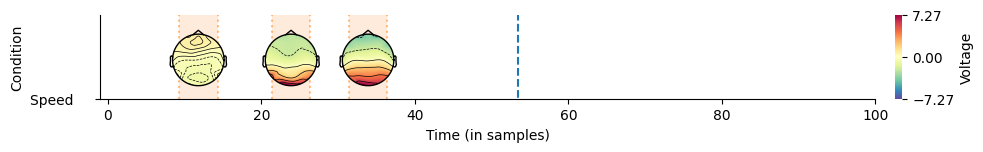

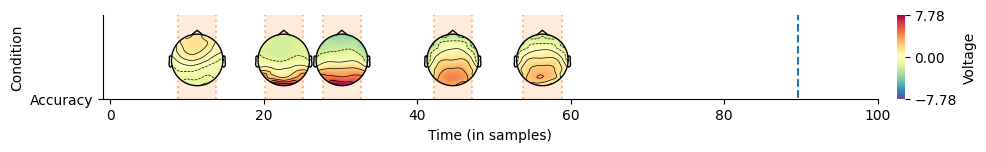

In [19]:
for condition in zip([fit_speed, fit_accuracy],
                     [model_speed, model_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['Speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(eeg_data, condition[0],
                          positions, condition[1],  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=100,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]})